In [7]:
# En Colab hay que instalar esta versión de Fastai
#!pip install -q fastai==2.3

In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Thu Dec  2 13:37:41 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.91.03    Driver Version: 460.91.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce RTX 3080    Off  | 00000000:01:00.0 Off |                  N/A |
|  0%   50C    P8    27W / 370W |   3750MiB / 10016MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import fastai
fastai.__version__

'2.3.0'

In [3]:
#import libraries

from IPython.core.display import display, HTML, clear_output
display(HTML("<style>.container { width:100% !important; } div.cell.selected {border-left-width: 10px !important;}</style>"))
import os
import shutil
import glob
from sympy import *
import os
import datetime
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import itertools as it
from PIL import Image
from IPython.display import clear_output
import random
if not 'notebook_dir' in globals():
    notebook_dir = os.getcwd()
print('Notebook directory: ' + notebook_dir)
os.chdir(notebook_dir)  # If you change the current working dir, this will take you back to the workbook dir.
top_dir = notebook_dir
from fastai.tabular.all import *
from skimage import data
from skimage.filters import threshold_multiotsu
import inspect
from sklearn.manifold import TSNE
from sklearn import decomposition
#from sklearn.preprocessing import scaled
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import more_itertools
from sklearn.manifold import TSNE
import cv2
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import imutils
from time import time
init_printing() # Numeros más bonitos

Notebook directory: /home/gabriel/Desktop


In [6]:
#Save Images

# PCAs_todas: mezcla de pcas con 5 y 10 capas ocultas. Más robusto aunque menos preciso
folder = 'PCAs_todas'
dd = top_dir + '/' + folder

if not os.path.isdir(dd):
    print('Creating directory:\n',dd)
    os.mkdir(dd)

dir = os.path.join(top_dir,folder)

In [7]:
dirs = Path(dir).ls()
for direc in dirs:
    print(direc,'--',len(Path(direc).ls()))

/home/gabriel/Desktop/PCAs_todas/continuous_rotation -- 4291
/home/gabriel/Desktop/PCAs_todas/none -- 4273
/home/gabriel/Desktop/PCAs_todas/continuous_translation -- 4277
/home/gabriel/Desktop/PCAs_todas/discrete_translation -- 4261
/home/gabriel/Desktop/PCAs_todas/reflection -- 4274


# Generar Potenciales

He tenido que cambiar la fución que hace SaveModelCallback, porque cada vez que encontraba un modelo aparecía la frasecita "Better model found at epoch..." y hacer casi 200 prints por potencial, no solo hace que se vea horrible sino que también ralentiza un poco el proceso

In [8]:
class SaveModelCallback(TrackerCallback):
    "A `TrackerCallback` that saves the model's best during training and loads it at the end."
    _only_train_loop = True
    def __init__(self, monitor='valid_loss', comp=None, min_delta=0., fname='model', every_epoch=False, at_end=False,
                 with_opt=False, reset_on_fit=True):
        super().__init__(monitor=monitor, comp=comp, min_delta=min_delta, reset_on_fit=reset_on_fit)
        assert not (every_epoch and at_end), "every_epoch and at_end cannot both be set to True"
        # keep track of file path for loggers
        self.last_saved_path = None
        store_attr('fname,every_epoch,at_end,with_opt')

    def _save(self, name): self.last_saved_path = self.learn.save(name, with_opt=self.with_opt)

    def after_epoch(self):
        "Compare the value monitored to its best score and save if best."
        if self.every_epoch: self._save(f'{self.fname}_{self.epoch}')
        else: #every improvement
            super().after_epoch()
            if self.new_best:
                #print(f'Better model found at epoch {self.epoch} with {self.monitor} value: {self.best}.')
                self._save(f'{self.fname}')

    def after_fit(self, **kwargs):
        "Load the best model."
        if self.at_end: self._save(f'{self.fname}')
        elif not self.every_epoch: self.learn.load(f'{self.fname}', with_opt=self.with_opt)

In [6]:
def potential_df(symmetry = 'none'):
  
  # Generar un solo potencial, pero le tienes que decir la simetría que 
  # quieres que tenga. por defecto pondrá sin simetría.

  [x_min,x_max]=  [-1,1]
  [y_min,y_max]= [-1,1]
  x_num = 100 # Number of values given to x
  y_num = 100 # Number of values given to y
  # inputs es el resultado de emparejar cada x con todas las y
  # Si x = [0,1,2] e y = [a,b], 
  # input = [[0,a],[0,b],[1,a],[1,b],[2,a],[2,b]]
  inputs = np.array(list(it.product(np.linspace(x_min,x_max,x_num),np.linspace(y_min,y_max,y_num))))

  #Usaremos estas x_s y estas y_s para calcularnos potenciales en cada punto
  x_s , y_s = inputs.T #Separamos las parejas

  max_power = 5
  min_power = 1
  count_powers = max_power-min_power+1

  #Una función que te da un array de: [x,x^2,x^3...] entre min_power y max_power
  def powers(var): 
      powers=[]
      for i in range(min_power,max_power+1,1):
          powers.append(var**i)
      return powers

  def V(x,y):
      if symmetry=='continuous_rotation':
          c_i_s = np.random.normal(0,1, size=( count_powers))
          return np.dot(c_i_s,powers(np.sqrt(x**2+y**2)))
      
      if symmetry=='none':
          c_ij_s =  np.random.normal(0,1, size=(count_powers,count_powers))
          res = np.array([np.dot(np.array(powers(np.array(x[i]))),np.matmul(c_ij_s,powers(y[i]))) for i in range(len(x_s))])
          return res

      if symmetry=='continuous_translation':
          c_i_s = np.random.normal(0,1, size=( count_powers))
          return np.dot(c_i_s,powers(np.random.normal(0,1)*x+np.random.normal(0,1)*y)) 

      if symmetry=='discrete_translation':
          n_s=6
          ni = np.random.choice([-1,1],n_s) * np.random.normal(5,3, n_s)
          return ni[0]*np.sin(ni[1]*(x)+ni[2]*y) +ni[3]*np.cos(ni[4]*x + ni[5]*y)

      if symmetry=='reflection':
          c_ij_s =  np.random.normal(0,1, size=(count_powers,count_powers))
          rn1 = np.random.normal(0,1)
          rn2 = np.random.normal(0,1)
          rn3 = np.random.normal(0,1)
          rn4 = np.random.normal(0,1)
          return np.array([np.dot(powers((rn1*x[i]**2+rn2*y[i]**2)), np.matmul(c_ij_s,powers(rn3*x[i]**2+rn4*y[i]**2))) for i in range(len(x_s))])


  #write a data frame
  data = {
        'x':x_s,        
        'y':y_s,
        'V':V(x_s,y_s)
        }

  df = pd.DataFrame(data,columns=['x','y','V'])


  # Para evitar divergencias y no dar tanta importancia a puntos donde el potencial es muy alto
  # agrupamos los puntos del potencial en bines. Intentamos que haya un bin por 
  # punto del potencial, pero hay puntos en los que el potencial
  # vale lo mismo. Agrupamos esos puntos en bines.

  n_attempted_bins =  len(x_s)

  binning = pd.qcut(df.V, q=n_attempted_bins,retbins=True,labels=False,duplicates='drop')
  df['bin']=binning[0]
  #n_actual_bins=len(binning[1])-1

  # Es importante normalizar los bines, para que se pueda generalizar a cualquier potencial
  df['bin']=df.bin/np.max(df.bin)

  return df

#------------------------------ Generar Potenciales ---------------------------#

#Tipos de simetría que quiero generar
#syms = ['continuous_rotation', 'discrete_translation', 'reflection', 'none', 'continuous_translation']
symmetries = ['continuous_rotation', 'discrete_translation', 'reflection', 'none', 'continuous_translation']

num_pot_cada = 400 # Numero de potenciales de cada tipo

potenciales = []
potenciales_tags = []

for symmetry in symmetries:
  print('Generating Potentials for',symmetry,'symmetry')
  funs_temp = [potential_df(symmetry = symmetry) for i in range(num_pot_cada)]
  funs_tags_temp = [symmetry for i in range(num_pot_cada)]
  potenciales = potenciales + funs_temp 
  potenciales_tags = potenciales_tags + funs_tags_temp

# Vamos a ordenar los potenciales de forma aleatoria, aunque en realidad
# este paso no es relevante, puesto que para cada potencial entrenaremos una 
# red. Si fuéramos a entrenar una red con todos los potenciales, entonces sí
# que sería relevante.

num_pot = len(potenciales) # Numero de Potenciales que quiero (por si no quiero todos)

c = list(zip(potenciales,potenciales_tags))

# Barajamos los potenciales, para pasarseslos en orden aleatorio
#random.shuffle(c)

potenciales_aux, tags = zip(*c)

potenciales = [potenciales_aux[i] for i in range(num_pot)]

# ---------------- Definiciones previas e hiperparámetros ----------------- #

#Guardo los modelos para analizarlos luego
models = [] 
to_s = []

#Guardaremos los resultados de la PCA en un array 
PCA_s = []
PCA_s_tag = []

# Hyperparameters: De momento los pondré aquí, pero luego serán un input entero
bs_choices = [20000]       # Batch Size
shape='pipe'               # Shape of the neural network
layers_choices = [4]       # Number of layers of the net. Default:10 or 5
neurons_choices = [50]    # Number of neurons per layer. Default:200
epoch_choices = [100]      # Number of training epochs. Default:200
lr_choices = [0.01]       # Max learning rate 
valid_pct=0.2              # Part of the data that goes into validation (0.2 = 20%)
monitor= 'valid_loss'        # Te model with the least 'monitor' will be saved

# Tiempo en el que empezamos a procesar
start_time = time()

# ---------------------- Entrenar Red Y PCA -----------------------------------#

j = 1 # Usaremos esto para saber cuantos potenciales hemos procesado, y como indice en general

for df in potenciales:

  # Debemos marcar cada potencial para tener claro a qué tipo de simetri corresponde cada PCA
  PCA_s_tag.append(tags[j-1])

  #In order to work with smaller df's, we drop the value of the the potential V, as we won't be using it
  df2 = df.drop('V', axis = 1) 

  splits = RandomSplitter(valid_pct=valid_pct)(range_of(df2))

  to = TabularPandas(df2,
                    procs=[Categorify,FillMissing, Normalize],
                    cont_names = ['x', 'y'],
                    y_names = 'bin',
                    splits=splits)
  
  train_size = len(splits[0])
  valid_size = len(splits[1])

# ----------------- Hyperparameters ------------------- #

  # Batch Size (a large one)
  bs=min(random.choice(bs_choices),train_size)  
  print('{} batch size for training.\n'.format(bs))

  # Neurons per layer
  neurons_per_layer = random.choice(neurons_choices)

  # Number of layers
  n_layers = random.choice(layers_choices)

  #Shape of the net: Pipe or funnel
  if shape == 'pipe':
      layers=[neurons_per_layer for i in range(n_layers)]

  if shape == 'funnel':
      n_eff = n_layers
      layers = np.clip(sum([[2**(n_layers-i+2)] for i in range(0,n_layers,1)],[]),2,neurons_per_layer).tolist()
  
  print('Training FCNN with layers: ',layers)

  #Number of epochs
  n_epoch=random.choice(epoch_choices)
  print('Training for {} epochs.'.format(n_epoch))

  # Maximum Learning Rate: (a good value can be found using learn.lr_find())
  lr_max=float(random.choice(lr_choices))
  print('Using lr_max = ',format(lr_max))

  # ----------------------------------------------------- #

  # --------------- Training the FCNN --------------------#

  # Load the data into a DataLoader
  dls = to.dataloaders(bs=bs)

  # Define a Tabular Learner
  learn = tabular_learner(dls, layers=layers
                        #,config=config
                        ,metrics=[mse],
                        #y_range = [min(df.bin),max(df.bin)],
                        #,cbs=ShowGraphCallback()
                        #,train_bn=False)
                        )

  # Train the net 
  with learn.no_logging():
        learn.fit_one_cycle(n_epoch=n_epoch
                            ,lr_max=lr_max
                            ,cbs=[SaveModelCallback(monitor=monitor)]
                            )
  
  # Guardamos modelos y tabular objects para el posterior analisis
  models.append(learn)
  to_s.append(to)

  # ------------------------------------------------------#


  # ------------------------- PCA ------------------------#

  test_df = df2.copy()
  dl = learn.dls.test_dl(test_df,bs=test_df.shape[0]) 

  # Tenemos que hacer un Hook, una especie de gancho que enganchamos en la última capa interna,
  # para guardar, de cada modelo, los valores de los parámetro de dicha capa. 
  with Hooks(learn.model.layers, lambda m,i,o: o) as h:
      preds = learn.get_preds(dl=dl,with_input=True,with_decoded=True,with_loss=True)

  targets=preds[2].numpy().flatten()

  # Cogemos la información de la penúltima capa
  # OJO: Si añadimos y_range, se añade automaticamente una sigmoid
  # al final, por lo que tendríamos que coger la capa -3 en vez de la -2
  act = h.stored[-2] 
  multi_dim=Tensor.cpu(act).numpy()
  standardized=StandardScaler().fit_transform(multi_dim)

  viz = PCA(2).fit_transform(standardized)
  #plt.figure()
  #plt.scatter(viz[:, 0], viz[:, 1],c=targets[:multi_dim.shape[0]],alpha=.1, marker = 'o')

  PCA_s.append(viz)

  # ------------------------------------------------------ #

  # ------------------ Saving the PCA's ------------------ #
  
  # ---- Dar formato a PCA para guardar como imagen con color
  
  viz = pd.DataFrame(viz) #Transformamos la PCA en un dataframe
  viz.columns = ['x','y'] #Nombres de las columnas

  # Insertamos una columna con los colores de los puntos. El valor del potencial
  # objetivo (targets) es el color, y hay un color por cada punto 
  viz.insert(2,'class',targets[:multi_dim.shape[0]]) 

  # ---- Personalizar mapa de color 

  n_classes=1000

  colors = 'rainbow'

  if colors == 'rainbow':
      my_cmap = plt.cm.get_cmap('rainbow', n_classes)
      classes_in_rgb = my_cmap(range(n_classes))
  if colors == 'purple':
      my_cmap = plt.cm.get_cmap('rainbow', n_classes)
      classes_in_rgb = np.vstack((np.array([0,0,0,0]),my_cmap([0 for i in range(n_classes)])))

  # ---- Hacer que la intensidad del pixel represente la cantidad de puntos 
  #      acumuldos en un pixel

  n_pixels = 224

  binning_3d=np.histogramdd([viz['x'],viz['y'],viz['class']],range=(None,None,(0,1)), bins=(n_pixels,n_pixels,n_classes))
    
  #if we want the pixel intensity to reprensent the number of points at that location
  array = np.dot(binning_3d[0],classes_in_rgb)
  array = array/np.amax(array)

  # ---- Guardar la PCA

  #Directorio donde guardaremos las imagenes
  dir_sym = os.path.join(dir,tags[j-1])
  if not os.path.isdir(dir_sym):
      print('Creating directory:\n',dir_sym)
      os.mkdir(dir_sym)
   
    
  # Nombre de la imagen. Pongo el tiempo para que todas se llamen distinto cada vez.
  img_file = str(tags[j-1])+'_'+str(j)+str(round(time()))+'-'+str(n_classes)+'_'+'color_classes--'+'_PCA.png' 
  output_dir = os.path.join(dir_sym,img_file) # Directorio donde guardamos la imagen
  plt.imsave(output_dir,array) # Guardar
  print('\nPCA saved to:\n{}\n'.format(dir_sym+'/'+img_file))

  # ------------------------ Time -------------------------#

  minutes_until_now = (time() - start_time)/60
  images_done = j
  minutes_per_image = minutes_until_now/(images_done)
  hours_left = minutes_per_image * (num_pot-images_done)/60
  print("\n{} PCA's made out of {}.\n".format(images_done,num_pot))
  print("{:.1f} minutes elapsed for {} images.".format(minutes_until_now,images_done))
  print("{:.1f} minutes average per image.".format(minutes_until_now/images_done))
  print("{:.1f} minutes estimated left for {} images.\n\n\n".format(hours_left*60,num_pot-images_done))
  print("{:.1f} hours estimated left for {} images.\n\n\n".format(hours_left,num_pot-images_done))
  j+=1

  # ------------------------------------------------------#


Generating Potentials for continuous_rotation symmetry
Generating Potentials for discrete_translation symmetry
Generating Potentials for reflection symmetry
Generating Potentials for none symmetry
Generating Potentials for continuous_translation symmetry
8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_11624797643-1000_color_classes--_PCA.png


1 PCA's made out of 2000.

0.1 minutes elapsed for 1 images.
0.1 minutes average per image.
173.3 minutes estimated left for 1999 images.



2.9 hours estimated left for 1999 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_21624797646-1000_color_classes--_PCA.png


2 PCA's made out of 2000.

0.1 minutes elapsed for 2 images.
0.1 minutes average per image.
146.4 minutes estimated left for 1998 images.



2.4 hours estimated left for 1998 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_31624797650-1000_color_classes--_PCA.png


3 PCA's made out of 2000.

0.2 minutes elapsed for 3 images.
0.1 minutes average per image.
135.7 minutes estimated left for 1997 images.



2.3 hours estimated left for 1997 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_41624797653-1000_color_classes--_PCA.png


4 PCA's made out of 2000.

0.3 minutes elapsed for 4 images.
0.1 minutes average per image.
129.9 minutes estimated left for 1996 images.



2.2 hours estimated left for 1996 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_51624797656-1000_color_classes--_PCA.png


5 PCA's made out of 2000.

0.3 minutes elapsed for 5 images.
0.1 minutes average per image.
126.4 minutes estimated left for 1995 images.



2.1 hours estimated left for 1995 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_61624797660-1000_color_classes--_PCA.png


6 PCA's made out of 2000.

0.4 minutes elapsed for 6 images.
0.1 minutes average per image.
124.0 minutes estimated left for 1994 images.



2.1 hours estimated left for 1994 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_71624797663-1000_color_classes--_PCA.png


7 PCA's made out of 2000.

0.4 minutes elapsed for 7 images.
0.1 minutes average per image.
122.4 minutes estimated left for 1993 images.



2.0 hours estimated left for 1993 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_81624797667-1000_color_classes--_PCA.png


8 PCA's made out of 2000.

0.5 minutes elapsed for 8 images.
0.1 minutes average per image.
120.7 minutes estimated left for 1992 images.



2.0 hours estimated left for 1992 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_91624797670-1000_color_classes--_PCA.png


9 PCA's made out of 2000.

0.5 minutes elapsed for 9 images.
0.1 minutes average per image.
119.6 minutes estimated left for 1991 images.



2.0 hours estimated left for 1991 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_101624797673-1000_color_classes--_PCA.png


10 PCA's made out of 2000.

0.6 minutes elapsed for 10 images.
0.1 minutes average per image.
118.5 minutes estimated left for 1990 images.



2.0 hours estimated left for 1990 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_111624797677-1000_color_classes--_PCA.png


11 PCA's made out of 2000.

0.7 minutes elapsed for 11 images.
0.1 minutes average per image.
117.6 minutes estimated left for 1989 images.



2.0 hours estimated left for 1989 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_121624797680-1000_color_classes--_PCA.png


12 PCA's made out of 2000.

0.7 minutes elapsed for 12 images.
0.1 minutes average per image.
117.2 minutes estimated left for 1988 images.



2.0 hours estimated left for 1988 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_131624797683-1000_color_classes--_PCA.png


13 PCA's made out of 2000.

0.8 minutes elapsed for 13 images.
0.1 minutes average per image.
116.8 minutes estimated left for 1987 images.



1.9 hours estimated left for 1987 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_141624797687-1000_color_classes--_PCA.png


14 PCA's made out of 2000.

0.8 minutes elapsed for 14 images.
0.1 minutes average per image.
116.3 minutes estimated left for 1986 images.



1.9 hours estimated left for 1986 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_151624797690-1000_color_classes--_PCA.png


15 PCA's made out of 2000.

0.9 minutes elapsed for 15 images.
0.1 minutes average per image.
116.0 minutes estimated left for 1985 images.



1.9 hours estimated left for 1985 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_161624797693-1000_color_classes--_PCA.png


16 PCA's made out of 2000.

0.9 minutes elapsed for 16 images.
0.1 minutes average per image.
115.6 minutes estimated left for 1984 images.



1.9 hours estimated left for 1984 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_171624797697-1000_color_classes--_PCA.png


17 PCA's made out of 2000.

1.0 minutes elapsed for 17 images.
0.1 minutes average per image.
115.4 minutes estimated left for 1983 images.



1.9 hours estimated left for 1983 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_181624797700-1000_color_classes--_PCA.png


18 PCA's made out of 2000.

1.0 minutes elapsed for 18 images.
0.1 minutes average per image.
115.1 minutes estimated left for 1982 images.



1.9 hours estimated left for 1982 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_191624797704-1000_color_classes--_PCA.png


19 PCA's made out of 2000.

1.1 minutes elapsed for 19 images.
0.1 minutes average per image.
114.8 minutes estimated left for 1981 images.



1.9 hours estimated left for 1981 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_201624797707-1000_color_classes--_PCA.png


20 PCA's made out of 2000.

1.2 minutes elapsed for 20 images.
0.1 minutes average per image.
114.4 minutes estimated left for 1980 images.



1.9 hours estimated left for 1980 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_211624797710-1000_color_classes--_PCA.png


21 PCA's made out of 2000.

1.2 minutes elapsed for 21 images.
0.1 minutes average per image.
114.2 minutes estimated left for 1979 images.



1.9 hours estimated left for 1979 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_221624797714-1000_color_classes--_PCA.png


22 PCA's made out of 2000.

1.3 minutes elapsed for 22 images.
0.1 minutes average per image.
114.0 minutes estimated left for 1978 images.



1.9 hours estimated left for 1978 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_231624797717-1000_color_classes--_PCA.png


23 PCA's made out of 2000.

1.3 minutes elapsed for 23 images.
0.1 minutes average per image.
113.8 minutes estimated left for 1977 images.



1.9 hours estimated left for 1977 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_241624797720-1000_color_classes--_PCA.png


24 PCA's made out of 2000.

1.4 minutes elapsed for 24 images.
0.1 minutes average per image.
113.6 minutes estimated left for 1976 images.



1.9 hours estimated left for 1976 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_251624797724-1000_color_classes--_PCA.png


25 PCA's made out of 2000.

1.4 minutes elapsed for 25 images.
0.1 minutes average per image.
113.5 minutes estimated left for 1975 images.



1.9 hours estimated left for 1975 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_261624797727-1000_color_classes--_PCA.png


26 PCA's made out of 2000.

1.5 minutes elapsed for 26 images.
0.1 minutes average per image.
113.3 minutes estimated left for 1974 images.



1.9 hours estimated left for 1974 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_271624797730-1000_color_classes--_PCA.png


27 PCA's made out of 2000.

1.5 minutes elapsed for 27 images.
0.1 minutes average per image.
113.3 minutes estimated left for 1973 images.



1.9 hours estimated left for 1973 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_281624797734-1000_color_classes--_PCA.png


28 PCA's made out of 2000.

1.6 minutes elapsed for 28 images.
0.1 minutes average per image.
113.1 minutes estimated left for 1972 images.



1.9 hours estimated left for 1972 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_291624797737-1000_color_classes--_PCA.png


29 PCA's made out of 2000.

1.7 minutes elapsed for 29 images.
0.1 minutes average per image.
113.2 minutes estimated left for 1971 images.



1.9 hours estimated left for 1971 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_301624797741-1000_color_classes--_PCA.png


30 PCA's made out of 2000.

1.7 minutes elapsed for 30 images.
0.1 minutes average per image.
113.0 minutes estimated left for 1970 images.



1.9 hours estimated left for 1970 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_311624797744-1000_color_classes--_PCA.png


31 PCA's made out of 2000.

1.8 minutes elapsed for 31 images.
0.1 minutes average per image.
113.0 minutes estimated left for 1969 images.



1.9 hours estimated left for 1969 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_321624797748-1000_color_classes--_PCA.png


32 PCA's made out of 2000.

1.8 minutes elapsed for 32 images.
0.1 minutes average per image.
112.9 minutes estimated left for 1968 images.



1.9 hours estimated left for 1968 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_331624797751-1000_color_classes--_PCA.png


33 PCA's made out of 2000.

1.9 minutes elapsed for 33 images.
0.1 minutes average per image.
112.7 minutes estimated left for 1967 images.



1.9 hours estimated left for 1967 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_341624797754-1000_color_classes--_PCA.png


34 PCA's made out of 2000.

1.9 minutes elapsed for 34 images.
0.1 minutes average per image.
112.5 minutes estimated left for 1966 images.



1.9 hours estimated left for 1966 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_351624797758-1000_color_classes--_PCA.png


35 PCA's made out of 2000.

2.0 minutes elapsed for 35 images.
0.1 minutes average per image.
112.4 minutes estimated left for 1965 images.



1.9 hours estimated left for 1965 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_361624797761-1000_color_classes--_PCA.png


36 PCA's made out of 2000.

2.1 minutes elapsed for 36 images.
0.1 minutes average per image.
112.4 minutes estimated left for 1964 images.



1.9 hours estimated left for 1964 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_371624797765-1000_color_classes--_PCA.png


37 PCA's made out of 2000.

2.1 minutes elapsed for 37 images.
0.1 minutes average per image.
112.3 minutes estimated left for 1963 images.



1.9 hours estimated left for 1963 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_381624797768-1000_color_classes--_PCA.png


38 PCA's made out of 2000.

2.2 minutes elapsed for 38 images.
0.1 minutes average per image.
112.3 minutes estimated left for 1962 images.



1.9 hours estimated left for 1962 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_391624797771-1000_color_classes--_PCA.png


39 PCA's made out of 2000.

2.2 minutes elapsed for 39 images.
0.1 minutes average per image.
112.1 minutes estimated left for 1961 images.



1.9 hours estimated left for 1961 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_401624797775-1000_color_classes--_PCA.png


40 PCA's made out of 2000.

2.3 minutes elapsed for 40 images.
0.1 minutes average per image.
112.0 minutes estimated left for 1960 images.



1.9 hours estimated left for 1960 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_411624797778-1000_color_classes--_PCA.png


41 PCA's made out of 2000.

2.3 minutes elapsed for 41 images.
0.1 minutes average per image.
111.8 minutes estimated left for 1959 images.



1.9 hours estimated left for 1959 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_421624797781-1000_color_classes--_PCA.png


42 PCA's made out of 2000.

2.4 minutes elapsed for 42 images.
0.1 minutes average per image.
111.7 minutes estimated left for 1958 images.



1.9 hours estimated left for 1958 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_431624797785-1000_color_classes--_PCA.png


43 PCA's made out of 2000.

2.5 minutes elapsed for 43 images.
0.1 minutes average per image.
111.6 minutes estimated left for 1957 images.



1.9 hours estimated left for 1957 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_441624797788-1000_color_classes--_PCA.png


44 PCA's made out of 2000.

2.5 minutes elapsed for 44 images.
0.1 minutes average per image.
111.5 minutes estimated left for 1956 images.



1.9 hours estimated left for 1956 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_451624797791-1000_color_classes--_PCA.png


45 PCA's made out of 2000.

2.6 minutes elapsed for 45 images.
0.1 minutes average per image.
111.4 minutes estimated left for 1955 images.



1.9 hours estimated left for 1955 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_461624797795-1000_color_classes--_PCA.png


46 PCA's made out of 2000.

2.6 minutes elapsed for 46 images.
0.1 minutes average per image.
111.3 minutes estimated left for 1954 images.



1.9 hours estimated left for 1954 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_471624797798-1000_color_classes--_PCA.png


47 PCA's made out of 2000.

2.7 minutes elapsed for 47 images.
0.1 minutes average per image.
111.2 minutes estimated left for 1953 images.



1.9 hours estimated left for 1953 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_481624797801-1000_color_classes--_PCA.png


48 PCA's made out of 2000.

2.7 minutes elapsed for 48 images.
0.1 minutes average per image.
111.1 minutes estimated left for 1952 images.



1.9 hours estimated left for 1952 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_491624797805-1000_color_classes--_PCA.png


49 PCA's made out of 2000.

2.8 minutes elapsed for 49 images.
0.1 minutes average per image.
111.0 minutes estimated left for 1951 images.



1.9 hours estimated left for 1951 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_501624797808-1000_color_classes--_PCA.png


50 PCA's made out of 2000.

2.8 minutes elapsed for 50 images.
0.1 minutes average per image.
111.0 minutes estimated left for 1950 images.



1.8 hours estimated left for 1950 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_511624797812-1000_color_classes--_PCA.png


51 PCA's made out of 2000.

2.9 minutes elapsed for 51 images.
0.1 minutes average per image.
110.9 minutes estimated left for 1949 images.



1.8 hours estimated left for 1949 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_521624797815-1000_color_classes--_PCA.png


52 PCA's made out of 2000.

3.0 minutes elapsed for 52 images.
0.1 minutes average per image.
110.8 minutes estimated left for 1948 images.



1.8 hours estimated left for 1948 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_531624797818-1000_color_classes--_PCA.png


53 PCA's made out of 2000.

3.0 minutes elapsed for 53 images.
0.1 minutes average per image.
110.7 minutes estimated left for 1947 images.



1.8 hours estimated left for 1947 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_541624797822-1000_color_classes--_PCA.png


54 PCA's made out of 2000.

3.1 minutes elapsed for 54 images.
0.1 minutes average per image.
110.6 minutes estimated left for 1946 images.



1.8 hours estimated left for 1946 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_551624797825-1000_color_classes--_PCA.png


55 PCA's made out of 2000.

3.1 minutes elapsed for 55 images.
0.1 minutes average per image.
110.6 minutes estimated left for 1945 images.



1.8 hours estimated left for 1945 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_561624797828-1000_color_classes--_PCA.png


56 PCA's made out of 2000.

3.2 minutes elapsed for 56 images.
0.1 minutes average per image.
110.5 minutes estimated left for 1944 images.



1.8 hours estimated left for 1944 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_571624797832-1000_color_classes--_PCA.png


57 PCA's made out of 2000.

3.2 minutes elapsed for 57 images.
0.1 minutes average per image.
110.4 minutes estimated left for 1943 images.



1.8 hours estimated left for 1943 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_581624797835-1000_color_classes--_PCA.png


58 PCA's made out of 2000.

3.3 minutes elapsed for 58 images.
0.1 minutes average per image.
110.4 minutes estimated left for 1942 images.



1.8 hours estimated left for 1942 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_591624797839-1000_color_classes--_PCA.png


59 PCA's made out of 2000.

3.4 minutes elapsed for 59 images.
0.1 minutes average per image.
110.2 minutes estimated left for 1941 images.



1.8 hours estimated left for 1941 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_601624797842-1000_color_classes--_PCA.png


60 PCA's made out of 2000.

3.4 minutes elapsed for 60 images.
0.1 minutes average per image.
110.1 minutes estimated left for 1940 images.



1.8 hours estimated left for 1940 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_611624797845-1000_color_classes--_PCA.png


61 PCA's made out of 2000.

3.5 minutes elapsed for 61 images.
0.1 minutes average per image.
110.0 minutes estimated left for 1939 images.



1.8 hours estimated left for 1939 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_621624797849-1000_color_classes--_PCA.png


62 PCA's made out of 2000.

3.5 minutes elapsed for 62 images.
0.1 minutes average per image.
109.9 minutes estimated left for 1938 images.



1.8 hours estimated left for 1938 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_631624797852-1000_color_classes--_PCA.png


63 PCA's made out of 2000.

3.6 minutes elapsed for 63 images.
0.1 minutes average per image.
109.9 minutes estimated left for 1937 images.



1.8 hours estimated left for 1937 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_641624797855-1000_color_classes--_PCA.png


64 PCA's made out of 2000.

3.6 minutes elapsed for 64 images.
0.1 minutes average per image.
109.8 minutes estimated left for 1936 images.



1.8 hours estimated left for 1936 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_651624797859-1000_color_classes--_PCA.png


65 PCA's made out of 2000.

3.7 minutes elapsed for 65 images.
0.1 minutes average per image.
109.7 minutes estimated left for 1935 images.



1.8 hours estimated left for 1935 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_661624797862-1000_color_classes--_PCA.png


66 PCA's made out of 2000.

3.7 minutes elapsed for 66 images.
0.1 minutes average per image.
109.6 minutes estimated left for 1934 images.



1.8 hours estimated left for 1934 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_671624797865-1000_color_classes--_PCA.png


67 PCA's made out of 2000.

3.8 minutes elapsed for 67 images.
0.1 minutes average per image.
109.5 minutes estimated left for 1933 images.



1.8 hours estimated left for 1933 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_681624797869-1000_color_classes--_PCA.png


68 PCA's made out of 2000.

3.9 minutes elapsed for 68 images.
0.1 minutes average per image.
109.4 minutes estimated left for 1932 images.



1.8 hours estimated left for 1932 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_691624797872-1000_color_classes--_PCA.png


69 PCA's made out of 2000.

3.9 minutes elapsed for 69 images.
0.1 minutes average per image.
109.3 minutes estimated left for 1931 images.



1.8 hours estimated left for 1931 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_701624797875-1000_color_classes--_PCA.png


70 PCA's made out of 2000.

4.0 minutes elapsed for 70 images.
0.1 minutes average per image.
109.3 minutes estimated left for 1930 images.



1.8 hours estimated left for 1930 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_711624797879-1000_color_classes--_PCA.png


71 PCA's made out of 2000.

4.0 minutes elapsed for 71 images.
0.1 minutes average per image.
109.2 minutes estimated left for 1929 images.



1.8 hours estimated left for 1929 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_721624797882-1000_color_classes--_PCA.png


72 PCA's made out of 2000.

4.1 minutes elapsed for 72 images.
0.1 minutes average per image.
109.1 minutes estimated left for 1928 images.



1.8 hours estimated left for 1928 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_731624797886-1000_color_classes--_PCA.png


73 PCA's made out of 2000.

4.1 minutes elapsed for 73 images.
0.1 minutes average per image.
109.1 minutes estimated left for 1927 images.



1.8 hours estimated left for 1927 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_741624797889-1000_color_classes--_PCA.png


74 PCA's made out of 2000.

4.2 minutes elapsed for 74 images.
0.1 minutes average per image.
109.0 minutes estimated left for 1926 images.



1.8 hours estimated left for 1926 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_751624797892-1000_color_classes--_PCA.png


75 PCA's made out of 2000.

4.2 minutes elapsed for 75 images.
0.1 minutes average per image.
108.9 minutes estimated left for 1925 images.



1.8 hours estimated left for 1925 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_761624797896-1000_color_classes--_PCA.png


76 PCA's made out of 2000.

4.3 minutes elapsed for 76 images.
0.1 minutes average per image.
108.9 minutes estimated left for 1924 images.



1.8 hours estimated left for 1924 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_771624797899-1000_color_classes--_PCA.png


77 PCA's made out of 2000.

4.4 minutes elapsed for 77 images.
0.1 minutes average per image.
108.8 minutes estimated left for 1923 images.



1.8 hours estimated left for 1923 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_781624797902-1000_color_classes--_PCA.png


78 PCA's made out of 2000.

4.4 minutes elapsed for 78 images.
0.1 minutes average per image.
108.8 minutes estimated left for 1922 images.



1.8 hours estimated left for 1922 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_791624797906-1000_color_classes--_PCA.png


79 PCA's made out of 2000.

4.5 minutes elapsed for 79 images.
0.1 minutes average per image.
108.7 minutes estimated left for 1921 images.



1.8 hours estimated left for 1921 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_801624797909-1000_color_classes--_PCA.png


80 PCA's made out of 2000.

4.5 minutes elapsed for 80 images.
0.1 minutes average per image.
108.7 minutes estimated left for 1920 images.



1.8 hours estimated left for 1920 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_811624797913-1000_color_classes--_PCA.png


81 PCA's made out of 2000.

4.6 minutes elapsed for 81 images.
0.1 minutes average per image.
108.6 minutes estimated left for 1919 images.



1.8 hours estimated left for 1919 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_821624797916-1000_color_classes--_PCA.png


82 PCA's made out of 2000.

4.6 minutes elapsed for 82 images.
0.1 minutes average per image.
108.5 minutes estimated left for 1918 images.



1.8 hours estimated left for 1918 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_831624797919-1000_color_classes--_PCA.png


83 PCA's made out of 2000.

4.7 minutes elapsed for 83 images.
0.1 minutes average per image.
108.5 minutes estimated left for 1917 images.



1.8 hours estimated left for 1917 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_841624797923-1000_color_classes--_PCA.png


84 PCA's made out of 2000.

4.8 minutes elapsed for 84 images.
0.1 minutes average per image.
108.4 minutes estimated left for 1916 images.



1.8 hours estimated left for 1916 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_851624797926-1000_color_classes--_PCA.png


85 PCA's made out of 2000.

4.8 minutes elapsed for 85 images.
0.1 minutes average per image.
108.3 minutes estimated left for 1915 images.



1.8 hours estimated left for 1915 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_861624797929-1000_color_classes--_PCA.png


86 PCA's made out of 2000.

4.9 minutes elapsed for 86 images.
0.1 minutes average per image.
108.3 minutes estimated left for 1914 images.



1.8 hours estimated left for 1914 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_871624797933-1000_color_classes--_PCA.png


87 PCA's made out of 2000.

4.9 minutes elapsed for 87 images.
0.1 minutes average per image.
108.2 minutes estimated left for 1913 images.



1.8 hours estimated left for 1913 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_881624797936-1000_color_classes--_PCA.png


88 PCA's made out of 2000.

5.0 minutes elapsed for 88 images.
0.1 minutes average per image.
108.2 minutes estimated left for 1912 images.



1.8 hours estimated left for 1912 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_891624797940-1000_color_classes--_PCA.png


89 PCA's made out of 2000.

5.0 minutes elapsed for 89 images.
0.1 minutes average per image.
108.1 minutes estimated left for 1911 images.



1.8 hours estimated left for 1911 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_901624797943-1000_color_classes--_PCA.png


90 PCA's made out of 2000.

5.1 minutes elapsed for 90 images.
0.1 minutes average per image.
108.1 minutes estimated left for 1910 images.



1.8 hours estimated left for 1910 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_911624797946-1000_color_classes--_PCA.png


91 PCA's made out of 2000.

5.1 minutes elapsed for 91 images.
0.1 minutes average per image.
108.0 minutes estimated left for 1909 images.



1.8 hours estimated left for 1909 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_921624797950-1000_color_classes--_PCA.png


92 PCA's made out of 2000.

5.2 minutes elapsed for 92 images.
0.1 minutes average per image.
108.0 minutes estimated left for 1908 images.



1.8 hours estimated left for 1908 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_931624797953-1000_color_classes--_PCA.png


93 PCA's made out of 2000.

5.3 minutes elapsed for 93 images.
0.1 minutes average per image.
108.0 minutes estimated left for 1907 images.



1.8 hours estimated left for 1907 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_941624797957-1000_color_classes--_PCA.png


94 PCA's made out of 2000.

5.3 minutes elapsed for 94 images.
0.1 minutes average per image.
107.9 minutes estimated left for 1906 images.



1.8 hours estimated left for 1906 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_951624797960-1000_color_classes--_PCA.png


95 PCA's made out of 2000.

5.4 minutes elapsed for 95 images.
0.1 minutes average per image.
107.8 minutes estimated left for 1905 images.



1.8 hours estimated left for 1905 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_961624797964-1000_color_classes--_PCA.png


96 PCA's made out of 2000.

5.4 minutes elapsed for 96 images.
0.1 minutes average per image.
107.8 minutes estimated left for 1904 images.



1.8 hours estimated left for 1904 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_971624797967-1000_color_classes--_PCA.png


97 PCA's made out of 2000.

5.5 minutes elapsed for 97 images.
0.1 minutes average per image.
107.7 minutes estimated left for 1903 images.



1.8 hours estimated left for 1903 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_981624797970-1000_color_classes--_PCA.png


98 PCA's made out of 2000.

5.5 minutes elapsed for 98 images.
0.1 minutes average per image.
107.6 minutes estimated left for 1902 images.



1.8 hours estimated left for 1902 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_991624797974-1000_color_classes--_PCA.png


99 PCA's made out of 2000.

5.6 minutes elapsed for 99 images.
0.1 minutes average per image.
107.6 minutes estimated left for 1901 images.



1.8 hours estimated left for 1901 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_1001624797977-1000_color_classes--_PCA.png


100 PCA's made out of 2000.

5.7 minutes elapsed for 100 images.
0.1 minutes average per image.
107.5 minutes estimated left for 1900 images.



1.8 hours estimated left for 1900 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_1011624797981-1000_color_classes--_PCA.png


101 PCA's made out of 2000.

5.7 minutes elapsed for 101 images.
0.1 minutes average per image.
107.5 minutes estimated left for 1899 images.



1.8 hours estimated left for 1899 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_1021624797984-1000_color_classes--_PCA.png


102 PCA's made out of 2000.

5.8 minutes elapsed for 102 images.
0.1 minutes average per image.
107.5 minutes estimated left for 1898 images.



1.8 hours estimated left for 1898 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_1031624797987-1000_color_classes--_PCA.png


103 PCA's made out of 2000.

5.8 minutes elapsed for 103 images.
0.1 minutes average per image.
107.4 minutes estimated left for 1897 images.



1.8 hours estimated left for 1897 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_1041624797991-1000_color_classes--_PCA.png


104 PCA's made out of 2000.

5.9 minutes elapsed for 104 images.
0.1 minutes average per image.
107.4 minutes estimated left for 1896 images.



1.8 hours estimated left for 1896 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_1051624797994-1000_color_classes--_PCA.png


105 PCA's made out of 2000.

5.9 minutes elapsed for 105 images.
0.1 minutes average per image.
107.3 minutes estimated left for 1895 images.



1.8 hours estimated left for 1895 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_1061624797998-1000_color_classes--_PCA.png


106 PCA's made out of 2000.

6.0 minutes elapsed for 106 images.
0.1 minutes average per image.
107.2 minutes estimated left for 1894 images.



1.8 hours estimated left for 1894 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_1071624798001-1000_color_classes--_PCA.png


107 PCA's made out of 2000.

6.1 minutes elapsed for 107 images.
0.1 minutes average per image.
107.2 minutes estimated left for 1893 images.



1.8 hours estimated left for 1893 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_1081624798004-1000_color_classes--_PCA.png


108 PCA's made out of 2000.

6.1 minutes elapsed for 108 images.
0.1 minutes average per image.
107.1 minutes estimated left for 1892 images.



1.8 hours estimated left for 1892 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_1091624798008-1000_color_classes--_PCA.png


109 PCA's made out of 2000.

6.2 minutes elapsed for 109 images.
0.1 minutes average per image.
107.0 minutes estimated left for 1891 images.



1.8 hours estimated left for 1891 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_1101624798011-1000_color_classes--_PCA.png


110 PCA's made out of 2000.

6.2 minutes elapsed for 110 images.
0.1 minutes average per image.
107.0 minutes estimated left for 1890 images.



1.8 hours estimated left for 1890 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_1111624798015-1000_color_classes--_PCA.png


111 PCA's made out of 2000.

6.3 minutes elapsed for 111 images.
0.1 minutes average per image.
106.9 minutes estimated left for 1889 images.



1.8 hours estimated left for 1889 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_1121624798018-1000_color_classes--_PCA.png


112 PCA's made out of 2000.

6.3 minutes elapsed for 112 images.
0.1 minutes average per image.
106.9 minutes estimated left for 1888 images.



1.8 hours estimated left for 1888 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_1131624798021-1000_color_classes--_PCA.png


113 PCA's made out of 2000.

6.4 minutes elapsed for 113 images.
0.1 minutes average per image.
106.8 minutes estimated left for 1887 images.



1.8 hours estimated left for 1887 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_1141624798025-1000_color_classes--_PCA.png


114 PCA's made out of 2000.

6.5 minutes elapsed for 114 images.
0.1 minutes average per image.
106.7 minutes estimated left for 1886 images.



1.8 hours estimated left for 1886 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_1151624798028-1000_color_classes--_PCA.png


115 PCA's made out of 2000.

6.5 minutes elapsed for 115 images.
0.1 minutes average per image.
106.7 minutes estimated left for 1885 images.



1.8 hours estimated left for 1885 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_1161624798031-1000_color_classes--_PCA.png


116 PCA's made out of 2000.

6.6 minutes elapsed for 116 images.
0.1 minutes average per image.
106.6 minutes estimated left for 1884 images.



1.8 hours estimated left for 1884 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_1171624798035-1000_color_classes--_PCA.png


117 PCA's made out of 2000.

6.6 minutes elapsed for 117 images.
0.1 minutes average per image.
106.5 minutes estimated left for 1883 images.



1.8 hours estimated left for 1883 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_1181624798038-1000_color_classes--_PCA.png


118 PCA's made out of 2000.

6.7 minutes elapsed for 118 images.
0.1 minutes average per image.
106.5 minutes estimated left for 1882 images.



1.8 hours estimated left for 1882 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_1191624798041-1000_color_classes--_PCA.png


119 PCA's made out of 2000.

6.7 minutes elapsed for 119 images.
0.1 minutes average per image.
106.4 minutes estimated left for 1881 images.



1.8 hours estimated left for 1881 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_1201624798045-1000_color_classes--_PCA.png


120 PCA's made out of 2000.

6.8 minutes elapsed for 120 images.
0.1 minutes average per image.
106.4 minutes estimated left for 1880 images.



1.8 hours estimated left for 1880 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_1211624798048-1000_color_classes--_PCA.png


121 PCA's made out of 2000.

6.8 minutes elapsed for 121 images.
0.1 minutes average per image.
106.3 minutes estimated left for 1879 images.



1.8 hours estimated left for 1879 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_1221624798052-1000_color_classes--_PCA.png


122 PCA's made out of 2000.

6.9 minutes elapsed for 122 images.
0.1 minutes average per image.
106.2 minutes estimated left for 1878 images.



1.8 hours estimated left for 1878 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_1231624798055-1000_color_classes--_PCA.png


123 PCA's made out of 2000.

7.0 minutes elapsed for 123 images.
0.1 minutes average per image.
106.2 minutes estimated left for 1877 images.



1.8 hours estimated left for 1877 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_1241624798058-1000_color_classes--_PCA.png


124 PCA's made out of 2000.

7.0 minutes elapsed for 124 images.
0.1 minutes average per image.
106.1 minutes estimated left for 1876 images.



1.8 hours estimated left for 1876 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_1251624798062-1000_color_classes--_PCA.png


125 PCA's made out of 2000.

7.1 minutes elapsed for 125 images.
0.1 minutes average per image.
106.0 minutes estimated left for 1875 images.



1.8 hours estimated left for 1875 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_1261624798065-1000_color_classes--_PCA.png


126 PCA's made out of 2000.

7.1 minutes elapsed for 126 images.
0.1 minutes average per image.
106.0 minutes estimated left for 1874 images.



1.8 hours estimated left for 1874 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_1271624798068-1000_color_classes--_PCA.png


127 PCA's made out of 2000.

7.2 minutes elapsed for 127 images.
0.1 minutes average per image.
105.9 minutes estimated left for 1873 images.



1.8 hours estimated left for 1873 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_1281624798072-1000_color_classes--_PCA.png


128 PCA's made out of 2000.

7.2 minutes elapsed for 128 images.
0.1 minutes average per image.
105.9 minutes estimated left for 1872 images.



1.8 hours estimated left for 1872 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_1291624798075-1000_color_classes--_PCA.png


129 PCA's made out of 2000.

7.3 minutes elapsed for 129 images.
0.1 minutes average per image.
105.8 minutes estimated left for 1871 images.



1.8 hours estimated left for 1871 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_1301624798078-1000_color_classes--_PCA.png


130 PCA's made out of 2000.

7.3 minutes elapsed for 130 images.
0.1 minutes average per image.
105.7 minutes estimated left for 1870 images.



1.8 hours estimated left for 1870 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_1311624798082-1000_color_classes--_PCA.png


131 PCA's made out of 2000.

7.4 minutes elapsed for 131 images.
0.1 minutes average per image.
105.7 minutes estimated left for 1869 images.



1.8 hours estimated left for 1869 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_1321624798085-1000_color_classes--_PCA.png


132 PCA's made out of 2000.

7.5 minutes elapsed for 132 images.
0.1 minutes average per image.
105.6 minutes estimated left for 1868 images.



1.8 hours estimated left for 1868 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_1331624798089-1000_color_classes--_PCA.png


133 PCA's made out of 2000.

7.5 minutes elapsed for 133 images.
0.1 minutes average per image.
105.6 minutes estimated left for 1867 images.



1.8 hours estimated left for 1867 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_1341624798092-1000_color_classes--_PCA.png


134 PCA's made out of 2000.

7.6 minutes elapsed for 134 images.
0.1 minutes average per image.
105.5 minutes estimated left for 1866 images.



1.8 hours estimated left for 1866 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_1351624798096-1000_color_classes--_PCA.png


135 PCA's made out of 2000.

7.6 minutes elapsed for 135 images.
0.1 minutes average per image.
105.5 minutes estimated left for 1865 images.



1.8 hours estimated left for 1865 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_1361624798099-1000_color_classes--_PCA.png


136 PCA's made out of 2000.

7.7 minutes elapsed for 136 images.
0.1 minutes average per image.
105.4 minutes estimated left for 1864 images.



1.8 hours estimated left for 1864 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_1371624798102-1000_color_classes--_PCA.png


137 PCA's made out of 2000.

7.7 minutes elapsed for 137 images.
0.1 minutes average per image.
105.3 minutes estimated left for 1863 images.



1.8 hours estimated left for 1863 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_1381624798106-1000_color_classes--_PCA.png


138 PCA's made out of 2000.

7.8 minutes elapsed for 138 images.
0.1 minutes average per image.
105.3 minutes estimated left for 1862 images.



1.8 hours estimated left for 1862 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_1391624798109-1000_color_classes--_PCA.png


139 PCA's made out of 2000.

7.9 minutes elapsed for 139 images.
0.1 minutes average per image.
105.2 minutes estimated left for 1861 images.



1.8 hours estimated left for 1861 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_1401624798112-1000_color_classes--_PCA.png


140 PCA's made out of 2000.

7.9 minutes elapsed for 140 images.
0.1 minutes average per image.
105.2 minutes estimated left for 1860 images.



1.8 hours estimated left for 1860 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_1411624798116-1000_color_classes--_PCA.png


141 PCA's made out of 2000.

8.0 minutes elapsed for 141 images.
0.1 minutes average per image.
105.1 minutes estimated left for 1859 images.



1.8 hours estimated left for 1859 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_1421624798119-1000_color_classes--_PCA.png


142 PCA's made out of 2000.

8.0 minutes elapsed for 142 images.
0.1 minutes average per image.
105.1 minutes estimated left for 1858 images.



1.8 hours estimated left for 1858 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_1431624798123-1000_color_classes--_PCA.png


143 PCA's made out of 2000.

8.1 minutes elapsed for 143 images.
0.1 minutes average per image.
105.0 minutes estimated left for 1857 images.



1.7 hours estimated left for 1857 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_1441624798126-1000_color_classes--_PCA.png


144 PCA's made out of 2000.

8.1 minutes elapsed for 144 images.
0.1 minutes average per image.
104.9 minutes estimated left for 1856 images.



1.7 hours estimated left for 1856 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_1451624798129-1000_color_classes--_PCA.png


145 PCA's made out of 2000.

8.2 minutes elapsed for 145 images.
0.1 minutes average per image.
104.8 minutes estimated left for 1855 images.



1.7 hours estimated left for 1855 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_1461624798133-1000_color_classes--_PCA.png


146 PCA's made out of 2000.

8.3 minutes elapsed for 146 images.
0.1 minutes average per image.
104.8 minutes estimated left for 1854 images.



1.7 hours estimated left for 1854 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_1471624798136-1000_color_classes--_PCA.png


147 PCA's made out of 2000.

8.3 minutes elapsed for 147 images.
0.1 minutes average per image.
104.7 minutes estimated left for 1853 images.



1.7 hours estimated left for 1853 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_1481624798139-1000_color_classes--_PCA.png


148 PCA's made out of 2000.

8.4 minutes elapsed for 148 images.
0.1 minutes average per image.
104.7 minutes estimated left for 1852 images.



1.7 hours estimated left for 1852 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_1491624798143-1000_color_classes--_PCA.png


149 PCA's made out of 2000.

8.4 minutes elapsed for 149 images.
0.1 minutes average per image.
104.6 minutes estimated left for 1851 images.



1.7 hours estimated left for 1851 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_1501624798146-1000_color_classes--_PCA.png


150 PCA's made out of 2000.

8.5 minutes elapsed for 150 images.
0.1 minutes average per image.
104.6 minutes estimated left for 1850 images.



1.7 hours estimated left for 1850 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_1511624798150-1000_color_classes--_PCA.png


151 PCA's made out of 2000.

8.5 minutes elapsed for 151 images.
0.1 minutes average per image.
104.5 minutes estimated left for 1849 images.



1.7 hours estimated left for 1849 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_1521624798153-1000_color_classes--_PCA.png


152 PCA's made out of 2000.

8.6 minutes elapsed for 152 images.
0.1 minutes average per image.
104.4 minutes estimated left for 1848 images.



1.7 hours estimated left for 1848 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_1531624798156-1000_color_classes--_PCA.png


153 PCA's made out of 2000.

8.6 minutes elapsed for 153 images.
0.1 minutes average per image.
104.4 minutes estimated left for 1847 images.



1.7 hours estimated left for 1847 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_1541624798160-1000_color_classes--_PCA.png


154 PCA's made out of 2000.

8.7 minutes elapsed for 154 images.
0.1 minutes average per image.
104.4 minutes estimated left for 1846 images.



1.7 hours estimated left for 1846 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_1551624798163-1000_color_classes--_PCA.png


155 PCA's made out of 2000.

8.8 minutes elapsed for 155 images.
0.1 minutes average per image.
104.3 minutes estimated left for 1845 images.



1.7 hours estimated left for 1845 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_1561624798167-1000_color_classes--_PCA.png


156 PCA's made out of 2000.

8.8 minutes elapsed for 156 images.
0.1 minutes average per image.
104.2 minutes estimated left for 1844 images.



1.7 hours estimated left for 1844 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_1571624798170-1000_color_classes--_PCA.png


157 PCA's made out of 2000.

8.9 minutes elapsed for 157 images.
0.1 minutes average per image.
104.2 minutes estimated left for 1843 images.



1.7 hours estimated left for 1843 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_1581624798173-1000_color_classes--_PCA.png


158 PCA's made out of 2000.

8.9 minutes elapsed for 158 images.
0.1 minutes average per image.
104.1 minutes estimated left for 1842 images.



1.7 hours estimated left for 1842 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_1591624798177-1000_color_classes--_PCA.png


159 PCA's made out of 2000.

9.0 minutes elapsed for 159 images.
0.1 minutes average per image.
104.0 minutes estimated left for 1841 images.



1.7 hours estimated left for 1841 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_1601624798180-1000_color_classes--_PCA.png


160 PCA's made out of 2000.

9.0 minutes elapsed for 160 images.
0.1 minutes average per image.
104.0 minutes estimated left for 1840 images.



1.7 hours estimated left for 1840 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_1611624798184-1000_color_classes--_PCA.png


161 PCA's made out of 2000.

9.1 minutes elapsed for 161 images.
0.1 minutes average per image.
103.9 minutes estimated left for 1839 images.



1.7 hours estimated left for 1839 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_1621624798187-1000_color_classes--_PCA.png


162 PCA's made out of 2000.

9.2 minutes elapsed for 162 images.
0.1 minutes average per image.
103.9 minutes estimated left for 1838 images.



1.7 hours estimated left for 1838 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_1631624798190-1000_color_classes--_PCA.png


163 PCA's made out of 2000.

9.2 minutes elapsed for 163 images.
0.1 minutes average per image.
103.8 minutes estimated left for 1837 images.



1.7 hours estimated left for 1837 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_1641624798194-1000_color_classes--_PCA.png


164 PCA's made out of 2000.

9.3 minutes elapsed for 164 images.
0.1 minutes average per image.
103.8 minutes estimated left for 1836 images.



1.7 hours estimated left for 1836 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_1651624798197-1000_color_classes--_PCA.png


165 PCA's made out of 2000.

9.3 minutes elapsed for 165 images.
0.1 minutes average per image.
103.8 minutes estimated left for 1835 images.



1.7 hours estimated left for 1835 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_1661624798201-1000_color_classes--_PCA.png


166 PCA's made out of 2000.

9.4 minutes elapsed for 166 images.
0.1 minutes average per image.
103.7 minutes estimated left for 1834 images.



1.7 hours estimated left for 1834 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_1671624798204-1000_color_classes--_PCA.png


167 PCA's made out of 2000.

9.4 minutes elapsed for 167 images.
0.1 minutes average per image.
103.7 minutes estimated left for 1833 images.



1.7 hours estimated left for 1833 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_1681624798208-1000_color_classes--_PCA.png


168 PCA's made out of 2000.

9.5 minutes elapsed for 168 images.
0.1 minutes average per image.
103.6 minutes estimated left for 1832 images.



1.7 hours estimated left for 1832 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_1691624798211-1000_color_classes--_PCA.png


169 PCA's made out of 2000.

9.6 minutes elapsed for 169 images.
0.1 minutes average per image.
103.6 minutes estimated left for 1831 images.



1.7 hours estimated left for 1831 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_1701624798214-1000_color_classes--_PCA.png


170 PCA's made out of 2000.

9.6 minutes elapsed for 170 images.
0.1 minutes average per image.
103.5 minutes estimated left for 1830 images.



1.7 hours estimated left for 1830 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_1711624798218-1000_color_classes--_PCA.png


171 PCA's made out of 2000.

9.7 minutes elapsed for 171 images.
0.1 minutes average per image.
103.5 minutes estimated left for 1829 images.



1.7 hours estimated left for 1829 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_1721624798221-1000_color_classes--_PCA.png


172 PCA's made out of 2000.

9.7 minutes elapsed for 172 images.
0.1 minutes average per image.
103.4 minutes estimated left for 1828 images.



1.7 hours estimated left for 1828 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_1731624798225-1000_color_classes--_PCA.png


173 PCA's made out of 2000.

9.8 minutes elapsed for 173 images.
0.1 minutes average per image.
103.3 minutes estimated left for 1827 images.



1.7 hours estimated left for 1827 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_1741624798228-1000_color_classes--_PCA.png


174 PCA's made out of 2000.

9.8 minutes elapsed for 174 images.
0.1 minutes average per image.
103.3 minutes estimated left for 1826 images.



1.7 hours estimated left for 1826 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_1751624798231-1000_color_classes--_PCA.png


175 PCA's made out of 2000.

9.9 minutes elapsed for 175 images.
0.1 minutes average per image.
103.2 minutes estimated left for 1825 images.



1.7 hours estimated left for 1825 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_1761624798235-1000_color_classes--_PCA.png


176 PCA's made out of 2000.

10.0 minutes elapsed for 176 images.
0.1 minutes average per image.
103.2 minutes estimated left for 1824 images.



1.7 hours estimated left for 1824 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_1771624798238-1000_color_classes--_PCA.png


177 PCA's made out of 2000.

10.0 minutes elapsed for 177 images.
0.1 minutes average per image.
103.1 minutes estimated left for 1823 images.



1.7 hours estimated left for 1823 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_1781624798242-1000_color_classes--_PCA.png


178 PCA's made out of 2000.

10.1 minutes elapsed for 178 images.
0.1 minutes average per image.
103.1 minutes estimated left for 1822 images.



1.7 hours estimated left for 1822 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_1791624798245-1000_color_classes--_PCA.png


179 PCA's made out of 2000.

10.1 minutes elapsed for 179 images.
0.1 minutes average per image.
103.0 minutes estimated left for 1821 images.



1.7 hours estimated left for 1821 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_1801624798248-1000_color_classes--_PCA.png


180 PCA's made out of 2000.

10.2 minutes elapsed for 180 images.
0.1 minutes average per image.
103.0 minutes estimated left for 1820 images.



1.7 hours estimated left for 1820 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_1811624798252-1000_color_classes--_PCA.png


181 PCA's made out of 2000.

10.2 minutes elapsed for 181 images.
0.1 minutes average per image.
102.9 minutes estimated left for 1819 images.



1.7 hours estimated left for 1819 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_1821624798255-1000_color_classes--_PCA.png


182 PCA's made out of 2000.

10.3 minutes elapsed for 182 images.
0.1 minutes average per image.
102.8 minutes estimated left for 1818 images.



1.7 hours estimated left for 1818 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_1831624798259-1000_color_classes--_PCA.png


183 PCA's made out of 2000.

10.4 minutes elapsed for 183 images.
0.1 minutes average per image.
102.8 minutes estimated left for 1817 images.



1.7 hours estimated left for 1817 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_1841624798262-1000_color_classes--_PCA.png


184 PCA's made out of 2000.

10.4 minutes elapsed for 184 images.
0.1 minutes average per image.
102.7 minutes estimated left for 1816 images.



1.7 hours estimated left for 1816 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_1851624798265-1000_color_classes--_PCA.png


185 PCA's made out of 2000.

10.5 minutes elapsed for 185 images.
0.1 minutes average per image.
102.6 minutes estimated left for 1815 images.



1.7 hours estimated left for 1815 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_1861624798269-1000_color_classes--_PCA.png


186 PCA's made out of 2000.

10.5 minutes elapsed for 186 images.
0.1 minutes average per image.
102.6 minutes estimated left for 1814 images.



1.7 hours estimated left for 1814 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_1871624798272-1000_color_classes--_PCA.png


187 PCA's made out of 2000.

10.6 minutes elapsed for 187 images.
0.1 minutes average per image.
102.5 minutes estimated left for 1813 images.



1.7 hours estimated left for 1813 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_1881624798275-1000_color_classes--_PCA.png


188 PCA's made out of 2000.

10.6 minutes elapsed for 188 images.
0.1 minutes average per image.
102.5 minutes estimated left for 1812 images.



1.7 hours estimated left for 1812 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_1891624798279-1000_color_classes--_PCA.png


189 PCA's made out of 2000.

10.7 minutes elapsed for 189 images.
0.1 minutes average per image.
102.4 minutes estimated left for 1811 images.



1.7 hours estimated left for 1811 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_1901624798282-1000_color_classes--_PCA.png


190 PCA's made out of 2000.

10.7 minutes elapsed for 190 images.
0.1 minutes average per image.
102.4 minutes estimated left for 1810 images.



1.7 hours estimated left for 1810 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_1911624798285-1000_color_classes--_PCA.png


191 PCA's made out of 2000.

10.8 minutes elapsed for 191 images.
0.1 minutes average per image.
102.3 minutes estimated left for 1809 images.



1.7 hours estimated left for 1809 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_1921624798289-1000_color_classes--_PCA.png


192 PCA's made out of 2000.

10.9 minutes elapsed for 192 images.
0.1 minutes average per image.
102.2 minutes estimated left for 1808 images.



1.7 hours estimated left for 1808 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_1931624798292-1000_color_classes--_PCA.png


193 PCA's made out of 2000.

10.9 minutes elapsed for 193 images.
0.1 minutes average per image.
102.1 minutes estimated left for 1807 images.



1.7 hours estimated left for 1807 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_1941624798295-1000_color_classes--_PCA.png


194 PCA's made out of 2000.

11.0 minutes elapsed for 194 images.
0.1 minutes average per image.
102.1 minutes estimated left for 1806 images.



1.7 hours estimated left for 1806 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_1951624798299-1000_color_classes--_PCA.png


195 PCA's made out of 2000.

11.0 minutes elapsed for 195 images.
0.1 minutes average per image.
102.0 minutes estimated left for 1805 images.



1.7 hours estimated left for 1805 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_1961624798302-1000_color_classes--_PCA.png


196 PCA's made out of 2000.

11.1 minutes elapsed for 196 images.
0.1 minutes average per image.
102.0 minutes estimated left for 1804 images.



1.7 hours estimated left for 1804 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_1971624798306-1000_color_classes--_PCA.png


197 PCA's made out of 2000.

11.1 minutes elapsed for 197 images.
0.1 minutes average per image.
101.9 minutes estimated left for 1803 images.



1.7 hours estimated left for 1803 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_1981624798309-1000_color_classes--_PCA.png


198 PCA's made out of 2000.

11.2 minutes elapsed for 198 images.
0.1 minutes average per image.
101.9 minutes estimated left for 1802 images.



1.7 hours estimated left for 1802 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_1991624798312-1000_color_classes--_PCA.png


199 PCA's made out of 2000.

11.2 minutes elapsed for 199 images.
0.1 minutes average per image.
101.8 minutes estimated left for 1801 images.



1.7 hours estimated left for 1801 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_2001624798316-1000_color_classes--_PCA.png


200 PCA's made out of 2000.

11.3 minutes elapsed for 200 images.
0.1 minutes average per image.
101.7 minutes estimated left for 1800 images.



1.7 hours estimated left for 1800 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_2011624798319-1000_color_classes--_PCA.png


201 PCA's made out of 2000.

11.4 minutes elapsed for 201 images.
0.1 minutes average per image.
101.7 minutes estimated left for 1799 images.



1.7 hours estimated left for 1799 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_2021624798323-1000_color_classes--_PCA.png


202 PCA's made out of 2000.

11.4 minutes elapsed for 202 images.
0.1 minutes average per image.
101.6 minutes estimated left for 1798 images.



1.7 hours estimated left for 1798 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_2031624798326-1000_color_classes--_PCA.png


203 PCA's made out of 2000.

11.5 minutes elapsed for 203 images.
0.1 minutes average per image.
101.6 minutes estimated left for 1797 images.



1.7 hours estimated left for 1797 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_2041624798329-1000_color_classes--_PCA.png


204 PCA's made out of 2000.

11.5 minutes elapsed for 204 images.
0.1 minutes average per image.
101.5 minutes estimated left for 1796 images.



1.7 hours estimated left for 1796 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_2051624798333-1000_color_classes--_PCA.png


205 PCA's made out of 2000.

11.6 minutes elapsed for 205 images.
0.1 minutes average per image.
101.5 minutes estimated left for 1795 images.



1.7 hours estimated left for 1795 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_2061624798336-1000_color_classes--_PCA.png


206 PCA's made out of 2000.

11.6 minutes elapsed for 206 images.
0.1 minutes average per image.
101.4 minutes estimated left for 1794 images.



1.7 hours estimated left for 1794 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_2071624798339-1000_color_classes--_PCA.png


207 PCA's made out of 2000.

11.7 minutes elapsed for 207 images.
0.1 minutes average per image.
101.3 minutes estimated left for 1793 images.



1.7 hours estimated left for 1793 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_2081624798343-1000_color_classes--_PCA.png


208 PCA's made out of 2000.

11.8 minutes elapsed for 208 images.
0.1 minutes average per image.
101.3 minutes estimated left for 1792 images.



1.7 hours estimated left for 1792 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_2091624798346-1000_color_classes--_PCA.png


209 PCA's made out of 2000.

11.8 minutes elapsed for 209 images.
0.1 minutes average per image.
101.2 minutes estimated left for 1791 images.



1.7 hours estimated left for 1791 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_2101624798350-1000_color_classes--_PCA.png


210 PCA's made out of 2000.

11.9 minutes elapsed for 210 images.
0.1 minutes average per image.
101.2 minutes estimated left for 1790 images.



1.7 hours estimated left for 1790 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_2111624798353-1000_color_classes--_PCA.png


211 PCA's made out of 2000.

11.9 minutes elapsed for 211 images.
0.1 minutes average per image.
101.1 minutes estimated left for 1789 images.



1.7 hours estimated left for 1789 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_2121624798356-1000_color_classes--_PCA.png


212 PCA's made out of 2000.

12.0 minutes elapsed for 212 images.
0.1 minutes average per image.
101.1 minutes estimated left for 1788 images.



1.7 hours estimated left for 1788 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_2131624798360-1000_color_classes--_PCA.png


213 PCA's made out of 2000.

12.0 minutes elapsed for 213 images.
0.1 minutes average per image.
101.0 minutes estimated left for 1787 images.



1.7 hours estimated left for 1787 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_2141624798363-1000_color_classes--_PCA.png


214 PCA's made out of 2000.

12.1 minutes elapsed for 214 images.
0.1 minutes average per image.
100.9 minutes estimated left for 1786 images.



1.7 hours estimated left for 1786 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_2151624798367-1000_color_classes--_PCA.png


215 PCA's made out of 2000.

12.2 minutes elapsed for 215 images.
0.1 minutes average per image.
100.9 minutes estimated left for 1785 images.



1.7 hours estimated left for 1785 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_2161624798370-1000_color_classes--_PCA.png


216 PCA's made out of 2000.

12.2 minutes elapsed for 216 images.
0.1 minutes average per image.
100.8 minutes estimated left for 1784 images.



1.7 hours estimated left for 1784 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_2171624798374-1000_color_classes--_PCA.png


217 PCA's made out of 2000.

12.3 minutes elapsed for 217 images.
0.1 minutes average per image.
100.8 minutes estimated left for 1783 images.



1.7 hours estimated left for 1783 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_2181624798377-1000_color_classes--_PCA.png


218 PCA's made out of 2000.

12.3 minutes elapsed for 218 images.
0.1 minutes average per image.
100.7 minutes estimated left for 1782 images.



1.7 hours estimated left for 1782 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_2191624798380-1000_color_classes--_PCA.png


219 PCA's made out of 2000.

12.4 minutes elapsed for 219 images.
0.1 minutes average per image.
100.7 minutes estimated left for 1781 images.



1.7 hours estimated left for 1781 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_2201624798384-1000_color_classes--_PCA.png


220 PCA's made out of 2000.

12.4 minutes elapsed for 220 images.
0.1 minutes average per image.
100.6 minutes estimated left for 1780 images.



1.7 hours estimated left for 1780 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_2211624798387-1000_color_classes--_PCA.png


221 PCA's made out of 2000.

12.5 minutes elapsed for 221 images.
0.1 minutes average per image.
100.5 minutes estimated left for 1779 images.



1.7 hours estimated left for 1779 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_2221624798390-1000_color_classes--_PCA.png


222 PCA's made out of 2000.

12.5 minutes elapsed for 222 images.
0.1 minutes average per image.
100.5 minutes estimated left for 1778 images.



1.7 hours estimated left for 1778 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_2231624798394-1000_color_classes--_PCA.png


223 PCA's made out of 2000.

12.6 minutes elapsed for 223 images.
0.1 minutes average per image.
100.5 minutes estimated left for 1777 images.



1.7 hours estimated left for 1777 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_2241624798397-1000_color_classes--_PCA.png


224 PCA's made out of 2000.

12.7 minutes elapsed for 224 images.
0.1 minutes average per image.
100.4 minutes estimated left for 1776 images.



1.7 hours estimated left for 1776 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_2251624798401-1000_color_classes--_PCA.png


225 PCA's made out of 2000.

12.7 minutes elapsed for 225 images.
0.1 minutes average per image.
100.3 minutes estimated left for 1775 images.



1.7 hours estimated left for 1775 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_2261624798404-1000_color_classes--_PCA.png


226 PCA's made out of 2000.

12.8 minutes elapsed for 226 images.
0.1 minutes average per image.
100.3 minutes estimated left for 1774 images.



1.7 hours estimated left for 1774 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_2271624798407-1000_color_classes--_PCA.png


227 PCA's made out of 2000.

12.8 minutes elapsed for 227 images.
0.1 minutes average per image.
100.2 minutes estimated left for 1773 images.



1.7 hours estimated left for 1773 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_2281624798411-1000_color_classes--_PCA.png


228 PCA's made out of 2000.

12.9 minutes elapsed for 228 images.
0.1 minutes average per image.
100.1 minutes estimated left for 1772 images.



1.7 hours estimated left for 1772 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_2291624798414-1000_color_classes--_PCA.png


229 PCA's made out of 2000.

12.9 minutes elapsed for 229 images.
0.1 minutes average per image.
100.1 minutes estimated left for 1771 images.



1.7 hours estimated left for 1771 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_2301624798417-1000_color_classes--_PCA.png


230 PCA's made out of 2000.

13.0 minutes elapsed for 230 images.
0.1 minutes average per image.
100.0 minutes estimated left for 1770 images.



1.7 hours estimated left for 1770 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_2311624798421-1000_color_classes--_PCA.png


231 PCA's made out of 2000.

13.1 minutes elapsed for 231 images.
0.1 minutes average per image.
100.0 minutes estimated left for 1769 images.



1.7 hours estimated left for 1769 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_2321624798424-1000_color_classes--_PCA.png


232 PCA's made out of 2000.

13.1 minutes elapsed for 232 images.
0.1 minutes average per image.
99.9 minutes estimated left for 1768 images.



1.7 hours estimated left for 1768 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_2331624798428-1000_color_classes--_PCA.png


233 PCA's made out of 2000.

13.2 minutes elapsed for 233 images.
0.1 minutes average per image.
99.9 minutes estimated left for 1767 images.



1.7 hours estimated left for 1767 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_2341624798431-1000_color_classes--_PCA.png


234 PCA's made out of 2000.

13.2 minutes elapsed for 234 images.
0.1 minutes average per image.
99.8 minutes estimated left for 1766 images.



1.7 hours estimated left for 1766 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_2351624798434-1000_color_classes--_PCA.png


235 PCA's made out of 2000.

13.3 minutes elapsed for 235 images.
0.1 minutes average per image.
99.7 minutes estimated left for 1765 images.



1.7 hours estimated left for 1765 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_2361624798438-1000_color_classes--_PCA.png


236 PCA's made out of 2000.

13.3 minutes elapsed for 236 images.
0.1 minutes average per image.
99.7 minutes estimated left for 1764 images.



1.7 hours estimated left for 1764 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_2371624798441-1000_color_classes--_PCA.png


237 PCA's made out of 2000.

13.4 minutes elapsed for 237 images.
0.1 minutes average per image.
99.6 minutes estimated left for 1763 images.



1.7 hours estimated left for 1763 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_2381624798444-1000_color_classes--_PCA.png


238 PCA's made out of 2000.

13.5 minutes elapsed for 238 images.
0.1 minutes average per image.
99.6 minutes estimated left for 1762 images.



1.7 hours estimated left for 1762 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_2391624798448-1000_color_classes--_PCA.png


239 PCA's made out of 2000.

13.5 minutes elapsed for 239 images.
0.1 minutes average per image.
99.5 minutes estimated left for 1761 images.



1.7 hours estimated left for 1761 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_2401624798451-1000_color_classes--_PCA.png


240 PCA's made out of 2000.

13.6 minutes elapsed for 240 images.
0.1 minutes average per image.
99.5 minutes estimated left for 1760 images.



1.7 hours estimated left for 1760 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_2411624798455-1000_color_classes--_PCA.png


241 PCA's made out of 2000.

13.6 minutes elapsed for 241 images.
0.1 minutes average per image.
99.4 minutes estimated left for 1759 images.



1.7 hours estimated left for 1759 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_2421624798458-1000_color_classes--_PCA.png


242 PCA's made out of 2000.

13.7 minutes elapsed for 242 images.
0.1 minutes average per image.
99.4 minutes estimated left for 1758 images.



1.7 hours estimated left for 1758 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_2431624798462-1000_color_classes--_PCA.png


243 PCA's made out of 2000.

13.7 minutes elapsed for 243 images.
0.1 minutes average per image.
99.3 minutes estimated left for 1757 images.



1.7 hours estimated left for 1757 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_2441624798465-1000_color_classes--_PCA.png


244 PCA's made out of 2000.

13.8 minutes elapsed for 244 images.
0.1 minutes average per image.
99.3 minutes estimated left for 1756 images.



1.7 hours estimated left for 1756 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_2451624798468-1000_color_classes--_PCA.png


245 PCA's made out of 2000.

13.8 minutes elapsed for 245 images.
0.1 minutes average per image.
99.2 minutes estimated left for 1755 images.



1.7 hours estimated left for 1755 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_2461624798472-1000_color_classes--_PCA.png


246 PCA's made out of 2000.

13.9 minutes elapsed for 246 images.
0.1 minutes average per image.
99.1 minutes estimated left for 1754 images.



1.7 hours estimated left for 1754 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_2471624798475-1000_color_classes--_PCA.png


247 PCA's made out of 2000.

14.0 minutes elapsed for 247 images.
0.1 minutes average per image.
99.1 minutes estimated left for 1753 images.



1.7 hours estimated left for 1753 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_2481624798479-1000_color_classes--_PCA.png


248 PCA's made out of 2000.

14.0 minutes elapsed for 248 images.
0.1 minutes average per image.
99.0 minutes estimated left for 1752 images.



1.7 hours estimated left for 1752 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_2491624798482-1000_color_classes--_PCA.png


249 PCA's made out of 2000.

14.1 minutes elapsed for 249 images.
0.1 minutes average per image.
99.0 minutes estimated left for 1751 images.



1.6 hours estimated left for 1751 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_2501624798485-1000_color_classes--_PCA.png


250 PCA's made out of 2000.

14.1 minutes elapsed for 250 images.
0.1 minutes average per image.
98.9 minutes estimated left for 1750 images.



1.6 hours estimated left for 1750 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_2511624798489-1000_color_classes--_PCA.png


251 PCA's made out of 2000.

14.2 minutes elapsed for 251 images.
0.1 minutes average per image.
98.9 minutes estimated left for 1749 images.



1.6 hours estimated left for 1749 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_2521624798492-1000_color_classes--_PCA.png


252 PCA's made out of 2000.

14.2 minutes elapsed for 252 images.
0.1 minutes average per image.
98.8 minutes estimated left for 1748 images.



1.6 hours estimated left for 1748 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_2531624798495-1000_color_classes--_PCA.png


253 PCA's made out of 2000.

14.3 minutes elapsed for 253 images.
0.1 minutes average per image.
98.7 minutes estimated left for 1747 images.



1.6 hours estimated left for 1747 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_2541624798499-1000_color_classes--_PCA.png


254 PCA's made out of 2000.

14.4 minutes elapsed for 254 images.
0.1 minutes average per image.
98.7 minutes estimated left for 1746 images.



1.6 hours estimated left for 1746 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_2551624798502-1000_color_classes--_PCA.png


255 PCA's made out of 2000.

14.4 minutes elapsed for 255 images.
0.1 minutes average per image.
98.6 minutes estimated left for 1745 images.



1.6 hours estimated left for 1745 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_2561624798506-1000_color_classes--_PCA.png


256 PCA's made out of 2000.

14.5 minutes elapsed for 256 images.
0.1 minutes average per image.
98.6 minutes estimated left for 1744 images.



1.6 hours estimated left for 1744 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_2571624798509-1000_color_classes--_PCA.png


257 PCA's made out of 2000.

14.5 minutes elapsed for 257 images.
0.1 minutes average per image.
98.5 minutes estimated left for 1743 images.



1.6 hours estimated left for 1743 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_2581624798512-1000_color_classes--_PCA.png


258 PCA's made out of 2000.

14.6 minutes elapsed for 258 images.
0.1 minutes average per image.
98.5 minutes estimated left for 1742 images.



1.6 hours estimated left for 1742 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_2591624798516-1000_color_classes--_PCA.png


259 PCA's made out of 2000.

14.6 minutes elapsed for 259 images.
0.1 minutes average per image.
98.4 minutes estimated left for 1741 images.



1.6 hours estimated left for 1741 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_2601624798519-1000_color_classes--_PCA.png


260 PCA's made out of 2000.

14.7 minutes elapsed for 260 images.
0.1 minutes average per image.
98.4 minutes estimated left for 1740 images.



1.6 hours estimated left for 1740 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_2611624798523-1000_color_classes--_PCA.png


261 PCA's made out of 2000.

14.8 minutes elapsed for 261 images.
0.1 minutes average per image.
98.3 minutes estimated left for 1739 images.



1.6 hours estimated left for 1739 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_2621624798526-1000_color_classes--_PCA.png


262 PCA's made out of 2000.

14.8 minutes elapsed for 262 images.
0.1 minutes average per image.
98.3 minutes estimated left for 1738 images.



1.6 hours estimated left for 1738 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_2631624798530-1000_color_classes--_PCA.png


263 PCA's made out of 2000.

14.9 minutes elapsed for 263 images.
0.1 minutes average per image.
98.2 minutes estimated left for 1737 images.



1.6 hours estimated left for 1737 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_2641624798533-1000_color_classes--_PCA.png


264 PCA's made out of 2000.

14.9 minutes elapsed for 264 images.
0.1 minutes average per image.
98.1 minutes estimated left for 1736 images.



1.6 hours estimated left for 1736 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_2651624798536-1000_color_classes--_PCA.png


265 PCA's made out of 2000.

15.0 minutes elapsed for 265 images.
0.1 minutes average per image.
98.1 minutes estimated left for 1735 images.



1.6 hours estimated left for 1735 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_2661624798540-1000_color_classes--_PCA.png


266 PCA's made out of 2000.

15.0 minutes elapsed for 266 images.
0.1 minutes average per image.
98.0 minutes estimated left for 1734 images.



1.6 hours estimated left for 1734 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_2671624798543-1000_color_classes--_PCA.png


267 PCA's made out of 2000.

15.1 minutes elapsed for 267 images.
0.1 minutes average per image.
98.0 minutes estimated left for 1733 images.



1.6 hours estimated left for 1733 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_2681624798547-1000_color_classes--_PCA.png


268 PCA's made out of 2000.

15.2 minutes elapsed for 268 images.
0.1 minutes average per image.
97.9 minutes estimated left for 1732 images.



1.6 hours estimated left for 1732 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_2691624798550-1000_color_classes--_PCA.png


269 PCA's made out of 2000.

15.2 minutes elapsed for 269 images.
0.1 minutes average per image.
97.9 minutes estimated left for 1731 images.



1.6 hours estimated left for 1731 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_2701624798553-1000_color_classes--_PCA.png


270 PCA's made out of 2000.

15.3 minutes elapsed for 270 images.
0.1 minutes average per image.
97.8 minutes estimated left for 1730 images.



1.6 hours estimated left for 1730 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_2711624798557-1000_color_classes--_PCA.png


271 PCA's made out of 2000.

15.3 minutes elapsed for 271 images.
0.1 minutes average per image.
97.8 minutes estimated left for 1729 images.



1.6 hours estimated left for 1729 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_2721624798560-1000_color_classes--_PCA.png


272 PCA's made out of 2000.

15.4 minutes elapsed for 272 images.
0.1 minutes average per image.
97.7 minutes estimated left for 1728 images.



1.6 hours estimated left for 1728 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_2731624798564-1000_color_classes--_PCA.png


273 PCA's made out of 2000.

15.4 minutes elapsed for 273 images.
0.1 minutes average per image.
97.6 minutes estimated left for 1727 images.



1.6 hours estimated left for 1727 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_2741624798567-1000_color_classes--_PCA.png


274 PCA's made out of 2000.

15.5 minutes elapsed for 274 images.
0.1 minutes average per image.
97.6 minutes estimated left for 1726 images.



1.6 hours estimated left for 1726 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_2751624798570-1000_color_classes--_PCA.png


275 PCA's made out of 2000.

15.5 minutes elapsed for 275 images.
0.1 minutes average per image.
97.5 minutes estimated left for 1725 images.



1.6 hours estimated left for 1725 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_2761624798574-1000_color_classes--_PCA.png


276 PCA's made out of 2000.

15.6 minutes elapsed for 276 images.
0.1 minutes average per image.
97.5 minutes estimated left for 1724 images.



1.6 hours estimated left for 1724 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_2771624798577-1000_color_classes--_PCA.png


277 PCA's made out of 2000.

15.7 minutes elapsed for 277 images.
0.1 minutes average per image.
97.4 minutes estimated left for 1723 images.



1.6 hours estimated left for 1723 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_2781624798580-1000_color_classes--_PCA.png


278 PCA's made out of 2000.

15.7 minutes elapsed for 278 images.
0.1 minutes average per image.
97.3 minutes estimated left for 1722 images.



1.6 hours estimated left for 1722 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_2791624798584-1000_color_classes--_PCA.png


279 PCA's made out of 2000.

15.8 minutes elapsed for 279 images.
0.1 minutes average per image.
97.3 minutes estimated left for 1721 images.



1.6 hours estimated left for 1721 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_2801624798587-1000_color_classes--_PCA.png


280 PCA's made out of 2000.

15.8 minutes elapsed for 280 images.
0.1 minutes average per image.
97.2 minutes estimated left for 1720 images.



1.6 hours estimated left for 1720 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_2811624798591-1000_color_classes--_PCA.png


281 PCA's made out of 2000.

15.9 minutes elapsed for 281 images.
0.1 minutes average per image.
97.2 minutes estimated left for 1719 images.



1.6 hours estimated left for 1719 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_2821624798594-1000_color_classes--_PCA.png


282 PCA's made out of 2000.

15.9 minutes elapsed for 282 images.
0.1 minutes average per image.
97.1 minutes estimated left for 1718 images.



1.6 hours estimated left for 1718 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_2831624798598-1000_color_classes--_PCA.png


283 PCA's made out of 2000.

16.0 minutes elapsed for 283 images.
0.1 minutes average per image.
97.1 minutes estimated left for 1717 images.



1.6 hours estimated left for 1717 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_2841624798601-1000_color_classes--_PCA.png


284 PCA's made out of 2000.

16.1 minutes elapsed for 284 images.
0.1 minutes average per image.
97.0 minutes estimated left for 1716 images.



1.6 hours estimated left for 1716 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_2851624798604-1000_color_classes--_PCA.png


285 PCA's made out of 2000.

16.1 minutes elapsed for 285 images.
0.1 minutes average per image.
97.0 minutes estimated left for 1715 images.



1.6 hours estimated left for 1715 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_2861624798608-1000_color_classes--_PCA.png


286 PCA's made out of 2000.

16.2 minutes elapsed for 286 images.
0.1 minutes average per image.
96.9 minutes estimated left for 1714 images.



1.6 hours estimated left for 1714 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_2871624798611-1000_color_classes--_PCA.png


287 PCA's made out of 2000.

16.2 minutes elapsed for 287 images.
0.1 minutes average per image.
96.9 minutes estimated left for 1713 images.



1.6 hours estimated left for 1713 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_2881624798615-1000_color_classes--_PCA.png


288 PCA's made out of 2000.

16.3 minutes elapsed for 288 images.
0.1 minutes average per image.
96.8 minutes estimated left for 1712 images.



1.6 hours estimated left for 1712 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_2891624798618-1000_color_classes--_PCA.png


289 PCA's made out of 2000.

16.3 minutes elapsed for 289 images.
0.1 minutes average per image.
96.7 minutes estimated left for 1711 images.



1.6 hours estimated left for 1711 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_2901624798621-1000_color_classes--_PCA.png


290 PCA's made out of 2000.

16.4 minutes elapsed for 290 images.
0.1 minutes average per image.
96.7 minutes estimated left for 1710 images.



1.6 hours estimated left for 1710 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_2911624798625-1000_color_classes--_PCA.png


291 PCA's made out of 2000.

16.5 minutes elapsed for 291 images.
0.1 minutes average per image.
96.6 minutes estimated left for 1709 images.



1.6 hours estimated left for 1709 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_2921624798628-1000_color_classes--_PCA.png


292 PCA's made out of 2000.

16.5 minutes elapsed for 292 images.
0.1 minutes average per image.
96.6 minutes estimated left for 1708 images.



1.6 hours estimated left for 1708 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_2931624798631-1000_color_classes--_PCA.png


293 PCA's made out of 2000.

16.6 minutes elapsed for 293 images.
0.1 minutes average per image.
96.5 minutes estimated left for 1707 images.



1.6 hours estimated left for 1707 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_2941624798635-1000_color_classes--_PCA.png


294 PCA's made out of 2000.

16.6 minutes elapsed for 294 images.
0.1 minutes average per image.
96.5 minutes estimated left for 1706 images.



1.6 hours estimated left for 1706 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_2951624798638-1000_color_classes--_PCA.png


295 PCA's made out of 2000.

16.7 minutes elapsed for 295 images.
0.1 minutes average per image.
96.4 minutes estimated left for 1705 images.



1.6 hours estimated left for 1705 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_2961624798642-1000_color_classes--_PCA.png


296 PCA's made out of 2000.

16.7 minutes elapsed for 296 images.
0.1 minutes average per image.
96.3 minutes estimated left for 1704 images.



1.6 hours estimated left for 1704 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_2971624798645-1000_color_classes--_PCA.png


297 PCA's made out of 2000.

16.8 minutes elapsed for 297 images.
0.1 minutes average per image.
96.3 minutes estimated left for 1703 images.



1.6 hours estimated left for 1703 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_2981624798648-1000_color_classes--_PCA.png


298 PCA's made out of 2000.

16.8 minutes elapsed for 298 images.
0.1 minutes average per image.
96.2 minutes estimated left for 1702 images.



1.6 hours estimated left for 1702 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_2991624798652-1000_color_classes--_PCA.png


299 PCA's made out of 2000.

16.9 minutes elapsed for 299 images.
0.1 minutes average per image.
96.2 minutes estimated left for 1701 images.



1.6 hours estimated left for 1701 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_3001624798655-1000_color_classes--_PCA.png


300 PCA's made out of 2000.

17.0 minutes elapsed for 300 images.
0.1 minutes average per image.
96.1 minutes estimated left for 1700 images.



1.6 hours estimated left for 1700 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_3011624798659-1000_color_classes--_PCA.png


301 PCA's made out of 2000.

17.0 minutes elapsed for 301 images.
0.1 minutes average per image.
96.1 minutes estimated left for 1699 images.



1.6 hours estimated left for 1699 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_3021624798662-1000_color_classes--_PCA.png


302 PCA's made out of 2000.

17.1 minutes elapsed for 302 images.
0.1 minutes average per image.
96.0 minutes estimated left for 1698 images.



1.6 hours estimated left for 1698 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_3031624798665-1000_color_classes--_PCA.png


303 PCA's made out of 2000.

17.1 minutes elapsed for 303 images.
0.1 minutes average per image.
95.9 minutes estimated left for 1697 images.



1.6 hours estimated left for 1697 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_3041624798669-1000_color_classes--_PCA.png


304 PCA's made out of 2000.

17.2 minutes elapsed for 304 images.
0.1 minutes average per image.
95.9 minutes estimated left for 1696 images.



1.6 hours estimated left for 1696 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_3051624798672-1000_color_classes--_PCA.png


305 PCA's made out of 2000.

17.2 minutes elapsed for 305 images.
0.1 minutes average per image.
95.8 minutes estimated left for 1695 images.



1.6 hours estimated left for 1695 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_3061624798676-1000_color_classes--_PCA.png


306 PCA's made out of 2000.

17.3 minutes elapsed for 306 images.
0.1 minutes average per image.
95.8 minutes estimated left for 1694 images.



1.6 hours estimated left for 1694 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_3071624798679-1000_color_classes--_PCA.png


307 PCA's made out of 2000.

17.4 minutes elapsed for 307 images.
0.1 minutes average per image.
95.7 minutes estimated left for 1693 images.



1.6 hours estimated left for 1693 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_3081624798682-1000_color_classes--_PCA.png


308 PCA's made out of 2000.

17.4 minutes elapsed for 308 images.
0.1 minutes average per image.
95.7 minutes estimated left for 1692 images.



1.6 hours estimated left for 1692 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_3091624798686-1000_color_classes--_PCA.png


309 PCA's made out of 2000.

17.5 minutes elapsed for 309 images.
0.1 minutes average per image.
95.6 minutes estimated left for 1691 images.



1.6 hours estimated left for 1691 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_3101624798689-1000_color_classes--_PCA.png


310 PCA's made out of 2000.

17.5 minutes elapsed for 310 images.
0.1 minutes average per image.
95.6 minutes estimated left for 1690 images.



1.6 hours estimated left for 1690 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_3111624798693-1000_color_classes--_PCA.png


311 PCA's made out of 2000.

17.6 minutes elapsed for 311 images.
0.1 minutes average per image.
95.5 minutes estimated left for 1689 images.



1.6 hours estimated left for 1689 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_3121624798696-1000_color_classes--_PCA.png


312 PCA's made out of 2000.

17.6 minutes elapsed for 312 images.
0.1 minutes average per image.
95.5 minutes estimated left for 1688 images.



1.6 hours estimated left for 1688 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_3131624798700-1000_color_classes--_PCA.png


313 PCA's made out of 2000.

17.7 minutes elapsed for 313 images.
0.1 minutes average per image.
95.4 minutes estimated left for 1687 images.



1.6 hours estimated left for 1687 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_3141624798703-1000_color_classes--_PCA.png


314 PCA's made out of 2000.

17.8 minutes elapsed for 314 images.
0.1 minutes average per image.
95.4 minutes estimated left for 1686 images.



1.6 hours estimated left for 1686 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_3151624798706-1000_color_classes--_PCA.png


315 PCA's made out of 2000.

17.8 minutes elapsed for 315 images.
0.1 minutes average per image.
95.3 minutes estimated left for 1685 images.



1.6 hours estimated left for 1685 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_3161624798710-1000_color_classes--_PCA.png


316 PCA's made out of 2000.

17.9 minutes elapsed for 316 images.
0.1 minutes average per image.
95.3 minutes estimated left for 1684 images.



1.6 hours estimated left for 1684 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_3171624798713-1000_color_classes--_PCA.png


317 PCA's made out of 2000.

17.9 minutes elapsed for 317 images.
0.1 minutes average per image.
95.2 minutes estimated left for 1683 images.



1.6 hours estimated left for 1683 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_3181624798717-1000_color_classes--_PCA.png


318 PCA's made out of 2000.

18.0 minutes elapsed for 318 images.
0.1 minutes average per image.
95.1 minutes estimated left for 1682 images.



1.6 hours estimated left for 1682 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_3191624798720-1000_color_classes--_PCA.png


319 PCA's made out of 2000.

18.0 minutes elapsed for 319 images.
0.1 minutes average per image.
95.1 minutes estimated left for 1681 images.



1.6 hours estimated left for 1681 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_3201624798723-1000_color_classes--_PCA.png


320 PCA's made out of 2000.

18.1 minutes elapsed for 320 images.
0.1 minutes average per image.
95.0 minutes estimated left for 1680 images.



1.6 hours estimated left for 1680 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_3211624798727-1000_color_classes--_PCA.png


321 PCA's made out of 2000.

18.2 minutes elapsed for 321 images.
0.1 minutes average per image.
95.0 minutes estimated left for 1679 images.



1.6 hours estimated left for 1679 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_3221624798730-1000_color_classes--_PCA.png


322 PCA's made out of 2000.

18.2 minutes elapsed for 322 images.
0.1 minutes average per image.
94.9 minutes estimated left for 1678 images.



1.6 hours estimated left for 1678 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_3231624798734-1000_color_classes--_PCA.png


323 PCA's made out of 2000.

18.3 minutes elapsed for 323 images.
0.1 minutes average per image.
94.8 minutes estimated left for 1677 images.



1.6 hours estimated left for 1677 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_3241624798737-1000_color_classes--_PCA.png


324 PCA's made out of 2000.

18.3 minutes elapsed for 324 images.
0.1 minutes average per image.
94.8 minutes estimated left for 1676 images.



1.6 hours estimated left for 1676 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_3251624798740-1000_color_classes--_PCA.png


325 PCA's made out of 2000.

18.4 minutes elapsed for 325 images.
0.1 minutes average per image.
94.7 minutes estimated left for 1675 images.



1.6 hours estimated left for 1675 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_3261624798744-1000_color_classes--_PCA.png


326 PCA's made out of 2000.

18.4 minutes elapsed for 326 images.
0.1 minutes average per image.
94.7 minutes estimated left for 1674 images.



1.6 hours estimated left for 1674 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_3271624798747-1000_color_classes--_PCA.png


327 PCA's made out of 2000.

18.5 minutes elapsed for 327 images.
0.1 minutes average per image.
94.6 minutes estimated left for 1673 images.



1.6 hours estimated left for 1673 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_3281624798750-1000_color_classes--_PCA.png


328 PCA's made out of 2000.

18.5 minutes elapsed for 328 images.
0.1 minutes average per image.
94.6 minutes estimated left for 1672 images.



1.6 hours estimated left for 1672 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_3291624798754-1000_color_classes--_PCA.png


329 PCA's made out of 2000.

18.6 minutes elapsed for 329 images.
0.1 minutes average per image.
94.5 minutes estimated left for 1671 images.



1.6 hours estimated left for 1671 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_3301624798757-1000_color_classes--_PCA.png


330 PCA's made out of 2000.

18.7 minutes elapsed for 330 images.
0.1 minutes average per image.
94.4 minutes estimated left for 1670 images.



1.6 hours estimated left for 1670 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_3311624798761-1000_color_classes--_PCA.png


331 PCA's made out of 2000.

18.7 minutes elapsed for 331 images.
0.1 minutes average per image.
94.4 minutes estimated left for 1669 images.



1.6 hours estimated left for 1669 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_3321624798764-1000_color_classes--_PCA.png


332 PCA's made out of 2000.

18.8 minutes elapsed for 332 images.
0.1 minutes average per image.
94.3 minutes estimated left for 1668 images.



1.6 hours estimated left for 1668 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_3331624798767-1000_color_classes--_PCA.png


333 PCA's made out of 2000.

18.8 minutes elapsed for 333 images.
0.1 minutes average per image.
94.3 minutes estimated left for 1667 images.



1.6 hours estimated left for 1667 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_3341624798771-1000_color_classes--_PCA.png


334 PCA's made out of 2000.

18.9 minutes elapsed for 334 images.
0.1 minutes average per image.
94.2 minutes estimated left for 1666 images.



1.6 hours estimated left for 1666 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_3351624798774-1000_color_classes--_PCA.png


335 PCA's made out of 2000.

18.9 minutes elapsed for 335 images.
0.1 minutes average per image.
94.1 minutes estimated left for 1665 images.



1.6 hours estimated left for 1665 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_3361624798778-1000_color_classes--_PCA.png


336 PCA's made out of 2000.

19.0 minutes elapsed for 336 images.
0.1 minutes average per image.
94.1 minutes estimated left for 1664 images.



1.6 hours estimated left for 1664 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_3371624798781-1000_color_classes--_PCA.png


337 PCA's made out of 2000.

19.1 minutes elapsed for 337 images.
0.1 minutes average per image.
94.1 minutes estimated left for 1663 images.



1.6 hours estimated left for 1663 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_3381624798784-1000_color_classes--_PCA.png


338 PCA's made out of 2000.

19.1 minutes elapsed for 338 images.
0.1 minutes average per image.
94.0 minutes estimated left for 1662 images.



1.6 hours estimated left for 1662 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_3391624798788-1000_color_classes--_PCA.png


339 PCA's made out of 2000.

19.2 minutes elapsed for 339 images.
0.1 minutes average per image.
93.9 minutes estimated left for 1661 images.



1.6 hours estimated left for 1661 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_3401624798791-1000_color_classes--_PCA.png


340 PCA's made out of 2000.

19.2 minutes elapsed for 340 images.
0.1 minutes average per image.
93.9 minutes estimated left for 1660 images.



1.6 hours estimated left for 1660 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_3411624798794-1000_color_classes--_PCA.png


341 PCA's made out of 2000.

19.3 minutes elapsed for 341 images.
0.1 minutes average per image.
93.8 minutes estimated left for 1659 images.



1.6 hours estimated left for 1659 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_3421624798798-1000_color_classes--_PCA.png


342 PCA's made out of 2000.

19.3 minutes elapsed for 342 images.
0.1 minutes average per image.
93.8 minutes estimated left for 1658 images.



1.6 hours estimated left for 1658 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_3431624798801-1000_color_classes--_PCA.png


343 PCA's made out of 2000.

19.4 minutes elapsed for 343 images.
0.1 minutes average per image.
93.7 minutes estimated left for 1657 images.



1.6 hours estimated left for 1657 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_3441624798805-1000_color_classes--_PCA.png


344 PCA's made out of 2000.

19.5 minutes elapsed for 344 images.
0.1 minutes average per image.
93.7 minutes estimated left for 1656 images.



1.6 hours estimated left for 1656 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_3451624798808-1000_color_classes--_PCA.png


345 PCA's made out of 2000.

19.5 minutes elapsed for 345 images.
0.1 minutes average per image.
93.6 minutes estimated left for 1655 images.



1.6 hours estimated left for 1655 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_3461624798812-1000_color_classes--_PCA.png


346 PCA's made out of 2000.

19.6 minutes elapsed for 346 images.
0.1 minutes average per image.
93.6 minutes estimated left for 1654 images.



1.6 hours estimated left for 1654 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_3471624798815-1000_color_classes--_PCA.png


347 PCA's made out of 2000.

19.6 minutes elapsed for 347 images.
0.1 minutes average per image.
93.5 minutes estimated left for 1653 images.



1.6 hours estimated left for 1653 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_3481624798818-1000_color_classes--_PCA.png


348 PCA's made out of 2000.

19.7 minutes elapsed for 348 images.
0.1 minutes average per image.
93.4 minutes estimated left for 1652 images.



1.6 hours estimated left for 1652 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_3491624798822-1000_color_classes--_PCA.png


349 PCA's made out of 2000.

19.7 minutes elapsed for 349 images.
0.1 minutes average per image.
93.4 minutes estimated left for 1651 images.



1.6 hours estimated left for 1651 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_3501624798825-1000_color_classes--_PCA.png


350 PCA's made out of 2000.

19.8 minutes elapsed for 350 images.
0.1 minutes average per image.
93.3 minutes estimated left for 1650 images.



1.6 hours estimated left for 1650 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_3511624798829-1000_color_classes--_PCA.png


351 PCA's made out of 2000.

19.9 minutes elapsed for 351 images.
0.1 minutes average per image.
93.3 minutes estimated left for 1649 images.



1.6 hours estimated left for 1649 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_3521624798832-1000_color_classes--_PCA.png


352 PCA's made out of 2000.

19.9 minutes elapsed for 352 images.
0.1 minutes average per image.
93.2 minutes estimated left for 1648 images.



1.6 hours estimated left for 1648 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_3531624798836-1000_color_classes--_PCA.png


353 PCA's made out of 2000.

20.0 minutes elapsed for 353 images.
0.1 minutes average per image.
93.2 minutes estimated left for 1647 images.



1.6 hours estimated left for 1647 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_3541624798839-1000_color_classes--_PCA.png


354 PCA's made out of 2000.

20.0 minutes elapsed for 354 images.
0.1 minutes average per image.
93.1 minutes estimated left for 1646 images.



1.6 hours estimated left for 1646 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_3551624798842-1000_color_classes--_PCA.png


355 PCA's made out of 2000.

20.1 minutes elapsed for 355 images.
0.1 minutes average per image.
93.1 minutes estimated left for 1645 images.



1.6 hours estimated left for 1645 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_3561624798846-1000_color_classes--_PCA.png


356 PCA's made out of 2000.

20.1 minutes elapsed for 356 images.
0.1 minutes average per image.
93.0 minutes estimated left for 1644 images.



1.5 hours estimated left for 1644 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_3571624798849-1000_color_classes--_PCA.png


357 PCA's made out of 2000.

20.2 minutes elapsed for 357 images.
0.1 minutes average per image.
92.9 minutes estimated left for 1643 images.



1.5 hours estimated left for 1643 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_3581624798853-1000_color_classes--_PCA.png


358 PCA's made out of 2000.

20.3 minutes elapsed for 358 images.
0.1 minutes average per image.
92.9 minutes estimated left for 1642 images.



1.5 hours estimated left for 1642 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_3591624798856-1000_color_classes--_PCA.png


359 PCA's made out of 2000.

20.3 minutes elapsed for 359 images.
0.1 minutes average per image.
92.8 minutes estimated left for 1641 images.



1.5 hours estimated left for 1641 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_3601624798859-1000_color_classes--_PCA.png


360 PCA's made out of 2000.

20.4 minutes elapsed for 360 images.
0.1 minutes average per image.
92.8 minutes estimated left for 1640 images.



1.5 hours estimated left for 1640 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_3611624798863-1000_color_classes--_PCA.png


361 PCA's made out of 2000.

20.4 minutes elapsed for 361 images.
0.1 minutes average per image.
92.7 minutes estimated left for 1639 images.



1.5 hours estimated left for 1639 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_3621624798866-1000_color_classes--_PCA.png


362 PCA's made out of 2000.

20.5 minutes elapsed for 362 images.
0.1 minutes average per image.
92.6 minutes estimated left for 1638 images.



1.5 hours estimated left for 1638 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_3631624798869-1000_color_classes--_PCA.png


363 PCA's made out of 2000.

20.5 minutes elapsed for 363 images.
0.1 minutes average per image.
92.6 minutes estimated left for 1637 images.



1.5 hours estimated left for 1637 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_3641624798873-1000_color_classes--_PCA.png


364 PCA's made out of 2000.

20.6 minutes elapsed for 364 images.
0.1 minutes average per image.
92.5 minutes estimated left for 1636 images.



1.5 hours estimated left for 1636 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_3651624798876-1000_color_classes--_PCA.png


365 PCA's made out of 2000.

20.6 minutes elapsed for 365 images.
0.1 minutes average per image.
92.5 minutes estimated left for 1635 images.



1.5 hours estimated left for 1635 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_3661624798880-1000_color_classes--_PCA.png


366 PCA's made out of 2000.

20.7 minutes elapsed for 366 images.
0.1 minutes average per image.
92.4 minutes estimated left for 1634 images.



1.5 hours estimated left for 1634 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_3671624798883-1000_color_classes--_PCA.png


367 PCA's made out of 2000.

20.8 minutes elapsed for 367 images.
0.1 minutes average per image.
92.4 minutes estimated left for 1633 images.



1.5 hours estimated left for 1633 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_3681624798886-1000_color_classes--_PCA.png


368 PCA's made out of 2000.

20.8 minutes elapsed for 368 images.
0.1 minutes average per image.
92.3 minutes estimated left for 1632 images.



1.5 hours estimated left for 1632 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_3691624798890-1000_color_classes--_PCA.png


369 PCA's made out of 2000.

20.9 minutes elapsed for 369 images.
0.1 minutes average per image.
92.2 minutes estimated left for 1631 images.



1.5 hours estimated left for 1631 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_3701624798893-1000_color_classes--_PCA.png


370 PCA's made out of 2000.

20.9 minutes elapsed for 370 images.
0.1 minutes average per image.
92.2 minutes estimated left for 1630 images.



1.5 hours estimated left for 1630 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_3711624798897-1000_color_classes--_PCA.png


371 PCA's made out of 2000.

21.0 minutes elapsed for 371 images.
0.1 minutes average per image.
92.2 minutes estimated left for 1629 images.



1.5 hours estimated left for 1629 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_3721624798900-1000_color_classes--_PCA.png


372 PCA's made out of 2000.

21.0 minutes elapsed for 372 images.
0.1 minutes average per image.
92.1 minutes estimated left for 1628 images.



1.5 hours estimated left for 1628 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_3731624798904-1000_color_classes--_PCA.png


373 PCA's made out of 2000.

21.1 minutes elapsed for 373 images.
0.1 minutes average per image.
92.0 minutes estimated left for 1627 images.



1.5 hours estimated left for 1627 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_3741624798907-1000_color_classes--_PCA.png


374 PCA's made out of 2000.

21.2 minutes elapsed for 374 images.
0.1 minutes average per image.
92.0 minutes estimated left for 1626 images.



1.5 hours estimated left for 1626 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_3751624798910-1000_color_classes--_PCA.png


375 PCA's made out of 2000.

21.2 minutes elapsed for 375 images.
0.1 minutes average per image.
91.9 minutes estimated left for 1625 images.



1.5 hours estimated left for 1625 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_3761624798914-1000_color_classes--_PCA.png


376 PCA's made out of 2000.

21.3 minutes elapsed for 376 images.
0.1 minutes average per image.
91.9 minutes estimated left for 1624 images.



1.5 hours estimated left for 1624 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_3771624798917-1000_color_classes--_PCA.png


377 PCA's made out of 2000.

21.3 minutes elapsed for 377 images.
0.1 minutes average per image.
91.8 minutes estimated left for 1623 images.



1.5 hours estimated left for 1623 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_3781624798921-1000_color_classes--_PCA.png


378 PCA's made out of 2000.

21.4 minutes elapsed for 378 images.
0.1 minutes average per image.
91.8 minutes estimated left for 1622 images.



1.5 hours estimated left for 1622 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_3791624798924-1000_color_classes--_PCA.png


379 PCA's made out of 2000.

21.4 minutes elapsed for 379 images.
0.1 minutes average per image.
91.7 minutes estimated left for 1621 images.



1.5 hours estimated left for 1621 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_3801624798928-1000_color_classes--_PCA.png


380 PCA's made out of 2000.

21.5 minutes elapsed for 380 images.
0.1 minutes average per image.
91.7 minutes estimated left for 1620 images.



1.5 hours estimated left for 1620 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_3811624798931-1000_color_classes--_PCA.png


381 PCA's made out of 2000.

21.6 minutes elapsed for 381 images.
0.1 minutes average per image.
91.6 minutes estimated left for 1619 images.



1.5 hours estimated left for 1619 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_3821624798934-1000_color_classes--_PCA.png


382 PCA's made out of 2000.

21.6 minutes elapsed for 382 images.
0.1 minutes average per image.
91.5 minutes estimated left for 1618 images.



1.5 hours estimated left for 1618 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_3831624798938-1000_color_classes--_PCA.png


383 PCA's made out of 2000.

21.7 minutes elapsed for 383 images.
0.1 minutes average per image.
91.5 minutes estimated left for 1617 images.



1.5 hours estimated left for 1617 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_3841624798941-1000_color_classes--_PCA.png


384 PCA's made out of 2000.

21.7 minutes elapsed for 384 images.
0.1 minutes average per image.
91.4 minutes estimated left for 1616 images.



1.5 hours estimated left for 1616 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_3851624798944-1000_color_classes--_PCA.png


385 PCA's made out of 2000.

21.8 minutes elapsed for 385 images.
0.1 minutes average per image.
91.4 minutes estimated left for 1615 images.



1.5 hours estimated left for 1615 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_3861624798948-1000_color_classes--_PCA.png


386 PCA's made out of 2000.

21.8 minutes elapsed for 386 images.
0.1 minutes average per image.
91.3 minutes estimated left for 1614 images.



1.5 hours estimated left for 1614 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_3871624798951-1000_color_classes--_PCA.png


387 PCA's made out of 2000.

21.9 minutes elapsed for 387 images.
0.1 minutes average per image.
91.3 minutes estimated left for 1613 images.



1.5 hours estimated left for 1613 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_3881624798955-1000_color_classes--_PCA.png


388 PCA's made out of 2000.

22.0 minutes elapsed for 388 images.
0.1 minutes average per image.
91.2 minutes estimated left for 1612 images.



1.5 hours estimated left for 1612 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_3891624798958-1000_color_classes--_PCA.png


389 PCA's made out of 2000.

22.0 minutes elapsed for 389 images.
0.1 minutes average per image.
91.2 minutes estimated left for 1611 images.



1.5 hours estimated left for 1611 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_3901624798961-1000_color_classes--_PCA.png


390 PCA's made out of 2000.

22.1 minutes elapsed for 390 images.
0.1 minutes average per image.
91.1 minutes estimated left for 1610 images.



1.5 hours estimated left for 1610 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_3911624798965-1000_color_classes--_PCA.png


391 PCA's made out of 2000.

22.1 minutes elapsed for 391 images.
0.1 minutes average per image.
91.1 minutes estimated left for 1609 images.



1.5 hours estimated left for 1609 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_3921624798969-1000_color_classes--_PCA.png


392 PCA's made out of 2000.

22.2 minutes elapsed for 392 images.
0.1 minutes average per image.
91.0 minutes estimated left for 1608 images.



1.5 hours estimated left for 1608 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_3931624798972-1000_color_classes--_PCA.png


393 PCA's made out of 2000.

22.2 minutes elapsed for 393 images.
0.1 minutes average per image.
90.9 minutes estimated left for 1607 images.



1.5 hours estimated left for 1607 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_3941624798975-1000_color_classes--_PCA.png


394 PCA's made out of 2000.

22.3 minutes elapsed for 394 images.
0.1 minutes average per image.
90.9 minutes estimated left for 1606 images.



1.5 hours estimated left for 1606 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_3951624798979-1000_color_classes--_PCA.png


395 PCA's made out of 2000.

22.4 minutes elapsed for 395 images.
0.1 minutes average per image.
90.8 minutes estimated left for 1605 images.



1.5 hours estimated left for 1605 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_3961624798982-1000_color_classes--_PCA.png


396 PCA's made out of 2000.

22.4 minutes elapsed for 396 images.
0.1 minutes average per image.
90.8 minutes estimated left for 1604 images.



1.5 hours estimated left for 1604 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_3971624798986-1000_color_classes--_PCA.png


397 PCA's made out of 2000.

22.5 minutes elapsed for 397 images.
0.1 minutes average per image.
90.7 minutes estimated left for 1603 images.



1.5 hours estimated left for 1603 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_3981624798989-1000_color_classes--_PCA.png


398 PCA's made out of 2000.

22.5 minutes elapsed for 398 images.
0.1 minutes average per image.
90.7 minutes estimated left for 1602 images.



1.5 hours estimated left for 1602 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_3991624798992-1000_color_classes--_PCA.png


399 PCA's made out of 2000.

22.6 minutes elapsed for 399 images.
0.1 minutes average per image.
90.6 minutes estimated left for 1601 images.



1.5 hours estimated left for 1601 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_rotation/continuous_rotation_4001624798996-1000_color_classes--_PCA.png


400 PCA's made out of 2000.

22.6 minutes elapsed for 400 images.
0.1 minutes average per image.
90.5 minutes estimated left for 1600 images.



1.5 hours estimated left for 1600 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_4011624798999-1000_color_classes--_PCA.png


401 PCA's made out of 2000.

22.7 minutes elapsed for 401 images.
0.1 minutes average per image.
90.5 minutes estimated left for 1599 images.



1.5 hours estimated left for 1599 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_4021624799002-1000_color_classes--_PCA.png


402 PCA's made out of 2000.

22.7 minutes elapsed for 402 images.
0.1 minutes average per image.
90.4 minutes estimated left for 1598 images.



1.5 hours estimated left for 1598 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_4031624799006-1000_color_classes--_PCA.png


403 PCA's made out of 2000.

22.8 minutes elapsed for 403 images.
0.1 minutes average per image.
90.4 minutes estimated left for 1597 images.



1.5 hours estimated left for 1597 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_4041624799009-1000_color_classes--_PCA.png


404 PCA's made out of 2000.

22.9 minutes elapsed for 404 images.
0.1 minutes average per image.
90.3 minutes estimated left for 1596 images.



1.5 hours estimated left for 1596 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_4051624799012-1000_color_classes--_PCA.png


405 PCA's made out of 2000.

22.9 minutes elapsed for 405 images.
0.1 minutes average per image.
90.3 minutes estimated left for 1595 images.



1.5 hours estimated left for 1595 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_4061624799016-1000_color_classes--_PCA.png


406 PCA's made out of 2000.

23.0 minutes elapsed for 406 images.
0.1 minutes average per image.
90.2 minutes estimated left for 1594 images.



1.5 hours estimated left for 1594 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_4071624799019-1000_color_classes--_PCA.png


407 PCA's made out of 2000.

23.0 minutes elapsed for 407 images.
0.1 minutes average per image.
90.1 minutes estimated left for 1593 images.



1.5 hours estimated left for 1593 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_4081624799023-1000_color_classes--_PCA.png


408 PCA's made out of 2000.

23.1 minutes elapsed for 408 images.
0.1 minutes average per image.
90.1 minutes estimated left for 1592 images.



1.5 hours estimated left for 1592 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_4091624799026-1000_color_classes--_PCA.png


409 PCA's made out of 2000.

23.1 minutes elapsed for 409 images.
0.1 minutes average per image.
90.0 minutes estimated left for 1591 images.



1.5 hours estimated left for 1591 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_4101624799029-1000_color_classes--_PCA.png


410 PCA's made out of 2000.

23.2 minutes elapsed for 410 images.
0.1 minutes average per image.
90.0 minutes estimated left for 1590 images.



1.5 hours estimated left for 1590 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_4111624799033-1000_color_classes--_PCA.png


411 PCA's made out of 2000.

23.3 minutes elapsed for 411 images.
0.1 minutes average per image.
89.9 minutes estimated left for 1589 images.



1.5 hours estimated left for 1589 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_4121624799036-1000_color_classes--_PCA.png


412 PCA's made out of 2000.

23.3 minutes elapsed for 412 images.
0.1 minutes average per image.
89.8 minutes estimated left for 1588 images.



1.5 hours estimated left for 1588 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_4131624799039-1000_color_classes--_PCA.png


413 PCA's made out of 2000.

23.4 minutes elapsed for 413 images.
0.1 minutes average per image.
89.8 minutes estimated left for 1587 images.



1.5 hours estimated left for 1587 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_4141624799043-1000_color_classes--_PCA.png


414 PCA's made out of 2000.

23.4 minutes elapsed for 414 images.
0.1 minutes average per image.
89.7 minutes estimated left for 1586 images.



1.5 hours estimated left for 1586 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_4151624799046-1000_color_classes--_PCA.png


415 PCA's made out of 2000.

23.5 minutes elapsed for 415 images.
0.1 minutes average per image.
89.7 minutes estimated left for 1585 images.



1.5 hours estimated left for 1585 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_4161624799050-1000_color_classes--_PCA.png


416 PCA's made out of 2000.

23.5 minutes elapsed for 416 images.
0.1 minutes average per image.
89.6 minutes estimated left for 1584 images.



1.5 hours estimated left for 1584 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_4171624799053-1000_color_classes--_PCA.png


417 PCA's made out of 2000.

23.6 minutes elapsed for 417 images.
0.1 minutes average per image.
89.6 minutes estimated left for 1583 images.



1.5 hours estimated left for 1583 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_4181624799056-1000_color_classes--_PCA.png


418 PCA's made out of 2000.

23.6 minutes elapsed for 418 images.
0.1 minutes average per image.
89.5 minutes estimated left for 1582 images.



1.5 hours estimated left for 1582 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_4191624799060-1000_color_classes--_PCA.png


419 PCA's made out of 2000.

23.7 minutes elapsed for 419 images.
0.1 minutes average per image.
89.4 minutes estimated left for 1581 images.



1.5 hours estimated left for 1581 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_4201624799063-1000_color_classes--_PCA.png


420 PCA's made out of 2000.

23.8 minutes elapsed for 420 images.
0.1 minutes average per image.
89.4 minutes estimated left for 1580 images.



1.5 hours estimated left for 1580 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_4211624799066-1000_color_classes--_PCA.png


421 PCA's made out of 2000.

23.8 minutes elapsed for 421 images.
0.1 minutes average per image.
89.3 minutes estimated left for 1579 images.



1.5 hours estimated left for 1579 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_4221624799070-1000_color_classes--_PCA.png


422 PCA's made out of 2000.

23.9 minutes elapsed for 422 images.
0.1 minutes average per image.
89.3 minutes estimated left for 1578 images.



1.5 hours estimated left for 1578 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_4231624799073-1000_color_classes--_PCA.png


423 PCA's made out of 2000.

23.9 minutes elapsed for 423 images.
0.1 minutes average per image.
89.2 minutes estimated left for 1577 images.



1.5 hours estimated left for 1577 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_4241624799077-1000_color_classes--_PCA.png


424 PCA's made out of 2000.

24.0 minutes elapsed for 424 images.
0.1 minutes average per image.
89.2 minutes estimated left for 1576 images.



1.5 hours estimated left for 1576 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_4251624799080-1000_color_classes--_PCA.png


425 PCA's made out of 2000.

24.0 minutes elapsed for 425 images.
0.1 minutes average per image.
89.1 minutes estimated left for 1575 images.



1.5 hours estimated left for 1575 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_4261624799083-1000_color_classes--_PCA.png


426 PCA's made out of 2000.

24.1 minutes elapsed for 426 images.
0.1 minutes average per image.
89.0 minutes estimated left for 1574 images.



1.5 hours estimated left for 1574 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_4271624799087-1000_color_classes--_PCA.png


427 PCA's made out of 2000.

24.2 minutes elapsed for 427 images.
0.1 minutes average per image.
89.0 minutes estimated left for 1573 images.



1.5 hours estimated left for 1573 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_4281624799091-1000_color_classes--_PCA.png


428 PCA's made out of 2000.

24.2 minutes elapsed for 428 images.
0.1 minutes average per image.
89.0 minutes estimated left for 1572 images.



1.5 hours estimated left for 1572 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_4291624799094-1000_color_classes--_PCA.png


429 PCA's made out of 2000.

24.3 minutes elapsed for 429 images.
0.1 minutes average per image.
88.9 minutes estimated left for 1571 images.



1.5 hours estimated left for 1571 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_4301624799097-1000_color_classes--_PCA.png


430 PCA's made out of 2000.

24.3 minutes elapsed for 430 images.
0.1 minutes average per image.
88.8 minutes estimated left for 1570 images.



1.5 hours estimated left for 1570 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_4311624799101-1000_color_classes--_PCA.png


431 PCA's made out of 2000.

24.4 minutes elapsed for 431 images.
0.1 minutes average per image.
88.8 minutes estimated left for 1569 images.



1.5 hours estimated left for 1569 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_4321624799104-1000_color_classes--_PCA.png


432 PCA's made out of 2000.

24.4 minutes elapsed for 432 images.
0.1 minutes average per image.
88.7 minutes estimated left for 1568 images.



1.5 hours estimated left for 1568 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_4331624799107-1000_color_classes--_PCA.png


433 PCA's made out of 2000.

24.5 minutes elapsed for 433 images.
0.1 minutes average per image.
88.7 minutes estimated left for 1567 images.



1.5 hours estimated left for 1567 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_4341624799111-1000_color_classes--_PCA.png


434 PCA's made out of 2000.

24.6 minutes elapsed for 434 images.
0.1 minutes average per image.
88.6 minutes estimated left for 1566 images.



1.5 hours estimated left for 1566 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_4351624799114-1000_color_classes--_PCA.png


435 PCA's made out of 2000.

24.6 minutes elapsed for 435 images.
0.1 minutes average per image.
88.6 minutes estimated left for 1565 images.



1.5 hours estimated left for 1565 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_4361624799118-1000_color_classes--_PCA.png


436 PCA's made out of 2000.

24.7 minutes elapsed for 436 images.
0.1 minutes average per image.
88.5 minutes estimated left for 1564 images.



1.5 hours estimated left for 1564 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_4371624799121-1000_color_classes--_PCA.png


437 PCA's made out of 2000.

24.7 minutes elapsed for 437 images.
0.1 minutes average per image.
88.4 minutes estimated left for 1563 images.



1.5 hours estimated left for 1563 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_4381624799124-1000_color_classes--_PCA.png


438 PCA's made out of 2000.

24.8 minutes elapsed for 438 images.
0.1 minutes average per image.
88.4 minutes estimated left for 1562 images.



1.5 hours estimated left for 1562 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_4391624799128-1000_color_classes--_PCA.png


439 PCA's made out of 2000.

24.8 minutes elapsed for 439 images.
0.1 minutes average per image.
88.3 minutes estimated left for 1561 images.



1.5 hours estimated left for 1561 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_4401624799131-1000_color_classes--_PCA.png


440 PCA's made out of 2000.

24.9 minutes elapsed for 440 images.
0.1 minutes average per image.
88.3 minutes estimated left for 1560 images.



1.5 hours estimated left for 1560 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_4411624799134-1000_color_classes--_PCA.png


441 PCA's made out of 2000.

24.9 minutes elapsed for 441 images.
0.1 minutes average per image.
88.2 minutes estimated left for 1559 images.



1.5 hours estimated left for 1559 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_4421624799138-1000_color_classes--_PCA.png


442 PCA's made out of 2000.

25.0 minutes elapsed for 442 images.
0.1 minutes average per image.
88.1 minutes estimated left for 1558 images.



1.5 hours estimated left for 1558 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_4431624799141-1000_color_classes--_PCA.png


443 PCA's made out of 2000.

25.1 minutes elapsed for 443 images.
0.1 minutes average per image.
88.1 minutes estimated left for 1557 images.



1.5 hours estimated left for 1557 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_4441624799145-1000_color_classes--_PCA.png


444 PCA's made out of 2000.

25.1 minutes elapsed for 444 images.
0.1 minutes average per image.
88.0 minutes estimated left for 1556 images.



1.5 hours estimated left for 1556 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_4451624799148-1000_color_classes--_PCA.png


445 PCA's made out of 2000.

25.2 minutes elapsed for 445 images.
0.1 minutes average per image.
88.0 minutes estimated left for 1555 images.



1.5 hours estimated left for 1555 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_4461624799151-1000_color_classes--_PCA.png


446 PCA's made out of 2000.

25.2 minutes elapsed for 446 images.
0.1 minutes average per image.
87.9 minutes estimated left for 1554 images.



1.5 hours estimated left for 1554 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_4471624799155-1000_color_classes--_PCA.png


447 PCA's made out of 2000.

25.3 minutes elapsed for 447 images.
0.1 minutes average per image.
87.9 minutes estimated left for 1553 images.



1.5 hours estimated left for 1553 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_4481624799158-1000_color_classes--_PCA.png


448 PCA's made out of 2000.

25.3 minutes elapsed for 448 images.
0.1 minutes average per image.
87.8 minutes estimated left for 1552 images.



1.5 hours estimated left for 1552 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_4491624799161-1000_color_classes--_PCA.png


449 PCA's made out of 2000.

25.4 minutes elapsed for 449 images.
0.1 minutes average per image.
87.7 minutes estimated left for 1551 images.



1.5 hours estimated left for 1551 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_4501624799165-1000_color_classes--_PCA.png


450 PCA's made out of 2000.

25.5 minutes elapsed for 450 images.
0.1 minutes average per image.
87.7 minutes estimated left for 1550 images.



1.5 hours estimated left for 1550 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_4511624799168-1000_color_classes--_PCA.png


451 PCA's made out of 2000.

25.5 minutes elapsed for 451 images.
0.1 minutes average per image.
87.6 minutes estimated left for 1549 images.



1.5 hours estimated left for 1549 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_4521624799172-1000_color_classes--_PCA.png


452 PCA's made out of 2000.

25.6 minutes elapsed for 452 images.
0.1 minutes average per image.
87.6 minutes estimated left for 1548 images.



1.5 hours estimated left for 1548 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_4531624799175-1000_color_classes--_PCA.png


453 PCA's made out of 2000.

25.6 minutes elapsed for 453 images.
0.1 minutes average per image.
87.5 minutes estimated left for 1547 images.



1.5 hours estimated left for 1547 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_4541624799178-1000_color_classes--_PCA.png


454 PCA's made out of 2000.

25.7 minutes elapsed for 454 images.
0.1 minutes average per image.
87.5 minutes estimated left for 1546 images.



1.5 hours estimated left for 1546 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_4551624799182-1000_color_classes--_PCA.png


455 PCA's made out of 2000.

25.7 minutes elapsed for 455 images.
0.1 minutes average per image.
87.4 minutes estimated left for 1545 images.



1.5 hours estimated left for 1545 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_4561624799185-1000_color_classes--_PCA.png


456 PCA's made out of 2000.

25.8 minutes elapsed for 456 images.
0.1 minutes average per image.
87.4 minutes estimated left for 1544 images.



1.5 hours estimated left for 1544 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_4571624799189-1000_color_classes--_PCA.png


457 PCA's made out of 2000.

25.9 minutes elapsed for 457 images.
0.1 minutes average per image.
87.3 minutes estimated left for 1543 images.



1.5 hours estimated left for 1543 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_4581624799192-1000_color_classes--_PCA.png


458 PCA's made out of 2000.

25.9 minutes elapsed for 458 images.
0.1 minutes average per image.
87.2 minutes estimated left for 1542 images.



1.5 hours estimated left for 1542 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_4591624799196-1000_color_classes--_PCA.png


459 PCA's made out of 2000.

26.0 minutes elapsed for 459 images.
0.1 minutes average per image.
87.2 minutes estimated left for 1541 images.



1.5 hours estimated left for 1541 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_4601624799199-1000_color_classes--_PCA.png


460 PCA's made out of 2000.

26.0 minutes elapsed for 460 images.
0.1 minutes average per image.
87.1 minutes estimated left for 1540 images.



1.5 hours estimated left for 1540 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_4611624799202-1000_color_classes--_PCA.png


461 PCA's made out of 2000.

26.1 minutes elapsed for 461 images.
0.1 minutes average per image.
87.1 minutes estimated left for 1539 images.



1.5 hours estimated left for 1539 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_4621624799206-1000_color_classes--_PCA.png


462 PCA's made out of 2000.

26.1 minutes elapsed for 462 images.
0.1 minutes average per image.
87.0 minutes estimated left for 1538 images.



1.5 hours estimated left for 1538 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_4631624799209-1000_color_classes--_PCA.png


463 PCA's made out of 2000.

26.2 minutes elapsed for 463 images.
0.1 minutes average per image.
87.0 minutes estimated left for 1537 images.



1.4 hours estimated left for 1537 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_4641624799213-1000_color_classes--_PCA.png


464 PCA's made out of 2000.

26.3 minutes elapsed for 464 images.
0.1 minutes average per image.
86.9 minutes estimated left for 1536 images.



1.4 hours estimated left for 1536 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_4651624799216-1000_color_classes--_PCA.png


465 PCA's made out of 2000.

26.3 minutes elapsed for 465 images.
0.1 minutes average per image.
86.8 minutes estimated left for 1535 images.



1.4 hours estimated left for 1535 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_4661624799219-1000_color_classes--_PCA.png


466 PCA's made out of 2000.

26.4 minutes elapsed for 466 images.
0.1 minutes average per image.
86.8 minutes estimated left for 1534 images.



1.4 hours estimated left for 1534 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_4671624799223-1000_color_classes--_PCA.png


467 PCA's made out of 2000.

26.4 minutes elapsed for 467 images.
0.1 minutes average per image.
86.7 minutes estimated left for 1533 images.



1.4 hours estimated left for 1533 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_4681624799226-1000_color_classes--_PCA.png


468 PCA's made out of 2000.

26.5 minutes elapsed for 468 images.
0.1 minutes average per image.
86.7 minutes estimated left for 1532 images.



1.4 hours estimated left for 1532 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_4691624799230-1000_color_classes--_PCA.png


469 PCA's made out of 2000.

26.5 minutes elapsed for 469 images.
0.1 minutes average per image.
86.6 minutes estimated left for 1531 images.



1.4 hours estimated left for 1531 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_4701624799233-1000_color_classes--_PCA.png


470 PCA's made out of 2000.

26.6 minutes elapsed for 470 images.
0.1 minutes average per image.
86.6 minutes estimated left for 1530 images.



1.4 hours estimated left for 1530 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_4711624799236-1000_color_classes--_PCA.png


471 PCA's made out of 2000.

26.7 minutes elapsed for 471 images.
0.1 minutes average per image.
86.5 minutes estimated left for 1529 images.



1.4 hours estimated left for 1529 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_4721624799240-1000_color_classes--_PCA.png


472 PCA's made out of 2000.

26.7 minutes elapsed for 472 images.
0.1 minutes average per image.
86.5 minutes estimated left for 1528 images.



1.4 hours estimated left for 1528 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_4731624799243-1000_color_classes--_PCA.png


473 PCA's made out of 2000.

26.8 minutes elapsed for 473 images.
0.1 minutes average per image.
86.4 minutes estimated left for 1527 images.



1.4 hours estimated left for 1527 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_4741624799247-1000_color_classes--_PCA.png


474 PCA's made out of 2000.

26.8 minutes elapsed for 474 images.
0.1 minutes average per image.
86.3 minutes estimated left for 1526 images.



1.4 hours estimated left for 1526 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_4751624799250-1000_color_classes--_PCA.png


475 PCA's made out of 2000.

26.9 minutes elapsed for 475 images.
0.1 minutes average per image.
86.3 minutes estimated left for 1525 images.



1.4 hours estimated left for 1525 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_4761624799254-1000_color_classes--_PCA.png


476 PCA's made out of 2000.

26.9 minutes elapsed for 476 images.
0.1 minutes average per image.
86.2 minutes estimated left for 1524 images.



1.4 hours estimated left for 1524 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_4771624799257-1000_color_classes--_PCA.png


477 PCA's made out of 2000.

27.0 minutes elapsed for 477 images.
0.1 minutes average per image.
86.2 minutes estimated left for 1523 images.



1.4 hours estimated left for 1523 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_4781624799260-1000_color_classes--_PCA.png


478 PCA's made out of 2000.

27.0 minutes elapsed for 478 images.
0.1 minutes average per image.
86.1 minutes estimated left for 1522 images.



1.4 hours estimated left for 1522 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_4791624799264-1000_color_classes--_PCA.png


479 PCA's made out of 2000.

27.1 minutes elapsed for 479 images.
0.1 minutes average per image.
86.1 minutes estimated left for 1521 images.



1.4 hours estimated left for 1521 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_4801624799267-1000_color_classes--_PCA.png


480 PCA's made out of 2000.

27.2 minutes elapsed for 480 images.
0.1 minutes average per image.
86.0 minutes estimated left for 1520 images.



1.4 hours estimated left for 1520 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_4811624799271-1000_color_classes--_PCA.png


481 PCA's made out of 2000.

27.2 minutes elapsed for 481 images.
0.1 minutes average per image.
86.0 minutes estimated left for 1519 images.



1.4 hours estimated left for 1519 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_4821624799274-1000_color_classes--_PCA.png


482 PCA's made out of 2000.

27.3 minutes elapsed for 482 images.
0.1 minutes average per image.
85.9 minutes estimated left for 1518 images.



1.4 hours estimated left for 1518 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_4831624799278-1000_color_classes--_PCA.png


483 PCA's made out of 2000.

27.3 minutes elapsed for 483 images.
0.1 minutes average per image.
85.9 minutes estimated left for 1517 images.



1.4 hours estimated left for 1517 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_4841624799281-1000_color_classes--_PCA.png


484 PCA's made out of 2000.

27.4 minutes elapsed for 484 images.
0.1 minutes average per image.
85.8 minutes estimated left for 1516 images.



1.4 hours estimated left for 1516 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_4851624799284-1000_color_classes--_PCA.png


485 PCA's made out of 2000.

27.4 minutes elapsed for 485 images.
0.1 minutes average per image.
85.7 minutes estimated left for 1515 images.



1.4 hours estimated left for 1515 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_4861624799288-1000_color_classes--_PCA.png


486 PCA's made out of 2000.

27.5 minutes elapsed for 486 images.
0.1 minutes average per image.
85.7 minutes estimated left for 1514 images.



1.4 hours estimated left for 1514 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_4871624799291-1000_color_classes--_PCA.png


487 PCA's made out of 2000.

27.6 minutes elapsed for 487 images.
0.1 minutes average per image.
85.6 minutes estimated left for 1513 images.



1.4 hours estimated left for 1513 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_4881624799295-1000_color_classes--_PCA.png


488 PCA's made out of 2000.

27.6 minutes elapsed for 488 images.
0.1 minutes average per image.
85.6 minutes estimated left for 1512 images.



1.4 hours estimated left for 1512 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_4891624799298-1000_color_classes--_PCA.png


489 PCA's made out of 2000.

27.7 minutes elapsed for 489 images.
0.1 minutes average per image.
85.5 minutes estimated left for 1511 images.



1.4 hours estimated left for 1511 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_4901624799301-1000_color_classes--_PCA.png


490 PCA's made out of 2000.

27.7 minutes elapsed for 490 images.
0.1 minutes average per image.
85.5 minutes estimated left for 1510 images.



1.4 hours estimated left for 1510 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_4911624799305-1000_color_classes--_PCA.png


491 PCA's made out of 2000.

27.8 minutes elapsed for 491 images.
0.1 minutes average per image.
85.4 minutes estimated left for 1509 images.



1.4 hours estimated left for 1509 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_4921624799308-1000_color_classes--_PCA.png


492 PCA's made out of 2000.

27.8 minutes elapsed for 492 images.
0.1 minutes average per image.
85.3 minutes estimated left for 1508 images.



1.4 hours estimated left for 1508 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_4931624799312-1000_color_classes--_PCA.png


493 PCA's made out of 2000.

27.9 minutes elapsed for 493 images.
0.1 minutes average per image.
85.3 minutes estimated left for 1507 images.



1.4 hours estimated left for 1507 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_4941624799315-1000_color_classes--_PCA.png


494 PCA's made out of 2000.

28.0 minutes elapsed for 494 images.
0.1 minutes average per image.
85.2 minutes estimated left for 1506 images.



1.4 hours estimated left for 1506 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_4951624799318-1000_color_classes--_PCA.png


495 PCA's made out of 2000.

28.0 minutes elapsed for 495 images.
0.1 minutes average per image.
85.2 minutes estimated left for 1505 images.



1.4 hours estimated left for 1505 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_4961624799322-1000_color_classes--_PCA.png


496 PCA's made out of 2000.

28.1 minutes elapsed for 496 images.
0.1 minutes average per image.
85.1 minutes estimated left for 1504 images.



1.4 hours estimated left for 1504 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_4971624799325-1000_color_classes--_PCA.png


497 PCA's made out of 2000.

28.1 minutes elapsed for 497 images.
0.1 minutes average per image.
85.1 minutes estimated left for 1503 images.



1.4 hours estimated left for 1503 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_4981624799329-1000_color_classes--_PCA.png


498 PCA's made out of 2000.

28.2 minutes elapsed for 498 images.
0.1 minutes average per image.
85.0 minutes estimated left for 1502 images.



1.4 hours estimated left for 1502 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_4991624799332-1000_color_classes--_PCA.png


499 PCA's made out of 2000.

28.2 minutes elapsed for 499 images.
0.1 minutes average per image.
85.0 minutes estimated left for 1501 images.



1.4 hours estimated left for 1501 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_5001624799336-1000_color_classes--_PCA.png


500 PCA's made out of 2000.

28.3 minutes elapsed for 500 images.
0.1 minutes average per image.
84.9 minutes estimated left for 1500 images.



1.4 hours estimated left for 1500 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_5011624799339-1000_color_classes--_PCA.png


501 PCA's made out of 2000.

28.4 minutes elapsed for 501 images.
0.1 minutes average per image.
84.8 minutes estimated left for 1499 images.



1.4 hours estimated left for 1499 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_5021624799342-1000_color_classes--_PCA.png


502 PCA's made out of 2000.

28.4 minutes elapsed for 502 images.
0.1 minutes average per image.
84.8 minutes estimated left for 1498 images.



1.4 hours estimated left for 1498 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_5031624799346-1000_color_classes--_PCA.png


503 PCA's made out of 2000.

28.5 minutes elapsed for 503 images.
0.1 minutes average per image.
84.7 minutes estimated left for 1497 images.



1.4 hours estimated left for 1497 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_5041624799349-1000_color_classes--_PCA.png


504 PCA's made out of 2000.

28.5 minutes elapsed for 504 images.
0.1 minutes average per image.
84.7 minutes estimated left for 1496 images.



1.4 hours estimated left for 1496 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_5051624799353-1000_color_classes--_PCA.png


505 PCA's made out of 2000.

28.6 minutes elapsed for 505 images.
0.1 minutes average per image.
84.6 minutes estimated left for 1495 images.



1.4 hours estimated left for 1495 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_5061624799356-1000_color_classes--_PCA.png


506 PCA's made out of 2000.

28.6 minutes elapsed for 506 images.
0.1 minutes average per image.
84.6 minutes estimated left for 1494 images.



1.4 hours estimated left for 1494 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_5071624799359-1000_color_classes--_PCA.png


507 PCA's made out of 2000.

28.7 minutes elapsed for 507 images.
0.1 minutes average per image.
84.5 minutes estimated left for 1493 images.



1.4 hours estimated left for 1493 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_5081624799363-1000_color_classes--_PCA.png


508 PCA's made out of 2000.

28.8 minutes elapsed for 508 images.
0.1 minutes average per image.
84.4 minutes estimated left for 1492 images.



1.4 hours estimated left for 1492 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_5091624799366-1000_color_classes--_PCA.png


509 PCA's made out of 2000.

28.8 minutes elapsed for 509 images.
0.1 minutes average per image.
84.4 minutes estimated left for 1491 images.



1.4 hours estimated left for 1491 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_5101624799369-1000_color_classes--_PCA.png


510 PCA's made out of 2000.

28.9 minutes elapsed for 510 images.
0.1 minutes average per image.
84.3 minutes estimated left for 1490 images.



1.4 hours estimated left for 1490 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_5111624799373-1000_color_classes--_PCA.png


511 PCA's made out of 2000.

28.9 minutes elapsed for 511 images.
0.1 minutes average per image.
84.3 minutes estimated left for 1489 images.



1.4 hours estimated left for 1489 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_5121624799376-1000_color_classes--_PCA.png


512 PCA's made out of 2000.

29.0 minutes elapsed for 512 images.
0.1 minutes average per image.
84.2 minutes estimated left for 1488 images.



1.4 hours estimated left for 1488 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_5131624799379-1000_color_classes--_PCA.png


513 PCA's made out of 2000.

29.0 minutes elapsed for 513 images.
0.1 minutes average per image.
84.2 minutes estimated left for 1487 images.



1.4 hours estimated left for 1487 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_5141624799383-1000_color_classes--_PCA.png


514 PCA's made out of 2000.

29.1 minutes elapsed for 514 images.
0.1 minutes average per image.
84.1 minutes estimated left for 1486 images.



1.4 hours estimated left for 1486 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_5151624799386-1000_color_classes--_PCA.png


515 PCA's made out of 2000.

29.1 minutes elapsed for 515 images.
0.1 minutes average per image.
84.0 minutes estimated left for 1485 images.



1.4 hours estimated left for 1485 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_5161624799390-1000_color_classes--_PCA.png


516 PCA's made out of 2000.

29.2 minutes elapsed for 516 images.
0.1 minutes average per image.
84.0 minutes estimated left for 1484 images.



1.4 hours estimated left for 1484 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_5171624799393-1000_color_classes--_PCA.png


517 PCA's made out of 2000.

29.3 minutes elapsed for 517 images.
0.1 minutes average per image.
83.9 minutes estimated left for 1483 images.



1.4 hours estimated left for 1483 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_5181624799396-1000_color_classes--_PCA.png


518 PCA's made out of 2000.

29.3 minutes elapsed for 518 images.
0.1 minutes average per image.
83.9 minutes estimated left for 1482 images.



1.4 hours estimated left for 1482 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_5191624799400-1000_color_classes--_PCA.png


519 PCA's made out of 2000.

29.4 minutes elapsed for 519 images.
0.1 minutes average per image.
83.8 minutes estimated left for 1481 images.



1.4 hours estimated left for 1481 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_5201624799403-1000_color_classes--_PCA.png


520 PCA's made out of 2000.

29.4 minutes elapsed for 520 images.
0.1 minutes average per image.
83.8 minutes estimated left for 1480 images.



1.4 hours estimated left for 1480 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_5211624799407-1000_color_classes--_PCA.png


521 PCA's made out of 2000.

29.5 minutes elapsed for 521 images.
0.1 minutes average per image.
83.7 minutes estimated left for 1479 images.



1.4 hours estimated left for 1479 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_5221624799410-1000_color_classes--_PCA.png


522 PCA's made out of 2000.

29.5 minutes elapsed for 522 images.
0.1 minutes average per image.
83.6 minutes estimated left for 1478 images.



1.4 hours estimated left for 1478 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_5231624799413-1000_color_classes--_PCA.png


523 PCA's made out of 2000.

29.6 minutes elapsed for 523 images.
0.1 minutes average per image.
83.6 minutes estimated left for 1477 images.



1.4 hours estimated left for 1477 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_5241624799417-1000_color_classes--_PCA.png


524 PCA's made out of 2000.

29.7 minutes elapsed for 524 images.
0.1 minutes average per image.
83.5 minutes estimated left for 1476 images.



1.4 hours estimated left for 1476 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_5251624799420-1000_color_classes--_PCA.png


525 PCA's made out of 2000.

29.7 minutes elapsed for 525 images.
0.1 minutes average per image.
83.5 minutes estimated left for 1475 images.



1.4 hours estimated left for 1475 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_5261624799423-1000_color_classes--_PCA.png


526 PCA's made out of 2000.

29.8 minutes elapsed for 526 images.
0.1 minutes average per image.
83.4 minutes estimated left for 1474 images.



1.4 hours estimated left for 1474 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_5271624799427-1000_color_classes--_PCA.png


527 PCA's made out of 2000.

29.8 minutes elapsed for 527 images.
0.1 minutes average per image.
83.4 minutes estimated left for 1473 images.



1.4 hours estimated left for 1473 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_5281624799431-1000_color_classes--_PCA.png


528 PCA's made out of 2000.

29.9 minutes elapsed for 528 images.
0.1 minutes average per image.
83.3 minutes estimated left for 1472 images.



1.4 hours estimated left for 1472 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_5291624799434-1000_color_classes--_PCA.png


529 PCA's made out of 2000.

29.9 minutes elapsed for 529 images.
0.1 minutes average per image.
83.3 minutes estimated left for 1471 images.



1.4 hours estimated left for 1471 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_5301624799437-1000_color_classes--_PCA.png


530 PCA's made out of 2000.

30.0 minutes elapsed for 530 images.
0.1 minutes average per image.
83.2 minutes estimated left for 1470 images.



1.4 hours estimated left for 1470 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_5311624799441-1000_color_classes--_PCA.png


531 PCA's made out of 2000.

30.1 minutes elapsed for 531 images.
0.1 minutes average per image.
83.1 minutes estimated left for 1469 images.



1.4 hours estimated left for 1469 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_5321624799444-1000_color_classes--_PCA.png


532 PCA's made out of 2000.

30.1 minutes elapsed for 532 images.
0.1 minutes average per image.
83.1 minutes estimated left for 1468 images.



1.4 hours estimated left for 1468 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_5331624799448-1000_color_classes--_PCA.png


533 PCA's made out of 2000.

30.2 minutes elapsed for 533 images.
0.1 minutes average per image.
83.0 minutes estimated left for 1467 images.



1.4 hours estimated left for 1467 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_5341624799451-1000_color_classes--_PCA.png


534 PCA's made out of 2000.

30.2 minutes elapsed for 534 images.
0.1 minutes average per image.
83.0 minutes estimated left for 1466 images.



1.4 hours estimated left for 1466 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_5351624799455-1000_color_classes--_PCA.png


535 PCA's made out of 2000.

30.3 minutes elapsed for 535 images.
0.1 minutes average per image.
82.9 minutes estimated left for 1465 images.



1.4 hours estimated left for 1465 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_5361624799458-1000_color_classes--_PCA.png


536 PCA's made out of 2000.

30.3 minutes elapsed for 536 images.
0.1 minutes average per image.
82.9 minutes estimated left for 1464 images.



1.4 hours estimated left for 1464 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_5371624799461-1000_color_classes--_PCA.png


537 PCA's made out of 2000.

30.4 minutes elapsed for 537 images.
0.1 minutes average per image.
82.8 minutes estimated left for 1463 images.



1.4 hours estimated left for 1463 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_5381624799465-1000_color_classes--_PCA.png


538 PCA's made out of 2000.

30.5 minutes elapsed for 538 images.
0.1 minutes average per image.
82.8 minutes estimated left for 1462 images.



1.4 hours estimated left for 1462 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_5391624799468-1000_color_classes--_PCA.png


539 PCA's made out of 2000.

30.5 minutes elapsed for 539 images.
0.1 minutes average per image.
82.7 minutes estimated left for 1461 images.



1.4 hours estimated left for 1461 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_5401624799471-1000_color_classes--_PCA.png


540 PCA's made out of 2000.

30.6 minutes elapsed for 540 images.
0.1 minutes average per image.
82.6 minutes estimated left for 1460 images.



1.4 hours estimated left for 1460 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_5411624799475-1000_color_classes--_PCA.png


541 PCA's made out of 2000.

30.6 minutes elapsed for 541 images.
0.1 minutes average per image.
82.6 minutes estimated left for 1459 images.



1.4 hours estimated left for 1459 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_5421624799478-1000_color_classes--_PCA.png


542 PCA's made out of 2000.

30.7 minutes elapsed for 542 images.
0.1 minutes average per image.
82.5 minutes estimated left for 1458 images.



1.4 hours estimated left for 1458 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_5431624799482-1000_color_classes--_PCA.png


543 PCA's made out of 2000.

30.7 minutes elapsed for 543 images.
0.1 minutes average per image.
82.5 minutes estimated left for 1457 images.



1.4 hours estimated left for 1457 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_5441624799485-1000_color_classes--_PCA.png


544 PCA's made out of 2000.

30.8 minutes elapsed for 544 images.
0.1 minutes average per image.
82.4 minutes estimated left for 1456 images.



1.4 hours estimated left for 1456 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_5451624799488-1000_color_classes--_PCA.png


545 PCA's made out of 2000.

30.8 minutes elapsed for 545 images.
0.1 minutes average per image.
82.4 minutes estimated left for 1455 images.



1.4 hours estimated left for 1455 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_5461624799492-1000_color_classes--_PCA.png


546 PCA's made out of 2000.

30.9 minutes elapsed for 546 images.
0.1 minutes average per image.
82.3 minutes estimated left for 1454 images.



1.4 hours estimated left for 1454 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_5471624799495-1000_color_classes--_PCA.png


547 PCA's made out of 2000.

31.0 minutes elapsed for 547 images.
0.1 minutes average per image.
82.2 minutes estimated left for 1453 images.



1.4 hours estimated left for 1453 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_5481624799499-1000_color_classes--_PCA.png


548 PCA's made out of 2000.

31.0 minutes elapsed for 548 images.
0.1 minutes average per image.
82.2 minutes estimated left for 1452 images.



1.4 hours estimated left for 1452 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_5491624799502-1000_color_classes--_PCA.png


549 PCA's made out of 2000.

31.1 minutes elapsed for 549 images.
0.1 minutes average per image.
82.1 minutes estimated left for 1451 images.



1.4 hours estimated left for 1451 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_5501624799505-1000_color_classes--_PCA.png


550 PCA's made out of 2000.

31.1 minutes elapsed for 550 images.
0.1 minutes average per image.
82.1 minutes estimated left for 1450 images.



1.4 hours estimated left for 1450 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_5511624799509-1000_color_classes--_PCA.png


551 PCA's made out of 2000.

31.2 minutes elapsed for 551 images.
0.1 minutes average per image.
82.0 minutes estimated left for 1449 images.



1.4 hours estimated left for 1449 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_5521624799512-1000_color_classes--_PCA.png


552 PCA's made out of 2000.

31.2 minutes elapsed for 552 images.
0.1 minutes average per image.
82.0 minutes estimated left for 1448 images.



1.4 hours estimated left for 1448 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_5531624799515-1000_color_classes--_PCA.png


553 PCA's made out of 2000.

31.3 minutes elapsed for 553 images.
0.1 minutes average per image.
81.9 minutes estimated left for 1447 images.



1.4 hours estimated left for 1447 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_5541624799519-1000_color_classes--_PCA.png


554 PCA's made out of 2000.

31.4 minutes elapsed for 554 images.
0.1 minutes average per image.
81.8 minutes estimated left for 1446 images.



1.4 hours estimated left for 1446 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_5551624799522-1000_color_classes--_PCA.png


555 PCA's made out of 2000.

31.4 minutes elapsed for 555 images.
0.1 minutes average per image.
81.8 minutes estimated left for 1445 images.



1.4 hours estimated left for 1445 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_5561624799526-1000_color_classes--_PCA.png


556 PCA's made out of 2000.

31.5 minutes elapsed for 556 images.
0.1 minutes average per image.
81.7 minutes estimated left for 1444 images.



1.4 hours estimated left for 1444 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_5571624799529-1000_color_classes--_PCA.png


557 PCA's made out of 2000.

31.5 minutes elapsed for 557 images.
0.1 minutes average per image.
81.7 minutes estimated left for 1443 images.



1.4 hours estimated left for 1443 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_5581624799532-1000_color_classes--_PCA.png


558 PCA's made out of 2000.

31.6 minutes elapsed for 558 images.
0.1 minutes average per image.
81.6 minutes estimated left for 1442 images.



1.4 hours estimated left for 1442 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_5591624799536-1000_color_classes--_PCA.png


559 PCA's made out of 2000.

31.6 minutes elapsed for 559 images.
0.1 minutes average per image.
81.5 minutes estimated left for 1441 images.



1.4 hours estimated left for 1441 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_5601624799539-1000_color_classes--_PCA.png


560 PCA's made out of 2000.

31.7 minutes elapsed for 560 images.
0.1 minutes average per image.
81.5 minutes estimated left for 1440 images.



1.4 hours estimated left for 1440 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_5611624799542-1000_color_classes--_PCA.png


561 PCA's made out of 2000.

31.7 minutes elapsed for 561 images.
0.1 minutes average per image.
81.4 minutes estimated left for 1439 images.



1.4 hours estimated left for 1439 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_5621624799546-1000_color_classes--_PCA.png


562 PCA's made out of 2000.

31.8 minutes elapsed for 562 images.
0.1 minutes average per image.
81.4 minutes estimated left for 1438 images.



1.4 hours estimated left for 1438 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_5631624799549-1000_color_classes--_PCA.png


563 PCA's made out of 2000.

31.9 minutes elapsed for 563 images.
0.1 minutes average per image.
81.3 minutes estimated left for 1437 images.



1.4 hours estimated left for 1437 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_5641624799553-1000_color_classes--_PCA.png


564 PCA's made out of 2000.

31.9 minutes elapsed for 564 images.
0.1 minutes average per image.
81.3 minutes estimated left for 1436 images.



1.4 hours estimated left for 1436 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_5651624799556-1000_color_classes--_PCA.png


565 PCA's made out of 2000.

32.0 minutes elapsed for 565 images.
0.1 minutes average per image.
81.2 minutes estimated left for 1435 images.



1.4 hours estimated left for 1435 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_5661624799559-1000_color_classes--_PCA.png


566 PCA's made out of 2000.

32.0 minutes elapsed for 566 images.
0.1 minutes average per image.
81.2 minutes estimated left for 1434 images.



1.4 hours estimated left for 1434 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_5671624799563-1000_color_classes--_PCA.png


567 PCA's made out of 2000.

32.1 minutes elapsed for 567 images.
0.1 minutes average per image.
81.1 minutes estimated left for 1433 images.



1.4 hours estimated left for 1433 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_5681624799566-1000_color_classes--_PCA.png


568 PCA's made out of 2000.

32.1 minutes elapsed for 568 images.
0.1 minutes average per image.
81.0 minutes estimated left for 1432 images.



1.4 hours estimated left for 1432 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_5691624799569-1000_color_classes--_PCA.png


569 PCA's made out of 2000.

32.2 minutes elapsed for 569 images.
0.1 minutes average per image.
81.0 minutes estimated left for 1431 images.



1.3 hours estimated left for 1431 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_5701624799573-1000_color_classes--_PCA.png


570 PCA's made out of 2000.

32.3 minutes elapsed for 570 images.
0.1 minutes average per image.
80.9 minutes estimated left for 1430 images.



1.3 hours estimated left for 1430 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_5711624799576-1000_color_classes--_PCA.png


571 PCA's made out of 2000.

32.3 minutes elapsed for 571 images.
0.1 minutes average per image.
80.9 minutes estimated left for 1429 images.



1.3 hours estimated left for 1429 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_5721624799579-1000_color_classes--_PCA.png


572 PCA's made out of 2000.

32.4 minutes elapsed for 572 images.
0.1 minutes average per image.
80.8 minutes estimated left for 1428 images.



1.3 hours estimated left for 1428 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_5731624799583-1000_color_classes--_PCA.png


573 PCA's made out of 2000.

32.4 minutes elapsed for 573 images.
0.1 minutes average per image.
80.7 minutes estimated left for 1427 images.



1.3 hours estimated left for 1427 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_5741624799586-1000_color_classes--_PCA.png


574 PCA's made out of 2000.

32.5 minutes elapsed for 574 images.
0.1 minutes average per image.
80.7 minutes estimated left for 1426 images.



1.3 hours estimated left for 1426 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_5751624799590-1000_color_classes--_PCA.png


575 PCA's made out of 2000.

32.5 minutes elapsed for 575 images.
0.1 minutes average per image.
80.6 minutes estimated left for 1425 images.



1.3 hours estimated left for 1425 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_5761624799593-1000_color_classes--_PCA.png


576 PCA's made out of 2000.

32.6 minutes elapsed for 576 images.
0.1 minutes average per image.
80.6 minutes estimated left for 1424 images.



1.3 hours estimated left for 1424 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_5771624799596-1000_color_classes--_PCA.png


577 PCA's made out of 2000.

32.6 minutes elapsed for 577 images.
0.1 minutes average per image.
80.5 minutes estimated left for 1423 images.



1.3 hours estimated left for 1423 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_5781624799600-1000_color_classes--_PCA.png


578 PCA's made out of 2000.

32.7 minutes elapsed for 578 images.
0.1 minutes average per image.
80.5 minutes estimated left for 1422 images.



1.3 hours estimated left for 1422 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_5791624799603-1000_color_classes--_PCA.png


579 PCA's made out of 2000.

32.8 minutes elapsed for 579 images.
0.1 minutes average per image.
80.4 minutes estimated left for 1421 images.



1.3 hours estimated left for 1421 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_5801624799606-1000_color_classes--_PCA.png


580 PCA's made out of 2000.

32.8 minutes elapsed for 580 images.
0.1 minutes average per image.
80.3 minutes estimated left for 1420 images.



1.3 hours estimated left for 1420 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_5811624799610-1000_color_classes--_PCA.png


581 PCA's made out of 2000.

32.9 minutes elapsed for 581 images.
0.1 minutes average per image.
80.3 minutes estimated left for 1419 images.



1.3 hours estimated left for 1419 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_5821624799613-1000_color_classes--_PCA.png


582 PCA's made out of 2000.

32.9 minutes elapsed for 582 images.
0.1 minutes average per image.
80.2 minutes estimated left for 1418 images.



1.3 hours estimated left for 1418 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_5831624799617-1000_color_classes--_PCA.png


583 PCA's made out of 2000.

33.0 minutes elapsed for 583 images.
0.1 minutes average per image.
80.2 minutes estimated left for 1417 images.



1.3 hours estimated left for 1417 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_5841624799620-1000_color_classes--_PCA.png


584 PCA's made out of 2000.

33.0 minutes elapsed for 584 images.
0.1 minutes average per image.
80.1 minutes estimated left for 1416 images.



1.3 hours estimated left for 1416 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_5851624799623-1000_color_classes--_PCA.png


585 PCA's made out of 2000.

33.1 minutes elapsed for 585 images.
0.1 minutes average per image.
80.1 minutes estimated left for 1415 images.



1.3 hours estimated left for 1415 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_5861624799627-1000_color_classes--_PCA.png


586 PCA's made out of 2000.

33.2 minutes elapsed for 586 images.
0.1 minutes average per image.
80.0 minutes estimated left for 1414 images.



1.3 hours estimated left for 1414 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_5871624799630-1000_color_classes--_PCA.png


587 PCA's made out of 2000.

33.2 minutes elapsed for 587 images.
0.1 minutes average per image.
79.9 minutes estimated left for 1413 images.



1.3 hours estimated left for 1413 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_5881624799634-1000_color_classes--_PCA.png


588 PCA's made out of 2000.

33.3 minutes elapsed for 588 images.
0.1 minutes average per image.
79.9 minutes estimated left for 1412 images.



1.3 hours estimated left for 1412 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_5891624799637-1000_color_classes--_PCA.png


589 PCA's made out of 2000.

33.3 minutes elapsed for 589 images.
0.1 minutes average per image.
79.8 minutes estimated left for 1411 images.



1.3 hours estimated left for 1411 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_5901624799640-1000_color_classes--_PCA.png


590 PCA's made out of 2000.

33.4 minutes elapsed for 590 images.
0.1 minutes average per image.
79.8 minutes estimated left for 1410 images.



1.3 hours estimated left for 1410 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_5911624799644-1000_color_classes--_PCA.png


591 PCA's made out of 2000.

33.4 minutes elapsed for 591 images.
0.1 minutes average per image.
79.7 minutes estimated left for 1409 images.



1.3 hours estimated left for 1409 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_5921624799647-1000_color_classes--_PCA.png


592 PCA's made out of 2000.

33.5 minutes elapsed for 592 images.
0.1 minutes average per image.
79.7 minutes estimated left for 1408 images.



1.3 hours estimated left for 1408 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_5931624799650-1000_color_classes--_PCA.png


593 PCA's made out of 2000.

33.5 minutes elapsed for 593 images.
0.1 minutes average per image.
79.6 minutes estimated left for 1407 images.



1.3 hours estimated left for 1407 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_5941624799654-1000_color_classes--_PCA.png


594 PCA's made out of 2000.

33.6 minutes elapsed for 594 images.
0.1 minutes average per image.
79.5 minutes estimated left for 1406 images.



1.3 hours estimated left for 1406 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_5951624799657-1000_color_classes--_PCA.png


595 PCA's made out of 2000.

33.7 minutes elapsed for 595 images.
0.1 minutes average per image.
79.5 minutes estimated left for 1405 images.



1.3 hours estimated left for 1405 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_5961624799661-1000_color_classes--_PCA.png


596 PCA's made out of 2000.

33.7 minutes elapsed for 596 images.
0.1 minutes average per image.
79.4 minutes estimated left for 1404 images.



1.3 hours estimated left for 1404 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_5971624799664-1000_color_classes--_PCA.png


597 PCA's made out of 2000.

33.8 minutes elapsed for 597 images.
0.1 minutes average per image.
79.4 minutes estimated left for 1403 images.



1.3 hours estimated left for 1403 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_5981624799668-1000_color_classes--_PCA.png


598 PCA's made out of 2000.

33.8 minutes elapsed for 598 images.
0.1 minutes average per image.
79.3 minutes estimated left for 1402 images.



1.3 hours estimated left for 1402 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_5991624799671-1000_color_classes--_PCA.png


599 PCA's made out of 2000.

33.9 minutes elapsed for 599 images.
0.1 minutes average per image.
79.3 minutes estimated left for 1401 images.



1.3 hours estimated left for 1401 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_6001624799674-1000_color_classes--_PCA.png


600 PCA's made out of 2000.

33.9 minutes elapsed for 600 images.
0.1 minutes average per image.
79.2 minutes estimated left for 1400 images.



1.3 hours estimated left for 1400 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_6011624799678-1000_color_classes--_PCA.png


601 PCA's made out of 2000.

34.0 minutes elapsed for 601 images.
0.1 minutes average per image.
79.2 minutes estimated left for 1399 images.



1.3 hours estimated left for 1399 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_6021624799681-1000_color_classes--_PCA.png


602 PCA's made out of 2000.

34.1 minutes elapsed for 602 images.
0.1 minutes average per image.
79.1 minutes estimated left for 1398 images.



1.3 hours estimated left for 1398 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_6031624799685-1000_color_classes--_PCA.png


603 PCA's made out of 2000.

34.1 minutes elapsed for 603 images.
0.1 minutes average per image.
79.0 minutes estimated left for 1397 images.



1.3 hours estimated left for 1397 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_6041624799688-1000_color_classes--_PCA.png


604 PCA's made out of 2000.

34.2 minutes elapsed for 604 images.
0.1 minutes average per image.
79.0 minutes estimated left for 1396 images.



1.3 hours estimated left for 1396 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_6051624799691-1000_color_classes--_PCA.png


605 PCA's made out of 2000.

34.2 minutes elapsed for 605 images.
0.1 minutes average per image.
78.9 minutes estimated left for 1395 images.



1.3 hours estimated left for 1395 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_6061624799695-1000_color_classes--_PCA.png


606 PCA's made out of 2000.

34.3 minutes elapsed for 606 images.
0.1 minutes average per image.
78.9 minutes estimated left for 1394 images.



1.3 hours estimated left for 1394 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_6071624799698-1000_color_classes--_PCA.png


607 PCA's made out of 2000.

34.3 minutes elapsed for 607 images.
0.1 minutes average per image.
78.8 minutes estimated left for 1393 images.



1.3 hours estimated left for 1393 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_6081624799702-1000_color_classes--_PCA.png


608 PCA's made out of 2000.

34.4 minutes elapsed for 608 images.
0.1 minutes average per image.
78.8 minutes estimated left for 1392 images.



1.3 hours estimated left for 1392 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_6091624799705-1000_color_classes--_PCA.png


609 PCA's made out of 2000.

34.5 minutes elapsed for 609 images.
0.1 minutes average per image.
78.7 minutes estimated left for 1391 images.



1.3 hours estimated left for 1391 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_6101624799709-1000_color_classes--_PCA.png


610 PCA's made out of 2000.

34.5 minutes elapsed for 610 images.
0.1 minutes average per image.
78.7 minutes estimated left for 1390 images.



1.3 hours estimated left for 1390 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_6111624799712-1000_color_classes--_PCA.png


611 PCA's made out of 2000.

34.6 minutes elapsed for 611 images.
0.1 minutes average per image.
78.6 minutes estimated left for 1389 images.



1.3 hours estimated left for 1389 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_6121624799715-1000_color_classes--_PCA.png


612 PCA's made out of 2000.

34.6 minutes elapsed for 612 images.
0.1 minutes average per image.
78.5 minutes estimated left for 1388 images.



1.3 hours estimated left for 1388 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_6131624799719-1000_color_classes--_PCA.png


613 PCA's made out of 2000.

34.7 minutes elapsed for 613 images.
0.1 minutes average per image.
78.5 minutes estimated left for 1387 images.



1.3 hours estimated left for 1387 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_6141624799722-1000_color_classes--_PCA.png


614 PCA's made out of 2000.

34.7 minutes elapsed for 614 images.
0.1 minutes average per image.
78.4 minutes estimated left for 1386 images.



1.3 hours estimated left for 1386 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_6151624799725-1000_color_classes--_PCA.png


615 PCA's made out of 2000.

34.8 minutes elapsed for 615 images.
0.1 minutes average per image.
78.4 minutes estimated left for 1385 images.



1.3 hours estimated left for 1385 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_6161624799729-1000_color_classes--_PCA.png


616 PCA's made out of 2000.

34.9 minutes elapsed for 616 images.
0.1 minutes average per image.
78.3 minutes estimated left for 1384 images.



1.3 hours estimated left for 1384 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_6171624799732-1000_color_classes--_PCA.png


617 PCA's made out of 2000.

34.9 minutes elapsed for 617 images.
0.1 minutes average per image.
78.2 minutes estimated left for 1383 images.



1.3 hours estimated left for 1383 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_6181624799735-1000_color_classes--_PCA.png


618 PCA's made out of 2000.

35.0 minutes elapsed for 618 images.
0.1 minutes average per image.
78.2 minutes estimated left for 1382 images.



1.3 hours estimated left for 1382 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_6191624799739-1000_color_classes--_PCA.png


619 PCA's made out of 2000.

35.0 minutes elapsed for 619 images.
0.1 minutes average per image.
78.1 minutes estimated left for 1381 images.



1.3 hours estimated left for 1381 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_6201624799742-1000_color_classes--_PCA.png


620 PCA's made out of 2000.

35.1 minutes elapsed for 620 images.
0.1 minutes average per image.
78.1 minutes estimated left for 1380 images.



1.3 hours estimated left for 1380 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_6211624799746-1000_color_classes--_PCA.png


621 PCA's made out of 2000.

35.1 minutes elapsed for 621 images.
0.1 minutes average per image.
78.0 minutes estimated left for 1379 images.



1.3 hours estimated left for 1379 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_6221624799749-1000_color_classes--_PCA.png


622 PCA's made out of 2000.

35.2 minutes elapsed for 622 images.
0.1 minutes average per image.
78.0 minutes estimated left for 1378 images.



1.3 hours estimated left for 1378 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_6231624799752-1000_color_classes--_PCA.png


623 PCA's made out of 2000.

35.2 minutes elapsed for 623 images.
0.1 minutes average per image.
77.9 minutes estimated left for 1377 images.



1.3 hours estimated left for 1377 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_6241624799756-1000_color_classes--_PCA.png


624 PCA's made out of 2000.

35.3 minutes elapsed for 624 images.
0.1 minutes average per image.
77.9 minutes estimated left for 1376 images.



1.3 hours estimated left for 1376 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_6251624799759-1000_color_classes--_PCA.png


625 PCA's made out of 2000.

35.4 minutes elapsed for 625 images.
0.1 minutes average per image.
77.8 minutes estimated left for 1375 images.



1.3 hours estimated left for 1375 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_6261624799762-1000_color_classes--_PCA.png


626 PCA's made out of 2000.

35.4 minutes elapsed for 626 images.
0.1 minutes average per image.
77.7 minutes estimated left for 1374 images.



1.3 hours estimated left for 1374 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_6271624799766-1000_color_classes--_PCA.png


627 PCA's made out of 2000.

35.5 minutes elapsed for 627 images.
0.1 minutes average per image.
77.7 minutes estimated left for 1373 images.



1.3 hours estimated left for 1373 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_6281624799769-1000_color_classes--_PCA.png


628 PCA's made out of 2000.

35.5 minutes elapsed for 628 images.
0.1 minutes average per image.
77.6 minutes estimated left for 1372 images.



1.3 hours estimated left for 1372 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_6291624799773-1000_color_classes--_PCA.png


629 PCA's made out of 2000.

35.6 minutes elapsed for 629 images.
0.1 minutes average per image.
77.6 minutes estimated left for 1371 images.



1.3 hours estimated left for 1371 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_6301624799776-1000_color_classes--_PCA.png


630 PCA's made out of 2000.

35.6 minutes elapsed for 630 images.
0.1 minutes average per image.
77.5 minutes estimated left for 1370 images.



1.3 hours estimated left for 1370 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_6311624799779-1000_color_classes--_PCA.png


631 PCA's made out of 2000.

35.7 minutes elapsed for 631 images.
0.1 minutes average per image.
77.5 minutes estimated left for 1369 images.



1.3 hours estimated left for 1369 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_6321624799783-1000_color_classes--_PCA.png


632 PCA's made out of 2000.

35.8 minutes elapsed for 632 images.
0.1 minutes average per image.
77.4 minutes estimated left for 1368 images.



1.3 hours estimated left for 1368 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_6331624799786-1000_color_classes--_PCA.png


633 PCA's made out of 2000.

35.8 minutes elapsed for 633 images.
0.1 minutes average per image.
77.3 minutes estimated left for 1367 images.



1.3 hours estimated left for 1367 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_6341624799790-1000_color_classes--_PCA.png


634 PCA's made out of 2000.

35.9 minutes elapsed for 634 images.
0.1 minutes average per image.
77.3 minutes estimated left for 1366 images.



1.3 hours estimated left for 1366 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_6351624799793-1000_color_classes--_PCA.png


635 PCA's made out of 2000.

35.9 minutes elapsed for 635 images.
0.1 minutes average per image.
77.2 minutes estimated left for 1365 images.



1.3 hours estimated left for 1365 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_6361624799796-1000_color_classes--_PCA.png


636 PCA's made out of 2000.

36.0 minutes elapsed for 636 images.
0.1 minutes average per image.
77.2 minutes estimated left for 1364 images.



1.3 hours estimated left for 1364 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_6371624799800-1000_color_classes--_PCA.png


637 PCA's made out of 2000.

36.0 minutes elapsed for 637 images.
0.1 minutes average per image.
77.1 minutes estimated left for 1363 images.



1.3 hours estimated left for 1363 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_6381624799803-1000_color_classes--_PCA.png


638 PCA's made out of 2000.

36.1 minutes elapsed for 638 images.
0.1 minutes average per image.
77.1 minutes estimated left for 1362 images.



1.3 hours estimated left for 1362 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_6391624799807-1000_color_classes--_PCA.png


639 PCA's made out of 2000.

36.2 minutes elapsed for 639 images.
0.1 minutes average per image.
77.0 minutes estimated left for 1361 images.



1.3 hours estimated left for 1361 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_6401624799810-1000_color_classes--_PCA.png


640 PCA's made out of 2000.

36.2 minutes elapsed for 640 images.
0.1 minutes average per image.
77.0 minutes estimated left for 1360 images.



1.3 hours estimated left for 1360 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_6411624799814-1000_color_classes--_PCA.png


641 PCA's made out of 2000.

36.3 minutes elapsed for 641 images.
0.1 minutes average per image.
76.9 minutes estimated left for 1359 images.



1.3 hours estimated left for 1359 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_6421624799817-1000_color_classes--_PCA.png


642 PCA's made out of 2000.

36.3 minutes elapsed for 642 images.
0.1 minutes average per image.
76.8 minutes estimated left for 1358 images.



1.3 hours estimated left for 1358 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_6431624799821-1000_color_classes--_PCA.png


643 PCA's made out of 2000.

36.4 minutes elapsed for 643 images.
0.1 minutes average per image.
76.8 minutes estimated left for 1357 images.



1.3 hours estimated left for 1357 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_6441624799824-1000_color_classes--_PCA.png


644 PCA's made out of 2000.

36.4 minutes elapsed for 644 images.
0.1 minutes average per image.
76.7 minutes estimated left for 1356 images.



1.3 hours estimated left for 1356 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_6451624799828-1000_color_classes--_PCA.png


645 PCA's made out of 2000.

36.5 minutes elapsed for 645 images.
0.1 minutes average per image.
76.7 minutes estimated left for 1355 images.



1.3 hours estimated left for 1355 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_6461624799831-1000_color_classes--_PCA.png


646 PCA's made out of 2000.

36.6 minutes elapsed for 646 images.
0.1 minutes average per image.
76.6 minutes estimated left for 1354 images.



1.3 hours estimated left for 1354 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_6471624799834-1000_color_classes--_PCA.png


647 PCA's made out of 2000.

36.6 minutes elapsed for 647 images.
0.1 minutes average per image.
76.6 minutes estimated left for 1353 images.



1.3 hours estimated left for 1353 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_6481624799838-1000_color_classes--_PCA.png


648 PCA's made out of 2000.

36.7 minutes elapsed for 648 images.
0.1 minutes average per image.
76.5 minutes estimated left for 1352 images.



1.3 hours estimated left for 1352 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_6491624799841-1000_color_classes--_PCA.png


649 PCA's made out of 2000.

36.7 minutes elapsed for 649 images.
0.1 minutes average per image.
76.4 minutes estimated left for 1351 images.



1.3 hours estimated left for 1351 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_6501624799844-1000_color_classes--_PCA.png


650 PCA's made out of 2000.

36.8 minutes elapsed for 650 images.
0.1 minutes average per image.
76.4 minutes estimated left for 1350 images.



1.3 hours estimated left for 1350 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_6511624799848-1000_color_classes--_PCA.png


651 PCA's made out of 2000.

36.8 minutes elapsed for 651 images.
0.1 minutes average per image.
76.3 minutes estimated left for 1349 images.



1.3 hours estimated left for 1349 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_6521624799851-1000_color_classes--_PCA.png


652 PCA's made out of 2000.

36.9 minutes elapsed for 652 images.
0.1 minutes average per image.
76.3 minutes estimated left for 1348 images.



1.3 hours estimated left for 1348 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_6531624799855-1000_color_classes--_PCA.png


653 PCA's made out of 2000.

37.0 minutes elapsed for 653 images.
0.1 minutes average per image.
76.2 minutes estimated left for 1347 images.



1.3 hours estimated left for 1347 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_6541624799858-1000_color_classes--_PCA.png


654 PCA's made out of 2000.

37.0 minutes elapsed for 654 images.
0.1 minutes average per image.
76.2 minutes estimated left for 1346 images.



1.3 hours estimated left for 1346 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_6551624799861-1000_color_classes--_PCA.png


655 PCA's made out of 2000.

37.1 minutes elapsed for 655 images.
0.1 minutes average per image.
76.1 minutes estimated left for 1345 images.



1.3 hours estimated left for 1345 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_6561624799865-1000_color_classes--_PCA.png


656 PCA's made out of 2000.

37.1 minutes elapsed for 656 images.
0.1 minutes average per image.
76.1 minutes estimated left for 1344 images.



1.3 hours estimated left for 1344 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_6571624799868-1000_color_classes--_PCA.png


657 PCA's made out of 2000.

37.2 minutes elapsed for 657 images.
0.1 minutes average per image.
76.0 minutes estimated left for 1343 images.



1.3 hours estimated left for 1343 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_6581624799872-1000_color_classes--_PCA.png


658 PCA's made out of 2000.

37.2 minutes elapsed for 658 images.
0.1 minutes average per image.
75.9 minutes estimated left for 1342 images.



1.3 hours estimated left for 1342 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_6591624799875-1000_color_classes--_PCA.png


659 PCA's made out of 2000.

37.3 minutes elapsed for 659 images.
0.1 minutes average per image.
75.9 minutes estimated left for 1341 images.



1.3 hours estimated left for 1341 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_6601624799878-1000_color_classes--_PCA.png


660 PCA's made out of 2000.

37.3 minutes elapsed for 660 images.
0.1 minutes average per image.
75.8 minutes estimated left for 1340 images.



1.3 hours estimated left for 1340 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_6611624799882-1000_color_classes--_PCA.png


661 PCA's made out of 2000.

37.4 minutes elapsed for 661 images.
0.1 minutes average per image.
75.8 minutes estimated left for 1339 images.



1.3 hours estimated left for 1339 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_6621624799885-1000_color_classes--_PCA.png


662 PCA's made out of 2000.

37.5 minutes elapsed for 662 images.
0.1 minutes average per image.
75.7 minutes estimated left for 1338 images.



1.3 hours estimated left for 1338 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_6631624799888-1000_color_classes--_PCA.png


663 PCA's made out of 2000.

37.5 minutes elapsed for 663 images.
0.1 minutes average per image.
75.7 minutes estimated left for 1337 images.



1.3 hours estimated left for 1337 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_6641624799892-1000_color_classes--_PCA.png


664 PCA's made out of 2000.

37.6 minutes elapsed for 664 images.
0.1 minutes average per image.
75.6 minutes estimated left for 1336 images.



1.3 hours estimated left for 1336 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_6651624799895-1000_color_classes--_PCA.png


665 PCA's made out of 2000.

37.6 minutes elapsed for 665 images.
0.1 minutes average per image.
75.5 minutes estimated left for 1335 images.



1.3 hours estimated left for 1335 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_6661624799899-1000_color_classes--_PCA.png


666 PCA's made out of 2000.

37.7 minutes elapsed for 666 images.
0.1 minutes average per image.
75.5 minutes estimated left for 1334 images.



1.3 hours estimated left for 1334 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_6671624799902-1000_color_classes--_PCA.png


667 PCA's made out of 2000.

37.7 minutes elapsed for 667 images.
0.1 minutes average per image.
75.4 minutes estimated left for 1333 images.



1.3 hours estimated left for 1333 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_6681624799905-1000_color_classes--_PCA.png


668 PCA's made out of 2000.

37.8 minutes elapsed for 668 images.
0.1 minutes average per image.
75.4 minutes estimated left for 1332 images.



1.3 hours estimated left for 1332 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_6691624799909-1000_color_classes--_PCA.png


669 PCA's made out of 2000.

37.9 minutes elapsed for 669 images.
0.1 minutes average per image.
75.3 minutes estimated left for 1331 images.



1.3 hours estimated left for 1331 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_6701624799912-1000_color_classes--_PCA.png


670 PCA's made out of 2000.

37.9 minutes elapsed for 670 images.
0.1 minutes average per image.
75.3 minutes estimated left for 1330 images.



1.3 hours estimated left for 1330 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_6711624799916-1000_color_classes--_PCA.png


671 PCA's made out of 2000.

38.0 minutes elapsed for 671 images.
0.1 minutes average per image.
75.2 minutes estimated left for 1329 images.



1.3 hours estimated left for 1329 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_6721624799919-1000_color_classes--_PCA.png


672 PCA's made out of 2000.

38.0 minutes elapsed for 672 images.
0.1 minutes average per image.
75.1 minutes estimated left for 1328 images.



1.3 hours estimated left for 1328 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_6731624799922-1000_color_classes--_PCA.png


673 PCA's made out of 2000.

38.1 minutes elapsed for 673 images.
0.1 minutes average per image.
75.1 minutes estimated left for 1327 images.



1.3 hours estimated left for 1327 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_6741624799926-1000_color_classes--_PCA.png


674 PCA's made out of 2000.

38.1 minutes elapsed for 674 images.
0.1 minutes average per image.
75.0 minutes estimated left for 1326 images.



1.3 hours estimated left for 1326 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_6751624799929-1000_color_classes--_PCA.png


675 PCA's made out of 2000.

38.2 minutes elapsed for 675 images.
0.1 minutes average per image.
75.0 minutes estimated left for 1325 images.



1.2 hours estimated left for 1325 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_6761624799933-1000_color_classes--_PCA.png


676 PCA's made out of 2000.

38.3 minutes elapsed for 676 images.
0.1 minutes average per image.
74.9 minutes estimated left for 1324 images.



1.2 hours estimated left for 1324 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_6771624799936-1000_color_classes--_PCA.png


677 PCA's made out of 2000.

38.3 minutes elapsed for 677 images.
0.1 minutes average per image.
74.9 minutes estimated left for 1323 images.



1.2 hours estimated left for 1323 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_6781624799939-1000_color_classes--_PCA.png


678 PCA's made out of 2000.

38.4 minutes elapsed for 678 images.
0.1 minutes average per image.
74.8 minutes estimated left for 1322 images.



1.2 hours estimated left for 1322 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_6791624799943-1000_color_classes--_PCA.png


679 PCA's made out of 2000.

38.4 minutes elapsed for 679 images.
0.1 minutes average per image.
74.7 minutes estimated left for 1321 images.



1.2 hours estimated left for 1321 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_6801624799946-1000_color_classes--_PCA.png


680 PCA's made out of 2000.

38.5 minutes elapsed for 680 images.
0.1 minutes average per image.
74.7 minutes estimated left for 1320 images.



1.2 hours estimated left for 1320 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_6811624799949-1000_color_classes--_PCA.png


681 PCA's made out of 2000.

38.5 minutes elapsed for 681 images.
0.1 minutes average per image.
74.6 minutes estimated left for 1319 images.



1.2 hours estimated left for 1319 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_6821624799953-1000_color_classes--_PCA.png


682 PCA's made out of 2000.

38.6 minutes elapsed for 682 images.
0.1 minutes average per image.
74.6 minutes estimated left for 1318 images.



1.2 hours estimated left for 1318 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_6831624799956-1000_color_classes--_PCA.png


683 PCA's made out of 2000.

38.6 minutes elapsed for 683 images.
0.1 minutes average per image.
74.5 minutes estimated left for 1317 images.



1.2 hours estimated left for 1317 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_6841624799960-1000_color_classes--_PCA.png


684 PCA's made out of 2000.

38.7 minutes elapsed for 684 images.
0.1 minutes average per image.
74.5 minutes estimated left for 1316 images.



1.2 hours estimated left for 1316 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_6851624799963-1000_color_classes--_PCA.png


685 PCA's made out of 2000.

38.8 minutes elapsed for 685 images.
0.1 minutes average per image.
74.4 minutes estimated left for 1315 images.



1.2 hours estimated left for 1315 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_6861624799966-1000_color_classes--_PCA.png


686 PCA's made out of 2000.

38.8 minutes elapsed for 686 images.
0.1 minutes average per image.
74.3 minutes estimated left for 1314 images.



1.2 hours estimated left for 1314 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_6871624799970-1000_color_classes--_PCA.png


687 PCA's made out of 2000.

38.9 minutes elapsed for 687 images.
0.1 minutes average per image.
74.3 minutes estimated left for 1313 images.



1.2 hours estimated left for 1313 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_6881624799973-1000_color_classes--_PCA.png


688 PCA's made out of 2000.

38.9 minutes elapsed for 688 images.
0.1 minutes average per image.
74.2 minutes estimated left for 1312 images.



1.2 hours estimated left for 1312 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_6891624799976-1000_color_classes--_PCA.png


689 PCA's made out of 2000.

39.0 minutes elapsed for 689 images.
0.1 minutes average per image.
74.2 minutes estimated left for 1311 images.



1.2 hours estimated left for 1311 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_6901624799980-1000_color_classes--_PCA.png


690 PCA's made out of 2000.

39.0 minutes elapsed for 690 images.
0.1 minutes average per image.
74.1 minutes estimated left for 1310 images.



1.2 hours estimated left for 1310 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_6911624799983-1000_color_classes--_PCA.png


691 PCA's made out of 2000.

39.1 minutes elapsed for 691 images.
0.1 minutes average per image.
74.1 minutes estimated left for 1309 images.



1.2 hours estimated left for 1309 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_6921624799987-1000_color_classes--_PCA.png


692 PCA's made out of 2000.

39.2 minutes elapsed for 692 images.
0.1 minutes average per image.
74.0 minutes estimated left for 1308 images.



1.2 hours estimated left for 1308 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_6931624799990-1000_color_classes--_PCA.png


693 PCA's made out of 2000.

39.2 minutes elapsed for 693 images.
0.1 minutes average per image.
73.9 minutes estimated left for 1307 images.



1.2 hours estimated left for 1307 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_6941624799993-1000_color_classes--_PCA.png


694 PCA's made out of 2000.

39.3 minutes elapsed for 694 images.
0.1 minutes average per image.
73.9 minutes estimated left for 1306 images.



1.2 hours estimated left for 1306 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_6951624799997-1000_color_classes--_PCA.png


695 PCA's made out of 2000.

39.3 minutes elapsed for 695 images.
0.1 minutes average per image.
73.8 minutes estimated left for 1305 images.



1.2 hours estimated left for 1305 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_6961624800000-1000_color_classes--_PCA.png


696 PCA's made out of 2000.

39.4 minutes elapsed for 696 images.
0.1 minutes average per image.
73.8 minutes estimated left for 1304 images.



1.2 hours estimated left for 1304 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_6971624800004-1000_color_classes--_PCA.png


697 PCA's made out of 2000.

39.4 minutes elapsed for 697 images.
0.1 minutes average per image.
73.7 minutes estimated left for 1303 images.



1.2 hours estimated left for 1303 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_6981624800007-1000_color_classes--_PCA.png


698 PCA's made out of 2000.

39.5 minutes elapsed for 698 images.
0.1 minutes average per image.
73.7 minutes estimated left for 1302 images.



1.2 hours estimated left for 1302 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_6991624800010-1000_color_classes--_PCA.png


699 PCA's made out of 2000.

39.5 minutes elapsed for 699 images.
0.1 minutes average per image.
73.6 minutes estimated left for 1301 images.



1.2 hours estimated left for 1301 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_7001624800014-1000_color_classes--_PCA.png


700 PCA's made out of 2000.

39.6 minutes elapsed for 700 images.
0.1 minutes average per image.
73.5 minutes estimated left for 1300 images.



1.2 hours estimated left for 1300 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_7011624800017-1000_color_classes--_PCA.png


701 PCA's made out of 2000.

39.7 minutes elapsed for 701 images.
0.1 minutes average per image.
73.5 minutes estimated left for 1299 images.



1.2 hours estimated left for 1299 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_7021624800020-1000_color_classes--_PCA.png


702 PCA's made out of 2000.

39.7 minutes elapsed for 702 images.
0.1 minutes average per image.
73.4 minutes estimated left for 1298 images.



1.2 hours estimated left for 1298 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_7031624800024-1000_color_classes--_PCA.png


703 PCA's made out of 2000.

39.8 minutes elapsed for 703 images.
0.1 minutes average per image.
73.4 minutes estimated left for 1297 images.



1.2 hours estimated left for 1297 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_7041624800027-1000_color_classes--_PCA.png


704 PCA's made out of 2000.

39.8 minutes elapsed for 704 images.
0.1 minutes average per image.
73.3 minutes estimated left for 1296 images.



1.2 hours estimated left for 1296 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_7051624800031-1000_color_classes--_PCA.png


705 PCA's made out of 2000.

39.9 minutes elapsed for 705 images.
0.1 minutes average per image.
73.3 minutes estimated left for 1295 images.



1.2 hours estimated left for 1295 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_7061624800034-1000_color_classes--_PCA.png


706 PCA's made out of 2000.

39.9 minutes elapsed for 706 images.
0.1 minutes average per image.
73.2 minutes estimated left for 1294 images.



1.2 hours estimated left for 1294 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_7071624800037-1000_color_classes--_PCA.png


707 PCA's made out of 2000.

40.0 minutes elapsed for 707 images.
0.1 minutes average per image.
73.2 minutes estimated left for 1293 images.



1.2 hours estimated left for 1293 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_7081624800041-1000_color_classes--_PCA.png


708 PCA's made out of 2000.

40.1 minutes elapsed for 708 images.
0.1 minutes average per image.
73.1 minutes estimated left for 1292 images.



1.2 hours estimated left for 1292 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_7091624800044-1000_color_classes--_PCA.png


709 PCA's made out of 2000.

40.1 minutes elapsed for 709 images.
0.1 minutes average per image.
73.0 minutes estimated left for 1291 images.



1.2 hours estimated left for 1291 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_7101624800048-1000_color_classes--_PCA.png


710 PCA's made out of 2000.

40.2 minutes elapsed for 710 images.
0.1 minutes average per image.
73.0 minutes estimated left for 1290 images.



1.2 hours estimated left for 1290 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_7111624800051-1000_color_classes--_PCA.png


711 PCA's made out of 2000.

40.2 minutes elapsed for 711 images.
0.1 minutes average per image.
72.9 minutes estimated left for 1289 images.



1.2 hours estimated left for 1289 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_7121624800054-1000_color_classes--_PCA.png


712 PCA's made out of 2000.

40.3 minutes elapsed for 712 images.
0.1 minutes average per image.
72.9 minutes estimated left for 1288 images.



1.2 hours estimated left for 1288 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_7131624800058-1000_color_classes--_PCA.png


713 PCA's made out of 2000.

40.3 minutes elapsed for 713 images.
0.1 minutes average per image.
72.8 minutes estimated left for 1287 images.



1.2 hours estimated left for 1287 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_7141624800061-1000_color_classes--_PCA.png


714 PCA's made out of 2000.

40.4 minutes elapsed for 714 images.
0.1 minutes average per image.
72.8 minutes estimated left for 1286 images.



1.2 hours estimated left for 1286 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_7151624800064-1000_color_classes--_PCA.png


715 PCA's made out of 2000.

40.4 minutes elapsed for 715 images.
0.1 minutes average per image.
72.7 minutes estimated left for 1285 images.



1.2 hours estimated left for 1285 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_7161624800068-1000_color_classes--_PCA.png


716 PCA's made out of 2000.

40.5 minutes elapsed for 716 images.
0.1 minutes average per image.
72.6 minutes estimated left for 1284 images.



1.2 hours estimated left for 1284 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_7171624800072-1000_color_classes--_PCA.png


717 PCA's made out of 2000.

40.6 minutes elapsed for 717 images.
0.1 minutes average per image.
72.6 minutes estimated left for 1283 images.



1.2 hours estimated left for 1283 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_7181624800075-1000_color_classes--_PCA.png


718 PCA's made out of 2000.

40.6 minutes elapsed for 718 images.
0.1 minutes average per image.
72.5 minutes estimated left for 1282 images.



1.2 hours estimated left for 1282 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_7191624800079-1000_color_classes--_PCA.png


719 PCA's made out of 2000.

40.7 minutes elapsed for 719 images.
0.1 minutes average per image.
72.5 minutes estimated left for 1281 images.



1.2 hours estimated left for 1281 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_7201624800082-1000_color_classes--_PCA.png


720 PCA's made out of 2000.

40.7 minutes elapsed for 720 images.
0.1 minutes average per image.
72.4 minutes estimated left for 1280 images.



1.2 hours estimated left for 1280 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_7211624800085-1000_color_classes--_PCA.png


721 PCA's made out of 2000.

40.8 minutes elapsed for 721 images.
0.1 minutes average per image.
72.4 minutes estimated left for 1279 images.



1.2 hours estimated left for 1279 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_7221624800089-1000_color_classes--_PCA.png


722 PCA's made out of 2000.

40.9 minutes elapsed for 722 images.
0.1 minutes average per image.
72.3 minutes estimated left for 1278 images.



1.2 hours estimated left for 1278 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_7231624800092-1000_color_classes--_PCA.png


723 PCA's made out of 2000.

40.9 minutes elapsed for 723 images.
0.1 minutes average per image.
72.3 minutes estimated left for 1277 images.



1.2 hours estimated left for 1277 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_7241624800095-1000_color_classes--_PCA.png


724 PCA's made out of 2000.

41.0 minutes elapsed for 724 images.
0.1 minutes average per image.
72.2 minutes estimated left for 1276 images.



1.2 hours estimated left for 1276 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_7251624800099-1000_color_classes--_PCA.png


725 PCA's made out of 2000.

41.0 minutes elapsed for 725 images.
0.1 minutes average per image.
72.1 minutes estimated left for 1275 images.



1.2 hours estimated left for 1275 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_7261624800102-1000_color_classes--_PCA.png


726 PCA's made out of 2000.

41.1 minutes elapsed for 726 images.
0.1 minutes average per image.
72.1 minutes estimated left for 1274 images.



1.2 hours estimated left for 1274 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_7271624800106-1000_color_classes--_PCA.png


727 PCA's made out of 2000.

41.1 minutes elapsed for 727 images.
0.1 minutes average per image.
72.0 minutes estimated left for 1273 images.



1.2 hours estimated left for 1273 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_7281624800109-1000_color_classes--_PCA.png


728 PCA's made out of 2000.

41.2 minutes elapsed for 728 images.
0.1 minutes average per image.
72.0 minutes estimated left for 1272 images.



1.2 hours estimated left for 1272 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_7291624800112-1000_color_classes--_PCA.png


729 PCA's made out of 2000.

41.2 minutes elapsed for 729 images.
0.1 minutes average per image.
71.9 minutes estimated left for 1271 images.



1.2 hours estimated left for 1271 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_7301624800116-1000_color_classes--_PCA.png


730 PCA's made out of 2000.

41.3 minutes elapsed for 730 images.
0.1 minutes average per image.
71.9 minutes estimated left for 1270 images.



1.2 hours estimated left for 1270 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_7311624800119-1000_color_classes--_PCA.png


731 PCA's made out of 2000.

41.4 minutes elapsed for 731 images.
0.1 minutes average per image.
71.8 minutes estimated left for 1269 images.



1.2 hours estimated left for 1269 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_7321624800123-1000_color_classes--_PCA.png


732 PCA's made out of 2000.

41.4 minutes elapsed for 732 images.
0.1 minutes average per image.
71.7 minutes estimated left for 1268 images.



1.2 hours estimated left for 1268 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_7331624800126-1000_color_classes--_PCA.png


733 PCA's made out of 2000.

41.5 minutes elapsed for 733 images.
0.1 minutes average per image.
71.7 minutes estimated left for 1267 images.



1.2 hours estimated left for 1267 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_7341624800129-1000_color_classes--_PCA.png


734 PCA's made out of 2000.

41.5 minutes elapsed for 734 images.
0.1 minutes average per image.
71.6 minutes estimated left for 1266 images.



1.2 hours estimated left for 1266 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_7351624800133-1000_color_classes--_PCA.png


735 PCA's made out of 2000.

41.6 minutes elapsed for 735 images.
0.1 minutes average per image.
71.6 minutes estimated left for 1265 images.



1.2 hours estimated left for 1265 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_7361624800136-1000_color_classes--_PCA.png


736 PCA's made out of 2000.

41.6 minutes elapsed for 736 images.
0.1 minutes average per image.
71.5 minutes estimated left for 1264 images.



1.2 hours estimated left for 1264 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_7371624800140-1000_color_classes--_PCA.png


737 PCA's made out of 2000.

41.7 minutes elapsed for 737 images.
0.1 minutes average per image.
71.5 minutes estimated left for 1263 images.



1.2 hours estimated left for 1263 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_7381624800143-1000_color_classes--_PCA.png


738 PCA's made out of 2000.

41.8 minutes elapsed for 738 images.
0.1 minutes average per image.
71.4 minutes estimated left for 1262 images.



1.2 hours estimated left for 1262 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_7391624800146-1000_color_classes--_PCA.png


739 PCA's made out of 2000.

41.8 minutes elapsed for 739 images.
0.1 minutes average per image.
71.4 minutes estimated left for 1261 images.



1.2 hours estimated left for 1261 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_7401624800150-1000_color_classes--_PCA.png


740 PCA's made out of 2000.

41.9 minutes elapsed for 740 images.
0.1 minutes average per image.
71.3 minutes estimated left for 1260 images.



1.2 hours estimated left for 1260 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_7411624800153-1000_color_classes--_PCA.png


741 PCA's made out of 2000.

41.9 minutes elapsed for 741 images.
0.1 minutes average per image.
71.2 minutes estimated left for 1259 images.



1.2 hours estimated left for 1259 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_7421624800156-1000_color_classes--_PCA.png


742 PCA's made out of 2000.

42.0 minutes elapsed for 742 images.
0.1 minutes average per image.
71.2 minutes estimated left for 1258 images.



1.2 hours estimated left for 1258 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_7431624800160-1000_color_classes--_PCA.png


743 PCA's made out of 2000.

42.0 minutes elapsed for 743 images.
0.1 minutes average per image.
71.1 minutes estimated left for 1257 images.



1.2 hours estimated left for 1257 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_7441624800163-1000_color_classes--_PCA.png


744 PCA's made out of 2000.

42.1 minutes elapsed for 744 images.
0.1 minutes average per image.
71.1 minutes estimated left for 1256 images.



1.2 hours estimated left for 1256 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_7451624800167-1000_color_classes--_PCA.png


745 PCA's made out of 2000.

42.2 minutes elapsed for 745 images.
0.1 minutes average per image.
71.0 minutes estimated left for 1255 images.



1.2 hours estimated left for 1255 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_7461624800170-1000_color_classes--_PCA.png


746 PCA's made out of 2000.

42.2 minutes elapsed for 746 images.
0.1 minutes average per image.
71.0 minutes estimated left for 1254 images.



1.2 hours estimated left for 1254 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_7471624800173-1000_color_classes--_PCA.png


747 PCA's made out of 2000.

42.3 minutes elapsed for 747 images.
0.1 minutes average per image.
70.9 minutes estimated left for 1253 images.



1.2 hours estimated left for 1253 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_7481624800177-1000_color_classes--_PCA.png


748 PCA's made out of 2000.

42.3 minutes elapsed for 748 images.
0.1 minutes average per image.
70.8 minutes estimated left for 1252 images.



1.2 hours estimated left for 1252 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_7491624800180-1000_color_classes--_PCA.png


749 PCA's made out of 2000.

42.4 minutes elapsed for 749 images.
0.1 minutes average per image.
70.8 minutes estimated left for 1251 images.



1.2 hours estimated left for 1251 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_7501624800184-1000_color_classes--_PCA.png


750 PCA's made out of 2000.

42.4 minutes elapsed for 750 images.
0.1 minutes average per image.
70.7 minutes estimated left for 1250 images.



1.2 hours estimated left for 1250 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_7511624800187-1000_color_classes--_PCA.png


751 PCA's made out of 2000.

42.5 minutes elapsed for 751 images.
0.1 minutes average per image.
70.7 minutes estimated left for 1249 images.



1.2 hours estimated left for 1249 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_7521624800190-1000_color_classes--_PCA.png


752 PCA's made out of 2000.

42.5 minutes elapsed for 752 images.
0.1 minutes average per image.
70.6 minutes estimated left for 1248 images.



1.2 hours estimated left for 1248 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_7531624800194-1000_color_classes--_PCA.png


753 PCA's made out of 2000.

42.6 minutes elapsed for 753 images.
0.1 minutes average per image.
70.6 minutes estimated left for 1247 images.



1.2 hours estimated left for 1247 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_7541624800197-1000_color_classes--_PCA.png


754 PCA's made out of 2000.

42.7 minutes elapsed for 754 images.
0.1 minutes average per image.
70.5 minutes estimated left for 1246 images.



1.2 hours estimated left for 1246 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_7551624800200-1000_color_classes--_PCA.png


755 PCA's made out of 2000.

42.7 minutes elapsed for 755 images.
0.1 minutes average per image.
70.4 minutes estimated left for 1245 images.



1.2 hours estimated left for 1245 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_7561624800204-1000_color_classes--_PCA.png


756 PCA's made out of 2000.

42.8 minutes elapsed for 756 images.
0.1 minutes average per image.
70.4 minutes estimated left for 1244 images.



1.2 hours estimated left for 1244 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_7571624800207-1000_color_classes--_PCA.png


757 PCA's made out of 2000.

42.8 minutes elapsed for 757 images.
0.1 minutes average per image.
70.3 minutes estimated left for 1243 images.



1.2 hours estimated left for 1243 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_7581624800211-1000_color_classes--_PCA.png


758 PCA's made out of 2000.

42.9 minutes elapsed for 758 images.
0.1 minutes average per image.
70.3 minutes estimated left for 1242 images.



1.2 hours estimated left for 1242 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_7591624800214-1000_color_classes--_PCA.png


759 PCA's made out of 2000.

42.9 minutes elapsed for 759 images.
0.1 minutes average per image.
70.2 minutes estimated left for 1241 images.



1.2 hours estimated left for 1241 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_7601624800217-1000_color_classes--_PCA.png


760 PCA's made out of 2000.

43.0 minutes elapsed for 760 images.
0.1 minutes average per image.
70.2 minutes estimated left for 1240 images.



1.2 hours estimated left for 1240 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_7611624800221-1000_color_classes--_PCA.png


761 PCA's made out of 2000.

43.1 minutes elapsed for 761 images.
0.1 minutes average per image.
70.1 minutes estimated left for 1239 images.



1.2 hours estimated left for 1239 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_7621624800224-1000_color_classes--_PCA.png


762 PCA's made out of 2000.

43.1 minutes elapsed for 762 images.
0.1 minutes average per image.
70.0 minutes estimated left for 1238 images.



1.2 hours estimated left for 1238 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_7631624800227-1000_color_classes--_PCA.png


763 PCA's made out of 2000.

43.2 minutes elapsed for 763 images.
0.1 minutes average per image.
70.0 minutes estimated left for 1237 images.



1.2 hours estimated left for 1237 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_7641624800231-1000_color_classes--_PCA.png


764 PCA's made out of 2000.

43.2 minutes elapsed for 764 images.
0.1 minutes average per image.
69.9 minutes estimated left for 1236 images.



1.2 hours estimated left for 1236 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_7651624800234-1000_color_classes--_PCA.png


765 PCA's made out of 2000.

43.3 minutes elapsed for 765 images.
0.1 minutes average per image.
69.9 minutes estimated left for 1235 images.



1.2 hours estimated left for 1235 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_7661624800238-1000_color_classes--_PCA.png


766 PCA's made out of 2000.

43.3 minutes elapsed for 766 images.
0.1 minutes average per image.
69.8 minutes estimated left for 1234 images.



1.2 hours estimated left for 1234 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_7671624800241-1000_color_classes--_PCA.png


767 PCA's made out of 2000.

43.4 minutes elapsed for 767 images.
0.1 minutes average per image.
69.8 minutes estimated left for 1233 images.



1.2 hours estimated left for 1233 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_7681624800244-1000_color_classes--_PCA.png


768 PCA's made out of 2000.

43.4 minutes elapsed for 768 images.
0.1 minutes average per image.
69.7 minutes estimated left for 1232 images.



1.2 hours estimated left for 1232 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_7691624800248-1000_color_classes--_PCA.png


769 PCA's made out of 2000.

43.5 minutes elapsed for 769 images.
0.1 minutes average per image.
69.6 minutes estimated left for 1231 images.



1.2 hours estimated left for 1231 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_7701624800251-1000_color_classes--_PCA.png


770 PCA's made out of 2000.

43.6 minutes elapsed for 770 images.
0.1 minutes average per image.
69.6 minutes estimated left for 1230 images.



1.2 hours estimated left for 1230 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_7711624800255-1000_color_classes--_PCA.png


771 PCA's made out of 2000.

43.6 minutes elapsed for 771 images.
0.1 minutes average per image.
69.5 minutes estimated left for 1229 images.



1.2 hours estimated left for 1229 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_7721624800258-1000_color_classes--_PCA.png


772 PCA's made out of 2000.

43.7 minutes elapsed for 772 images.
0.1 minutes average per image.
69.5 minutes estimated left for 1228 images.



1.2 hours estimated left for 1228 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_7731624800261-1000_color_classes--_PCA.png


773 PCA's made out of 2000.

43.7 minutes elapsed for 773 images.
0.1 minutes average per image.
69.4 minutes estimated left for 1227 images.



1.2 hours estimated left for 1227 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_7741624800265-1000_color_classes--_PCA.png


774 PCA's made out of 2000.

43.8 minutes elapsed for 774 images.
0.1 minutes average per image.
69.4 minutes estimated left for 1226 images.



1.2 hours estimated left for 1226 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_7751624800268-1000_color_classes--_PCA.png


775 PCA's made out of 2000.

43.8 minutes elapsed for 775 images.
0.1 minutes average per image.
69.3 minutes estimated left for 1225 images.



1.2 hours estimated left for 1225 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_7761624800271-1000_color_classes--_PCA.png


776 PCA's made out of 2000.

43.9 minutes elapsed for 776 images.
0.1 minutes average per image.
69.2 minutes estimated left for 1224 images.



1.2 hours estimated left for 1224 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_7771624800275-1000_color_classes--_PCA.png


777 PCA's made out of 2000.

44.0 minutes elapsed for 777 images.
0.1 minutes average per image.
69.2 minutes estimated left for 1223 images.



1.2 hours estimated left for 1223 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_7781624800278-1000_color_classes--_PCA.png


778 PCA's made out of 2000.

44.0 minutes elapsed for 778 images.
0.1 minutes average per image.
69.1 minutes estimated left for 1222 images.



1.2 hours estimated left for 1222 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_7791624800281-1000_color_classes--_PCA.png


779 PCA's made out of 2000.

44.1 minutes elapsed for 779 images.
0.1 minutes average per image.
69.1 minutes estimated left for 1221 images.



1.2 hours estimated left for 1221 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_7801624800285-1000_color_classes--_PCA.png


780 PCA's made out of 2000.

44.1 minutes elapsed for 780 images.
0.1 minutes average per image.
69.0 minutes estimated left for 1220 images.



1.2 hours estimated left for 1220 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_7811624800288-1000_color_classes--_PCA.png


781 PCA's made out of 2000.

44.2 minutes elapsed for 781 images.
0.1 minutes average per image.
69.0 minutes estimated left for 1219 images.



1.1 hours estimated left for 1219 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_7821624800291-1000_color_classes--_PCA.png


782 PCA's made out of 2000.

44.2 minutes elapsed for 782 images.
0.1 minutes average per image.
68.9 minutes estimated left for 1218 images.



1.1 hours estimated left for 1218 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_7831624800295-1000_color_classes--_PCA.png


783 PCA's made out of 2000.

44.3 minutes elapsed for 783 images.
0.1 minutes average per image.
68.8 minutes estimated left for 1217 images.



1.1 hours estimated left for 1217 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_7841624800298-1000_color_classes--_PCA.png


784 PCA's made out of 2000.

44.3 minutes elapsed for 784 images.
0.1 minutes average per image.
68.8 minutes estimated left for 1216 images.



1.1 hours estimated left for 1216 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_7851624800302-1000_color_classes--_PCA.png


785 PCA's made out of 2000.

44.4 minutes elapsed for 785 images.
0.1 minutes average per image.
68.7 minutes estimated left for 1215 images.



1.1 hours estimated left for 1215 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_7861624800305-1000_color_classes--_PCA.png


786 PCA's made out of 2000.

44.5 minutes elapsed for 786 images.
0.1 minutes average per image.
68.7 minutes estimated left for 1214 images.



1.1 hours estimated left for 1214 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_7871624800308-1000_color_classes--_PCA.png


787 PCA's made out of 2000.

44.5 minutes elapsed for 787 images.
0.1 minutes average per image.
68.6 minutes estimated left for 1213 images.



1.1 hours estimated left for 1213 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_7881624800312-1000_color_classes--_PCA.png


788 PCA's made out of 2000.

44.6 minutes elapsed for 788 images.
0.1 minutes average per image.
68.6 minutes estimated left for 1212 images.



1.1 hours estimated left for 1212 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_7891624800315-1000_color_classes--_PCA.png


789 PCA's made out of 2000.

44.6 minutes elapsed for 789 images.
0.1 minutes average per image.
68.5 minutes estimated left for 1211 images.



1.1 hours estimated left for 1211 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_7901624800318-1000_color_classes--_PCA.png


790 PCA's made out of 2000.

44.7 minutes elapsed for 790 images.
0.1 minutes average per image.
68.4 minutes estimated left for 1210 images.



1.1 hours estimated left for 1210 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_7911624800322-1000_color_classes--_PCA.png


791 PCA's made out of 2000.

44.7 minutes elapsed for 791 images.
0.1 minutes average per image.
68.4 minutes estimated left for 1209 images.



1.1 hours estimated left for 1209 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_7921624800325-1000_color_classes--_PCA.png


792 PCA's made out of 2000.

44.8 minutes elapsed for 792 images.
0.1 minutes average per image.
68.3 minutes estimated left for 1208 images.



1.1 hours estimated left for 1208 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_7931624800329-1000_color_classes--_PCA.png


793 PCA's made out of 2000.

44.9 minutes elapsed for 793 images.
0.1 minutes average per image.
68.3 minutes estimated left for 1207 images.



1.1 hours estimated left for 1207 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_7941624800332-1000_color_classes--_PCA.png


794 PCA's made out of 2000.

44.9 minutes elapsed for 794 images.
0.1 minutes average per image.
68.2 minutes estimated left for 1206 images.



1.1 hours estimated left for 1206 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_7951624800335-1000_color_classes--_PCA.png


795 PCA's made out of 2000.

45.0 minutes elapsed for 795 images.
0.1 minutes average per image.
68.2 minutes estimated left for 1205 images.



1.1 hours estimated left for 1205 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_7961624800339-1000_color_classes--_PCA.png


796 PCA's made out of 2000.

45.0 minutes elapsed for 796 images.
0.1 minutes average per image.
68.1 minutes estimated left for 1204 images.



1.1 hours estimated left for 1204 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_7971624800342-1000_color_classes--_PCA.png


797 PCA's made out of 2000.

45.1 minutes elapsed for 797 images.
0.1 minutes average per image.
68.0 minutes estimated left for 1203 images.



1.1 hours estimated left for 1203 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_7981624800345-1000_color_classes--_PCA.png


798 PCA's made out of 2000.

45.1 minutes elapsed for 798 images.
0.1 minutes average per image.
68.0 minutes estimated left for 1202 images.



1.1 hours estimated left for 1202 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_7991624800349-1000_color_classes--_PCA.png


799 PCA's made out of 2000.

45.2 minutes elapsed for 799 images.
0.1 minutes average per image.
67.9 minutes estimated left for 1201 images.



1.1 hours estimated left for 1201 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/discrete_translation/discrete_translation_8001624800352-1000_color_classes--_PCA.png


800 PCA's made out of 2000.

45.2 minutes elapsed for 800 images.
0.1 minutes average per image.
67.9 minutes estimated left for 1200 images.



1.1 hours estimated left for 1200 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_8011624800356-1000_color_classes--_PCA.png


801 PCA's made out of 2000.

45.3 minutes elapsed for 801 images.
0.1 minutes average per image.
67.8 minutes estimated left for 1199 images.



1.1 hours estimated left for 1199 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_8021624800359-1000_color_classes--_PCA.png


802 PCA's made out of 2000.

45.4 minutes elapsed for 802 images.
0.1 minutes average per image.
67.8 minutes estimated left for 1198 images.



1.1 hours estimated left for 1198 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_8031624800363-1000_color_classes--_PCA.png


803 PCA's made out of 2000.

45.4 minutes elapsed for 803 images.
0.1 minutes average per image.
67.7 minutes estimated left for 1197 images.



1.1 hours estimated left for 1197 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_8041624800366-1000_color_classes--_PCA.png


804 PCA's made out of 2000.

45.5 minutes elapsed for 804 images.
0.1 minutes average per image.
67.7 minutes estimated left for 1196 images.



1.1 hours estimated left for 1196 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_8051624800370-1000_color_classes--_PCA.png


805 PCA's made out of 2000.

45.5 minutes elapsed for 805 images.
0.1 minutes average per image.
67.6 minutes estimated left for 1195 images.



1.1 hours estimated left for 1195 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_8061624800373-1000_color_classes--_PCA.png


806 PCA's made out of 2000.

45.6 minutes elapsed for 806 images.
0.1 minutes average per image.
67.5 minutes estimated left for 1194 images.



1.1 hours estimated left for 1194 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_8071624800376-1000_color_classes--_PCA.png


807 PCA's made out of 2000.

45.6 minutes elapsed for 807 images.
0.1 minutes average per image.
67.5 minutes estimated left for 1193 images.



1.1 hours estimated left for 1193 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_8081624800380-1000_color_classes--_PCA.png


808 PCA's made out of 2000.

45.7 minutes elapsed for 808 images.
0.1 minutes average per image.
67.4 minutes estimated left for 1192 images.



1.1 hours estimated left for 1192 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_8091624800383-1000_color_classes--_PCA.png


809 PCA's made out of 2000.

45.8 minutes elapsed for 809 images.
0.1 minutes average per image.
67.4 minutes estimated left for 1191 images.



1.1 hours estimated left for 1191 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_8101624800387-1000_color_classes--_PCA.png


810 PCA's made out of 2000.

45.8 minutes elapsed for 810 images.
0.1 minutes average per image.
67.3 minutes estimated left for 1190 images.



1.1 hours estimated left for 1190 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_8111624800390-1000_color_classes--_PCA.png


811 PCA's made out of 2000.

45.9 minutes elapsed for 811 images.
0.1 minutes average per image.
67.3 minutes estimated left for 1189 images.



1.1 hours estimated left for 1189 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_8121624800394-1000_color_classes--_PCA.png


812 PCA's made out of 2000.

45.9 minutes elapsed for 812 images.
0.1 minutes average per image.
67.2 minutes estimated left for 1188 images.



1.1 hours estimated left for 1188 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_8131624800397-1000_color_classes--_PCA.png


813 PCA's made out of 2000.

46.0 minutes elapsed for 813 images.
0.1 minutes average per image.
67.2 minutes estimated left for 1187 images.



1.1 hours estimated left for 1187 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_8141624800400-1000_color_classes--_PCA.png


814 PCA's made out of 2000.

46.0 minutes elapsed for 814 images.
0.1 minutes average per image.
67.1 minutes estimated left for 1186 images.



1.1 hours estimated left for 1186 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_8151624800404-1000_color_classes--_PCA.png


815 PCA's made out of 2000.

46.1 minutes elapsed for 815 images.
0.1 minutes average per image.
67.0 minutes estimated left for 1185 images.



1.1 hours estimated left for 1185 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_8161624800407-1000_color_classes--_PCA.png


816 PCA's made out of 2000.

46.2 minutes elapsed for 816 images.
0.1 minutes average per image.
67.0 minutes estimated left for 1184 images.



1.1 hours estimated left for 1184 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_8171624800411-1000_color_classes--_PCA.png


817 PCA's made out of 2000.

46.2 minutes elapsed for 817 images.
0.1 minutes average per image.
66.9 minutes estimated left for 1183 images.



1.1 hours estimated left for 1183 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_8181624800414-1000_color_classes--_PCA.png


818 PCA's made out of 2000.

46.3 minutes elapsed for 818 images.
0.1 minutes average per image.
66.9 minutes estimated left for 1182 images.



1.1 hours estimated left for 1182 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_8191624800417-1000_color_classes--_PCA.png


819 PCA's made out of 2000.

46.3 minutes elapsed for 819 images.
0.1 minutes average per image.
66.8 minutes estimated left for 1181 images.



1.1 hours estimated left for 1181 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_8201624800421-1000_color_classes--_PCA.png


820 PCA's made out of 2000.

46.4 minutes elapsed for 820 images.
0.1 minutes average per image.
66.8 minutes estimated left for 1180 images.



1.1 hours estimated left for 1180 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_8211624800424-1000_color_classes--_PCA.png


821 PCA's made out of 2000.

46.4 minutes elapsed for 821 images.
0.1 minutes average per image.
66.7 minutes estimated left for 1179 images.



1.1 hours estimated left for 1179 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_8221624800428-1000_color_classes--_PCA.png


822 PCA's made out of 2000.

46.5 minutes elapsed for 822 images.
0.1 minutes average per image.
66.6 minutes estimated left for 1178 images.



1.1 hours estimated left for 1178 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_8231624800431-1000_color_classes--_PCA.png


823 PCA's made out of 2000.

46.6 minutes elapsed for 823 images.
0.1 minutes average per image.
66.6 minutes estimated left for 1177 images.



1.1 hours estimated left for 1177 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_8241624800434-1000_color_classes--_PCA.png


824 PCA's made out of 2000.

46.6 minutes elapsed for 824 images.
0.1 minutes average per image.
66.5 minutes estimated left for 1176 images.



1.1 hours estimated left for 1176 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_8251624800438-1000_color_classes--_PCA.png


825 PCA's made out of 2000.

46.7 minutes elapsed for 825 images.
0.1 minutes average per image.
66.5 minutes estimated left for 1175 images.



1.1 hours estimated left for 1175 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_8261624800441-1000_color_classes--_PCA.png


826 PCA's made out of 2000.

46.7 minutes elapsed for 826 images.
0.1 minutes average per image.
66.4 minutes estimated left for 1174 images.



1.1 hours estimated left for 1174 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_8271624800445-1000_color_classes--_PCA.png


827 PCA's made out of 2000.

46.8 minutes elapsed for 827 images.
0.1 minutes average per image.
66.4 minutes estimated left for 1173 images.



1.1 hours estimated left for 1173 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_8281624800448-1000_color_classes--_PCA.png


828 PCA's made out of 2000.

46.8 minutes elapsed for 828 images.
0.1 minutes average per image.
66.3 minutes estimated left for 1172 images.



1.1 hours estimated left for 1172 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_8291624800451-1000_color_classes--_PCA.png


829 PCA's made out of 2000.

46.9 minutes elapsed for 829 images.
0.1 minutes average per image.
66.2 minutes estimated left for 1171 images.



1.1 hours estimated left for 1171 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_8301624800455-1000_color_classes--_PCA.png


830 PCA's made out of 2000.

47.0 minutes elapsed for 830 images.
0.1 minutes average per image.
66.2 minutes estimated left for 1170 images.



1.1 hours estimated left for 1170 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_8311624800458-1000_color_classes--_PCA.png


831 PCA's made out of 2000.

47.0 minutes elapsed for 831 images.
0.1 minutes average per image.
66.1 minutes estimated left for 1169 images.



1.1 hours estimated left for 1169 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_8321624800461-1000_color_classes--_PCA.png


832 PCA's made out of 2000.

47.1 minutes elapsed for 832 images.
0.1 minutes average per image.
66.1 minutes estimated left for 1168 images.



1.1 hours estimated left for 1168 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_8331624800465-1000_color_classes--_PCA.png


833 PCA's made out of 2000.

47.1 minutes elapsed for 833 images.
0.1 minutes average per image.
66.0 minutes estimated left for 1167 images.



1.1 hours estimated left for 1167 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_8341624800468-1000_color_classes--_PCA.png


834 PCA's made out of 2000.

47.2 minutes elapsed for 834 images.
0.1 minutes average per image.
66.0 minutes estimated left for 1166 images.



1.1 hours estimated left for 1166 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_8351624800472-1000_color_classes--_PCA.png


835 PCA's made out of 2000.

47.2 minutes elapsed for 835 images.
0.1 minutes average per image.
65.9 minutes estimated left for 1165 images.



1.1 hours estimated left for 1165 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_8361624800475-1000_color_classes--_PCA.png


836 PCA's made out of 2000.

47.3 minutes elapsed for 836 images.
0.1 minutes average per image.
65.8 minutes estimated left for 1164 images.



1.1 hours estimated left for 1164 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_8371624800479-1000_color_classes--_PCA.png


837 PCA's made out of 2000.

47.4 minutes elapsed for 837 images.
0.1 minutes average per image.
65.8 minutes estimated left for 1163 images.



1.1 hours estimated left for 1163 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_8381624800482-1000_color_classes--_PCA.png


838 PCA's made out of 2000.

47.4 minutes elapsed for 838 images.
0.1 minutes average per image.
65.7 minutes estimated left for 1162 images.



1.1 hours estimated left for 1162 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_8391624800485-1000_color_classes--_PCA.png


839 PCA's made out of 2000.

47.5 minutes elapsed for 839 images.
0.1 minutes average per image.
65.7 minutes estimated left for 1161 images.



1.1 hours estimated left for 1161 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_8401624800489-1000_color_classes--_PCA.png


840 PCA's made out of 2000.

47.5 minutes elapsed for 840 images.
0.1 minutes average per image.
65.6 minutes estimated left for 1160 images.



1.1 hours estimated left for 1160 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_8411624800492-1000_color_classes--_PCA.png


841 PCA's made out of 2000.

47.6 minutes elapsed for 841 images.
0.1 minutes average per image.
65.6 minutes estimated left for 1159 images.



1.1 hours estimated left for 1159 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_8421624800495-1000_color_classes--_PCA.png


842 PCA's made out of 2000.

47.6 minutes elapsed for 842 images.
0.1 minutes average per image.
65.5 minutes estimated left for 1158 images.



1.1 hours estimated left for 1158 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_8431624800499-1000_color_classes--_PCA.png


843 PCA's made out of 2000.

47.7 minutes elapsed for 843 images.
0.1 minutes average per image.
65.5 minutes estimated left for 1157 images.



1.1 hours estimated left for 1157 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_8441624800502-1000_color_classes--_PCA.png


844 PCA's made out of 2000.

47.7 minutes elapsed for 844 images.
0.1 minutes average per image.
65.4 minutes estimated left for 1156 images.



1.1 hours estimated left for 1156 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_8451624800506-1000_color_classes--_PCA.png


845 PCA's made out of 2000.

47.8 minutes elapsed for 845 images.
0.1 minutes average per image.
65.3 minutes estimated left for 1155 images.



1.1 hours estimated left for 1155 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_8461624800509-1000_color_classes--_PCA.png


846 PCA's made out of 2000.

47.9 minutes elapsed for 846 images.
0.1 minutes average per image.
65.3 minutes estimated left for 1154 images.



1.1 hours estimated left for 1154 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_8471624800512-1000_color_classes--_PCA.png


847 PCA's made out of 2000.

47.9 minutes elapsed for 847 images.
0.1 minutes average per image.
65.2 minutes estimated left for 1153 images.



1.1 hours estimated left for 1153 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_8481624800516-1000_color_classes--_PCA.png


848 PCA's made out of 2000.

48.0 minutes elapsed for 848 images.
0.1 minutes average per image.
65.2 minutes estimated left for 1152 images.



1.1 hours estimated left for 1152 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_8491624800519-1000_color_classes--_PCA.png


849 PCA's made out of 2000.

48.0 minutes elapsed for 849 images.
0.1 minutes average per image.
65.1 minutes estimated left for 1151 images.



1.1 hours estimated left for 1151 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_8501624800523-1000_color_classes--_PCA.png


850 PCA's made out of 2000.

48.1 minutes elapsed for 850 images.
0.1 minutes average per image.
65.1 minutes estimated left for 1150 images.



1.1 hours estimated left for 1150 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_8511624800526-1000_color_classes--_PCA.png


851 PCA's made out of 2000.

48.1 minutes elapsed for 851 images.
0.1 minutes average per image.
65.0 minutes estimated left for 1149 images.



1.1 hours estimated left for 1149 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_8521624800529-1000_color_classes--_PCA.png


852 PCA's made out of 2000.

48.2 minutes elapsed for 852 images.
0.1 minutes average per image.
64.9 minutes estimated left for 1148 images.



1.1 hours estimated left for 1148 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_8531624800533-1000_color_classes--_PCA.png


853 PCA's made out of 2000.

48.3 minutes elapsed for 853 images.
0.1 minutes average per image.
64.9 minutes estimated left for 1147 images.



1.1 hours estimated left for 1147 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_8541624800536-1000_color_classes--_PCA.png


854 PCA's made out of 2000.

48.3 minutes elapsed for 854 images.
0.1 minutes average per image.
64.8 minutes estimated left for 1146 images.



1.1 hours estimated left for 1146 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_8551624800540-1000_color_classes--_PCA.png


855 PCA's made out of 2000.

48.4 minutes elapsed for 855 images.
0.1 minutes average per image.
64.8 minutes estimated left for 1145 images.



1.1 hours estimated left for 1145 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_8561624800543-1000_color_classes--_PCA.png


856 PCA's made out of 2000.

48.4 minutes elapsed for 856 images.
0.1 minutes average per image.
64.7 minutes estimated left for 1144 images.



1.1 hours estimated left for 1144 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_8571624800546-1000_color_classes--_PCA.png


857 PCA's made out of 2000.

48.5 minutes elapsed for 857 images.
0.1 minutes average per image.
64.7 minutes estimated left for 1143 images.



1.1 hours estimated left for 1143 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_8581624800550-1000_color_classes--_PCA.png


858 PCA's made out of 2000.

48.5 minutes elapsed for 858 images.
0.1 minutes average per image.
64.6 minutes estimated left for 1142 images.



1.1 hours estimated left for 1142 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_8591624800553-1000_color_classes--_PCA.png


859 PCA's made out of 2000.

48.6 minutes elapsed for 859 images.
0.1 minutes average per image.
64.5 minutes estimated left for 1141 images.



1.1 hours estimated left for 1141 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_8601624800557-1000_color_classes--_PCA.png


860 PCA's made out of 2000.

48.7 minutes elapsed for 860 images.
0.1 minutes average per image.
64.5 minutes estimated left for 1140 images.



1.1 hours estimated left for 1140 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_8611624800560-1000_color_classes--_PCA.png


861 PCA's made out of 2000.

48.7 minutes elapsed for 861 images.
0.1 minutes average per image.
64.4 minutes estimated left for 1139 images.



1.1 hours estimated left for 1139 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_8621624800563-1000_color_classes--_PCA.png


862 PCA's made out of 2000.

48.8 minutes elapsed for 862 images.
0.1 minutes average per image.
64.4 minutes estimated left for 1138 images.



1.1 hours estimated left for 1138 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_8631624800567-1000_color_classes--_PCA.png


863 PCA's made out of 2000.

48.8 minutes elapsed for 863 images.
0.1 minutes average per image.
64.3 minutes estimated left for 1137 images.



1.1 hours estimated left for 1137 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_8641624800570-1000_color_classes--_PCA.png


864 PCA's made out of 2000.

48.9 minutes elapsed for 864 images.
0.1 minutes average per image.
64.3 minutes estimated left for 1136 images.



1.1 hours estimated left for 1136 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_8651624800574-1000_color_classes--_PCA.png


865 PCA's made out of 2000.

48.9 minutes elapsed for 865 images.
0.1 minutes average per image.
64.2 minutes estimated left for 1135 images.



1.1 hours estimated left for 1135 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_8661624800577-1000_color_classes--_PCA.png


866 PCA's made out of 2000.

49.0 minutes elapsed for 866 images.
0.1 minutes average per image.
64.2 minutes estimated left for 1134 images.



1.1 hours estimated left for 1134 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_8671624800580-1000_color_classes--_PCA.png


867 PCA's made out of 2000.

49.0 minutes elapsed for 867 images.
0.1 minutes average per image.
64.1 minutes estimated left for 1133 images.



1.1 hours estimated left for 1133 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_8681624800584-1000_color_classes--_PCA.png


868 PCA's made out of 2000.

49.1 minutes elapsed for 868 images.
0.1 minutes average per image.
64.0 minutes estimated left for 1132 images.



1.1 hours estimated left for 1132 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_8691624800587-1000_color_classes--_PCA.png


869 PCA's made out of 2000.

49.2 minutes elapsed for 869 images.
0.1 minutes average per image.
64.0 minutes estimated left for 1131 images.



1.1 hours estimated left for 1131 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_8701624800590-1000_color_classes--_PCA.png


870 PCA's made out of 2000.

49.2 minutes elapsed for 870 images.
0.1 minutes average per image.
63.9 minutes estimated left for 1130 images.



1.1 hours estimated left for 1130 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_8711624800594-1000_color_classes--_PCA.png


871 PCA's made out of 2000.

49.3 minutes elapsed for 871 images.
0.1 minutes average per image.
63.9 minutes estimated left for 1129 images.



1.1 hours estimated left for 1129 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_8721624800597-1000_color_classes--_PCA.png


872 PCA's made out of 2000.

49.3 minutes elapsed for 872 images.
0.1 minutes average per image.
63.8 minutes estimated left for 1128 images.



1.1 hours estimated left for 1128 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_8731624800601-1000_color_classes--_PCA.png


873 PCA's made out of 2000.

49.4 minutes elapsed for 873 images.
0.1 minutes average per image.
63.8 minutes estimated left for 1127 images.



1.1 hours estimated left for 1127 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_8741624800604-1000_color_classes--_PCA.png


874 PCA's made out of 2000.

49.4 minutes elapsed for 874 images.
0.1 minutes average per image.
63.7 minutes estimated left for 1126 images.



1.1 hours estimated left for 1126 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_8751624800608-1000_color_classes--_PCA.png


875 PCA's made out of 2000.

49.5 minutes elapsed for 875 images.
0.1 minutes average per image.
63.6 minutes estimated left for 1125 images.



1.1 hours estimated left for 1125 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_8761624800611-1000_color_classes--_PCA.png


876 PCA's made out of 2000.

49.6 minutes elapsed for 876 images.
0.1 minutes average per image.
63.6 minutes estimated left for 1124 images.



1.1 hours estimated left for 1124 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_8771624800614-1000_color_classes--_PCA.png


877 PCA's made out of 2000.

49.6 minutes elapsed for 877 images.
0.1 minutes average per image.
63.5 minutes estimated left for 1123 images.



1.1 hours estimated left for 1123 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_8781624800618-1000_color_classes--_PCA.png


878 PCA's made out of 2000.

49.7 minutes elapsed for 878 images.
0.1 minutes average per image.
63.5 minutes estimated left for 1122 images.



1.1 hours estimated left for 1122 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_8791624800621-1000_color_classes--_PCA.png


879 PCA's made out of 2000.

49.7 minutes elapsed for 879 images.
0.1 minutes average per image.
63.4 minutes estimated left for 1121 images.



1.1 hours estimated left for 1121 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_8801624800625-1000_color_classes--_PCA.png


880 PCA's made out of 2000.

49.8 minutes elapsed for 880 images.
0.1 minutes average per image.
63.4 minutes estimated left for 1120 images.



1.1 hours estimated left for 1120 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_8811624800628-1000_color_classes--_PCA.png


881 PCA's made out of 2000.

49.8 minutes elapsed for 881 images.
0.1 minutes average per image.
63.3 minutes estimated left for 1119 images.



1.1 hours estimated left for 1119 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_8821624800632-1000_color_classes--_PCA.png


882 PCA's made out of 2000.

49.9 minutes elapsed for 882 images.
0.1 minutes average per image.
63.3 minutes estimated left for 1118 images.



1.1 hours estimated left for 1118 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_8831624800635-1000_color_classes--_PCA.png


883 PCA's made out of 2000.

50.0 minutes elapsed for 883 images.
0.1 minutes average per image.
63.2 minutes estimated left for 1117 images.



1.1 hours estimated left for 1117 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_8841624800639-1000_color_classes--_PCA.png


884 PCA's made out of 2000.

50.0 minutes elapsed for 884 images.
0.1 minutes average per image.
63.1 minutes estimated left for 1116 images.



1.1 hours estimated left for 1116 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_8851624800642-1000_color_classes--_PCA.png


885 PCA's made out of 2000.

50.1 minutes elapsed for 885 images.
0.1 minutes average per image.
63.1 minutes estimated left for 1115 images.



1.1 hours estimated left for 1115 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_8861624800645-1000_color_classes--_PCA.png


886 PCA's made out of 2000.

50.1 minutes elapsed for 886 images.
0.1 minutes average per image.
63.0 minutes estimated left for 1114 images.



1.1 hours estimated left for 1114 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_8871624800649-1000_color_classes--_PCA.png


887 PCA's made out of 2000.

50.2 minutes elapsed for 887 images.
0.1 minutes average per image.
63.0 minutes estimated left for 1113 images.



1.0 hours estimated left for 1113 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_8881624800652-1000_color_classes--_PCA.png


888 PCA's made out of 2000.

50.2 minutes elapsed for 888 images.
0.1 minutes average per image.
62.9 minutes estimated left for 1112 images.



1.0 hours estimated left for 1112 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_8891624800655-1000_color_classes--_PCA.png


889 PCA's made out of 2000.

50.3 minutes elapsed for 889 images.
0.1 minutes average per image.
62.9 minutes estimated left for 1111 images.



1.0 hours estimated left for 1111 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_8901624800659-1000_color_classes--_PCA.png


890 PCA's made out of 2000.

50.4 minutes elapsed for 890 images.
0.1 minutes average per image.
62.8 minutes estimated left for 1110 images.



1.0 hours estimated left for 1110 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_8911624800662-1000_color_classes--_PCA.png


891 PCA's made out of 2000.

50.4 minutes elapsed for 891 images.
0.1 minutes average per image.
62.7 minutes estimated left for 1109 images.



1.0 hours estimated left for 1109 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_8921624800666-1000_color_classes--_PCA.png


892 PCA's made out of 2000.

50.5 minutes elapsed for 892 images.
0.1 minutes average per image.
62.7 minutes estimated left for 1108 images.



1.0 hours estimated left for 1108 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_8931624800669-1000_color_classes--_PCA.png


893 PCA's made out of 2000.

50.5 minutes elapsed for 893 images.
0.1 minutes average per image.
62.6 minutes estimated left for 1107 images.



1.0 hours estimated left for 1107 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_8941624800672-1000_color_classes--_PCA.png


894 PCA's made out of 2000.

50.6 minutes elapsed for 894 images.
0.1 minutes average per image.
62.6 minutes estimated left for 1106 images.



1.0 hours estimated left for 1106 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_8951624800676-1000_color_classes--_PCA.png


895 PCA's made out of 2000.

50.6 minutes elapsed for 895 images.
0.1 minutes average per image.
62.5 minutes estimated left for 1105 images.



1.0 hours estimated left for 1105 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_8961624800679-1000_color_classes--_PCA.png


896 PCA's made out of 2000.

50.7 minutes elapsed for 896 images.
0.1 minutes average per image.
62.5 minutes estimated left for 1104 images.



1.0 hours estimated left for 1104 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_8971624800683-1000_color_classes--_PCA.png


897 PCA's made out of 2000.

50.8 minutes elapsed for 897 images.
0.1 minutes average per image.
62.4 minutes estimated left for 1103 images.



1.0 hours estimated left for 1103 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_8981624800686-1000_color_classes--_PCA.png


898 PCA's made out of 2000.

50.8 minutes elapsed for 898 images.
0.1 minutes average per image.
62.3 minutes estimated left for 1102 images.



1.0 hours estimated left for 1102 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_8991624800689-1000_color_classes--_PCA.png


899 PCA's made out of 2000.

50.9 minutes elapsed for 899 images.
0.1 minutes average per image.
62.3 minutes estimated left for 1101 images.



1.0 hours estimated left for 1101 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_9001624800693-1000_color_classes--_PCA.png


900 PCA's made out of 2000.

50.9 minutes elapsed for 900 images.
0.1 minutes average per image.
62.2 minutes estimated left for 1100 images.



1.0 hours estimated left for 1100 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_9011624800696-1000_color_classes--_PCA.png


901 PCA's made out of 2000.

51.0 minutes elapsed for 901 images.
0.1 minutes average per image.
62.2 minutes estimated left for 1099 images.



1.0 hours estimated left for 1099 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_9021624800699-1000_color_classes--_PCA.png


902 PCA's made out of 2000.

51.0 minutes elapsed for 902 images.
0.1 minutes average per image.
62.1 minutes estimated left for 1098 images.



1.0 hours estimated left for 1098 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_9031624800703-1000_color_classes--_PCA.png


903 PCA's made out of 2000.

51.1 minutes elapsed for 903 images.
0.1 minutes average per image.
62.1 minutes estimated left for 1097 images.



1.0 hours estimated left for 1097 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_9041624800706-1000_color_classes--_PCA.png


904 PCA's made out of 2000.

51.1 minutes elapsed for 904 images.
0.1 minutes average per image.
62.0 minutes estimated left for 1096 images.



1.0 hours estimated left for 1096 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_9051624800710-1000_color_classes--_PCA.png


905 PCA's made out of 2000.

51.2 minutes elapsed for 905 images.
0.1 minutes average per image.
61.9 minutes estimated left for 1095 images.



1.0 hours estimated left for 1095 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_9061624800713-1000_color_classes--_PCA.png


906 PCA's made out of 2000.

51.3 minutes elapsed for 906 images.
0.1 minutes average per image.
61.9 minutes estimated left for 1094 images.



1.0 hours estimated left for 1094 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_9071624800716-1000_color_classes--_PCA.png


907 PCA's made out of 2000.

51.3 minutes elapsed for 907 images.
0.1 minutes average per image.
61.8 minutes estimated left for 1093 images.



1.0 hours estimated left for 1093 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_9081624800720-1000_color_classes--_PCA.png


908 PCA's made out of 2000.

51.4 minutes elapsed for 908 images.
0.1 minutes average per image.
61.8 minutes estimated left for 1092 images.



1.0 hours estimated left for 1092 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_9091624800723-1000_color_classes--_PCA.png


909 PCA's made out of 2000.

51.4 minutes elapsed for 909 images.
0.1 minutes average per image.
61.7 minutes estimated left for 1091 images.



1.0 hours estimated left for 1091 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_9101624800726-1000_color_classes--_PCA.png


910 PCA's made out of 2000.

51.5 minutes elapsed for 910 images.
0.1 minutes average per image.
61.7 minutes estimated left for 1090 images.



1.0 hours estimated left for 1090 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_9111624800730-1000_color_classes--_PCA.png


911 PCA's made out of 2000.

51.5 minutes elapsed for 911 images.
0.1 minutes average per image.
61.6 minutes estimated left for 1089 images.



1.0 hours estimated left for 1089 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_9121624800733-1000_color_classes--_PCA.png


912 PCA's made out of 2000.

51.6 minutes elapsed for 912 images.
0.1 minutes average per image.
61.6 minutes estimated left for 1088 images.



1.0 hours estimated left for 1088 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_9131624800737-1000_color_classes--_PCA.png


913 PCA's made out of 2000.

51.7 minutes elapsed for 913 images.
0.1 minutes average per image.
61.5 minutes estimated left for 1087 images.



1.0 hours estimated left for 1087 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_9141624800740-1000_color_classes--_PCA.png


914 PCA's made out of 2000.

51.7 minutes elapsed for 914 images.
0.1 minutes average per image.
61.4 minutes estimated left for 1086 images.



1.0 hours estimated left for 1086 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_9151624800743-1000_color_classes--_PCA.png


915 PCA's made out of 2000.

51.8 minutes elapsed for 915 images.
0.1 minutes average per image.
61.4 minutes estimated left for 1085 images.



1.0 hours estimated left for 1085 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_9161624800747-1000_color_classes--_PCA.png


916 PCA's made out of 2000.

51.8 minutes elapsed for 916 images.
0.1 minutes average per image.
61.3 minutes estimated left for 1084 images.



1.0 hours estimated left for 1084 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_9171624800750-1000_color_classes--_PCA.png


917 PCA's made out of 2000.

51.9 minutes elapsed for 917 images.
0.1 minutes average per image.
61.3 minutes estimated left for 1083 images.



1.0 hours estimated left for 1083 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_9181624800753-1000_color_classes--_PCA.png


918 PCA's made out of 2000.

51.9 minutes elapsed for 918 images.
0.1 minutes average per image.
61.2 minutes estimated left for 1082 images.



1.0 hours estimated left for 1082 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_9191624800757-1000_color_classes--_PCA.png


919 PCA's made out of 2000.

52.0 minutes elapsed for 919 images.
0.1 minutes average per image.
61.2 minutes estimated left for 1081 images.



1.0 hours estimated left for 1081 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_9201624800760-1000_color_classes--_PCA.png


920 PCA's made out of 2000.

52.0 minutes elapsed for 920 images.
0.1 minutes average per image.
61.1 minutes estimated left for 1080 images.



1.0 hours estimated left for 1080 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_9211624800764-1000_color_classes--_PCA.png


921 PCA's made out of 2000.

52.1 minutes elapsed for 921 images.
0.1 minutes average per image.
61.0 minutes estimated left for 1079 images.



1.0 hours estimated left for 1079 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_9221624800767-1000_color_classes--_PCA.png


922 PCA's made out of 2000.

52.2 minutes elapsed for 922 images.
0.1 minutes average per image.
61.0 minutes estimated left for 1078 images.



1.0 hours estimated left for 1078 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_9231624800770-1000_color_classes--_PCA.png


923 PCA's made out of 2000.

52.2 minutes elapsed for 923 images.
0.1 minutes average per image.
60.9 minutes estimated left for 1077 images.



1.0 hours estimated left for 1077 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_9241624800774-1000_color_classes--_PCA.png


924 PCA's made out of 2000.

52.3 minutes elapsed for 924 images.
0.1 minutes average per image.
60.9 minutes estimated left for 1076 images.



1.0 hours estimated left for 1076 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_9251624800777-1000_color_classes--_PCA.png


925 PCA's made out of 2000.

52.3 minutes elapsed for 925 images.
0.1 minutes average per image.
60.8 minutes estimated left for 1075 images.



1.0 hours estimated left for 1075 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_9261624800781-1000_color_classes--_PCA.png


926 PCA's made out of 2000.

52.4 minutes elapsed for 926 images.
0.1 minutes average per image.
60.8 minutes estimated left for 1074 images.



1.0 hours estimated left for 1074 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_9271624800784-1000_color_classes--_PCA.png


927 PCA's made out of 2000.

52.4 minutes elapsed for 927 images.
0.1 minutes average per image.
60.7 minutes estimated left for 1073 images.



1.0 hours estimated left for 1073 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_9281624800787-1000_color_classes--_PCA.png


928 PCA's made out of 2000.

52.5 minutes elapsed for 928 images.
0.1 minutes average per image.
60.6 minutes estimated left for 1072 images.



1.0 hours estimated left for 1072 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_9291624800791-1000_color_classes--_PCA.png


929 PCA's made out of 2000.

52.6 minutes elapsed for 929 images.
0.1 minutes average per image.
60.6 minutes estimated left for 1071 images.



1.0 hours estimated left for 1071 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_9301624800794-1000_color_classes--_PCA.png


930 PCA's made out of 2000.

52.6 minutes elapsed for 930 images.
0.1 minutes average per image.
60.5 minutes estimated left for 1070 images.



1.0 hours estimated left for 1070 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_9311624800798-1000_color_classes--_PCA.png


931 PCA's made out of 2000.

52.7 minutes elapsed for 931 images.
0.1 minutes average per image.
60.5 minutes estimated left for 1069 images.



1.0 hours estimated left for 1069 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_9321624800801-1000_color_classes--_PCA.png


932 PCA's made out of 2000.

52.7 minutes elapsed for 932 images.
0.1 minutes average per image.
60.4 minutes estimated left for 1068 images.



1.0 hours estimated left for 1068 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_9331624800804-1000_color_classes--_PCA.png


933 PCA's made out of 2000.

52.8 minutes elapsed for 933 images.
0.1 minutes average per image.
60.4 minutes estimated left for 1067 images.



1.0 hours estimated left for 1067 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_9341624800808-1000_color_classes--_PCA.png


934 PCA's made out of 2000.

52.8 minutes elapsed for 934 images.
0.1 minutes average per image.
60.3 minutes estimated left for 1066 images.



1.0 hours estimated left for 1066 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_9351624800811-1000_color_classes--_PCA.png


935 PCA's made out of 2000.

52.9 minutes elapsed for 935 images.
0.1 minutes average per image.
60.3 minutes estimated left for 1065 images.



1.0 hours estimated left for 1065 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_9361624800815-1000_color_classes--_PCA.png


936 PCA's made out of 2000.

53.0 minutes elapsed for 936 images.
0.1 minutes average per image.
60.2 minutes estimated left for 1064 images.



1.0 hours estimated left for 1064 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_9371624800818-1000_color_classes--_PCA.png


937 PCA's made out of 2000.

53.0 minutes elapsed for 937 images.
0.1 minutes average per image.
60.1 minutes estimated left for 1063 images.



1.0 hours estimated left for 1063 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_9381624800821-1000_color_classes--_PCA.png


938 PCA's made out of 2000.

53.1 minutes elapsed for 938 images.
0.1 minutes average per image.
60.1 minutes estimated left for 1062 images.



1.0 hours estimated left for 1062 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_9391624800825-1000_color_classes--_PCA.png


939 PCA's made out of 2000.

53.1 minutes elapsed for 939 images.
0.1 minutes average per image.
60.0 minutes estimated left for 1061 images.



1.0 hours estimated left for 1061 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_9401624800828-1000_color_classes--_PCA.png


940 PCA's made out of 2000.

53.2 minutes elapsed for 940 images.
0.1 minutes average per image.
60.0 minutes estimated left for 1060 images.



1.0 hours estimated left for 1060 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_9411624800831-1000_color_classes--_PCA.png


941 PCA's made out of 2000.

53.2 minutes elapsed for 941 images.
0.1 minutes average per image.
59.9 minutes estimated left for 1059 images.



1.0 hours estimated left for 1059 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_9421624800835-1000_color_classes--_PCA.png


942 PCA's made out of 2000.

53.3 minutes elapsed for 942 images.
0.1 minutes average per image.
59.9 minutes estimated left for 1058 images.



1.0 hours estimated left for 1058 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_9431624800838-1000_color_classes--_PCA.png


943 PCA's made out of 2000.

53.3 minutes elapsed for 943 images.
0.1 minutes average per image.
59.8 minutes estimated left for 1057 images.



1.0 hours estimated left for 1057 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_9441624800842-1000_color_classes--_PCA.png


944 PCA's made out of 2000.

53.4 minutes elapsed for 944 images.
0.1 minutes average per image.
59.7 minutes estimated left for 1056 images.



1.0 hours estimated left for 1056 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_9451624800845-1000_color_classes--_PCA.png


945 PCA's made out of 2000.

53.5 minutes elapsed for 945 images.
0.1 minutes average per image.
59.7 minutes estimated left for 1055 images.



1.0 hours estimated left for 1055 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_9461624800848-1000_color_classes--_PCA.png


946 PCA's made out of 2000.

53.5 minutes elapsed for 946 images.
0.1 minutes average per image.
59.6 minutes estimated left for 1054 images.



1.0 hours estimated left for 1054 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_9471624800852-1000_color_classes--_PCA.png


947 PCA's made out of 2000.

53.6 minutes elapsed for 947 images.
0.1 minutes average per image.
59.6 minutes estimated left for 1053 images.



1.0 hours estimated left for 1053 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_9481624800855-1000_color_classes--_PCA.png


948 PCA's made out of 2000.

53.6 minutes elapsed for 948 images.
0.1 minutes average per image.
59.5 minutes estimated left for 1052 images.



1.0 hours estimated left for 1052 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_9491624800858-1000_color_classes--_PCA.png


949 PCA's made out of 2000.

53.7 minutes elapsed for 949 images.
0.1 minutes average per image.
59.5 minutes estimated left for 1051 images.



1.0 hours estimated left for 1051 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_9501624800862-1000_color_classes--_PCA.png


950 PCA's made out of 2000.

53.7 minutes elapsed for 950 images.
0.1 minutes average per image.
59.4 minutes estimated left for 1050 images.



1.0 hours estimated left for 1050 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_9511624800865-1000_color_classes--_PCA.png


951 PCA's made out of 2000.

53.8 minutes elapsed for 951 images.
0.1 minutes average per image.
59.3 minutes estimated left for 1049 images.



1.0 hours estimated left for 1049 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_9521624800869-1000_color_classes--_PCA.png


952 PCA's made out of 2000.

53.9 minutes elapsed for 952 images.
0.1 minutes average per image.
59.3 minutes estimated left for 1048 images.



1.0 hours estimated left for 1048 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_9531624800872-1000_color_classes--_PCA.png


953 PCA's made out of 2000.

53.9 minutes elapsed for 953 images.
0.1 minutes average per image.
59.2 minutes estimated left for 1047 images.



1.0 hours estimated left for 1047 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_9541624800875-1000_color_classes--_PCA.png


954 PCA's made out of 2000.

54.0 minutes elapsed for 954 images.
0.1 minutes average per image.
59.2 minutes estimated left for 1046 images.



1.0 hours estimated left for 1046 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_9551624800879-1000_color_classes--_PCA.png


955 PCA's made out of 2000.

54.0 minutes elapsed for 955 images.
0.1 minutes average per image.
59.1 minutes estimated left for 1045 images.



1.0 hours estimated left for 1045 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_9561624800882-1000_color_classes--_PCA.png


956 PCA's made out of 2000.

54.1 minutes elapsed for 956 images.
0.1 minutes average per image.
59.1 minutes estimated left for 1044 images.



1.0 hours estimated left for 1044 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_9571624800886-1000_color_classes--_PCA.png


957 PCA's made out of 2000.

54.1 minutes elapsed for 957 images.
0.1 minutes average per image.
59.0 minutes estimated left for 1043 images.



1.0 hours estimated left for 1043 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_9581624800889-1000_color_classes--_PCA.png


958 PCA's made out of 2000.

54.2 minutes elapsed for 958 images.
0.1 minutes average per image.
58.9 minutes estimated left for 1042 images.



1.0 hours estimated left for 1042 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_9591624800892-1000_color_classes--_PCA.png


959 PCA's made out of 2000.

54.2 minutes elapsed for 959 images.
0.1 minutes average per image.
58.9 minutes estimated left for 1041 images.



1.0 hours estimated left for 1041 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_9601624800896-1000_color_classes--_PCA.png


960 PCA's made out of 2000.

54.3 minutes elapsed for 960 images.
0.1 minutes average per image.
58.8 minutes estimated left for 1040 images.



1.0 hours estimated left for 1040 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_9611624800899-1000_color_classes--_PCA.png


961 PCA's made out of 2000.

54.4 minutes elapsed for 961 images.
0.1 minutes average per image.
58.8 minutes estimated left for 1039 images.



1.0 hours estimated left for 1039 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_9621624800902-1000_color_classes--_PCA.png


962 PCA's made out of 2000.

54.4 minutes elapsed for 962 images.
0.1 minutes average per image.
58.7 minutes estimated left for 1038 images.



1.0 hours estimated left for 1038 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_9631624800906-1000_color_classes--_PCA.png


963 PCA's made out of 2000.

54.5 minutes elapsed for 963 images.
0.1 minutes average per image.
58.7 minutes estimated left for 1037 images.



1.0 hours estimated left for 1037 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_9641624800909-1000_color_classes--_PCA.png


964 PCA's made out of 2000.

54.5 minutes elapsed for 964 images.
0.1 minutes average per image.
58.6 minutes estimated left for 1036 images.



1.0 hours estimated left for 1036 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_9651624800913-1000_color_classes--_PCA.png


965 PCA's made out of 2000.

54.6 minutes elapsed for 965 images.
0.1 minutes average per image.
58.5 minutes estimated left for 1035 images.



1.0 hours estimated left for 1035 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_9661624800916-1000_color_classes--_PCA.png


966 PCA's made out of 2000.

54.6 minutes elapsed for 966 images.
0.1 minutes average per image.
58.5 minutes estimated left for 1034 images.



1.0 hours estimated left for 1034 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_9671624800919-1000_color_classes--_PCA.png


967 PCA's made out of 2000.

54.7 minutes elapsed for 967 images.
0.1 minutes average per image.
58.4 minutes estimated left for 1033 images.



1.0 hours estimated left for 1033 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_9681624800923-1000_color_classes--_PCA.png


968 PCA's made out of 2000.

54.8 minutes elapsed for 968 images.
0.1 minutes average per image.
58.4 minutes estimated left for 1032 images.



1.0 hours estimated left for 1032 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_9691624800926-1000_color_classes--_PCA.png


969 PCA's made out of 2000.

54.8 minutes elapsed for 969 images.
0.1 minutes average per image.
58.3 minutes estimated left for 1031 images.



1.0 hours estimated left for 1031 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_9701624800929-1000_color_classes--_PCA.png


970 PCA's made out of 2000.

54.9 minutes elapsed for 970 images.
0.1 minutes average per image.
58.3 minutes estimated left for 1030 images.



1.0 hours estimated left for 1030 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_9711624800933-1000_color_classes--_PCA.png


971 PCA's made out of 2000.

54.9 minutes elapsed for 971 images.
0.1 minutes average per image.
58.2 minutes estimated left for 1029 images.



1.0 hours estimated left for 1029 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_9721624800936-1000_color_classes--_PCA.png


972 PCA's made out of 2000.

55.0 minutes elapsed for 972 images.
0.1 minutes average per image.
58.1 minutes estimated left for 1028 images.



1.0 hours estimated left for 1028 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_9731624800940-1000_color_classes--_PCA.png


973 PCA's made out of 2000.

55.0 minutes elapsed for 973 images.
0.1 minutes average per image.
58.1 minutes estimated left for 1027 images.



1.0 hours estimated left for 1027 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_9741624800943-1000_color_classes--_PCA.png


974 PCA's made out of 2000.

55.1 minutes elapsed for 974 images.
0.1 minutes average per image.
58.0 minutes estimated left for 1026 images.



1.0 hours estimated left for 1026 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_9751624800946-1000_color_classes--_PCA.png


975 PCA's made out of 2000.

55.1 minutes elapsed for 975 images.
0.1 minutes average per image.
58.0 minutes estimated left for 1025 images.



1.0 hours estimated left for 1025 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_9761624800950-1000_color_classes--_PCA.png


976 PCA's made out of 2000.

55.2 minutes elapsed for 976 images.
0.1 minutes average per image.
57.9 minutes estimated left for 1024 images.



1.0 hours estimated left for 1024 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_9771624800953-1000_color_classes--_PCA.png


977 PCA's made out of 2000.

55.3 minutes elapsed for 977 images.
0.1 minutes average per image.
57.9 minutes estimated left for 1023 images.



1.0 hours estimated left for 1023 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_9781624800957-1000_color_classes--_PCA.png


978 PCA's made out of 2000.

55.3 minutes elapsed for 978 images.
0.1 minutes average per image.
57.8 minutes estimated left for 1022 images.



1.0 hours estimated left for 1022 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_9791624800960-1000_color_classes--_PCA.png


979 PCA's made out of 2000.

55.4 minutes elapsed for 979 images.
0.1 minutes average per image.
57.7 minutes estimated left for 1021 images.



1.0 hours estimated left for 1021 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_9801624800963-1000_color_classes--_PCA.png


980 PCA's made out of 2000.

55.4 minutes elapsed for 980 images.
0.1 minutes average per image.
57.7 minutes estimated left for 1020 images.



1.0 hours estimated left for 1020 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_9811624800967-1000_color_classes--_PCA.png


981 PCA's made out of 2000.

55.5 minutes elapsed for 981 images.
0.1 minutes average per image.
57.6 minutes estimated left for 1019 images.



1.0 hours estimated left for 1019 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_9821624800970-1000_color_classes--_PCA.png


982 PCA's made out of 2000.

55.5 minutes elapsed for 982 images.
0.1 minutes average per image.
57.6 minutes estimated left for 1018 images.



1.0 hours estimated left for 1018 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_9831624800973-1000_color_classes--_PCA.png


983 PCA's made out of 2000.

55.6 minutes elapsed for 983 images.
0.1 minutes average per image.
57.5 minutes estimated left for 1017 images.



1.0 hours estimated left for 1017 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_9841624800977-1000_color_classes--_PCA.png


984 PCA's made out of 2000.

55.7 minutes elapsed for 984 images.
0.1 minutes average per image.
57.5 minutes estimated left for 1016 images.



1.0 hours estimated left for 1016 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_9851624800980-1000_color_classes--_PCA.png


985 PCA's made out of 2000.

55.7 minutes elapsed for 985 images.
0.1 minutes average per image.
57.4 minutes estimated left for 1015 images.



1.0 hours estimated left for 1015 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_9861624800983-1000_color_classes--_PCA.png


986 PCA's made out of 2000.

55.8 minutes elapsed for 986 images.
0.1 minutes average per image.
57.3 minutes estimated left for 1014 images.



1.0 hours estimated left for 1014 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_9871624800987-1000_color_classes--_PCA.png


987 PCA's made out of 2000.

55.8 minutes elapsed for 987 images.
0.1 minutes average per image.
57.3 minutes estimated left for 1013 images.



1.0 hours estimated left for 1013 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_9881624800990-1000_color_classes--_PCA.png


988 PCA's made out of 2000.

55.9 minutes elapsed for 988 images.
0.1 minutes average per image.
57.2 minutes estimated left for 1012 images.



1.0 hours estimated left for 1012 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_9891624800994-1000_color_classes--_PCA.png


989 PCA's made out of 2000.

55.9 minutes elapsed for 989 images.
0.1 minutes average per image.
57.2 minutes estimated left for 1011 images.



1.0 hours estimated left for 1011 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_9901624800998-1000_color_classes--_PCA.png


990 PCA's made out of 2000.

56.0 minutes elapsed for 990 images.
0.1 minutes average per image.
57.1 minutes estimated left for 1010 images.



1.0 hours estimated left for 1010 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_9911624801001-1000_color_classes--_PCA.png


991 PCA's made out of 2000.

56.1 minutes elapsed for 991 images.
0.1 minutes average per image.
57.1 minutes estimated left for 1009 images.



1.0 hours estimated left for 1009 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_9921624801004-1000_color_classes--_PCA.png


992 PCA's made out of 2000.

56.1 minutes elapsed for 992 images.
0.1 minutes average per image.
57.0 minutes estimated left for 1008 images.



1.0 hours estimated left for 1008 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_9931624801008-1000_color_classes--_PCA.png


993 PCA's made out of 2000.

56.2 minutes elapsed for 993 images.
0.1 minutes average per image.
57.0 minutes estimated left for 1007 images.



0.9 hours estimated left for 1007 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_9941624801011-1000_color_classes--_PCA.png


994 PCA's made out of 2000.

56.2 minutes elapsed for 994 images.
0.1 minutes average per image.
56.9 minutes estimated left for 1006 images.



0.9 hours estimated left for 1006 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_9951624801015-1000_color_classes--_PCA.png


995 PCA's made out of 2000.

56.3 minutes elapsed for 995 images.
0.1 minutes average per image.
56.9 minutes estimated left for 1005 images.



0.9 hours estimated left for 1005 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_9961624801018-1000_color_classes--_PCA.png


996 PCA's made out of 2000.

56.3 minutes elapsed for 996 images.
0.1 minutes average per image.
56.8 minutes estimated left for 1004 images.



0.9 hours estimated left for 1004 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_9971624801022-1000_color_classes--_PCA.png


997 PCA's made out of 2000.

56.4 minutes elapsed for 997 images.
0.1 minutes average per image.
56.7 minutes estimated left for 1003 images.



0.9 hours estimated left for 1003 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_9981624801025-1000_color_classes--_PCA.png


998 PCA's made out of 2000.

56.5 minutes elapsed for 998 images.
0.1 minutes average per image.
56.7 minutes estimated left for 1002 images.



0.9 hours estimated left for 1002 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_9991624801028-1000_color_classes--_PCA.png


999 PCA's made out of 2000.

56.5 minutes elapsed for 999 images.
0.1 minutes average per image.
56.6 minutes estimated left for 1001 images.



0.9 hours estimated left for 1001 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_10001624801032-1000_color_classes--_PCA.png


1000 PCA's made out of 2000.

56.6 minutes elapsed for 1000 images.
0.1 minutes average per image.
56.6 minutes estimated left for 1000 images.



0.9 hours estimated left for 1000 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_10011624801035-1000_color_classes--_PCA.png


1001 PCA's made out of 2000.

56.6 minutes elapsed for 1001 images.
0.1 minutes average per image.
56.5 minutes estimated left for 999 images.



0.9 hours estimated left for 999 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_10021624801039-1000_color_classes--_PCA.png


1002 PCA's made out of 2000.

56.7 minutes elapsed for 1002 images.
0.1 minutes average per image.
56.5 minutes estimated left for 998 images.



0.9 hours estimated left for 998 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_10031624801042-1000_color_classes--_PCA.png


1003 PCA's made out of 2000.

56.7 minutes elapsed for 1003 images.
0.1 minutes average per image.
56.4 minutes estimated left for 997 images.



0.9 hours estimated left for 997 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_10041624801045-1000_color_classes--_PCA.png


1004 PCA's made out of 2000.

56.8 minutes elapsed for 1004 images.
0.1 minutes average per image.
56.3 minutes estimated left for 996 images.



0.9 hours estimated left for 996 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_10051624801049-1000_color_classes--_PCA.png


1005 PCA's made out of 2000.

56.9 minutes elapsed for 1005 images.
0.1 minutes average per image.
56.3 minutes estimated left for 995 images.



0.9 hours estimated left for 995 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_10061624801052-1000_color_classes--_PCA.png


1006 PCA's made out of 2000.

56.9 minutes elapsed for 1006 images.
0.1 minutes average per image.
56.2 minutes estimated left for 994 images.



0.9 hours estimated left for 994 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_10071624801055-1000_color_classes--_PCA.png


1007 PCA's made out of 2000.

57.0 minutes elapsed for 1007 images.
0.1 minutes average per image.
56.2 minutes estimated left for 993 images.



0.9 hours estimated left for 993 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_10081624801059-1000_color_classes--_PCA.png


1008 PCA's made out of 2000.

57.0 minutes elapsed for 1008 images.
0.1 minutes average per image.
56.1 minutes estimated left for 992 images.



0.9 hours estimated left for 992 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_10091624801062-1000_color_classes--_PCA.png


1009 PCA's made out of 2000.

57.1 minutes elapsed for 1009 images.
0.1 minutes average per image.
56.1 minutes estimated left for 991 images.



0.9 hours estimated left for 991 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_10101624801066-1000_color_classes--_PCA.png


1010 PCA's made out of 2000.

57.1 minutes elapsed for 1010 images.
0.1 minutes average per image.
56.0 minutes estimated left for 990 images.



0.9 hours estimated left for 990 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_10111624801069-1000_color_classes--_PCA.png


1011 PCA's made out of 2000.

57.2 minutes elapsed for 1011 images.
0.1 minutes average per image.
55.9 minutes estimated left for 989 images.



0.9 hours estimated left for 989 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_10121624801072-1000_color_classes--_PCA.png


1012 PCA's made out of 2000.

57.2 minutes elapsed for 1012 images.
0.1 minutes average per image.
55.9 minutes estimated left for 988 images.



0.9 hours estimated left for 988 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_10131624801076-1000_color_classes--_PCA.png


1013 PCA's made out of 2000.

57.3 minutes elapsed for 1013 images.
0.1 minutes average per image.
55.8 minutes estimated left for 987 images.



0.9 hours estimated left for 987 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_10141624801079-1000_color_classes--_PCA.png


1014 PCA's made out of 2000.

57.4 minutes elapsed for 1014 images.
0.1 minutes average per image.
55.8 minutes estimated left for 986 images.



0.9 hours estimated left for 986 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_10151624801083-1000_color_classes--_PCA.png


1015 PCA's made out of 2000.

57.4 minutes elapsed for 1015 images.
0.1 minutes average per image.
55.7 minutes estimated left for 985 images.



0.9 hours estimated left for 985 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_10161624801086-1000_color_classes--_PCA.png


1016 PCA's made out of 2000.

57.5 minutes elapsed for 1016 images.
0.1 minutes average per image.
55.7 minutes estimated left for 984 images.



0.9 hours estimated left for 984 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_10171624801089-1000_color_classes--_PCA.png


1017 PCA's made out of 2000.

57.5 minutes elapsed for 1017 images.
0.1 minutes average per image.
55.6 minutes estimated left for 983 images.



0.9 hours estimated left for 983 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_10181624801093-1000_color_classes--_PCA.png


1018 PCA's made out of 2000.

57.6 minutes elapsed for 1018 images.
0.1 minutes average per image.
55.5 minutes estimated left for 982 images.



0.9 hours estimated left for 982 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_10191624801096-1000_color_classes--_PCA.png


1019 PCA's made out of 2000.

57.6 minutes elapsed for 1019 images.
0.1 minutes average per image.
55.5 minutes estimated left for 981 images.



0.9 hours estimated left for 981 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_10201624801099-1000_color_classes--_PCA.png


1020 PCA's made out of 2000.

57.7 minutes elapsed for 1020 images.
0.1 minutes average per image.
55.4 minutes estimated left for 980 images.



0.9 hours estimated left for 980 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_10211624801103-1000_color_classes--_PCA.png


1021 PCA's made out of 2000.

57.8 minutes elapsed for 1021 images.
0.1 minutes average per image.
55.4 minutes estimated left for 979 images.



0.9 hours estimated left for 979 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_10221624801106-1000_color_classes--_PCA.png


1022 PCA's made out of 2000.

57.8 minutes elapsed for 1022 images.
0.1 minutes average per image.
55.3 minutes estimated left for 978 images.



0.9 hours estimated left for 978 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_10231624801110-1000_color_classes--_PCA.png


1023 PCA's made out of 2000.

57.9 minutes elapsed for 1023 images.
0.1 minutes average per image.
55.3 minutes estimated left for 977 images.



0.9 hours estimated left for 977 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_10241624801113-1000_color_classes--_PCA.png


1024 PCA's made out of 2000.

57.9 minutes elapsed for 1024 images.
0.1 minutes average per image.
55.2 minutes estimated left for 976 images.



0.9 hours estimated left for 976 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_10251624801116-1000_color_classes--_PCA.png


1025 PCA's made out of 2000.

58.0 minutes elapsed for 1025 images.
0.1 minutes average per image.
55.2 minutes estimated left for 975 images.



0.9 hours estimated left for 975 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_10261624801120-1000_color_classes--_PCA.png


1026 PCA's made out of 2000.

58.0 minutes elapsed for 1026 images.
0.1 minutes average per image.
55.1 minutes estimated left for 974 images.



0.9 hours estimated left for 974 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_10271624801123-1000_color_classes--_PCA.png


1027 PCA's made out of 2000.

58.1 minutes elapsed for 1027 images.
0.1 minutes average per image.
55.0 minutes estimated left for 973 images.



0.9 hours estimated left for 973 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_10281624801127-1000_color_classes--_PCA.png


1028 PCA's made out of 2000.

58.2 minutes elapsed for 1028 images.
0.1 minutes average per image.
55.0 minutes estimated left for 972 images.



0.9 hours estimated left for 972 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_10291624801130-1000_color_classes--_PCA.png


1029 PCA's made out of 2000.

58.2 minutes elapsed for 1029 images.
0.1 minutes average per image.
54.9 minutes estimated left for 971 images.



0.9 hours estimated left for 971 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_10301624801133-1000_color_classes--_PCA.png


1030 PCA's made out of 2000.

58.3 minutes elapsed for 1030 images.
0.1 minutes average per image.
54.9 minutes estimated left for 970 images.



0.9 hours estimated left for 970 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_10311624801137-1000_color_classes--_PCA.png


1031 PCA's made out of 2000.

58.3 minutes elapsed for 1031 images.
0.1 minutes average per image.
54.8 minutes estimated left for 969 images.



0.9 hours estimated left for 969 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_10321624801140-1000_color_classes--_PCA.png


1032 PCA's made out of 2000.

58.4 minutes elapsed for 1032 images.
0.1 minutes average per image.
54.8 minutes estimated left for 968 images.



0.9 hours estimated left for 968 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_10331624801143-1000_color_classes--_PCA.png


1033 PCA's made out of 2000.

58.4 minutes elapsed for 1033 images.
0.1 minutes average per image.
54.7 minutes estimated left for 967 images.



0.9 hours estimated left for 967 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_10341624801147-1000_color_classes--_PCA.png


1034 PCA's made out of 2000.

58.5 minutes elapsed for 1034 images.
0.1 minutes average per image.
54.6 minutes estimated left for 966 images.



0.9 hours estimated left for 966 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_10351624801150-1000_color_classes--_PCA.png


1035 PCA's made out of 2000.

58.5 minutes elapsed for 1035 images.
0.1 minutes average per image.
54.6 minutes estimated left for 965 images.



0.9 hours estimated left for 965 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_10361624801154-1000_color_classes--_PCA.png


1036 PCA's made out of 2000.

58.6 minutes elapsed for 1036 images.
0.1 minutes average per image.
54.5 minutes estimated left for 964 images.



0.9 hours estimated left for 964 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_10371624801157-1000_color_classes--_PCA.png


1037 PCA's made out of 2000.

58.7 minutes elapsed for 1037 images.
0.1 minutes average per image.
54.5 minutes estimated left for 963 images.



0.9 hours estimated left for 963 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_10381624801160-1000_color_classes--_PCA.png


1038 PCA's made out of 2000.

58.7 minutes elapsed for 1038 images.
0.1 minutes average per image.
54.4 minutes estimated left for 962 images.



0.9 hours estimated left for 962 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_10391624801164-1000_color_classes--_PCA.png


1039 PCA's made out of 2000.

58.8 minutes elapsed for 1039 images.
0.1 minutes average per image.
54.4 minutes estimated left for 961 images.



0.9 hours estimated left for 961 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_10401624801167-1000_color_classes--_PCA.png


1040 PCA's made out of 2000.

58.8 minutes elapsed for 1040 images.
0.1 minutes average per image.
54.3 minutes estimated left for 960 images.



0.9 hours estimated left for 960 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_10411624801171-1000_color_classes--_PCA.png


1041 PCA's made out of 2000.

58.9 minutes elapsed for 1041 images.
0.1 minutes average per image.
54.2 minutes estimated left for 959 images.



0.9 hours estimated left for 959 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_10421624801174-1000_color_classes--_PCA.png


1042 PCA's made out of 2000.

58.9 minutes elapsed for 1042 images.
0.1 minutes average per image.
54.2 minutes estimated left for 958 images.



0.9 hours estimated left for 958 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_10431624801177-1000_color_classes--_PCA.png


1043 PCA's made out of 2000.

59.0 minutes elapsed for 1043 images.
0.1 minutes average per image.
54.1 minutes estimated left for 957 images.



0.9 hours estimated left for 957 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_10441624801181-1000_color_classes--_PCA.png


1044 PCA's made out of 2000.

59.1 minutes elapsed for 1044 images.
0.1 minutes average per image.
54.1 minutes estimated left for 956 images.



0.9 hours estimated left for 956 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_10451624801184-1000_color_classes--_PCA.png


1045 PCA's made out of 2000.

59.1 minutes elapsed for 1045 images.
0.1 minutes average per image.
54.0 minutes estimated left for 955 images.



0.9 hours estimated left for 955 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_10461624801188-1000_color_classes--_PCA.png


1046 PCA's made out of 2000.

59.2 minutes elapsed for 1046 images.
0.1 minutes average per image.
54.0 minutes estimated left for 954 images.



0.9 hours estimated left for 954 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_10471624801191-1000_color_classes--_PCA.png


1047 PCA's made out of 2000.

59.2 minutes elapsed for 1047 images.
0.1 minutes average per image.
53.9 minutes estimated left for 953 images.



0.9 hours estimated left for 953 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_10481624801194-1000_color_classes--_PCA.png


1048 PCA's made out of 2000.

59.3 minutes elapsed for 1048 images.
0.1 minutes average per image.
53.9 minutes estimated left for 952 images.



0.9 hours estimated left for 952 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_10491624801198-1000_color_classes--_PCA.png


1049 PCA's made out of 2000.

59.3 minutes elapsed for 1049 images.
0.1 minutes average per image.
53.8 minutes estimated left for 951 images.



0.9 hours estimated left for 951 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_10501624801201-1000_color_classes--_PCA.png


1050 PCA's made out of 2000.

59.4 minutes elapsed for 1050 images.
0.1 minutes average per image.
53.7 minutes estimated left for 950 images.



0.9 hours estimated left for 950 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_10511624801204-1000_color_classes--_PCA.png


1051 PCA's made out of 2000.

59.4 minutes elapsed for 1051 images.
0.1 minutes average per image.
53.7 minutes estimated left for 949 images.



0.9 hours estimated left for 949 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_10521624801208-1000_color_classes--_PCA.png


1052 PCA's made out of 2000.

59.5 minutes elapsed for 1052 images.
0.1 minutes average per image.
53.6 minutes estimated left for 948 images.



0.9 hours estimated left for 948 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_10531624801211-1000_color_classes--_PCA.png


1053 PCA's made out of 2000.

59.6 minutes elapsed for 1053 images.
0.1 minutes average per image.
53.6 minutes estimated left for 947 images.



0.9 hours estimated left for 947 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_10541624801215-1000_color_classes--_PCA.png


1054 PCA's made out of 2000.

59.6 minutes elapsed for 1054 images.
0.1 minutes average per image.
53.5 minutes estimated left for 946 images.



0.9 hours estimated left for 946 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_10551624801218-1000_color_classes--_PCA.png


1055 PCA's made out of 2000.

59.7 minutes elapsed for 1055 images.
0.1 minutes average per image.
53.5 minutes estimated left for 945 images.



0.9 hours estimated left for 945 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_10561624801221-1000_color_classes--_PCA.png


1056 PCA's made out of 2000.

59.7 minutes elapsed for 1056 images.
0.1 minutes average per image.
53.4 minutes estimated left for 944 images.



0.9 hours estimated left for 944 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_10571624801225-1000_color_classes--_PCA.png


1057 PCA's made out of 2000.

59.8 minutes elapsed for 1057 images.
0.1 minutes average per image.
53.3 minutes estimated left for 943 images.



0.9 hours estimated left for 943 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_10581624801228-1000_color_classes--_PCA.png


1058 PCA's made out of 2000.

59.8 minutes elapsed for 1058 images.
0.1 minutes average per image.
53.3 minutes estimated left for 942 images.



0.9 hours estimated left for 942 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_10591624801232-1000_color_classes--_PCA.png


1059 PCA's made out of 2000.

59.9 minutes elapsed for 1059 images.
0.1 minutes average per image.
53.2 minutes estimated left for 941 images.



0.9 hours estimated left for 941 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_10601624801235-1000_color_classes--_PCA.png


1060 PCA's made out of 2000.

60.0 minutes elapsed for 1060 images.
0.1 minutes average per image.
53.2 minutes estimated left for 940 images.



0.9 hours estimated left for 940 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_10611624801238-1000_color_classes--_PCA.png


1061 PCA's made out of 2000.

60.0 minutes elapsed for 1061 images.
0.1 minutes average per image.
53.1 minutes estimated left for 939 images.



0.9 hours estimated left for 939 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_10621624801242-1000_color_classes--_PCA.png


1062 PCA's made out of 2000.

60.1 minutes elapsed for 1062 images.
0.1 minutes average per image.
53.1 minutes estimated left for 938 images.



0.9 hours estimated left for 938 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_10631624801245-1000_color_classes--_PCA.png


1063 PCA's made out of 2000.

60.1 minutes elapsed for 1063 images.
0.1 minutes average per image.
53.0 minutes estimated left for 937 images.



0.9 hours estimated left for 937 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_10641624801249-1000_color_classes--_PCA.png


1064 PCA's made out of 2000.

60.2 minutes elapsed for 1064 images.
0.1 minutes average per image.
52.9 minutes estimated left for 936 images.



0.9 hours estimated left for 936 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_10651624801252-1000_color_classes--_PCA.png


1065 PCA's made out of 2000.

60.2 minutes elapsed for 1065 images.
0.1 minutes average per image.
52.9 minutes estimated left for 935 images.



0.9 hours estimated left for 935 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_10661624801256-1000_color_classes--_PCA.png


1066 PCA's made out of 2000.

60.3 minutes elapsed for 1066 images.
0.1 minutes average per image.
52.8 minutes estimated left for 934 images.



0.9 hours estimated left for 934 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_10671624801259-1000_color_classes--_PCA.png


1067 PCA's made out of 2000.

60.4 minutes elapsed for 1067 images.
0.1 minutes average per image.
52.8 minutes estimated left for 933 images.



0.9 hours estimated left for 933 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_10681624801262-1000_color_classes--_PCA.png


1068 PCA's made out of 2000.

60.4 minutes elapsed for 1068 images.
0.1 minutes average per image.
52.7 minutes estimated left for 932 images.



0.9 hours estimated left for 932 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_10691624801266-1000_color_classes--_PCA.png


1069 PCA's made out of 2000.

60.5 minutes elapsed for 1069 images.
0.1 minutes average per image.
52.7 minutes estimated left for 931 images.



0.9 hours estimated left for 931 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_10701624801269-1000_color_classes--_PCA.png


1070 PCA's made out of 2000.

60.5 minutes elapsed for 1070 images.
0.1 minutes average per image.
52.6 minutes estimated left for 930 images.



0.9 hours estimated left for 930 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_10711624801273-1000_color_classes--_PCA.png


1071 PCA's made out of 2000.

60.6 minutes elapsed for 1071 images.
0.1 minutes average per image.
52.6 minutes estimated left for 929 images.



0.9 hours estimated left for 929 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_10721624801276-1000_color_classes--_PCA.png


1072 PCA's made out of 2000.

60.6 minutes elapsed for 1072 images.
0.1 minutes average per image.
52.5 minutes estimated left for 928 images.



0.9 hours estimated left for 928 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_10731624801279-1000_color_classes--_PCA.png


1073 PCA's made out of 2000.

60.7 minutes elapsed for 1073 images.
0.1 minutes average per image.
52.4 minutes estimated left for 927 images.



0.9 hours estimated left for 927 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_10741624801283-1000_color_classes--_PCA.png


1074 PCA's made out of 2000.

60.8 minutes elapsed for 1074 images.
0.1 minutes average per image.
52.4 minutes estimated left for 926 images.



0.9 hours estimated left for 926 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_10751624801286-1000_color_classes--_PCA.png


1075 PCA's made out of 2000.

60.8 minutes elapsed for 1075 images.
0.1 minutes average per image.
52.3 minutes estimated left for 925 images.



0.9 hours estimated left for 925 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_10761624801290-1000_color_classes--_PCA.png


1076 PCA's made out of 2000.

60.9 minutes elapsed for 1076 images.
0.1 minutes average per image.
52.3 minutes estimated left for 924 images.



0.9 hours estimated left for 924 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_10771624801293-1000_color_classes--_PCA.png


1077 PCA's made out of 2000.

60.9 minutes elapsed for 1077 images.
0.1 minutes average per image.
52.2 minutes estimated left for 923 images.



0.9 hours estimated left for 923 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_10781624801296-1000_color_classes--_PCA.png


1078 PCA's made out of 2000.

61.0 minutes elapsed for 1078 images.
0.1 minutes average per image.
52.2 minutes estimated left for 922 images.



0.9 hours estimated left for 922 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_10791624801300-1000_color_classes--_PCA.png


1079 PCA's made out of 2000.

61.0 minutes elapsed for 1079 images.
0.1 minutes average per image.
52.1 minutes estimated left for 921 images.



0.9 hours estimated left for 921 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_10801624801303-1000_color_classes--_PCA.png


1080 PCA's made out of 2000.

61.1 minutes elapsed for 1080 images.
0.1 minutes average per image.
52.0 minutes estimated left for 920 images.



0.9 hours estimated left for 920 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_10811624801307-1000_color_classes--_PCA.png


1081 PCA's made out of 2000.

61.2 minutes elapsed for 1081 images.
0.1 minutes average per image.
52.0 minutes estimated left for 919 images.



0.9 hours estimated left for 919 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_10821624801310-1000_color_classes--_PCA.png


1082 PCA's made out of 2000.

61.2 minutes elapsed for 1082 images.
0.1 minutes average per image.
51.9 minutes estimated left for 918 images.



0.9 hours estimated left for 918 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_10831624801313-1000_color_classes--_PCA.png


1083 PCA's made out of 2000.

61.3 minutes elapsed for 1083 images.
0.1 minutes average per image.
51.9 minutes estimated left for 917 images.



0.9 hours estimated left for 917 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_10841624801317-1000_color_classes--_PCA.png


1084 PCA's made out of 2000.

61.3 minutes elapsed for 1084 images.
0.1 minutes average per image.
51.8 minutes estimated left for 916 images.



0.9 hours estimated left for 916 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_10851624801320-1000_color_classes--_PCA.png


1085 PCA's made out of 2000.

61.4 minutes elapsed for 1085 images.
0.1 minutes average per image.
51.8 minutes estimated left for 915 images.



0.9 hours estimated left for 915 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_10861624801323-1000_color_classes--_PCA.png


1086 PCA's made out of 2000.

61.4 minutes elapsed for 1086 images.
0.1 minutes average per image.
51.7 minutes estimated left for 914 images.



0.9 hours estimated left for 914 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_10871624801327-1000_color_classes--_PCA.png


1087 PCA's made out of 2000.

61.5 minutes elapsed for 1087 images.
0.1 minutes average per image.
51.6 minutes estimated left for 913 images.



0.9 hours estimated left for 913 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_10881624801330-1000_color_classes--_PCA.png


1088 PCA's made out of 2000.

61.5 minutes elapsed for 1088 images.
0.1 minutes average per image.
51.6 minutes estimated left for 912 images.



0.9 hours estimated left for 912 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_10891624801334-1000_color_classes--_PCA.png


1089 PCA's made out of 2000.

61.6 minutes elapsed for 1089 images.
0.1 minutes average per image.
51.5 minutes estimated left for 911 images.



0.9 hours estimated left for 911 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_10901624801337-1000_color_classes--_PCA.png


1090 PCA's made out of 2000.

61.7 minutes elapsed for 1090 images.
0.1 minutes average per image.
51.5 minutes estimated left for 910 images.



0.9 hours estimated left for 910 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_10911624801341-1000_color_classes--_PCA.png


1091 PCA's made out of 2000.

61.7 minutes elapsed for 1091 images.
0.1 minutes average per image.
51.4 minutes estimated left for 909 images.



0.9 hours estimated left for 909 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_10921624801344-1000_color_classes--_PCA.png


1092 PCA's made out of 2000.

61.8 minutes elapsed for 1092 images.
0.1 minutes average per image.
51.4 minutes estimated left for 908 images.



0.9 hours estimated left for 908 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_10931624801347-1000_color_classes--_PCA.png


1093 PCA's made out of 2000.

61.8 minutes elapsed for 1093 images.
0.1 minutes average per image.
51.3 minutes estimated left for 907 images.



0.9 hours estimated left for 907 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_10941624801351-1000_color_classes--_PCA.png


1094 PCA's made out of 2000.

61.9 minutes elapsed for 1094 images.
0.1 minutes average per image.
51.3 minutes estimated left for 906 images.



0.9 hours estimated left for 906 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_10951624801354-1000_color_classes--_PCA.png


1095 PCA's made out of 2000.

61.9 minutes elapsed for 1095 images.
0.1 minutes average per image.
51.2 minutes estimated left for 905 images.



0.9 hours estimated left for 905 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_10961624801357-1000_color_classes--_PCA.png


1096 PCA's made out of 2000.

62.0 minutes elapsed for 1096 images.
0.1 minutes average per image.
51.1 minutes estimated left for 904 images.



0.9 hours estimated left for 904 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_10971624801361-1000_color_classes--_PCA.png


1097 PCA's made out of 2000.

62.1 minutes elapsed for 1097 images.
0.1 minutes average per image.
51.1 minutes estimated left for 903 images.



0.9 hours estimated left for 903 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_10981624801364-1000_color_classes--_PCA.png


1098 PCA's made out of 2000.

62.1 minutes elapsed for 1098 images.
0.1 minutes average per image.
51.0 minutes estimated left for 902 images.



0.9 hours estimated left for 902 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_10991624801368-1000_color_classes--_PCA.png


1099 PCA's made out of 2000.

62.2 minutes elapsed for 1099 images.
0.1 minutes average per image.
51.0 minutes estimated left for 901 images.



0.8 hours estimated left for 901 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_11001624801371-1000_color_classes--_PCA.png


1100 PCA's made out of 2000.

62.2 minutes elapsed for 1100 images.
0.1 minutes average per image.
50.9 minutes estimated left for 900 images.



0.8 hours estimated left for 900 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_11011624801374-1000_color_classes--_PCA.png


1101 PCA's made out of 2000.

62.3 minutes elapsed for 1101 images.
0.1 minutes average per image.
50.9 minutes estimated left for 899 images.



0.8 hours estimated left for 899 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_11021624801378-1000_color_classes--_PCA.png


1102 PCA's made out of 2000.

62.3 minutes elapsed for 1102 images.
0.1 minutes average per image.
50.8 minutes estimated left for 898 images.



0.8 hours estimated left for 898 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_11031624801381-1000_color_classes--_PCA.png


1103 PCA's made out of 2000.

62.4 minutes elapsed for 1103 images.
0.1 minutes average per image.
50.7 minutes estimated left for 897 images.



0.8 hours estimated left for 897 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_11041624801385-1000_color_classes--_PCA.png


1104 PCA's made out of 2000.

62.5 minutes elapsed for 1104 images.
0.1 minutes average per image.
50.7 minutes estimated left for 896 images.



0.8 hours estimated left for 896 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_11051624801388-1000_color_classes--_PCA.png


1105 PCA's made out of 2000.

62.5 minutes elapsed for 1105 images.
0.1 minutes average per image.
50.6 minutes estimated left for 895 images.



0.8 hours estimated left for 895 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_11061624801392-1000_color_classes--_PCA.png


1106 PCA's made out of 2000.

62.6 minutes elapsed for 1106 images.
0.1 minutes average per image.
50.6 minutes estimated left for 894 images.



0.8 hours estimated left for 894 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_11071624801395-1000_color_classes--_PCA.png


1107 PCA's made out of 2000.

62.6 minutes elapsed for 1107 images.
0.1 minutes average per image.
50.5 minutes estimated left for 893 images.



0.8 hours estimated left for 893 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_11081624801398-1000_color_classes--_PCA.png


1108 PCA's made out of 2000.

62.7 minutes elapsed for 1108 images.
0.1 minutes average per image.
50.5 minutes estimated left for 892 images.



0.8 hours estimated left for 892 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_11091624801402-1000_color_classes--_PCA.png


1109 PCA's made out of 2000.

62.7 minutes elapsed for 1109 images.
0.1 minutes average per image.
50.4 minutes estimated left for 891 images.



0.8 hours estimated left for 891 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_11101624801405-1000_color_classes--_PCA.png


1110 PCA's made out of 2000.

62.8 minutes elapsed for 1110 images.
0.1 minutes average per image.
50.3 minutes estimated left for 890 images.



0.8 hours estimated left for 890 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_11111624801408-1000_color_classes--_PCA.png


1111 PCA's made out of 2000.

62.8 minutes elapsed for 1111 images.
0.1 minutes average per image.
50.3 minutes estimated left for 889 images.



0.8 hours estimated left for 889 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_11121624801412-1000_color_classes--_PCA.png


1112 PCA's made out of 2000.

62.9 minutes elapsed for 1112 images.
0.1 minutes average per image.
50.2 minutes estimated left for 888 images.



0.8 hours estimated left for 888 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_11131624801415-1000_color_classes--_PCA.png


1113 PCA's made out of 2000.

63.0 minutes elapsed for 1113 images.
0.1 minutes average per image.
50.2 minutes estimated left for 887 images.



0.8 hours estimated left for 887 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_11141624801418-1000_color_classes--_PCA.png


1114 PCA's made out of 2000.

63.0 minutes elapsed for 1114 images.
0.1 minutes average per image.
50.1 minutes estimated left for 886 images.



0.8 hours estimated left for 886 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_11151624801422-1000_color_classes--_PCA.png


1115 PCA's made out of 2000.

63.1 minutes elapsed for 1115 images.
0.1 minutes average per image.
50.1 minutes estimated left for 885 images.



0.8 hours estimated left for 885 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_11161624801425-1000_color_classes--_PCA.png


1116 PCA's made out of 2000.

63.1 minutes elapsed for 1116 images.
0.1 minutes average per image.
50.0 minutes estimated left for 884 images.



0.8 hours estimated left for 884 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_11171624801429-1000_color_classes--_PCA.png


1117 PCA's made out of 2000.

63.2 minutes elapsed for 1117 images.
0.1 minutes average per image.
49.9 minutes estimated left for 883 images.



0.8 hours estimated left for 883 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_11181624801432-1000_color_classes--_PCA.png


1118 PCA's made out of 2000.

63.2 minutes elapsed for 1118 images.
0.1 minutes average per image.
49.9 minutes estimated left for 882 images.



0.8 hours estimated left for 882 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_11191624801435-1000_color_classes--_PCA.png


1119 PCA's made out of 2000.

63.3 minutes elapsed for 1119 images.
0.1 minutes average per image.
49.8 minutes estimated left for 881 images.



0.8 hours estimated left for 881 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_11201624801439-1000_color_classes--_PCA.png


1120 PCA's made out of 2000.

63.4 minutes elapsed for 1120 images.
0.1 minutes average per image.
49.8 minutes estimated left for 880 images.



0.8 hours estimated left for 880 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_11211624801442-1000_color_classes--_PCA.png


1121 PCA's made out of 2000.

63.4 minutes elapsed for 1121 images.
0.1 minutes average per image.
49.7 minutes estimated left for 879 images.



0.8 hours estimated left for 879 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_11221624801445-1000_color_classes--_PCA.png


1122 PCA's made out of 2000.

63.5 minutes elapsed for 1122 images.
0.1 minutes average per image.
49.7 minutes estimated left for 878 images.



0.8 hours estimated left for 878 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_11231624801449-1000_color_classes--_PCA.png


1123 PCA's made out of 2000.

63.5 minutes elapsed for 1123 images.
0.1 minutes average per image.
49.6 minutes estimated left for 877 images.



0.8 hours estimated left for 877 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_11241624801452-1000_color_classes--_PCA.png


1124 PCA's made out of 2000.

63.6 minutes elapsed for 1124 images.
0.1 minutes average per image.
49.6 minutes estimated left for 876 images.



0.8 hours estimated left for 876 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_11251624801456-1000_color_classes--_PCA.png


1125 PCA's made out of 2000.

63.6 minutes elapsed for 1125 images.
0.1 minutes average per image.
49.5 minutes estimated left for 875 images.



0.8 hours estimated left for 875 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_11261624801459-1000_color_classes--_PCA.png


1126 PCA's made out of 2000.

63.7 minutes elapsed for 1126 images.
0.1 minutes average per image.
49.4 minutes estimated left for 874 images.



0.8 hours estimated left for 874 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_11271624801463-1000_color_classes--_PCA.png


1127 PCA's made out of 2000.

63.8 minutes elapsed for 1127 images.
0.1 minutes average per image.
49.4 minutes estimated left for 873 images.



0.8 hours estimated left for 873 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_11281624801466-1000_color_classes--_PCA.png


1128 PCA's made out of 2000.

63.8 minutes elapsed for 1128 images.
0.1 minutes average per image.
49.3 minutes estimated left for 872 images.



0.8 hours estimated left for 872 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_11291624801469-1000_color_classes--_PCA.png


1129 PCA's made out of 2000.

63.9 minutes elapsed for 1129 images.
0.1 minutes average per image.
49.3 minutes estimated left for 871 images.



0.8 hours estimated left for 871 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_11301624801473-1000_color_classes--_PCA.png


1130 PCA's made out of 2000.

63.9 minutes elapsed for 1130 images.
0.1 minutes average per image.
49.2 minutes estimated left for 870 images.



0.8 hours estimated left for 870 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_11311624801476-1000_color_classes--_PCA.png


1131 PCA's made out of 2000.

64.0 minutes elapsed for 1131 images.
0.1 minutes average per image.
49.2 minutes estimated left for 869 images.



0.8 hours estimated left for 869 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_11321624801480-1000_color_classes--_PCA.png


1132 PCA's made out of 2000.

64.0 minutes elapsed for 1132 images.
0.1 minutes average per image.
49.1 minutes estimated left for 868 images.



0.8 hours estimated left for 868 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_11331624801483-1000_color_classes--_PCA.png


1133 PCA's made out of 2000.

64.1 minutes elapsed for 1133 images.
0.1 minutes average per image.
49.0 minutes estimated left for 867 images.



0.8 hours estimated left for 867 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_11341624801486-1000_color_classes--_PCA.png


1134 PCA's made out of 2000.

64.1 minutes elapsed for 1134 images.
0.1 minutes average per image.
49.0 minutes estimated left for 866 images.



0.8 hours estimated left for 866 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_11351624801490-1000_color_classes--_PCA.png


1135 PCA's made out of 2000.

64.2 minutes elapsed for 1135 images.
0.1 minutes average per image.
48.9 minutes estimated left for 865 images.



0.8 hours estimated left for 865 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_11361624801494-1000_color_classes--_PCA.png


1136 PCA's made out of 2000.

64.3 minutes elapsed for 1136 images.
0.1 minutes average per image.
48.9 minutes estimated left for 864 images.



0.8 hours estimated left for 864 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_11371624801497-1000_color_classes--_PCA.png


1137 PCA's made out of 2000.

64.3 minutes elapsed for 1137 images.
0.1 minutes average per image.
48.8 minutes estimated left for 863 images.



0.8 hours estimated left for 863 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_11381624801500-1000_color_classes--_PCA.png


1138 PCA's made out of 2000.

64.4 minutes elapsed for 1138 images.
0.1 minutes average per image.
48.8 minutes estimated left for 862 images.



0.8 hours estimated left for 862 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_11391624801504-1000_color_classes--_PCA.png


1139 PCA's made out of 2000.

64.4 minutes elapsed for 1139 images.
0.1 minutes average per image.
48.7 minutes estimated left for 861 images.



0.8 hours estimated left for 861 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_11401624801507-1000_color_classes--_PCA.png


1140 PCA's made out of 2000.

64.5 minutes elapsed for 1140 images.
0.1 minutes average per image.
48.7 minutes estimated left for 860 images.



0.8 hours estimated left for 860 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_11411624801511-1000_color_classes--_PCA.png


1141 PCA's made out of 2000.

64.6 minutes elapsed for 1141 images.
0.1 minutes average per image.
48.6 minutes estimated left for 859 images.



0.8 hours estimated left for 859 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_11421624801514-1000_color_classes--_PCA.png


1142 PCA's made out of 2000.

64.6 minutes elapsed for 1142 images.
0.1 minutes average per image.
48.5 minutes estimated left for 858 images.



0.8 hours estimated left for 858 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_11431624801517-1000_color_classes--_PCA.png


1143 PCA's made out of 2000.

64.7 minutes elapsed for 1143 images.
0.1 minutes average per image.
48.5 minutes estimated left for 857 images.



0.8 hours estimated left for 857 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_11441624801521-1000_color_classes--_PCA.png


1144 PCA's made out of 2000.

64.7 minutes elapsed for 1144 images.
0.1 minutes average per image.
48.4 minutes estimated left for 856 images.



0.8 hours estimated left for 856 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_11451624801524-1000_color_classes--_PCA.png


1145 PCA's made out of 2000.

64.8 minutes elapsed for 1145 images.
0.1 minutes average per image.
48.4 minutes estimated left for 855 images.



0.8 hours estimated left for 855 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_11461624801528-1000_color_classes--_PCA.png


1146 PCA's made out of 2000.

64.8 minutes elapsed for 1146 images.
0.1 minutes average per image.
48.3 minutes estimated left for 854 images.



0.8 hours estimated left for 854 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_11471624801531-1000_color_classes--_PCA.png


1147 PCA's made out of 2000.

64.9 minutes elapsed for 1147 images.
0.1 minutes average per image.
48.3 minutes estimated left for 853 images.



0.8 hours estimated left for 853 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_11481624801534-1000_color_classes--_PCA.png


1148 PCA's made out of 2000.

64.9 minutes elapsed for 1148 images.
0.1 minutes average per image.
48.2 minutes estimated left for 852 images.



0.8 hours estimated left for 852 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_11491624801538-1000_color_classes--_PCA.png


1149 PCA's made out of 2000.

65.0 minutes elapsed for 1149 images.
0.1 minutes average per image.
48.1 minutes estimated left for 851 images.



0.8 hours estimated left for 851 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_11501624801541-1000_color_classes--_PCA.png


1150 PCA's made out of 2000.

65.1 minutes elapsed for 1150 images.
0.1 minutes average per image.
48.1 minutes estimated left for 850 images.



0.8 hours estimated left for 850 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_11511624801545-1000_color_classes--_PCA.png


1151 PCA's made out of 2000.

65.1 minutes elapsed for 1151 images.
0.1 minutes average per image.
48.0 minutes estimated left for 849 images.



0.8 hours estimated left for 849 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_11521624801548-1000_color_classes--_PCA.png


1152 PCA's made out of 2000.

65.2 minutes elapsed for 1152 images.
0.1 minutes average per image.
48.0 minutes estimated left for 848 images.



0.8 hours estimated left for 848 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_11531624801552-1000_color_classes--_PCA.png


1153 PCA's made out of 2000.

65.2 minutes elapsed for 1153 images.
0.1 minutes average per image.
47.9 minutes estimated left for 847 images.



0.8 hours estimated left for 847 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_11541624801555-1000_color_classes--_PCA.png


1154 PCA's made out of 2000.

65.3 minutes elapsed for 1154 images.
0.1 minutes average per image.
47.9 minutes estimated left for 846 images.



0.8 hours estimated left for 846 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_11551624801558-1000_color_classes--_PCA.png


1155 PCA's made out of 2000.

65.3 minutes elapsed for 1155 images.
0.1 minutes average per image.
47.8 minutes estimated left for 845 images.



0.8 hours estimated left for 845 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_11561624801562-1000_color_classes--_PCA.png


1156 PCA's made out of 2000.

65.4 minutes elapsed for 1156 images.
0.1 minutes average per image.
47.8 minutes estimated left for 844 images.



0.8 hours estimated left for 844 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_11571624801565-1000_color_classes--_PCA.png


1157 PCA's made out of 2000.

65.5 minutes elapsed for 1157 images.
0.1 minutes average per image.
47.7 minutes estimated left for 843 images.



0.8 hours estimated left for 843 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_11581624801569-1000_color_classes--_PCA.png


1158 PCA's made out of 2000.

65.5 minutes elapsed for 1158 images.
0.1 minutes average per image.
47.6 minutes estimated left for 842 images.



0.8 hours estimated left for 842 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_11591624801572-1000_color_classes--_PCA.png


1159 PCA's made out of 2000.

65.6 minutes elapsed for 1159 images.
0.1 minutes average per image.
47.6 minutes estimated left for 841 images.



0.8 hours estimated left for 841 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_11601624801575-1000_color_classes--_PCA.png


1160 PCA's made out of 2000.

65.6 minutes elapsed for 1160 images.
0.1 minutes average per image.
47.5 minutes estimated left for 840 images.



0.8 hours estimated left for 840 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_11611624801579-1000_color_classes--_PCA.png


1161 PCA's made out of 2000.

65.7 minutes elapsed for 1161 images.
0.1 minutes average per image.
47.5 minutes estimated left for 839 images.



0.8 hours estimated left for 839 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_11621624801582-1000_color_classes--_PCA.png


1162 PCA's made out of 2000.

65.7 minutes elapsed for 1162 images.
0.1 minutes average per image.
47.4 minutes estimated left for 838 images.



0.8 hours estimated left for 838 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_11631624801586-1000_color_classes--_PCA.png


1163 PCA's made out of 2000.

65.8 minutes elapsed for 1163 images.
0.1 minutes average per image.
47.4 minutes estimated left for 837 images.



0.8 hours estimated left for 837 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_11641624801589-1000_color_classes--_PCA.png


1164 PCA's made out of 2000.

65.9 minutes elapsed for 1164 images.
0.1 minutes average per image.
47.3 minutes estimated left for 836 images.



0.8 hours estimated left for 836 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_11651624801592-1000_color_classes--_PCA.png


1165 PCA's made out of 2000.

65.9 minutes elapsed for 1165 images.
0.1 minutes average per image.
47.2 minutes estimated left for 835 images.



0.8 hours estimated left for 835 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_11661624801596-1000_color_classes--_PCA.png


1166 PCA's made out of 2000.

66.0 minutes elapsed for 1166 images.
0.1 minutes average per image.
47.2 minutes estimated left for 834 images.



0.8 hours estimated left for 834 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_11671624801599-1000_color_classes--_PCA.png


1167 PCA's made out of 2000.

66.0 minutes elapsed for 1167 images.
0.1 minutes average per image.
47.1 minutes estimated left for 833 images.



0.8 hours estimated left for 833 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_11681624801602-1000_color_classes--_PCA.png


1168 PCA's made out of 2000.

66.1 minutes elapsed for 1168 images.
0.1 minutes average per image.
47.1 minutes estimated left for 832 images.



0.8 hours estimated left for 832 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_11691624801606-1000_color_classes--_PCA.png


1169 PCA's made out of 2000.

66.1 minutes elapsed for 1169 images.
0.1 minutes average per image.
47.0 minutes estimated left for 831 images.



0.8 hours estimated left for 831 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_11701624801609-1000_color_classes--_PCA.png


1170 PCA's made out of 2000.

66.2 minutes elapsed for 1170 images.
0.1 minutes average per image.
47.0 minutes estimated left for 830 images.



0.8 hours estimated left for 830 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_11711624801613-1000_color_classes--_PCA.png


1171 PCA's made out of 2000.

66.3 minutes elapsed for 1171 images.
0.1 minutes average per image.
46.9 minutes estimated left for 829 images.



0.8 hours estimated left for 829 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_11721624801616-1000_color_classes--_PCA.png


1172 PCA's made out of 2000.

66.3 minutes elapsed for 1172 images.
0.1 minutes average per image.
46.8 minutes estimated left for 828 images.



0.8 hours estimated left for 828 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_11731624801619-1000_color_classes--_PCA.png


1173 PCA's made out of 2000.

66.4 minutes elapsed for 1173 images.
0.1 minutes average per image.
46.8 minutes estimated left for 827 images.



0.8 hours estimated left for 827 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_11741624801623-1000_color_classes--_PCA.png


1174 PCA's made out of 2000.

66.4 minutes elapsed for 1174 images.
0.1 minutes average per image.
46.7 minutes estimated left for 826 images.



0.8 hours estimated left for 826 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_11751624801626-1000_color_classes--_PCA.png


1175 PCA's made out of 2000.

66.5 minutes elapsed for 1175 images.
0.1 minutes average per image.
46.7 minutes estimated left for 825 images.



0.8 hours estimated left for 825 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_11761624801630-1000_color_classes--_PCA.png


1176 PCA's made out of 2000.

66.5 minutes elapsed for 1176 images.
0.1 minutes average per image.
46.6 minutes estimated left for 824 images.



0.8 hours estimated left for 824 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_11771624801633-1000_color_classes--_PCA.png


1177 PCA's made out of 2000.

66.6 minutes elapsed for 1177 images.
0.1 minutes average per image.
46.6 minutes estimated left for 823 images.



0.8 hours estimated left for 823 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_11781624801636-1000_color_classes--_PCA.png


1178 PCA's made out of 2000.

66.6 minutes elapsed for 1178 images.
0.1 minutes average per image.
46.5 minutes estimated left for 822 images.



0.8 hours estimated left for 822 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_11791624801640-1000_color_classes--_PCA.png


1179 PCA's made out of 2000.

66.7 minutes elapsed for 1179 images.
0.1 minutes average per image.
46.5 minutes estimated left for 821 images.



0.8 hours estimated left for 821 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_11801624801643-1000_color_classes--_PCA.png


1180 PCA's made out of 2000.

66.8 minutes elapsed for 1180 images.
0.1 minutes average per image.
46.4 minutes estimated left for 820 images.



0.8 hours estimated left for 820 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_11811624801647-1000_color_classes--_PCA.png


1181 PCA's made out of 2000.

66.8 minutes elapsed for 1181 images.
0.1 minutes average per image.
46.3 minutes estimated left for 819 images.



0.8 hours estimated left for 819 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_11821624801650-1000_color_classes--_PCA.png


1182 PCA's made out of 2000.

66.9 minutes elapsed for 1182 images.
0.1 minutes average per image.
46.3 minutes estimated left for 818 images.



0.8 hours estimated left for 818 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_11831624801653-1000_color_classes--_PCA.png


1183 PCA's made out of 2000.

66.9 minutes elapsed for 1183 images.
0.1 minutes average per image.
46.2 minutes estimated left for 817 images.



0.8 hours estimated left for 817 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_11841624801657-1000_color_classes--_PCA.png


1184 PCA's made out of 2000.

67.0 minutes elapsed for 1184 images.
0.1 minutes average per image.
46.2 minutes estimated left for 816 images.



0.8 hours estimated left for 816 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_11851624801660-1000_color_classes--_PCA.png


1185 PCA's made out of 2000.

67.0 minutes elapsed for 1185 images.
0.1 minutes average per image.
46.1 minutes estimated left for 815 images.



0.8 hours estimated left for 815 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_11861624801664-1000_color_classes--_PCA.png


1186 PCA's made out of 2000.

67.1 minutes elapsed for 1186 images.
0.1 minutes average per image.
46.1 minutes estimated left for 814 images.



0.8 hours estimated left for 814 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_11871624801667-1000_color_classes--_PCA.png


1187 PCA's made out of 2000.

67.2 minutes elapsed for 1187 images.
0.1 minutes average per image.
46.0 minutes estimated left for 813 images.



0.8 hours estimated left for 813 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_11881624801670-1000_color_classes--_PCA.png


1188 PCA's made out of 2000.

67.2 minutes elapsed for 1188 images.
0.1 minutes average per image.
45.9 minutes estimated left for 812 images.



0.8 hours estimated left for 812 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_11891624801674-1000_color_classes--_PCA.png


1189 PCA's made out of 2000.

67.3 minutes elapsed for 1189 images.
0.1 minutes average per image.
45.9 minutes estimated left for 811 images.



0.8 hours estimated left for 811 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_11901624801677-1000_color_classes--_PCA.png


1190 PCA's made out of 2000.

67.3 minutes elapsed for 1190 images.
0.1 minutes average per image.
45.8 minutes estimated left for 810 images.



0.8 hours estimated left for 810 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_11911624801680-1000_color_classes--_PCA.png


1191 PCA's made out of 2000.

67.4 minutes elapsed for 1191 images.
0.1 minutes average per image.
45.8 minutes estimated left for 809 images.



0.8 hours estimated left for 809 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_11921624801684-1000_color_classes--_PCA.png


1192 PCA's made out of 2000.

67.4 minutes elapsed for 1192 images.
0.1 minutes average per image.
45.7 minutes estimated left for 808 images.



0.8 hours estimated left for 808 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_11931624801687-1000_color_classes--_PCA.png


1193 PCA's made out of 2000.

67.5 minutes elapsed for 1193 images.
0.1 minutes average per image.
45.7 minutes estimated left for 807 images.



0.8 hours estimated left for 807 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_11941624801690-1000_color_classes--_PCA.png


1194 PCA's made out of 2000.

67.5 minutes elapsed for 1194 images.
0.1 minutes average per image.
45.6 minutes estimated left for 806 images.



0.8 hours estimated left for 806 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_11951624801694-1000_color_classes--_PCA.png


1195 PCA's made out of 2000.

67.6 minutes elapsed for 1195 images.
0.1 minutes average per image.
45.5 minutes estimated left for 805 images.



0.8 hours estimated left for 805 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_11961624801698-1000_color_classes--_PCA.png


1196 PCA's made out of 2000.

67.7 minutes elapsed for 1196 images.
0.1 minutes average per image.
45.5 minutes estimated left for 804 images.



0.8 hours estimated left for 804 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_11971624801701-1000_color_classes--_PCA.png


1197 PCA's made out of 2000.

67.7 minutes elapsed for 1197 images.
0.1 minutes average per image.
45.4 minutes estimated left for 803 images.



0.8 hours estimated left for 803 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_11981624801705-1000_color_classes--_PCA.png


1198 PCA's made out of 2000.

67.8 minutes elapsed for 1198 images.
0.1 minutes average per image.
45.4 minutes estimated left for 802 images.



0.8 hours estimated left for 802 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_11991624801708-1000_color_classes--_PCA.png


1199 PCA's made out of 2000.

67.8 minutes elapsed for 1199 images.
0.1 minutes average per image.
45.3 minutes estimated left for 801 images.



0.8 hours estimated left for 801 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/reflection/reflection_12001624801711-1000_color_classes--_PCA.png


1200 PCA's made out of 2000.

67.9 minutes elapsed for 1200 images.
0.1 minutes average per image.
45.3 minutes estimated left for 800 images.



0.8 hours estimated left for 800 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_12011624801715-1000_color_classes--_PCA.png


1201 PCA's made out of 2000.

68.0 minutes elapsed for 1201 images.
0.1 minutes average per image.
45.2 minutes estimated left for 799 images.



0.8 hours estimated left for 799 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_12021624801718-1000_color_classes--_PCA.png


1202 PCA's made out of 2000.

68.0 minutes elapsed for 1202 images.
0.1 minutes average per image.
45.2 minutes estimated left for 798 images.



0.8 hours estimated left for 798 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_12031624801722-1000_color_classes--_PCA.png


1203 PCA's made out of 2000.

68.1 minutes elapsed for 1203 images.
0.1 minutes average per image.
45.1 minutes estimated left for 797 images.



0.8 hours estimated left for 797 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_12041624801725-1000_color_classes--_PCA.png


1204 PCA's made out of 2000.

68.1 minutes elapsed for 1204 images.
0.1 minutes average per image.
45.0 minutes estimated left for 796 images.



0.8 hours estimated left for 796 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_12051624801729-1000_color_classes--_PCA.png


1205 PCA's made out of 2000.

68.2 minutes elapsed for 1205 images.
0.1 minutes average per image.
45.0 minutes estimated left for 795 images.



0.7 hours estimated left for 795 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_12061624801732-1000_color_classes--_PCA.png


1206 PCA's made out of 2000.

68.2 minutes elapsed for 1206 images.
0.1 minutes average per image.
44.9 minutes estimated left for 794 images.



0.7 hours estimated left for 794 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_12071624801735-1000_color_classes--_PCA.png


1207 PCA's made out of 2000.

68.3 minutes elapsed for 1207 images.
0.1 minutes average per image.
44.9 minutes estimated left for 793 images.



0.7 hours estimated left for 793 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_12081624801739-1000_color_classes--_PCA.png


1208 PCA's made out of 2000.

68.4 minutes elapsed for 1208 images.
0.1 minutes average per image.
44.8 minutes estimated left for 792 images.



0.7 hours estimated left for 792 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_12091624801742-1000_color_classes--_PCA.png


1209 PCA's made out of 2000.

68.4 minutes elapsed for 1209 images.
0.1 minutes average per image.
44.8 minutes estimated left for 791 images.



0.7 hours estimated left for 791 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_12101624801746-1000_color_classes--_PCA.png


1210 PCA's made out of 2000.

68.5 minutes elapsed for 1210 images.
0.1 minutes average per image.
44.7 minutes estimated left for 790 images.



0.7 hours estimated left for 790 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_12111624801749-1000_color_classes--_PCA.png


1211 PCA's made out of 2000.

68.5 minutes elapsed for 1211 images.
0.1 minutes average per image.
44.6 minutes estimated left for 789 images.



0.7 hours estimated left for 789 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_12121624801752-1000_color_classes--_PCA.png


1212 PCA's made out of 2000.

68.6 minutes elapsed for 1212 images.
0.1 minutes average per image.
44.6 minutes estimated left for 788 images.



0.7 hours estimated left for 788 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_12131624801756-1000_color_classes--_PCA.png


1213 PCA's made out of 2000.

68.6 minutes elapsed for 1213 images.
0.1 minutes average per image.
44.5 minutes estimated left for 787 images.



0.7 hours estimated left for 787 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_12141624801759-1000_color_classes--_PCA.png


1214 PCA's made out of 2000.

68.7 minutes elapsed for 1214 images.
0.1 minutes average per image.
44.5 minutes estimated left for 786 images.



0.7 hours estimated left for 786 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_12151624801763-1000_color_classes--_PCA.png


1215 PCA's made out of 2000.

68.8 minutes elapsed for 1215 images.
0.1 minutes average per image.
44.4 minutes estimated left for 785 images.



0.7 hours estimated left for 785 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_12161624801766-1000_color_classes--_PCA.png


1216 PCA's made out of 2000.

68.8 minutes elapsed for 1216 images.
0.1 minutes average per image.
44.4 minutes estimated left for 784 images.



0.7 hours estimated left for 784 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_12171624801769-1000_color_classes--_PCA.png


1217 PCA's made out of 2000.

68.9 minutes elapsed for 1217 images.
0.1 minutes average per image.
44.3 minutes estimated left for 783 images.



0.7 hours estimated left for 783 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_12181624801773-1000_color_classes--_PCA.png


1218 PCA's made out of 2000.

68.9 minutes elapsed for 1218 images.
0.1 minutes average per image.
44.2 minutes estimated left for 782 images.



0.7 hours estimated left for 782 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_12191624801776-1000_color_classes--_PCA.png


1219 PCA's made out of 2000.

69.0 minutes elapsed for 1219 images.
0.1 minutes average per image.
44.2 minutes estimated left for 781 images.



0.7 hours estimated left for 781 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_12201624801779-1000_color_classes--_PCA.png


1220 PCA's made out of 2000.

69.0 minutes elapsed for 1220 images.
0.1 minutes average per image.
44.1 minutes estimated left for 780 images.



0.7 hours estimated left for 780 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_12211624801783-1000_color_classes--_PCA.png


1221 PCA's made out of 2000.

69.1 minutes elapsed for 1221 images.
0.1 minutes average per image.
44.1 minutes estimated left for 779 images.



0.7 hours estimated left for 779 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_12221624801786-1000_color_classes--_PCA.png


1222 PCA's made out of 2000.

69.1 minutes elapsed for 1222 images.
0.1 minutes average per image.
44.0 minutes estimated left for 778 images.



0.7 hours estimated left for 778 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_12231624801790-1000_color_classes--_PCA.png


1223 PCA's made out of 2000.

69.2 minutes elapsed for 1223 images.
0.1 minutes average per image.
44.0 minutes estimated left for 777 images.



0.7 hours estimated left for 777 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_12241624801793-1000_color_classes--_PCA.png


1224 PCA's made out of 2000.

69.3 minutes elapsed for 1224 images.
0.1 minutes average per image.
43.9 minutes estimated left for 776 images.



0.7 hours estimated left for 776 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_12251624801796-1000_color_classes--_PCA.png


1225 PCA's made out of 2000.

69.3 minutes elapsed for 1225 images.
0.1 minutes average per image.
43.9 minutes estimated left for 775 images.



0.7 hours estimated left for 775 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_12261624801800-1000_color_classes--_PCA.png


1226 PCA's made out of 2000.

69.4 minutes elapsed for 1226 images.
0.1 minutes average per image.
43.8 minutes estimated left for 774 images.



0.7 hours estimated left for 774 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_12271624801803-1000_color_classes--_PCA.png


1227 PCA's made out of 2000.

69.4 minutes elapsed for 1227 images.
0.1 minutes average per image.
43.7 minutes estimated left for 773 images.



0.7 hours estimated left for 773 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_12281624801807-1000_color_classes--_PCA.png


1228 PCA's made out of 2000.

69.5 minutes elapsed for 1228 images.
0.1 minutes average per image.
43.7 minutes estimated left for 772 images.



0.7 hours estimated left for 772 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_12291624801810-1000_color_classes--_PCA.png


1229 PCA's made out of 2000.

69.5 minutes elapsed for 1229 images.
0.1 minutes average per image.
43.6 minutes estimated left for 771 images.



0.7 hours estimated left for 771 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_12301624801813-1000_color_classes--_PCA.png


1230 PCA's made out of 2000.

69.6 minutes elapsed for 1230 images.
0.1 minutes average per image.
43.6 minutes estimated left for 770 images.



0.7 hours estimated left for 770 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_12311624801817-1000_color_classes--_PCA.png


1231 PCA's made out of 2000.

69.7 minutes elapsed for 1231 images.
0.1 minutes average per image.
43.5 minutes estimated left for 769 images.



0.7 hours estimated left for 769 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_12321624801820-1000_color_classes--_PCA.png


1232 PCA's made out of 2000.

69.7 minutes elapsed for 1232 images.
0.1 minutes average per image.
43.5 minutes estimated left for 768 images.



0.7 hours estimated left for 768 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_12331624801823-1000_color_classes--_PCA.png


1233 PCA's made out of 2000.

69.8 minutes elapsed for 1233 images.
0.1 minutes average per image.
43.4 minutes estimated left for 767 images.



0.7 hours estimated left for 767 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_12341624801828-1000_color_classes--_PCA.png


1234 PCA's made out of 2000.

69.8 minutes elapsed for 1234 images.
0.1 minutes average per image.
43.4 minutes estimated left for 766 images.



0.7 hours estimated left for 766 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_12351624801831-1000_color_classes--_PCA.png


1235 PCA's made out of 2000.

69.9 minutes elapsed for 1235 images.
0.1 minutes average per image.
43.3 minutes estimated left for 765 images.



0.7 hours estimated left for 765 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_12361624801835-1000_color_classes--_PCA.png


1236 PCA's made out of 2000.

70.0 minutes elapsed for 1236 images.
0.1 minutes average per image.
43.2 minutes estimated left for 764 images.



0.7 hours estimated left for 764 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_12371624801838-1000_color_classes--_PCA.png


1237 PCA's made out of 2000.

70.0 minutes elapsed for 1237 images.
0.1 minutes average per image.
43.2 minutes estimated left for 763 images.



0.7 hours estimated left for 763 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_12381624801841-1000_color_classes--_PCA.png


1238 PCA's made out of 2000.

70.1 minutes elapsed for 1238 images.
0.1 minutes average per image.
43.1 minutes estimated left for 762 images.



0.7 hours estimated left for 762 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_12391624801845-1000_color_classes--_PCA.png


1239 PCA's made out of 2000.

70.1 minutes elapsed for 1239 images.
0.1 minutes average per image.
43.1 minutes estimated left for 761 images.



0.7 hours estimated left for 761 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_12401624801848-1000_color_classes--_PCA.png


1240 PCA's made out of 2000.

70.2 minutes elapsed for 1240 images.
0.1 minutes average per image.
43.0 minutes estimated left for 760 images.



0.7 hours estimated left for 760 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_12411624801852-1000_color_classes--_PCA.png


1241 PCA's made out of 2000.

70.2 minutes elapsed for 1241 images.
0.1 minutes average per image.
43.0 minutes estimated left for 759 images.



0.7 hours estimated left for 759 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_12421624801855-1000_color_classes--_PCA.png


1242 PCA's made out of 2000.

70.3 minutes elapsed for 1242 images.
0.1 minutes average per image.
42.9 minutes estimated left for 758 images.



0.7 hours estimated left for 758 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_12431624801858-1000_color_classes--_PCA.png


1243 PCA's made out of 2000.

70.3 minutes elapsed for 1243 images.
0.1 minutes average per image.
42.8 minutes estimated left for 757 images.



0.7 hours estimated left for 757 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_12441624801862-1000_color_classes--_PCA.png


1244 PCA's made out of 2000.

70.4 minutes elapsed for 1244 images.
0.1 minutes average per image.
42.8 minutes estimated left for 756 images.



0.7 hours estimated left for 756 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_12451624801865-1000_color_classes--_PCA.png


1245 PCA's made out of 2000.

70.5 minutes elapsed for 1245 images.
0.1 minutes average per image.
42.7 minutes estimated left for 755 images.



0.7 hours estimated left for 755 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_12461624801869-1000_color_classes--_PCA.png


1246 PCA's made out of 2000.

70.5 minutes elapsed for 1246 images.
0.1 minutes average per image.
42.7 minutes estimated left for 754 images.



0.7 hours estimated left for 754 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_12471624801872-1000_color_classes--_PCA.png


1247 PCA's made out of 2000.

70.6 minutes elapsed for 1247 images.
0.1 minutes average per image.
42.6 minutes estimated left for 753 images.



0.7 hours estimated left for 753 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_12481624801875-1000_color_classes--_PCA.png


1248 PCA's made out of 2000.

70.6 minutes elapsed for 1248 images.
0.1 minutes average per image.
42.6 minutes estimated left for 752 images.



0.7 hours estimated left for 752 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_12491624801879-1000_color_classes--_PCA.png


1249 PCA's made out of 2000.

70.7 minutes elapsed for 1249 images.
0.1 minutes average per image.
42.5 minutes estimated left for 751 images.



0.7 hours estimated left for 751 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_12501624801882-1000_color_classes--_PCA.png


1250 PCA's made out of 2000.

70.7 minutes elapsed for 1250 images.
0.1 minutes average per image.
42.4 minutes estimated left for 750 images.



0.7 hours estimated left for 750 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_12511624801885-1000_color_classes--_PCA.png


1251 PCA's made out of 2000.

70.8 minutes elapsed for 1251 images.
0.1 minutes average per image.
42.4 minutes estimated left for 749 images.



0.7 hours estimated left for 749 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_12521624801889-1000_color_classes--_PCA.png


1252 PCA's made out of 2000.

70.9 minutes elapsed for 1252 images.
0.1 minutes average per image.
42.3 minutes estimated left for 748 images.



0.7 hours estimated left for 748 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_12531624801892-1000_color_classes--_PCA.png


1253 PCA's made out of 2000.

70.9 minutes elapsed for 1253 images.
0.1 minutes average per image.
42.3 minutes estimated left for 747 images.



0.7 hours estimated left for 747 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_12541624801896-1000_color_classes--_PCA.png


1254 PCA's made out of 2000.

71.0 minutes elapsed for 1254 images.
0.1 minutes average per image.
42.2 minutes estimated left for 746 images.



0.7 hours estimated left for 746 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_12551624801899-1000_color_classes--_PCA.png


1255 PCA's made out of 2000.

71.0 minutes elapsed for 1255 images.
0.1 minutes average per image.
42.2 minutes estimated left for 745 images.



0.7 hours estimated left for 745 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_12561624801903-1000_color_classes--_PCA.png


1256 PCA's made out of 2000.

71.1 minutes elapsed for 1256 images.
0.1 minutes average per image.
42.1 minutes estimated left for 744 images.



0.7 hours estimated left for 744 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_12571624801906-1000_color_classes--_PCA.png


1257 PCA's made out of 2000.

71.1 minutes elapsed for 1257 images.
0.1 minutes average per image.
42.1 minutes estimated left for 743 images.



0.7 hours estimated left for 743 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_12581624801909-1000_color_classes--_PCA.png


1258 PCA's made out of 2000.

71.2 minutes elapsed for 1258 images.
0.1 minutes average per image.
42.0 minutes estimated left for 742 images.



0.7 hours estimated left for 742 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_12591624801913-1000_color_classes--_PCA.png


1259 PCA's made out of 2000.

71.3 minutes elapsed for 1259 images.
0.1 minutes average per image.
41.9 minutes estimated left for 741 images.



0.7 hours estimated left for 741 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_12601624801916-1000_color_classes--_PCA.png


1260 PCA's made out of 2000.

71.3 minutes elapsed for 1260 images.
0.1 minutes average per image.
41.9 minutes estimated left for 740 images.



0.7 hours estimated left for 740 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_12611624801919-1000_color_classes--_PCA.png


1261 PCA's made out of 2000.

71.4 minutes elapsed for 1261 images.
0.1 minutes average per image.
41.8 minutes estimated left for 739 images.



0.7 hours estimated left for 739 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_12621624801923-1000_color_classes--_PCA.png


1262 PCA's made out of 2000.

71.4 minutes elapsed for 1262 images.
0.1 minutes average per image.
41.8 minutes estimated left for 738 images.



0.7 hours estimated left for 738 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_12631624801926-1000_color_classes--_PCA.png


1263 PCA's made out of 2000.

71.5 minutes elapsed for 1263 images.
0.1 minutes average per image.
41.7 minutes estimated left for 737 images.



0.7 hours estimated left for 737 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_12641624801930-1000_color_classes--_PCA.png


1264 PCA's made out of 2000.

71.5 minutes elapsed for 1264 images.
0.1 minutes average per image.
41.7 minutes estimated left for 736 images.



0.7 hours estimated left for 736 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_12651624801933-1000_color_classes--_PCA.png


1265 PCA's made out of 2000.

71.6 minutes elapsed for 1265 images.
0.1 minutes average per image.
41.6 minutes estimated left for 735 images.



0.7 hours estimated left for 735 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_12661624801936-1000_color_classes--_PCA.png


1266 PCA's made out of 2000.

71.6 minutes elapsed for 1266 images.
0.1 minutes average per image.
41.5 minutes estimated left for 734 images.



0.7 hours estimated left for 734 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_12671624801940-1000_color_classes--_PCA.png


1267 PCA's made out of 2000.

71.7 minutes elapsed for 1267 images.
0.1 minutes average per image.
41.5 minutes estimated left for 733 images.



0.7 hours estimated left for 733 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_12681624801943-1000_color_classes--_PCA.png


1268 PCA's made out of 2000.

71.8 minutes elapsed for 1268 images.
0.1 minutes average per image.
41.4 minutes estimated left for 732 images.



0.7 hours estimated left for 732 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_12691624801947-1000_color_classes--_PCA.png


1269 PCA's made out of 2000.

71.8 minutes elapsed for 1269 images.
0.1 minutes average per image.
41.4 minutes estimated left for 731 images.



0.7 hours estimated left for 731 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_12701624801950-1000_color_classes--_PCA.png


1270 PCA's made out of 2000.

71.9 minutes elapsed for 1270 images.
0.1 minutes average per image.
41.3 minutes estimated left for 730 images.



0.7 hours estimated left for 730 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_12711624801953-1000_color_classes--_PCA.png


1271 PCA's made out of 2000.

71.9 minutes elapsed for 1271 images.
0.1 minutes average per image.
41.3 minutes estimated left for 729 images.



0.7 hours estimated left for 729 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_12721624801957-1000_color_classes--_PCA.png


1272 PCA's made out of 2000.

72.0 minutes elapsed for 1272 images.
0.1 minutes average per image.
41.2 minutes estimated left for 728 images.



0.7 hours estimated left for 728 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_12731624801960-1000_color_classes--_PCA.png


1273 PCA's made out of 2000.

72.0 minutes elapsed for 1273 images.
0.1 minutes average per image.
41.1 minutes estimated left for 727 images.



0.7 hours estimated left for 727 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_12741624801963-1000_color_classes--_PCA.png


1274 PCA's made out of 2000.

72.1 minutes elapsed for 1274 images.
0.1 minutes average per image.
41.1 minutes estimated left for 726 images.



0.7 hours estimated left for 726 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_12751624801967-1000_color_classes--_PCA.png


1275 PCA's made out of 2000.

72.2 minutes elapsed for 1275 images.
0.1 minutes average per image.
41.0 minutes estimated left for 725 images.



0.7 hours estimated left for 725 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_12761624801970-1000_color_classes--_PCA.png


1276 PCA's made out of 2000.

72.2 minutes elapsed for 1276 images.
0.1 minutes average per image.
41.0 minutes estimated left for 724 images.



0.7 hours estimated left for 724 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_12771624801974-1000_color_classes--_PCA.png


1277 PCA's made out of 2000.

72.3 minutes elapsed for 1277 images.
0.1 minutes average per image.
40.9 minutes estimated left for 723 images.



0.7 hours estimated left for 723 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_12781624801977-1000_color_classes--_PCA.png


1278 PCA's made out of 2000.

72.3 minutes elapsed for 1278 images.
0.1 minutes average per image.
40.9 minutes estimated left for 722 images.



0.7 hours estimated left for 722 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_12791624801980-1000_color_classes--_PCA.png


1279 PCA's made out of 2000.

72.4 minutes elapsed for 1279 images.
0.1 minutes average per image.
40.8 minutes estimated left for 721 images.



0.7 hours estimated left for 721 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_12801624801984-1000_color_classes--_PCA.png


1280 PCA's made out of 2000.

72.4 minutes elapsed for 1280 images.
0.1 minutes average per image.
40.7 minutes estimated left for 720 images.



0.7 hours estimated left for 720 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_12811624801987-1000_color_classes--_PCA.png


1281 PCA's made out of 2000.

72.5 minutes elapsed for 1281 images.
0.1 minutes average per image.
40.7 minutes estimated left for 719 images.



0.7 hours estimated left for 719 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_12821624801991-1000_color_classes--_PCA.png


1282 PCA's made out of 2000.

72.6 minutes elapsed for 1282 images.
0.1 minutes average per image.
40.6 minutes estimated left for 718 images.



0.7 hours estimated left for 718 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_12831624801994-1000_color_classes--_PCA.png


1283 PCA's made out of 2000.

72.6 minutes elapsed for 1283 images.
0.1 minutes average per image.
40.6 minutes estimated left for 717 images.



0.7 hours estimated left for 717 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_12841624801997-1000_color_classes--_PCA.png


1284 PCA's made out of 2000.

72.7 minutes elapsed for 1284 images.
0.1 minutes average per image.
40.5 minutes estimated left for 716 images.



0.7 hours estimated left for 716 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_12851624802001-1000_color_classes--_PCA.png


1285 PCA's made out of 2000.

72.7 minutes elapsed for 1285 images.
0.1 minutes average per image.
40.5 minutes estimated left for 715 images.



0.7 hours estimated left for 715 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_12861624802004-1000_color_classes--_PCA.png


1286 PCA's made out of 2000.

72.8 minutes elapsed for 1286 images.
0.1 minutes average per image.
40.4 minutes estimated left for 714 images.



0.7 hours estimated left for 714 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_12871624802008-1000_color_classes--_PCA.png


1287 PCA's made out of 2000.

72.8 minutes elapsed for 1287 images.
0.1 minutes average per image.
40.4 minutes estimated left for 713 images.



0.7 hours estimated left for 713 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_12881624802011-1000_color_classes--_PCA.png


1288 PCA's made out of 2000.

72.9 minutes elapsed for 1288 images.
0.1 minutes average per image.
40.3 minutes estimated left for 712 images.



0.7 hours estimated left for 712 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_12891624802015-1000_color_classes--_PCA.png


1289 PCA's made out of 2000.

73.0 minutes elapsed for 1289 images.
0.1 minutes average per image.
40.2 minutes estimated left for 711 images.



0.7 hours estimated left for 711 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_12901624802018-1000_color_classes--_PCA.png


1290 PCA's made out of 2000.

73.0 minutes elapsed for 1290 images.
0.1 minutes average per image.
40.2 minutes estimated left for 710 images.



0.7 hours estimated left for 710 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_12911624802021-1000_color_classes--_PCA.png


1291 PCA's made out of 2000.

73.1 minutes elapsed for 1291 images.
0.1 minutes average per image.
40.1 minutes estimated left for 709 images.



0.7 hours estimated left for 709 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_12921624802025-1000_color_classes--_PCA.png


1292 PCA's made out of 2000.

73.1 minutes elapsed for 1292 images.
0.1 minutes average per image.
40.1 minutes estimated left for 708 images.



0.7 hours estimated left for 708 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_12931624802028-1000_color_classes--_PCA.png


1293 PCA's made out of 2000.

73.2 minutes elapsed for 1293 images.
0.1 minutes average per image.
40.0 minutes estimated left for 707 images.



0.7 hours estimated left for 707 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_12941624802032-1000_color_classes--_PCA.png


1294 PCA's made out of 2000.

73.2 minutes elapsed for 1294 images.
0.1 minutes average per image.
40.0 minutes estimated left for 706 images.



0.7 hours estimated left for 706 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_12951624802035-1000_color_classes--_PCA.png


1295 PCA's made out of 2000.

73.3 minutes elapsed for 1295 images.
0.1 minutes average per image.
39.9 minutes estimated left for 705 images.



0.7 hours estimated left for 705 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_12961624802039-1000_color_classes--_PCA.png


1296 PCA's made out of 2000.

73.4 minutes elapsed for 1296 images.
0.1 minutes average per image.
39.8 minutes estimated left for 704 images.



0.7 hours estimated left for 704 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_12971624802042-1000_color_classes--_PCA.png


1297 PCA's made out of 2000.

73.4 minutes elapsed for 1297 images.
0.1 minutes average per image.
39.8 minutes estimated left for 703 images.



0.7 hours estimated left for 703 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_12981624802045-1000_color_classes--_PCA.png


1298 PCA's made out of 2000.

73.5 minutes elapsed for 1298 images.
0.1 minutes average per image.
39.7 minutes estimated left for 702 images.



0.7 hours estimated left for 702 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_12991624802049-1000_color_classes--_PCA.png


1299 PCA's made out of 2000.

73.5 minutes elapsed for 1299 images.
0.1 minutes average per image.
39.7 minutes estimated left for 701 images.



0.7 hours estimated left for 701 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_13001624802052-1000_color_classes--_PCA.png


1300 PCA's made out of 2000.

73.6 minutes elapsed for 1300 images.
0.1 minutes average per image.
39.6 minutes estimated left for 700 images.



0.7 hours estimated left for 700 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_13011624802056-1000_color_classes--_PCA.png


1301 PCA's made out of 2000.

73.6 minutes elapsed for 1301 images.
0.1 minutes average per image.
39.6 minutes estimated left for 699 images.



0.7 hours estimated left for 699 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_13021624802059-1000_color_classes--_PCA.png


1302 PCA's made out of 2000.

73.7 minutes elapsed for 1302 images.
0.1 minutes average per image.
39.5 minutes estimated left for 698 images.



0.7 hours estimated left for 698 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_13031624802062-1000_color_classes--_PCA.png


1303 PCA's made out of 2000.

73.7 minutes elapsed for 1303 images.
0.1 minutes average per image.
39.4 minutes estimated left for 697 images.



0.7 hours estimated left for 697 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_13041624802066-1000_color_classes--_PCA.png


1304 PCA's made out of 2000.

73.8 minutes elapsed for 1304 images.
0.1 minutes average per image.
39.4 minutes estimated left for 696 images.



0.7 hours estimated left for 696 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_13051624802070-1000_color_classes--_PCA.png


1305 PCA's made out of 2000.

73.9 minutes elapsed for 1305 images.
0.1 minutes average per image.
39.3 minutes estimated left for 695 images.



0.7 hours estimated left for 695 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_13061624802073-1000_color_classes--_PCA.png


1306 PCA's made out of 2000.

73.9 minutes elapsed for 1306 images.
0.1 minutes average per image.
39.3 minutes estimated left for 694 images.



0.7 hours estimated left for 694 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_13071624802076-1000_color_classes--_PCA.png


1307 PCA's made out of 2000.

74.0 minutes elapsed for 1307 images.
0.1 minutes average per image.
39.2 minutes estimated left for 693 images.



0.7 hours estimated left for 693 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_13081624802080-1000_color_classes--_PCA.png


1308 PCA's made out of 2000.

74.0 minutes elapsed for 1308 images.
0.1 minutes average per image.
39.2 minutes estimated left for 692 images.



0.7 hours estimated left for 692 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_13091624802083-1000_color_classes--_PCA.png


1309 PCA's made out of 2000.

74.1 minutes elapsed for 1309 images.
0.1 minutes average per image.
39.1 minutes estimated left for 691 images.



0.7 hours estimated left for 691 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_13101624802087-1000_color_classes--_PCA.png


1310 PCA's made out of 2000.

74.2 minutes elapsed for 1310 images.
0.1 minutes average per image.
39.1 minutes estimated left for 690 images.



0.7 hours estimated left for 690 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_13111624802090-1000_color_classes--_PCA.png


1311 PCA's made out of 2000.

74.2 minutes elapsed for 1311 images.
0.1 minutes average per image.
39.0 minutes estimated left for 689 images.



0.6 hours estimated left for 689 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_13121624802093-1000_color_classes--_PCA.png


1312 PCA's made out of 2000.

74.3 minutes elapsed for 1312 images.
0.1 minutes average per image.
38.9 minutes estimated left for 688 images.



0.6 hours estimated left for 688 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_13131624802097-1000_color_classes--_PCA.png


1313 PCA's made out of 2000.

74.3 minutes elapsed for 1313 images.
0.1 minutes average per image.
38.9 minutes estimated left for 687 images.



0.6 hours estimated left for 687 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_13141624802100-1000_color_classes--_PCA.png


1314 PCA's made out of 2000.

74.4 minutes elapsed for 1314 images.
0.1 minutes average per image.
38.8 minutes estimated left for 686 images.



0.6 hours estimated left for 686 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_13151624802103-1000_color_classes--_PCA.png


1315 PCA's made out of 2000.

74.4 minutes elapsed for 1315 images.
0.1 minutes average per image.
38.8 minutes estimated left for 685 images.



0.6 hours estimated left for 685 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_13161624802107-1000_color_classes--_PCA.png


1316 PCA's made out of 2000.

74.5 minutes elapsed for 1316 images.
0.1 minutes average per image.
38.7 minutes estimated left for 684 images.



0.6 hours estimated left for 684 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_13171624802110-1000_color_classes--_PCA.png


1317 PCA's made out of 2000.

74.5 minutes elapsed for 1317 images.
0.1 minutes average per image.
38.7 minutes estimated left for 683 images.



0.6 hours estimated left for 683 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_13181624802114-1000_color_classes--_PCA.png


1318 PCA's made out of 2000.

74.6 minutes elapsed for 1318 images.
0.1 minutes average per image.
38.6 minutes estimated left for 682 images.



0.6 hours estimated left for 682 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_13191624802117-1000_color_classes--_PCA.png


1319 PCA's made out of 2000.

74.7 minutes elapsed for 1319 images.
0.1 minutes average per image.
38.5 minutes estimated left for 681 images.



0.6 hours estimated left for 681 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_13201624802120-1000_color_classes--_PCA.png


1320 PCA's made out of 2000.

74.7 minutes elapsed for 1320 images.
0.1 minutes average per image.
38.5 minutes estimated left for 680 images.



0.6 hours estimated left for 680 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_13211624802124-1000_color_classes--_PCA.png


1321 PCA's made out of 2000.

74.8 minutes elapsed for 1321 images.
0.1 minutes average per image.
38.4 minutes estimated left for 679 images.



0.6 hours estimated left for 679 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_13221624802127-1000_color_classes--_PCA.png


1322 PCA's made out of 2000.

74.8 minutes elapsed for 1322 images.
0.1 minutes average per image.
38.4 minutes estimated left for 678 images.



0.6 hours estimated left for 678 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_13231624802131-1000_color_classes--_PCA.png


1323 PCA's made out of 2000.

74.9 minutes elapsed for 1323 images.
0.1 minutes average per image.
38.3 minutes estimated left for 677 images.



0.6 hours estimated left for 677 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_13241624802135-1000_color_classes--_PCA.png


1324 PCA's made out of 2000.

75.0 minutes elapsed for 1324 images.
0.1 minutes average per image.
38.3 minutes estimated left for 676 images.



0.6 hours estimated left for 676 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_13251624802138-1000_color_classes--_PCA.png


1325 PCA's made out of 2000.

75.0 minutes elapsed for 1325 images.
0.1 minutes average per image.
38.2 minutes estimated left for 675 images.



0.6 hours estimated left for 675 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_13261624802141-1000_color_classes--_PCA.png


1326 PCA's made out of 2000.

75.1 minutes elapsed for 1326 images.
0.1 minutes average per image.
38.2 minutes estimated left for 674 images.



0.6 hours estimated left for 674 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_13271624802145-1000_color_classes--_PCA.png


1327 PCA's made out of 2000.

75.1 minutes elapsed for 1327 images.
0.1 minutes average per image.
38.1 minutes estimated left for 673 images.



0.6 hours estimated left for 673 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_13281624802148-1000_color_classes--_PCA.png


1328 PCA's made out of 2000.

75.2 minutes elapsed for 1328 images.
0.1 minutes average per image.
38.0 minutes estimated left for 672 images.



0.6 hours estimated left for 672 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_13291624802151-1000_color_classes--_PCA.png


1329 PCA's made out of 2000.

75.2 minutes elapsed for 1329 images.
0.1 minutes average per image.
38.0 minutes estimated left for 671 images.



0.6 hours estimated left for 671 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_13301624802155-1000_color_classes--_PCA.png


1330 PCA's made out of 2000.

75.3 minutes elapsed for 1330 images.
0.1 minutes average per image.
37.9 minutes estimated left for 670 images.



0.6 hours estimated left for 670 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_13311624802158-1000_color_classes--_PCA.png


1331 PCA's made out of 2000.

75.3 minutes elapsed for 1331 images.
0.1 minutes average per image.
37.9 minutes estimated left for 669 images.



0.6 hours estimated left for 669 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_13321624802162-1000_color_classes--_PCA.png


1332 PCA's made out of 2000.

75.4 minutes elapsed for 1332 images.
0.1 minutes average per image.
37.8 minutes estimated left for 668 images.



0.6 hours estimated left for 668 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_13331624802165-1000_color_classes--_PCA.png


1333 PCA's made out of 2000.

75.5 minutes elapsed for 1333 images.
0.1 minutes average per image.
37.8 minutes estimated left for 667 images.



0.6 hours estimated left for 667 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_13341624802168-1000_color_classes--_PCA.png


1334 PCA's made out of 2000.

75.5 minutes elapsed for 1334 images.
0.1 minutes average per image.
37.7 minutes estimated left for 666 images.



0.6 hours estimated left for 666 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_13351624802172-1000_color_classes--_PCA.png


1335 PCA's made out of 2000.

75.6 minutes elapsed for 1335 images.
0.1 minutes average per image.
37.6 minutes estimated left for 665 images.



0.6 hours estimated left for 665 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_13361624802175-1000_color_classes--_PCA.png


1336 PCA's made out of 2000.

75.6 minutes elapsed for 1336 images.
0.1 minutes average per image.
37.6 minutes estimated left for 664 images.



0.6 hours estimated left for 664 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_13371624802179-1000_color_classes--_PCA.png


1337 PCA's made out of 2000.

75.7 minutes elapsed for 1337 images.
0.1 minutes average per image.
37.5 minutes estimated left for 663 images.



0.6 hours estimated left for 663 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_13381624802182-1000_color_classes--_PCA.png


1338 PCA's made out of 2000.

75.7 minutes elapsed for 1338 images.
0.1 minutes average per image.
37.5 minutes estimated left for 662 images.



0.6 hours estimated left for 662 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_13391624802185-1000_color_classes--_PCA.png


1339 PCA's made out of 2000.

75.8 minutes elapsed for 1339 images.
0.1 minutes average per image.
37.4 minutes estimated left for 661 images.



0.6 hours estimated left for 661 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_13401624802189-1000_color_classes--_PCA.png


1340 PCA's made out of 2000.

75.9 minutes elapsed for 1340 images.
0.1 minutes average per image.
37.4 minutes estimated left for 660 images.



0.6 hours estimated left for 660 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_13411624802192-1000_color_classes--_PCA.png


1341 PCA's made out of 2000.

75.9 minutes elapsed for 1341 images.
0.1 minutes average per image.
37.3 minutes estimated left for 659 images.



0.6 hours estimated left for 659 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_13421624802196-1000_color_classes--_PCA.png


1342 PCA's made out of 2000.

76.0 minutes elapsed for 1342 images.
0.1 minutes average per image.
37.2 minutes estimated left for 658 images.



0.6 hours estimated left for 658 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_13431624802199-1000_color_classes--_PCA.png


1343 PCA's made out of 2000.

76.0 minutes elapsed for 1343 images.
0.1 minutes average per image.
37.2 minutes estimated left for 657 images.



0.6 hours estimated left for 657 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_13441624802202-1000_color_classes--_PCA.png


1344 PCA's made out of 2000.

76.1 minutes elapsed for 1344 images.
0.1 minutes average per image.
37.1 minutes estimated left for 656 images.



0.6 hours estimated left for 656 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_13451624802206-1000_color_classes--_PCA.png


1345 PCA's made out of 2000.

76.1 minutes elapsed for 1345 images.
0.1 minutes average per image.
37.1 minutes estimated left for 655 images.



0.6 hours estimated left for 655 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_13461624802209-1000_color_classes--_PCA.png


1346 PCA's made out of 2000.

76.2 minutes elapsed for 1346 images.
0.1 minutes average per image.
37.0 minutes estimated left for 654 images.



0.6 hours estimated left for 654 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_13471624802213-1000_color_classes--_PCA.png


1347 PCA's made out of 2000.

76.3 minutes elapsed for 1347 images.
0.1 minutes average per image.
37.0 minutes estimated left for 653 images.



0.6 hours estimated left for 653 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_13481624802216-1000_color_classes--_PCA.png


1348 PCA's made out of 2000.

76.3 minutes elapsed for 1348 images.
0.1 minutes average per image.
36.9 minutes estimated left for 652 images.



0.6 hours estimated left for 652 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_13491624802219-1000_color_classes--_PCA.png


1349 PCA's made out of 2000.

76.4 minutes elapsed for 1349 images.
0.1 minutes average per image.
36.9 minutes estimated left for 651 images.



0.6 hours estimated left for 651 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_13501624802223-1000_color_classes--_PCA.png


1350 PCA's made out of 2000.

76.4 minutes elapsed for 1350 images.
0.1 minutes average per image.
36.8 minutes estimated left for 650 images.



0.6 hours estimated left for 650 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_13511624802226-1000_color_classes--_PCA.png


1351 PCA's made out of 2000.

76.5 minutes elapsed for 1351 images.
0.1 minutes average per image.
36.7 minutes estimated left for 649 images.



0.6 hours estimated left for 649 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_13521624802230-1000_color_classes--_PCA.png


1352 PCA's made out of 2000.

76.5 minutes elapsed for 1352 images.
0.1 minutes average per image.
36.7 minutes estimated left for 648 images.



0.6 hours estimated left for 648 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_13531624802233-1000_color_classes--_PCA.png


1353 PCA's made out of 2000.

76.6 minutes elapsed for 1353 images.
0.1 minutes average per image.
36.6 minutes estimated left for 647 images.



0.6 hours estimated left for 647 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_13541624802236-1000_color_classes--_PCA.png


1354 PCA's made out of 2000.

76.6 minutes elapsed for 1354 images.
0.1 minutes average per image.
36.6 minutes estimated left for 646 images.



0.6 hours estimated left for 646 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_13551624802240-1000_color_classes--_PCA.png


1355 PCA's made out of 2000.

76.7 minutes elapsed for 1355 images.
0.1 minutes average per image.
36.5 minutes estimated left for 645 images.



0.6 hours estimated left for 645 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_13561624802243-1000_color_classes--_PCA.png


1356 PCA's made out of 2000.

76.8 minutes elapsed for 1356 images.
0.1 minutes average per image.
36.5 minutes estimated left for 644 images.



0.6 hours estimated left for 644 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_13571624802247-1000_color_classes--_PCA.png


1357 PCA's made out of 2000.

76.8 minutes elapsed for 1357 images.
0.1 minutes average per image.
36.4 minutes estimated left for 643 images.



0.6 hours estimated left for 643 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_13581624802250-1000_color_classes--_PCA.png


1358 PCA's made out of 2000.

76.9 minutes elapsed for 1358 images.
0.1 minutes average per image.
36.3 minutes estimated left for 642 images.



0.6 hours estimated left for 642 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_13591624802253-1000_color_classes--_PCA.png


1359 PCA's made out of 2000.

76.9 minutes elapsed for 1359 images.
0.1 minutes average per image.
36.3 minutes estimated left for 641 images.



0.6 hours estimated left for 641 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_13601624802257-1000_color_classes--_PCA.png


1360 PCA's made out of 2000.

77.0 minutes elapsed for 1360 images.
0.1 minutes average per image.
36.2 minutes estimated left for 640 images.



0.6 hours estimated left for 640 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_13611624802260-1000_color_classes--_PCA.png


1361 PCA's made out of 2000.

77.0 minutes elapsed for 1361 images.
0.1 minutes average per image.
36.2 minutes estimated left for 639 images.



0.6 hours estimated left for 639 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_13621624802263-1000_color_classes--_PCA.png


1362 PCA's made out of 2000.

77.1 minutes elapsed for 1362 images.
0.1 minutes average per image.
36.1 minutes estimated left for 638 images.



0.6 hours estimated left for 638 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_13631624802267-1000_color_classes--_PCA.png


1363 PCA's made out of 2000.

77.2 minutes elapsed for 1363 images.
0.1 minutes average per image.
36.1 minutes estimated left for 637 images.



0.6 hours estimated left for 637 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_13641624802270-1000_color_classes--_PCA.png


1364 PCA's made out of 2000.

77.2 minutes elapsed for 1364 images.
0.1 minutes average per image.
36.0 minutes estimated left for 636 images.



0.6 hours estimated left for 636 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_13651624802274-1000_color_classes--_PCA.png


1365 PCA's made out of 2000.

77.3 minutes elapsed for 1365 images.
0.1 minutes average per image.
35.9 minutes estimated left for 635 images.



0.6 hours estimated left for 635 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_13661624802277-1000_color_classes--_PCA.png


1366 PCA's made out of 2000.

77.3 minutes elapsed for 1366 images.
0.1 minutes average per image.
35.9 minutes estimated left for 634 images.



0.6 hours estimated left for 634 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_13671624802280-1000_color_classes--_PCA.png


1367 PCA's made out of 2000.

77.4 minutes elapsed for 1367 images.
0.1 minutes average per image.
35.8 minutes estimated left for 633 images.



0.6 hours estimated left for 633 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_13681624802284-1000_color_classes--_PCA.png


1368 PCA's made out of 2000.

77.4 minutes elapsed for 1368 images.
0.1 minutes average per image.
35.8 minutes estimated left for 632 images.



0.6 hours estimated left for 632 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_13691624802287-1000_color_classes--_PCA.png


1369 PCA's made out of 2000.

77.5 minutes elapsed for 1369 images.
0.1 minutes average per image.
35.7 minutes estimated left for 631 images.



0.6 hours estimated left for 631 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_13701624802291-1000_color_classes--_PCA.png


1370 PCA's made out of 2000.

77.6 minutes elapsed for 1370 images.
0.1 minutes average per image.
35.7 minutes estimated left for 630 images.



0.6 hours estimated left for 630 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_13711624802294-1000_color_classes--_PCA.png


1371 PCA's made out of 2000.

77.6 minutes elapsed for 1371 images.
0.1 minutes average per image.
35.6 minutes estimated left for 629 images.



0.6 hours estimated left for 629 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_13721624802298-1000_color_classes--_PCA.png


1372 PCA's made out of 2000.

77.7 minutes elapsed for 1372 images.
0.1 minutes average per image.
35.6 minutes estimated left for 628 images.



0.6 hours estimated left for 628 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_13731624802301-1000_color_classes--_PCA.png


1373 PCA's made out of 2000.

77.7 minutes elapsed for 1373 images.
0.1 minutes average per image.
35.5 minutes estimated left for 627 images.



0.6 hours estimated left for 627 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_13741624802304-1000_color_classes--_PCA.png


1374 PCA's made out of 2000.

77.8 minutes elapsed for 1374 images.
0.1 minutes average per image.
35.4 minutes estimated left for 626 images.



0.6 hours estimated left for 626 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_13751624802308-1000_color_classes--_PCA.png


1375 PCA's made out of 2000.

77.8 minutes elapsed for 1375 images.
0.1 minutes average per image.
35.4 minutes estimated left for 625 images.



0.6 hours estimated left for 625 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_13761624802311-1000_color_classes--_PCA.png


1376 PCA's made out of 2000.

77.9 minutes elapsed for 1376 images.
0.1 minutes average per image.
35.3 minutes estimated left for 624 images.



0.6 hours estimated left for 624 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_13771624802315-1000_color_classes--_PCA.png


1377 PCA's made out of 2000.

78.0 minutes elapsed for 1377 images.
0.1 minutes average per image.
35.3 minutes estimated left for 623 images.



0.6 hours estimated left for 623 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_13781624802318-1000_color_classes--_PCA.png


1378 PCA's made out of 2000.

78.0 minutes elapsed for 1378 images.
0.1 minutes average per image.
35.2 minutes estimated left for 622 images.



0.6 hours estimated left for 622 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_13791624802322-1000_color_classes--_PCA.png


1379 PCA's made out of 2000.

78.1 minutes elapsed for 1379 images.
0.1 minutes average per image.
35.2 minutes estimated left for 621 images.



0.6 hours estimated left for 621 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_13801624802325-1000_color_classes--_PCA.png


1380 PCA's made out of 2000.

78.1 minutes elapsed for 1380 images.
0.1 minutes average per image.
35.1 minutes estimated left for 620 images.



0.6 hours estimated left for 620 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_13811624802328-1000_color_classes--_PCA.png


1381 PCA's made out of 2000.

78.2 minutes elapsed for 1381 images.
0.1 minutes average per image.
35.0 minutes estimated left for 619 images.



0.6 hours estimated left for 619 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_13821624802332-1000_color_classes--_PCA.png


1382 PCA's made out of 2000.

78.2 minutes elapsed for 1382 images.
0.1 minutes average per image.
35.0 minutes estimated left for 618 images.



0.6 hours estimated left for 618 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_13831624802335-1000_color_classes--_PCA.png


1383 PCA's made out of 2000.

78.3 minutes elapsed for 1383 images.
0.1 minutes average per image.
34.9 minutes estimated left for 617 images.



0.6 hours estimated left for 617 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_13841624802339-1000_color_classes--_PCA.png


1384 PCA's made out of 2000.

78.4 minutes elapsed for 1384 images.
0.1 minutes average per image.
34.9 minutes estimated left for 616 images.



0.6 hours estimated left for 616 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_13851624802342-1000_color_classes--_PCA.png


1385 PCA's made out of 2000.

78.4 minutes elapsed for 1385 images.
0.1 minutes average per image.
34.8 minutes estimated left for 615 images.



0.6 hours estimated left for 615 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_13861624802345-1000_color_classes--_PCA.png


1386 PCA's made out of 2000.

78.5 minutes elapsed for 1386 images.
0.1 minutes average per image.
34.8 minutes estimated left for 614 images.



0.6 hours estimated left for 614 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_13871624802349-1000_color_classes--_PCA.png


1387 PCA's made out of 2000.

78.5 minutes elapsed for 1387 images.
0.1 minutes average per image.
34.7 minutes estimated left for 613 images.



0.6 hours estimated left for 613 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_13881624802352-1000_color_classes--_PCA.png


1388 PCA's made out of 2000.

78.6 minutes elapsed for 1388 images.
0.1 minutes average per image.
34.6 minutes estimated left for 612 images.



0.6 hours estimated left for 612 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_13891624802356-1000_color_classes--_PCA.png


1389 PCA's made out of 2000.

78.6 minutes elapsed for 1389 images.
0.1 minutes average per image.
34.6 minutes estimated left for 611 images.



0.6 hours estimated left for 611 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_13901624802359-1000_color_classes--_PCA.png


1390 PCA's made out of 2000.

78.7 minutes elapsed for 1390 images.
0.1 minutes average per image.
34.5 minutes estimated left for 610 images.



0.6 hours estimated left for 610 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_13911624802362-1000_color_classes--_PCA.png


1391 PCA's made out of 2000.

78.7 minutes elapsed for 1391 images.
0.1 minutes average per image.
34.5 minutes estimated left for 609 images.



0.6 hours estimated left for 609 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_13921624802366-1000_color_classes--_PCA.png


1392 PCA's made out of 2000.

78.8 minutes elapsed for 1392 images.
0.1 minutes average per image.
34.4 minutes estimated left for 608 images.



0.6 hours estimated left for 608 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_13931624802369-1000_color_classes--_PCA.png


1393 PCA's made out of 2000.

78.9 minutes elapsed for 1393 images.
0.1 minutes average per image.
34.4 minutes estimated left for 607 images.



0.6 hours estimated left for 607 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_13941624802373-1000_color_classes--_PCA.png


1394 PCA's made out of 2000.

78.9 minutes elapsed for 1394 images.
0.1 minutes average per image.
34.3 minutes estimated left for 606 images.



0.6 hours estimated left for 606 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_13951624802376-1000_color_classes--_PCA.png


1395 PCA's made out of 2000.

79.0 minutes elapsed for 1395 images.
0.1 minutes average per image.
34.3 minutes estimated left for 605 images.



0.6 hours estimated left for 605 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_13961624802379-1000_color_classes--_PCA.png


1396 PCA's made out of 2000.

79.0 minutes elapsed for 1396 images.
0.1 minutes average per image.
34.2 minutes estimated left for 604 images.



0.6 hours estimated left for 604 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_13971624802383-1000_color_classes--_PCA.png


1397 PCA's made out of 2000.

79.1 minutes elapsed for 1397 images.
0.1 minutes average per image.
34.1 minutes estimated left for 603 images.



0.6 hours estimated left for 603 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_13981624802386-1000_color_classes--_PCA.png


1398 PCA's made out of 2000.

79.1 minutes elapsed for 1398 images.
0.1 minutes average per image.
34.1 minutes estimated left for 602 images.



0.6 hours estimated left for 602 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_13991624802390-1000_color_classes--_PCA.png


1399 PCA's made out of 2000.

79.2 minutes elapsed for 1399 images.
0.1 minutes average per image.
34.0 minutes estimated left for 601 images.



0.6 hours estimated left for 601 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_14001624802393-1000_color_classes--_PCA.png


1400 PCA's made out of 2000.

79.3 minutes elapsed for 1400 images.
0.1 minutes average per image.
34.0 minutes estimated left for 600 images.



0.6 hours estimated left for 600 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_14011624802396-1000_color_classes--_PCA.png


1401 PCA's made out of 2000.

79.3 minutes elapsed for 1401 images.
0.1 minutes average per image.
33.9 minutes estimated left for 599 images.



0.6 hours estimated left for 599 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_14021624802400-1000_color_classes--_PCA.png


1402 PCA's made out of 2000.

79.4 minutes elapsed for 1402 images.
0.1 minutes average per image.
33.9 minutes estimated left for 598 images.



0.6 hours estimated left for 598 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_14031624802403-1000_color_classes--_PCA.png


1403 PCA's made out of 2000.

79.4 minutes elapsed for 1403 images.
0.1 minutes average per image.
33.8 minutes estimated left for 597 images.



0.6 hours estimated left for 597 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_14041624802406-1000_color_classes--_PCA.png


1404 PCA's made out of 2000.

79.5 minutes elapsed for 1404 images.
0.1 minutes average per image.
33.7 minutes estimated left for 596 images.



0.6 hours estimated left for 596 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_14051624802410-1000_color_classes--_PCA.png


1405 PCA's made out of 2000.

79.5 minutes elapsed for 1405 images.
0.1 minutes average per image.
33.7 minutes estimated left for 595 images.



0.6 hours estimated left for 595 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_14061624802413-1000_color_classes--_PCA.png


1406 PCA's made out of 2000.

79.6 minutes elapsed for 1406 images.
0.1 minutes average per image.
33.6 minutes estimated left for 594 images.



0.6 hours estimated left for 594 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_14071624802417-1000_color_classes--_PCA.png


1407 PCA's made out of 2000.

79.7 minutes elapsed for 1407 images.
0.1 minutes average per image.
33.6 minutes estimated left for 593 images.



0.6 hours estimated left for 593 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_14081624802420-1000_color_classes--_PCA.png


1408 PCA's made out of 2000.

79.7 minutes elapsed for 1408 images.
0.1 minutes average per image.
33.5 minutes estimated left for 592 images.



0.6 hours estimated left for 592 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_14091624802423-1000_color_classes--_PCA.png


1409 PCA's made out of 2000.

79.8 minutes elapsed for 1409 images.
0.1 minutes average per image.
33.5 minutes estimated left for 591 images.



0.6 hours estimated left for 591 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_14101624802427-1000_color_classes--_PCA.png


1410 PCA's made out of 2000.

79.8 minutes elapsed for 1410 images.
0.1 minutes average per image.
33.4 minutes estimated left for 590 images.



0.6 hours estimated left for 590 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_14111624802430-1000_color_classes--_PCA.png


1411 PCA's made out of 2000.

79.9 minutes elapsed for 1411 images.
0.1 minutes average per image.
33.3 minutes estimated left for 589 images.



0.6 hours estimated left for 589 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_14121624802434-1000_color_classes--_PCA.png


1412 PCA's made out of 2000.

79.9 minutes elapsed for 1412 images.
0.1 minutes average per image.
33.3 minutes estimated left for 588 images.



0.6 hours estimated left for 588 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_14131624802437-1000_color_classes--_PCA.png


1413 PCA's made out of 2000.

80.0 minutes elapsed for 1413 images.
0.1 minutes average per image.
33.2 minutes estimated left for 587 images.



0.6 hours estimated left for 587 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_14141624802440-1000_color_classes--_PCA.png


1414 PCA's made out of 2000.

80.0 minutes elapsed for 1414 images.
0.1 minutes average per image.
33.2 minutes estimated left for 586 images.



0.6 hours estimated left for 586 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_14151624802444-1000_color_classes--_PCA.png


1415 PCA's made out of 2000.

80.1 minutes elapsed for 1415 images.
0.1 minutes average per image.
33.1 minutes estimated left for 585 images.



0.6 hours estimated left for 585 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_14161624802447-1000_color_classes--_PCA.png


1416 PCA's made out of 2000.

80.2 minutes elapsed for 1416 images.
0.1 minutes average per image.
33.1 minutes estimated left for 584 images.



0.6 hours estimated left for 584 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_14171624802451-1000_color_classes--_PCA.png


1417 PCA's made out of 2000.

80.2 minutes elapsed for 1417 images.
0.1 minutes average per image.
33.0 minutes estimated left for 583 images.



0.6 hours estimated left for 583 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_14181624802454-1000_color_classes--_PCA.png


1418 PCA's made out of 2000.

80.3 minutes elapsed for 1418 images.
0.1 minutes average per image.
32.9 minutes estimated left for 582 images.



0.5 hours estimated left for 582 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_14191624802457-1000_color_classes--_PCA.png


1419 PCA's made out of 2000.

80.3 minutes elapsed for 1419 images.
0.1 minutes average per image.
32.9 minutes estimated left for 581 images.



0.5 hours estimated left for 581 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_14201624802461-1000_color_classes--_PCA.png


1420 PCA's made out of 2000.

80.4 minutes elapsed for 1420 images.
0.1 minutes average per image.
32.8 minutes estimated left for 580 images.



0.5 hours estimated left for 580 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_14211624802464-1000_color_classes--_PCA.png


1421 PCA's made out of 2000.

80.4 minutes elapsed for 1421 images.
0.1 minutes average per image.
32.8 minutes estimated left for 579 images.



0.5 hours estimated left for 579 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_14221624802468-1000_color_classes--_PCA.png


1422 PCA's made out of 2000.

80.5 minutes elapsed for 1422 images.
0.1 minutes average per image.
32.7 minutes estimated left for 578 images.



0.5 hours estimated left for 578 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_14231624802471-1000_color_classes--_PCA.png


1423 PCA's made out of 2000.

80.6 minutes elapsed for 1423 images.
0.1 minutes average per image.
32.7 minutes estimated left for 577 images.



0.5 hours estimated left for 577 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_14241624802474-1000_color_classes--_PCA.png


1424 PCA's made out of 2000.

80.6 minutes elapsed for 1424 images.
0.1 minutes average per image.
32.6 minutes estimated left for 576 images.



0.5 hours estimated left for 576 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_14251624802478-1000_color_classes--_PCA.png


1425 PCA's made out of 2000.

80.7 minutes elapsed for 1425 images.
0.1 minutes average per image.
32.6 minutes estimated left for 575 images.



0.5 hours estimated left for 575 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_14261624802481-1000_color_classes--_PCA.png


1426 PCA's made out of 2000.

80.7 minutes elapsed for 1426 images.
0.1 minutes average per image.
32.5 minutes estimated left for 574 images.



0.5 hours estimated left for 574 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_14271624802485-1000_color_classes--_PCA.png


1427 PCA's made out of 2000.

80.8 minutes elapsed for 1427 images.
0.1 minutes average per image.
32.4 minutes estimated left for 573 images.



0.5 hours estimated left for 573 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_14281624802488-1000_color_classes--_PCA.png


1428 PCA's made out of 2000.

80.8 minutes elapsed for 1428 images.
0.1 minutes average per image.
32.4 minutes estimated left for 572 images.



0.5 hours estimated left for 572 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_14291624802491-1000_color_classes--_PCA.png


1429 PCA's made out of 2000.

80.9 minutes elapsed for 1429 images.
0.1 minutes average per image.
32.3 minutes estimated left for 571 images.



0.5 hours estimated left for 571 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_14301624802495-1000_color_classes--_PCA.png


1430 PCA's made out of 2000.

81.0 minutes elapsed for 1430 images.
0.1 minutes average per image.
32.3 minutes estimated left for 570 images.



0.5 hours estimated left for 570 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_14311624802498-1000_color_classes--_PCA.png


1431 PCA's made out of 2000.

81.0 minutes elapsed for 1431 images.
0.1 minutes average per image.
32.2 minutes estimated left for 569 images.



0.5 hours estimated left for 569 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_14321624802502-1000_color_classes--_PCA.png


1432 PCA's made out of 2000.

81.1 minutes elapsed for 1432 images.
0.1 minutes average per image.
32.2 minutes estimated left for 568 images.



0.5 hours estimated left for 568 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_14331624802505-1000_color_classes--_PCA.png


1433 PCA's made out of 2000.

81.1 minutes elapsed for 1433 images.
0.1 minutes average per image.
32.1 minutes estimated left for 567 images.



0.5 hours estimated left for 567 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_14341624802508-1000_color_classes--_PCA.png


1434 PCA's made out of 2000.

81.2 minutes elapsed for 1434 images.
0.1 minutes average per image.
32.0 minutes estimated left for 566 images.



0.5 hours estimated left for 566 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_14351624802512-1000_color_classes--_PCA.png


1435 PCA's made out of 2000.

81.2 minutes elapsed for 1435 images.
0.1 minutes average per image.
32.0 minutes estimated left for 565 images.



0.5 hours estimated left for 565 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_14361624802515-1000_color_classes--_PCA.png


1436 PCA's made out of 2000.

81.3 minutes elapsed for 1436 images.
0.1 minutes average per image.
31.9 minutes estimated left for 564 images.



0.5 hours estimated left for 564 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_14371624802519-1000_color_classes--_PCA.png


1437 PCA's made out of 2000.

81.4 minutes elapsed for 1437 images.
0.1 minutes average per image.
31.9 minutes estimated left for 563 images.



0.5 hours estimated left for 563 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_14381624802523-1000_color_classes--_PCA.png


1438 PCA's made out of 2000.

81.4 minutes elapsed for 1438 images.
0.1 minutes average per image.
31.8 minutes estimated left for 562 images.



0.5 hours estimated left for 562 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_14391624802526-1000_color_classes--_PCA.png


1439 PCA's made out of 2000.

81.5 minutes elapsed for 1439 images.
0.1 minutes average per image.
31.8 minutes estimated left for 561 images.



0.5 hours estimated left for 561 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_14401624802530-1000_color_classes--_PCA.png


1440 PCA's made out of 2000.

81.5 minutes elapsed for 1440 images.
0.1 minutes average per image.
31.7 minutes estimated left for 560 images.



0.5 hours estimated left for 560 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_14411624802533-1000_color_classes--_PCA.png


1441 PCA's made out of 2000.

81.6 minutes elapsed for 1441 images.
0.1 minutes average per image.
31.7 minutes estimated left for 559 images.



0.5 hours estimated left for 559 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_14421624802536-1000_color_classes--_PCA.png


1442 PCA's made out of 2000.

81.6 minutes elapsed for 1442 images.
0.1 minutes average per image.
31.6 minutes estimated left for 558 images.



0.5 hours estimated left for 558 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_14431624802540-1000_color_classes--_PCA.png


1443 PCA's made out of 2000.

81.7 minutes elapsed for 1443 images.
0.1 minutes average per image.
31.5 minutes estimated left for 557 images.



0.5 hours estimated left for 557 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_14441624802543-1000_color_classes--_PCA.png


1444 PCA's made out of 2000.

81.8 minutes elapsed for 1444 images.
0.1 minutes average per image.
31.5 minutes estimated left for 556 images.



0.5 hours estimated left for 556 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_14451624802547-1000_color_classes--_PCA.png


1445 PCA's made out of 2000.

81.8 minutes elapsed for 1445 images.
0.1 minutes average per image.
31.4 minutes estimated left for 555 images.



0.5 hours estimated left for 555 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_14461624802550-1000_color_classes--_PCA.png


1446 PCA's made out of 2000.

81.9 minutes elapsed for 1446 images.
0.1 minutes average per image.
31.4 minutes estimated left for 554 images.



0.5 hours estimated left for 554 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_14471624802554-1000_color_classes--_PCA.png


1447 PCA's made out of 2000.

81.9 minutes elapsed for 1447 images.
0.1 minutes average per image.
31.3 minutes estimated left for 553 images.



0.5 hours estimated left for 553 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_14481624802557-1000_color_classes--_PCA.png


1448 PCA's made out of 2000.

82.0 minutes elapsed for 1448 images.
0.1 minutes average per image.
31.3 minutes estimated left for 552 images.



0.5 hours estimated left for 552 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_14491624802561-1000_color_classes--_PCA.png


1449 PCA's made out of 2000.

82.1 minutes elapsed for 1449 images.
0.1 minutes average per image.
31.2 minutes estimated left for 551 images.



0.5 hours estimated left for 551 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_14501624802564-1000_color_classes--_PCA.png


1450 PCA's made out of 2000.

82.1 minutes elapsed for 1450 images.
0.1 minutes average per image.
31.1 minutes estimated left for 550 images.



0.5 hours estimated left for 550 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_14511624802568-1000_color_classes--_PCA.png


1451 PCA's made out of 2000.

82.2 minutes elapsed for 1451 images.
0.1 minutes average per image.
31.1 minutes estimated left for 549 images.



0.5 hours estimated left for 549 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_14521624802571-1000_color_classes--_PCA.png


1452 PCA's made out of 2000.

82.2 minutes elapsed for 1452 images.
0.1 minutes average per image.
31.0 minutes estimated left for 548 images.



0.5 hours estimated left for 548 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_14531624802575-1000_color_classes--_PCA.png


1453 PCA's made out of 2000.

82.3 minutes elapsed for 1453 images.
0.1 minutes average per image.
31.0 minutes estimated left for 547 images.



0.5 hours estimated left for 547 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_14541624802578-1000_color_classes--_PCA.png


1454 PCA's made out of 2000.

82.3 minutes elapsed for 1454 images.
0.1 minutes average per image.
30.9 minutes estimated left for 546 images.



0.5 hours estimated left for 546 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_14551624802581-1000_color_classes--_PCA.png


1455 PCA's made out of 2000.

82.4 minutes elapsed for 1455 images.
0.1 minutes average per image.
30.9 minutes estimated left for 545 images.



0.5 hours estimated left for 545 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_14561624802585-1000_color_classes--_PCA.png


1456 PCA's made out of 2000.

82.5 minutes elapsed for 1456 images.
0.1 minutes average per image.
30.8 minutes estimated left for 544 images.



0.5 hours estimated left for 544 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_14571624802588-1000_color_classes--_PCA.png


1457 PCA's made out of 2000.

82.5 minutes elapsed for 1457 images.
0.1 minutes average per image.
30.7 minutes estimated left for 543 images.



0.5 hours estimated left for 543 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_14581624802591-1000_color_classes--_PCA.png


1458 PCA's made out of 2000.

82.6 minutes elapsed for 1458 images.
0.1 minutes average per image.
30.7 minutes estimated left for 542 images.



0.5 hours estimated left for 542 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_14591624802595-1000_color_classes--_PCA.png


1459 PCA's made out of 2000.

82.6 minutes elapsed for 1459 images.
0.1 minutes average per image.
30.6 minutes estimated left for 541 images.



0.5 hours estimated left for 541 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_14601624802598-1000_color_classes--_PCA.png


1460 PCA's made out of 2000.

82.7 minutes elapsed for 1460 images.
0.1 minutes average per image.
30.6 minutes estimated left for 540 images.



0.5 hours estimated left for 540 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_14611624802602-1000_color_classes--_PCA.png


1461 PCA's made out of 2000.

82.7 minutes elapsed for 1461 images.
0.1 minutes average per image.
30.5 minutes estimated left for 539 images.



0.5 hours estimated left for 539 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_14621624802605-1000_color_classes--_PCA.png


1462 PCA's made out of 2000.

82.8 minutes elapsed for 1462 images.
0.1 minutes average per image.
30.5 minutes estimated left for 538 images.



0.5 hours estimated left for 538 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_14631624802609-1000_color_classes--_PCA.png


1463 PCA's made out of 2000.

82.9 minutes elapsed for 1463 images.
0.1 minutes average per image.
30.4 minutes estimated left for 537 images.



0.5 hours estimated left for 537 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_14641624802612-1000_color_classes--_PCA.png


1464 PCA's made out of 2000.

82.9 minutes elapsed for 1464 images.
0.1 minutes average per image.
30.4 minutes estimated left for 536 images.



0.5 hours estimated left for 536 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_14651624802615-1000_color_classes--_PCA.png


1465 PCA's made out of 2000.

83.0 minutes elapsed for 1465 images.
0.1 minutes average per image.
30.3 minutes estimated left for 535 images.



0.5 hours estimated left for 535 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_14661624802619-1000_color_classes--_PCA.png


1466 PCA's made out of 2000.

83.0 minutes elapsed for 1466 images.
0.1 minutes average per image.
30.2 minutes estimated left for 534 images.



0.5 hours estimated left for 534 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_14671624802622-1000_color_classes--_PCA.png


1467 PCA's made out of 2000.

83.1 minutes elapsed for 1467 images.
0.1 minutes average per image.
30.2 minutes estimated left for 533 images.



0.5 hours estimated left for 533 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_14681624802625-1000_color_classes--_PCA.png


1468 PCA's made out of 2000.

83.1 minutes elapsed for 1468 images.
0.1 minutes average per image.
30.1 minutes estimated left for 532 images.



0.5 hours estimated left for 532 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_14691624802629-1000_color_classes--_PCA.png


1469 PCA's made out of 2000.

83.2 minutes elapsed for 1469 images.
0.1 minutes average per image.
30.1 minutes estimated left for 531 images.



0.5 hours estimated left for 531 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_14701624802632-1000_color_classes--_PCA.png


1470 PCA's made out of 2000.

83.2 minutes elapsed for 1470 images.
0.1 minutes average per image.
30.0 minutes estimated left for 530 images.



0.5 hours estimated left for 530 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_14711624802636-1000_color_classes--_PCA.png


1471 PCA's made out of 2000.

83.3 minutes elapsed for 1471 images.
0.1 minutes average per image.
30.0 minutes estimated left for 529 images.



0.5 hours estimated left for 529 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_14721624802639-1000_color_classes--_PCA.png


1472 PCA's made out of 2000.

83.4 minutes elapsed for 1472 images.
0.1 minutes average per image.
29.9 minutes estimated left for 528 images.



0.5 hours estimated left for 528 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_14731624802642-1000_color_classes--_PCA.png


1473 PCA's made out of 2000.

83.4 minutes elapsed for 1473 images.
0.1 minutes average per image.
29.8 minutes estimated left for 527 images.



0.5 hours estimated left for 527 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_14741624802646-1000_color_classes--_PCA.png


1474 PCA's made out of 2000.

83.5 minutes elapsed for 1474 images.
0.1 minutes average per image.
29.8 minutes estimated left for 526 images.



0.5 hours estimated left for 526 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_14751624802649-1000_color_classes--_PCA.png


1475 PCA's made out of 2000.

83.5 minutes elapsed for 1475 images.
0.1 minutes average per image.
29.7 minutes estimated left for 525 images.



0.5 hours estimated left for 525 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_14761624802653-1000_color_classes--_PCA.png


1476 PCA's made out of 2000.

83.6 minutes elapsed for 1476 images.
0.1 minutes average per image.
29.7 minutes estimated left for 524 images.



0.5 hours estimated left for 524 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_14771624802656-1000_color_classes--_PCA.png


1477 PCA's made out of 2000.

83.6 minutes elapsed for 1477 images.
0.1 minutes average per image.
29.6 minutes estimated left for 523 images.



0.5 hours estimated left for 523 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_14781624802659-1000_color_classes--_PCA.png


1478 PCA's made out of 2000.

83.7 minutes elapsed for 1478 images.
0.1 minutes average per image.
29.6 minutes estimated left for 522 images.



0.5 hours estimated left for 522 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_14791624802663-1000_color_classes--_PCA.png


1479 PCA's made out of 2000.

83.8 minutes elapsed for 1479 images.
0.1 minutes average per image.
29.5 minutes estimated left for 521 images.



0.5 hours estimated left for 521 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_14801624802666-1000_color_classes--_PCA.png


1480 PCA's made out of 2000.

83.8 minutes elapsed for 1480 images.
0.1 minutes average per image.
29.4 minutes estimated left for 520 images.



0.5 hours estimated left for 520 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_14811624802670-1000_color_classes--_PCA.png


1481 PCA's made out of 2000.

83.9 minutes elapsed for 1481 images.
0.1 minutes average per image.
29.4 minutes estimated left for 519 images.



0.5 hours estimated left for 519 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_14821624802673-1000_color_classes--_PCA.png


1482 PCA's made out of 2000.

83.9 minutes elapsed for 1482 images.
0.1 minutes average per image.
29.3 minutes estimated left for 518 images.



0.5 hours estimated left for 518 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_14831624802676-1000_color_classes--_PCA.png


1483 PCA's made out of 2000.

84.0 minutes elapsed for 1483 images.
0.1 minutes average per image.
29.3 minutes estimated left for 517 images.



0.5 hours estimated left for 517 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_14841624802680-1000_color_classes--_PCA.png


1484 PCA's made out of 2000.

84.0 minutes elapsed for 1484 images.
0.1 minutes average per image.
29.2 minutes estimated left for 516 images.



0.5 hours estimated left for 516 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_14851624802683-1000_color_classes--_PCA.png


1485 PCA's made out of 2000.

84.1 minutes elapsed for 1485 images.
0.1 minutes average per image.
29.2 minutes estimated left for 515 images.



0.5 hours estimated left for 515 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_14861624802686-1000_color_classes--_PCA.png


1486 PCA's made out of 2000.

84.1 minutes elapsed for 1486 images.
0.1 minutes average per image.
29.1 minutes estimated left for 514 images.



0.5 hours estimated left for 514 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_14871624802690-1000_color_classes--_PCA.png


1487 PCA's made out of 2000.

84.2 minutes elapsed for 1487 images.
0.1 minutes average per image.
29.1 minutes estimated left for 513 images.



0.5 hours estimated left for 513 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_14881624802693-1000_color_classes--_PCA.png


1488 PCA's made out of 2000.

84.3 minutes elapsed for 1488 images.
0.1 minutes average per image.
29.0 minutes estimated left for 512 images.



0.5 hours estimated left for 512 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_14891624802697-1000_color_classes--_PCA.png


1489 PCA's made out of 2000.

84.3 minutes elapsed for 1489 images.
0.1 minutes average per image.
28.9 minutes estimated left for 511 images.



0.5 hours estimated left for 511 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_14901624802700-1000_color_classes--_PCA.png


1490 PCA's made out of 2000.

84.4 minutes elapsed for 1490 images.
0.1 minutes average per image.
28.9 minutes estimated left for 510 images.



0.5 hours estimated left for 510 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_14911624802703-1000_color_classes--_PCA.png


1491 PCA's made out of 2000.

84.4 minutes elapsed for 1491 images.
0.1 minutes average per image.
28.8 minutes estimated left for 509 images.



0.5 hours estimated left for 509 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_14921624802707-1000_color_classes--_PCA.png


1492 PCA's made out of 2000.

84.5 minutes elapsed for 1492 images.
0.1 minutes average per image.
28.8 minutes estimated left for 508 images.



0.5 hours estimated left for 508 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_14931624802710-1000_color_classes--_PCA.png


1493 PCA's made out of 2000.

84.5 minutes elapsed for 1493 images.
0.1 minutes average per image.
28.7 minutes estimated left for 507 images.



0.5 hours estimated left for 507 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_14941624802714-1000_color_classes--_PCA.png


1494 PCA's made out of 2000.

84.6 minutes elapsed for 1494 images.
0.1 minutes average per image.
28.7 minutes estimated left for 506 images.



0.5 hours estimated left for 506 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_14951624802717-1000_color_classes--_PCA.png


1495 PCA's made out of 2000.

84.7 minutes elapsed for 1495 images.
0.1 minutes average per image.
28.6 minutes estimated left for 505 images.



0.5 hours estimated left for 505 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_14961624802720-1000_color_classes--_PCA.png


1496 PCA's made out of 2000.

84.7 minutes elapsed for 1496 images.
0.1 minutes average per image.
28.5 minutes estimated left for 504 images.



0.5 hours estimated left for 504 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_14971624802724-1000_color_classes--_PCA.png


1497 PCA's made out of 2000.

84.8 minutes elapsed for 1497 images.
0.1 minutes average per image.
28.5 minutes estimated left for 503 images.



0.5 hours estimated left for 503 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_14981624802727-1000_color_classes--_PCA.png


1498 PCA's made out of 2000.

84.8 minutes elapsed for 1498 images.
0.1 minutes average per image.
28.4 minutes estimated left for 502 images.



0.5 hours estimated left for 502 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_14991624802731-1000_color_classes--_PCA.png


1499 PCA's made out of 2000.

84.9 minutes elapsed for 1499 images.
0.1 minutes average per image.
28.4 minutes estimated left for 501 images.



0.5 hours estimated left for 501 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_15001624802734-1000_color_classes--_PCA.png


1500 PCA's made out of 2000.

84.9 minutes elapsed for 1500 images.
0.1 minutes average per image.
28.3 minutes estimated left for 500 images.



0.5 hours estimated left for 500 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_15011624802737-1000_color_classes--_PCA.png


1501 PCA's made out of 2000.

85.0 minutes elapsed for 1501 images.
0.1 minutes average per image.
28.3 minutes estimated left for 499 images.



0.5 hours estimated left for 499 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_15021624802741-1000_color_classes--_PCA.png


1502 PCA's made out of 2000.

85.1 minutes elapsed for 1502 images.
0.1 minutes average per image.
28.2 minutes estimated left for 498 images.



0.5 hours estimated left for 498 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_15031624802744-1000_color_classes--_PCA.png


1503 PCA's made out of 2000.

85.1 minutes elapsed for 1503 images.
0.1 minutes average per image.
28.1 minutes estimated left for 497 images.



0.5 hours estimated left for 497 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_15041624802748-1000_color_classes--_PCA.png


1504 PCA's made out of 2000.

85.2 minutes elapsed for 1504 images.
0.1 minutes average per image.
28.1 minutes estimated left for 496 images.



0.5 hours estimated left for 496 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_15051624802751-1000_color_classes--_PCA.png


1505 PCA's made out of 2000.

85.2 minutes elapsed for 1505 images.
0.1 minutes average per image.
28.0 minutes estimated left for 495 images.



0.5 hours estimated left for 495 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_15061624802754-1000_color_classes--_PCA.png


1506 PCA's made out of 2000.

85.3 minutes elapsed for 1506 images.
0.1 minutes average per image.
28.0 minutes estimated left for 494 images.



0.5 hours estimated left for 494 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_15071624802758-1000_color_classes--_PCA.png


1507 PCA's made out of 2000.

85.3 minutes elapsed for 1507 images.
0.1 minutes average per image.
27.9 minutes estimated left for 493 images.



0.5 hours estimated left for 493 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_15081624802761-1000_color_classes--_PCA.png


1508 PCA's made out of 2000.

85.4 minutes elapsed for 1508 images.
0.1 minutes average per image.
27.9 minutes estimated left for 492 images.



0.5 hours estimated left for 492 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_15091624802764-1000_color_classes--_PCA.png


1509 PCA's made out of 2000.

85.4 minutes elapsed for 1509 images.
0.1 minutes average per image.
27.8 minutes estimated left for 491 images.



0.5 hours estimated left for 491 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_15101624802768-1000_color_classes--_PCA.png


1510 PCA's made out of 2000.

85.5 minutes elapsed for 1510 images.
0.1 minutes average per image.
27.7 minutes estimated left for 490 images.



0.5 hours estimated left for 490 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_15111624802771-1000_color_classes--_PCA.png


1511 PCA's made out of 2000.

85.6 minutes elapsed for 1511 images.
0.1 minutes average per image.
27.7 minutes estimated left for 489 images.



0.5 hours estimated left for 489 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_15121624802775-1000_color_classes--_PCA.png


1512 PCA's made out of 2000.

85.6 minutes elapsed for 1512 images.
0.1 minutes average per image.
27.6 minutes estimated left for 488 images.



0.5 hours estimated left for 488 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_15131624802778-1000_color_classes--_PCA.png


1513 PCA's made out of 2000.

85.7 minutes elapsed for 1513 images.
0.1 minutes average per image.
27.6 minutes estimated left for 487 images.



0.5 hours estimated left for 487 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_15141624802781-1000_color_classes--_PCA.png


1514 PCA's made out of 2000.

85.7 minutes elapsed for 1514 images.
0.1 minutes average per image.
27.5 minutes estimated left for 486 images.



0.5 hours estimated left for 486 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_15151624802785-1000_color_classes--_PCA.png


1515 PCA's made out of 2000.

85.8 minutes elapsed for 1515 images.
0.1 minutes average per image.
27.5 minutes estimated left for 485 images.



0.5 hours estimated left for 485 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_15161624802788-1000_color_classes--_PCA.png


1516 PCA's made out of 2000.

85.8 minutes elapsed for 1516 images.
0.1 minutes average per image.
27.4 minutes estimated left for 484 images.



0.5 hours estimated left for 484 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_15171624802792-1000_color_classes--_PCA.png


1517 PCA's made out of 2000.

85.9 minutes elapsed for 1517 images.
0.1 minutes average per image.
27.4 minutes estimated left for 483 images.



0.5 hours estimated left for 483 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_15181624802795-1000_color_classes--_PCA.png


1518 PCA's made out of 2000.

86.0 minutes elapsed for 1518 images.
0.1 minutes average per image.
27.3 minutes estimated left for 482 images.



0.5 hours estimated left for 482 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_15191624802799-1000_color_classes--_PCA.png


1519 PCA's made out of 2000.

86.0 minutes elapsed for 1519 images.
0.1 minutes average per image.
27.2 minutes estimated left for 481 images.



0.5 hours estimated left for 481 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_15201624802802-1000_color_classes--_PCA.png


1520 PCA's made out of 2000.

86.1 minutes elapsed for 1520 images.
0.1 minutes average per image.
27.2 minutes estimated left for 480 images.



0.5 hours estimated left for 480 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_15211624802805-1000_color_classes--_PCA.png


1521 PCA's made out of 2000.

86.1 minutes elapsed for 1521 images.
0.1 minutes average per image.
27.1 minutes estimated left for 479 images.



0.5 hours estimated left for 479 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_15221624802809-1000_color_classes--_PCA.png


1522 PCA's made out of 2000.

86.2 minutes elapsed for 1522 images.
0.1 minutes average per image.
27.1 minutes estimated left for 478 images.



0.5 hours estimated left for 478 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_15231624802812-1000_color_classes--_PCA.png


1523 PCA's made out of 2000.

86.2 minutes elapsed for 1523 images.
0.1 minutes average per image.
27.0 minutes estimated left for 477 images.



0.5 hours estimated left for 477 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_15241624802815-1000_color_classes--_PCA.png


1524 PCA's made out of 2000.

86.3 minutes elapsed for 1524 images.
0.1 minutes average per image.
27.0 minutes estimated left for 476 images.



0.4 hours estimated left for 476 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_15251624802819-1000_color_classes--_PCA.png


1525 PCA's made out of 2000.

86.4 minutes elapsed for 1525 images.
0.1 minutes average per image.
26.9 minutes estimated left for 475 images.



0.4 hours estimated left for 475 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_15261624802822-1000_color_classes--_PCA.png


1526 PCA's made out of 2000.

86.4 minutes elapsed for 1526 images.
0.1 minutes average per image.
26.8 minutes estimated left for 474 images.



0.4 hours estimated left for 474 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_15271624802826-1000_color_classes--_PCA.png


1527 PCA's made out of 2000.

86.5 minutes elapsed for 1527 images.
0.1 minutes average per image.
26.8 minutes estimated left for 473 images.



0.4 hours estimated left for 473 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_15281624802829-1000_color_classes--_PCA.png


1528 PCA's made out of 2000.

86.5 minutes elapsed for 1528 images.
0.1 minutes average per image.
26.7 minutes estimated left for 472 images.



0.4 hours estimated left for 472 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_15291624802832-1000_color_classes--_PCA.png


1529 PCA's made out of 2000.

86.6 minutes elapsed for 1529 images.
0.1 minutes average per image.
26.7 minutes estimated left for 471 images.



0.4 hours estimated left for 471 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_15301624802836-1000_color_classes--_PCA.png


1530 PCA's made out of 2000.

86.6 minutes elapsed for 1530 images.
0.1 minutes average per image.
26.6 minutes estimated left for 470 images.



0.4 hours estimated left for 470 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_15311624802839-1000_color_classes--_PCA.png


1531 PCA's made out of 2000.

86.7 minutes elapsed for 1531 images.
0.1 minutes average per image.
26.6 minutes estimated left for 469 images.



0.4 hours estimated left for 469 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_15321624802842-1000_color_classes--_PCA.png


1532 PCA's made out of 2000.

86.7 minutes elapsed for 1532 images.
0.1 minutes average per image.
26.5 minutes estimated left for 468 images.



0.4 hours estimated left for 468 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_15331624802846-1000_color_classes--_PCA.png


1533 PCA's made out of 2000.

86.8 minutes elapsed for 1533 images.
0.1 minutes average per image.
26.4 minutes estimated left for 467 images.



0.4 hours estimated left for 467 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_15341624802849-1000_color_classes--_PCA.png


1534 PCA's made out of 2000.

86.9 minutes elapsed for 1534 images.
0.1 minutes average per image.
26.4 minutes estimated left for 466 images.



0.4 hours estimated left for 466 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_15351624802853-1000_color_classes--_PCA.png


1535 PCA's made out of 2000.

86.9 minutes elapsed for 1535 images.
0.1 minutes average per image.
26.3 minutes estimated left for 465 images.



0.4 hours estimated left for 465 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_15361624802856-1000_color_classes--_PCA.png


1536 PCA's made out of 2000.

87.0 minutes elapsed for 1536 images.
0.1 minutes average per image.
26.3 minutes estimated left for 464 images.



0.4 hours estimated left for 464 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_15371624802859-1000_color_classes--_PCA.png


1537 PCA's made out of 2000.

87.0 minutes elapsed for 1537 images.
0.1 minutes average per image.
26.2 minutes estimated left for 463 images.



0.4 hours estimated left for 463 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_15381624802863-1000_color_classes--_PCA.png


1538 PCA's made out of 2000.

87.1 minutes elapsed for 1538 images.
0.1 minutes average per image.
26.2 minutes estimated left for 462 images.



0.4 hours estimated left for 462 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_15391624802866-1000_color_classes--_PCA.png


1539 PCA's made out of 2000.

87.1 minutes elapsed for 1539 images.
0.1 minutes average per image.
26.1 minutes estimated left for 461 images.



0.4 hours estimated left for 461 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_15401624802870-1000_color_classes--_PCA.png


1540 PCA's made out of 2000.

87.2 minutes elapsed for 1540 images.
0.1 minutes average per image.
26.0 minutes estimated left for 460 images.



0.4 hours estimated left for 460 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_15411624802873-1000_color_classes--_PCA.png


1541 PCA's made out of 2000.

87.3 minutes elapsed for 1541 images.
0.1 minutes average per image.
26.0 minutes estimated left for 459 images.



0.4 hours estimated left for 459 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_15421624802876-1000_color_classes--_PCA.png


1542 PCA's made out of 2000.

87.3 minutes elapsed for 1542 images.
0.1 minutes average per image.
25.9 minutes estimated left for 458 images.



0.4 hours estimated left for 458 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_15431624802880-1000_color_classes--_PCA.png


1543 PCA's made out of 2000.

87.4 minutes elapsed for 1543 images.
0.1 minutes average per image.
25.9 minutes estimated left for 457 images.



0.4 hours estimated left for 457 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_15441624802883-1000_color_classes--_PCA.png


1544 PCA's made out of 2000.

87.4 minutes elapsed for 1544 images.
0.1 minutes average per image.
25.8 minutes estimated left for 456 images.



0.4 hours estimated left for 456 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_15451624802887-1000_color_classes--_PCA.png


1545 PCA's made out of 2000.

87.5 minutes elapsed for 1545 images.
0.1 minutes average per image.
25.8 minutes estimated left for 455 images.



0.4 hours estimated left for 455 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_15461624802890-1000_color_classes--_PCA.png


1546 PCA's made out of 2000.

87.5 minutes elapsed for 1546 images.
0.1 minutes average per image.
25.7 minutes estimated left for 454 images.



0.4 hours estimated left for 454 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_15471624802893-1000_color_classes--_PCA.png


1547 PCA's made out of 2000.

87.6 minutes elapsed for 1547 images.
0.1 minutes average per image.
25.7 minutes estimated left for 453 images.



0.4 hours estimated left for 453 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_15481624802897-1000_color_classes--_PCA.png


1548 PCA's made out of 2000.

87.7 minutes elapsed for 1548 images.
0.1 minutes average per image.
25.6 minutes estimated left for 452 images.



0.4 hours estimated left for 452 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_15491624802900-1000_color_classes--_PCA.png


1549 PCA's made out of 2000.

87.7 minutes elapsed for 1549 images.
0.1 minutes average per image.
25.5 minutes estimated left for 451 images.



0.4 hours estimated left for 451 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_15501624802904-1000_color_classes--_PCA.png


1550 PCA's made out of 2000.

87.8 minutes elapsed for 1550 images.
0.1 minutes average per image.
25.5 minutes estimated left for 450 images.



0.4 hours estimated left for 450 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_15511624802907-1000_color_classes--_PCA.png


1551 PCA's made out of 2000.

87.8 minutes elapsed for 1551 images.
0.1 minutes average per image.
25.4 minutes estimated left for 449 images.



0.4 hours estimated left for 449 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_15521624802911-1000_color_classes--_PCA.png


1552 PCA's made out of 2000.

87.9 minutes elapsed for 1552 images.
0.1 minutes average per image.
25.4 minutes estimated left for 448 images.



0.4 hours estimated left for 448 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_15531624802914-1000_color_classes--_PCA.png


1553 PCA's made out of 2000.

87.9 minutes elapsed for 1553 images.
0.1 minutes average per image.
25.3 minutes estimated left for 447 images.



0.4 hours estimated left for 447 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_15541624802918-1000_color_classes--_PCA.png


1554 PCA's made out of 2000.

88.0 minutes elapsed for 1554 images.
0.1 minutes average per image.
25.3 minutes estimated left for 446 images.



0.4 hours estimated left for 446 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_15551624802921-1000_color_classes--_PCA.png


1555 PCA's made out of 2000.

88.1 minutes elapsed for 1555 images.
0.1 minutes average per image.
25.2 minutes estimated left for 445 images.



0.4 hours estimated left for 445 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_15561624802924-1000_color_classes--_PCA.png


1556 PCA's made out of 2000.

88.1 minutes elapsed for 1556 images.
0.1 minutes average per image.
25.1 minutes estimated left for 444 images.



0.4 hours estimated left for 444 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_15571624802928-1000_color_classes--_PCA.png


1557 PCA's made out of 2000.

88.2 minutes elapsed for 1557 images.
0.1 minutes average per image.
25.1 minutes estimated left for 443 images.



0.4 hours estimated left for 443 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_15581624802931-1000_color_classes--_PCA.png


1558 PCA's made out of 2000.

88.2 minutes elapsed for 1558 images.
0.1 minutes average per image.
25.0 minutes estimated left for 442 images.



0.4 hours estimated left for 442 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_15591624802934-1000_color_classes--_PCA.png


1559 PCA's made out of 2000.

88.3 minutes elapsed for 1559 images.
0.1 minutes average per image.
25.0 minutes estimated left for 441 images.



0.4 hours estimated left for 441 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_15601624802938-1000_color_classes--_PCA.png


1560 PCA's made out of 2000.

88.3 minutes elapsed for 1560 images.
0.1 minutes average per image.
24.9 minutes estimated left for 440 images.



0.4 hours estimated left for 440 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_15611624802941-1000_color_classes--_PCA.png


1561 PCA's made out of 2000.

88.4 minutes elapsed for 1561 images.
0.1 minutes average per image.
24.9 minutes estimated left for 439 images.



0.4 hours estimated left for 439 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_15621624802945-1000_color_classes--_PCA.png


1562 PCA's made out of 2000.

88.5 minutes elapsed for 1562 images.
0.1 minutes average per image.
24.8 minutes estimated left for 438 images.



0.4 hours estimated left for 438 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_15631624802948-1000_color_classes--_PCA.png


1563 PCA's made out of 2000.

88.5 minutes elapsed for 1563 images.
0.1 minutes average per image.
24.7 minutes estimated left for 437 images.



0.4 hours estimated left for 437 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_15641624802951-1000_color_classes--_PCA.png


1564 PCA's made out of 2000.

88.6 minutes elapsed for 1564 images.
0.1 minutes average per image.
24.7 minutes estimated left for 436 images.



0.4 hours estimated left for 436 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_15651624802955-1000_color_classes--_PCA.png


1565 PCA's made out of 2000.

88.6 minutes elapsed for 1565 images.
0.1 minutes average per image.
24.6 minutes estimated left for 435 images.



0.4 hours estimated left for 435 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_15661624802958-1000_color_classes--_PCA.png


1566 PCA's made out of 2000.

88.7 minutes elapsed for 1566 images.
0.1 minutes average per image.
24.6 minutes estimated left for 434 images.



0.4 hours estimated left for 434 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_15671624802962-1000_color_classes--_PCA.png


1567 PCA's made out of 2000.

88.7 minutes elapsed for 1567 images.
0.1 minutes average per image.
24.5 minutes estimated left for 433 images.



0.4 hours estimated left for 433 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_15681624802965-1000_color_classes--_PCA.png


1568 PCA's made out of 2000.

88.8 minutes elapsed for 1568 images.
0.1 minutes average per image.
24.5 minutes estimated left for 432 images.



0.4 hours estimated left for 432 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_15691624802968-1000_color_classes--_PCA.png


1569 PCA's made out of 2000.

88.8 minutes elapsed for 1569 images.
0.1 minutes average per image.
24.4 minutes estimated left for 431 images.



0.4 hours estimated left for 431 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_15701624802972-1000_color_classes--_PCA.png


1570 PCA's made out of 2000.

88.9 minutes elapsed for 1570 images.
0.1 minutes average per image.
24.3 minutes estimated left for 430 images.



0.4 hours estimated left for 430 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_15711624802975-1000_color_classes--_PCA.png


1571 PCA's made out of 2000.

89.0 minutes elapsed for 1571 images.
0.1 minutes average per image.
24.3 minutes estimated left for 429 images.



0.4 hours estimated left for 429 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_15721624802979-1000_color_classes--_PCA.png


1572 PCA's made out of 2000.

89.0 minutes elapsed for 1572 images.
0.1 minutes average per image.
24.2 minutes estimated left for 428 images.



0.4 hours estimated left for 428 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_15731624802982-1000_color_classes--_PCA.png


1573 PCA's made out of 2000.

89.1 minutes elapsed for 1573 images.
0.1 minutes average per image.
24.2 minutes estimated left for 427 images.



0.4 hours estimated left for 427 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_15741624802985-1000_color_classes--_PCA.png


1574 PCA's made out of 2000.

89.1 minutes elapsed for 1574 images.
0.1 minutes average per image.
24.1 minutes estimated left for 426 images.



0.4 hours estimated left for 426 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_15751624802989-1000_color_classes--_PCA.png


1575 PCA's made out of 2000.

89.2 minutes elapsed for 1575 images.
0.1 minutes average per image.
24.1 minutes estimated left for 425 images.



0.4 hours estimated left for 425 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_15761624802992-1000_color_classes--_PCA.png


1576 PCA's made out of 2000.

89.2 minutes elapsed for 1576 images.
0.1 minutes average per image.
24.0 minutes estimated left for 424 images.



0.4 hours estimated left for 424 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_15771624802995-1000_color_classes--_PCA.png


1577 PCA's made out of 2000.

89.3 minutes elapsed for 1577 images.
0.1 minutes average per image.
24.0 minutes estimated left for 423 images.



0.4 hours estimated left for 423 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_15781624802999-1000_color_classes--_PCA.png


1578 PCA's made out of 2000.

89.4 minutes elapsed for 1578 images.
0.1 minutes average per image.
23.9 minutes estimated left for 422 images.



0.4 hours estimated left for 422 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_15791624803002-1000_color_classes--_PCA.png


1579 PCA's made out of 2000.

89.4 minutes elapsed for 1579 images.
0.1 minutes average per image.
23.8 minutes estimated left for 421 images.



0.4 hours estimated left for 421 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_15801624803006-1000_color_classes--_PCA.png


1580 PCA's made out of 2000.

89.5 minutes elapsed for 1580 images.
0.1 minutes average per image.
23.8 minutes estimated left for 420 images.



0.4 hours estimated left for 420 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_15811624803009-1000_color_classes--_PCA.png


1581 PCA's made out of 2000.

89.5 minutes elapsed for 1581 images.
0.1 minutes average per image.
23.7 minutes estimated left for 419 images.



0.4 hours estimated left for 419 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_15821624803012-1000_color_classes--_PCA.png


1582 PCA's made out of 2000.

89.6 minutes elapsed for 1582 images.
0.1 minutes average per image.
23.7 minutes estimated left for 418 images.



0.4 hours estimated left for 418 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_15831624803016-1000_color_classes--_PCA.png


1583 PCA's made out of 2000.

89.6 minutes elapsed for 1583 images.
0.1 minutes average per image.
23.6 minutes estimated left for 417 images.



0.4 hours estimated left for 417 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_15841624803019-1000_color_classes--_PCA.png


1584 PCA's made out of 2000.

89.7 minutes elapsed for 1584 images.
0.1 minutes average per image.
23.6 minutes estimated left for 416 images.



0.4 hours estimated left for 416 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_15851624803023-1000_color_classes--_PCA.png


1585 PCA's made out of 2000.

89.8 minutes elapsed for 1585 images.
0.1 minutes average per image.
23.5 minutes estimated left for 415 images.



0.4 hours estimated left for 415 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_15861624803026-1000_color_classes--_PCA.png


1586 PCA's made out of 2000.

89.8 minutes elapsed for 1586 images.
0.1 minutes average per image.
23.4 minutes estimated left for 414 images.



0.4 hours estimated left for 414 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_15871624803029-1000_color_classes--_PCA.png


1587 PCA's made out of 2000.

89.9 minutes elapsed for 1587 images.
0.1 minutes average per image.
23.4 minutes estimated left for 413 images.



0.4 hours estimated left for 413 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_15881624803033-1000_color_classes--_PCA.png


1588 PCA's made out of 2000.

89.9 minutes elapsed for 1588 images.
0.1 minutes average per image.
23.3 minutes estimated left for 412 images.



0.4 hours estimated left for 412 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_15891624803036-1000_color_classes--_PCA.png


1589 PCA's made out of 2000.

90.0 minutes elapsed for 1589 images.
0.1 minutes average per image.
23.3 minutes estimated left for 411 images.



0.4 hours estimated left for 411 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_15901624803040-1000_color_classes--_PCA.png


1590 PCA's made out of 2000.

90.0 minutes elapsed for 1590 images.
0.1 minutes average per image.
23.2 minutes estimated left for 410 images.



0.4 hours estimated left for 410 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_15911624803043-1000_color_classes--_PCA.png


1591 PCA's made out of 2000.

90.1 minutes elapsed for 1591 images.
0.1 minutes average per image.
23.2 minutes estimated left for 409 images.



0.4 hours estimated left for 409 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_15921624803046-1000_color_classes--_PCA.png


1592 PCA's made out of 2000.

90.1 minutes elapsed for 1592 images.
0.1 minutes average per image.
23.1 minutes estimated left for 408 images.



0.4 hours estimated left for 408 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_15931624803050-1000_color_classes--_PCA.png


1593 PCA's made out of 2000.

90.2 minutes elapsed for 1593 images.
0.1 minutes average per image.
23.0 minutes estimated left for 407 images.



0.4 hours estimated left for 407 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_15941624803053-1000_color_classes--_PCA.png


1594 PCA's made out of 2000.

90.3 minutes elapsed for 1594 images.
0.1 minutes average per image.
23.0 minutes estimated left for 406 images.



0.4 hours estimated left for 406 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_15951624803057-1000_color_classes--_PCA.png


1595 PCA's made out of 2000.

90.3 minutes elapsed for 1595 images.
0.1 minutes average per image.
22.9 minutes estimated left for 405 images.



0.4 hours estimated left for 405 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_15961624803060-1000_color_classes--_PCA.png


1596 PCA's made out of 2000.

90.4 minutes elapsed for 1596 images.
0.1 minutes average per image.
22.9 minutes estimated left for 404 images.



0.4 hours estimated left for 404 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_15971624803064-1000_color_classes--_PCA.png


1597 PCA's made out of 2000.

90.4 minutes elapsed for 1597 images.
0.1 minutes average per image.
22.8 minutes estimated left for 403 images.



0.4 hours estimated left for 403 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_15981624803067-1000_color_classes--_PCA.png


1598 PCA's made out of 2000.

90.5 minutes elapsed for 1598 images.
0.1 minutes average per image.
22.8 minutes estimated left for 402 images.



0.4 hours estimated left for 402 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_15991624803070-1000_color_classes--_PCA.png


1599 PCA's made out of 2000.

90.5 minutes elapsed for 1599 images.
0.1 minutes average per image.
22.7 minutes estimated left for 401 images.



0.4 hours estimated left for 401 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/none/none_16001624803074-1000_color_classes--_PCA.png


1600 PCA's made out of 2000.

90.6 minutes elapsed for 1600 images.
0.1 minutes average per image.
22.7 minutes estimated left for 400 images.



0.4 hours estimated left for 400 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_16011624803077-1000_color_classes--_PCA.png


1601 PCA's made out of 2000.

90.7 minutes elapsed for 1601 images.
0.1 minutes average per image.
22.6 minutes estimated left for 399 images.



0.4 hours estimated left for 399 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_16021624803081-1000_color_classes--_PCA.png


1602 PCA's made out of 2000.

90.7 minutes elapsed for 1602 images.
0.1 minutes average per image.
22.5 minutes estimated left for 398 images.



0.4 hours estimated left for 398 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_16031624803084-1000_color_classes--_PCA.png


1603 PCA's made out of 2000.

90.8 minutes elapsed for 1603 images.
0.1 minutes average per image.
22.5 minutes estimated left for 397 images.



0.4 hours estimated left for 397 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_16041624803087-1000_color_classes--_PCA.png


1604 PCA's made out of 2000.

90.8 minutes elapsed for 1604 images.
0.1 minutes average per image.
22.4 minutes estimated left for 396 images.



0.4 hours estimated left for 396 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_16051624803091-1000_color_classes--_PCA.png


1605 PCA's made out of 2000.

90.9 minutes elapsed for 1605 images.
0.1 minutes average per image.
22.4 minutes estimated left for 395 images.



0.4 hours estimated left for 395 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_16061624803094-1000_color_classes--_PCA.png


1606 PCA's made out of 2000.

90.9 minutes elapsed for 1606 images.
0.1 minutes average per image.
22.3 minutes estimated left for 394 images.



0.4 hours estimated left for 394 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_16071624803097-1000_color_classes--_PCA.png


1607 PCA's made out of 2000.

91.0 minutes elapsed for 1607 images.
0.1 minutes average per image.
22.3 minutes estimated left for 393 images.



0.4 hours estimated left for 393 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_16081624803101-1000_color_classes--_PCA.png


1608 PCA's made out of 2000.

91.1 minutes elapsed for 1608 images.
0.1 minutes average per image.
22.2 minutes estimated left for 392 images.



0.4 hours estimated left for 392 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_16091624803104-1000_color_classes--_PCA.png


1609 PCA's made out of 2000.

91.1 minutes elapsed for 1609 images.
0.1 minutes average per image.
22.1 minutes estimated left for 391 images.



0.4 hours estimated left for 391 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_16101624803108-1000_color_classes--_PCA.png


1610 PCA's made out of 2000.

91.2 minutes elapsed for 1610 images.
0.1 minutes average per image.
22.1 minutes estimated left for 390 images.



0.4 hours estimated left for 390 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_16111624803111-1000_color_classes--_PCA.png


1611 PCA's made out of 2000.

91.2 minutes elapsed for 1611 images.
0.1 minutes average per image.
22.0 minutes estimated left for 389 images.



0.4 hours estimated left for 389 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_16121624803114-1000_color_classes--_PCA.png


1612 PCA's made out of 2000.

91.3 minutes elapsed for 1612 images.
0.1 minutes average per image.
22.0 minutes estimated left for 388 images.



0.4 hours estimated left for 388 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_16131624803118-1000_color_classes--_PCA.png


1613 PCA's made out of 2000.

91.3 minutes elapsed for 1613 images.
0.1 minutes average per image.
21.9 minutes estimated left for 387 images.



0.4 hours estimated left for 387 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_16141624803121-1000_color_classes--_PCA.png


1614 PCA's made out of 2000.

91.4 minutes elapsed for 1614 images.
0.1 minutes average per image.
21.9 minutes estimated left for 386 images.



0.4 hours estimated left for 386 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_16151624803125-1000_color_classes--_PCA.png


1615 PCA's made out of 2000.

91.5 minutes elapsed for 1615 images.
0.1 minutes average per image.
21.8 minutes estimated left for 385 images.



0.4 hours estimated left for 385 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_16161624803128-1000_color_classes--_PCA.png


1616 PCA's made out of 2000.

91.5 minutes elapsed for 1616 images.
0.1 minutes average per image.
21.7 minutes estimated left for 384 images.



0.4 hours estimated left for 384 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_16171624803131-1000_color_classes--_PCA.png


1617 PCA's made out of 2000.

91.6 minutes elapsed for 1617 images.
0.1 minutes average per image.
21.7 minutes estimated left for 383 images.



0.4 hours estimated left for 383 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_16181624803135-1000_color_classes--_PCA.png


1618 PCA's made out of 2000.

91.6 minutes elapsed for 1618 images.
0.1 minutes average per image.
21.6 minutes estimated left for 382 images.



0.4 hours estimated left for 382 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_16191624803138-1000_color_classes--_PCA.png


1619 PCA's made out of 2000.

91.7 minutes elapsed for 1619 images.
0.1 minutes average per image.
21.6 minutes estimated left for 381 images.



0.4 hours estimated left for 381 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_16201624803141-1000_color_classes--_PCA.png


1620 PCA's made out of 2000.

91.7 minutes elapsed for 1620 images.
0.1 minutes average per image.
21.5 minutes estimated left for 380 images.



0.4 hours estimated left for 380 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_16211624803145-1000_color_classes--_PCA.png


1621 PCA's made out of 2000.

91.8 minutes elapsed for 1621 images.
0.1 minutes average per image.
21.5 minutes estimated left for 379 images.



0.4 hours estimated left for 379 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_16221624803149-1000_color_classes--_PCA.png


1622 PCA's made out of 2000.

91.9 minutes elapsed for 1622 images.
0.1 minutes average per image.
21.4 minutes estimated left for 378 images.



0.4 hours estimated left for 378 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_16231624803152-1000_color_classes--_PCA.png


1623 PCA's made out of 2000.

91.9 minutes elapsed for 1623 images.
0.1 minutes average per image.
21.3 minutes estimated left for 377 images.



0.4 hours estimated left for 377 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_16241624803155-1000_color_classes--_PCA.png


1624 PCA's made out of 2000.

92.0 minutes elapsed for 1624 images.
0.1 minutes average per image.
21.3 minutes estimated left for 376 images.



0.4 hours estimated left for 376 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_16251624803159-1000_color_classes--_PCA.png


1625 PCA's made out of 2000.

92.0 minutes elapsed for 1625 images.
0.1 minutes average per image.
21.2 minutes estimated left for 375 images.



0.4 hours estimated left for 375 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_16261624803162-1000_color_classes--_PCA.png


1626 PCA's made out of 2000.

92.1 minutes elapsed for 1626 images.
0.1 minutes average per image.
21.2 minutes estimated left for 374 images.



0.4 hours estimated left for 374 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_16271624803165-1000_color_classes--_PCA.png


1627 PCA's made out of 2000.

92.1 minutes elapsed for 1627 images.
0.1 minutes average per image.
21.1 minutes estimated left for 373 images.



0.4 hours estimated left for 373 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_16281624803169-1000_color_classes--_PCA.png


1628 PCA's made out of 2000.

92.2 minutes elapsed for 1628 images.
0.1 minutes average per image.
21.1 minutes estimated left for 372 images.



0.4 hours estimated left for 372 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_16291624803172-1000_color_classes--_PCA.png


1629 PCA's made out of 2000.

92.2 minutes elapsed for 1629 images.
0.1 minutes average per image.
21.0 minutes estimated left for 371 images.



0.4 hours estimated left for 371 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_16301624803176-1000_color_classes--_PCA.png


1630 PCA's made out of 2000.

92.3 minutes elapsed for 1630 images.
0.1 minutes average per image.
21.0 minutes estimated left for 370 images.



0.3 hours estimated left for 370 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_16311624803179-1000_color_classes--_PCA.png


1631 PCA's made out of 2000.

92.4 minutes elapsed for 1631 images.
0.1 minutes average per image.
20.9 minutes estimated left for 369 images.



0.3 hours estimated left for 369 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_16321624803183-1000_color_classes--_PCA.png


1632 PCA's made out of 2000.

92.4 minutes elapsed for 1632 images.
0.1 minutes average per image.
20.8 minutes estimated left for 368 images.



0.3 hours estimated left for 368 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_16331624803186-1000_color_classes--_PCA.png


1633 PCA's made out of 2000.

92.5 minutes elapsed for 1633 images.
0.1 minutes average per image.
20.8 minutes estimated left for 367 images.



0.3 hours estimated left for 367 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_16341624803189-1000_color_classes--_PCA.png


1634 PCA's made out of 2000.

92.5 minutes elapsed for 1634 images.
0.1 minutes average per image.
20.7 minutes estimated left for 366 images.



0.3 hours estimated left for 366 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_16351624803193-1000_color_classes--_PCA.png


1635 PCA's made out of 2000.

92.6 minutes elapsed for 1635 images.
0.1 minutes average per image.
20.7 minutes estimated left for 365 images.



0.3 hours estimated left for 365 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_16361624803196-1000_color_classes--_PCA.png


1636 PCA's made out of 2000.

92.6 minutes elapsed for 1636 images.
0.1 minutes average per image.
20.6 minutes estimated left for 364 images.



0.3 hours estimated left for 364 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_16371624803200-1000_color_classes--_PCA.png


1637 PCA's made out of 2000.

92.7 minutes elapsed for 1637 images.
0.1 minutes average per image.
20.6 minutes estimated left for 363 images.



0.3 hours estimated left for 363 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_16381624803203-1000_color_classes--_PCA.png


1638 PCA's made out of 2000.

92.8 minutes elapsed for 1638 images.
0.1 minutes average per image.
20.5 minutes estimated left for 362 images.



0.3 hours estimated left for 362 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_16391624803206-1000_color_classes--_PCA.png


1639 PCA's made out of 2000.

92.8 minutes elapsed for 1639 images.
0.1 minutes average per image.
20.4 minutes estimated left for 361 images.



0.3 hours estimated left for 361 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_16401624803210-1000_color_classes--_PCA.png


1640 PCA's made out of 2000.

92.9 minutes elapsed for 1640 images.
0.1 minutes average per image.
20.4 minutes estimated left for 360 images.



0.3 hours estimated left for 360 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_16411624803213-1000_color_classes--_PCA.png


1641 PCA's made out of 2000.

92.9 minutes elapsed for 1641 images.
0.1 minutes average per image.
20.3 minutes estimated left for 359 images.



0.3 hours estimated left for 359 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_16421624803216-1000_color_classes--_PCA.png


1642 PCA's made out of 2000.

93.0 minutes elapsed for 1642 images.
0.1 minutes average per image.
20.3 minutes estimated left for 358 images.



0.3 hours estimated left for 358 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_16431624803220-1000_color_classes--_PCA.png


1643 PCA's made out of 2000.

93.0 minutes elapsed for 1643 images.
0.1 minutes average per image.
20.2 minutes estimated left for 357 images.



0.3 hours estimated left for 357 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_16441624803223-1000_color_classes--_PCA.png


1644 PCA's made out of 2000.

93.1 minutes elapsed for 1644 images.
0.1 minutes average per image.
20.2 minutes estimated left for 356 images.



0.3 hours estimated left for 356 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_16451624803227-1000_color_classes--_PCA.png


1645 PCA's made out of 2000.

93.2 minutes elapsed for 1645 images.
0.1 minutes average per image.
20.1 minutes estimated left for 355 images.



0.3 hours estimated left for 355 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_16461624803230-1000_color_classes--_PCA.png


1646 PCA's made out of 2000.

93.2 minutes elapsed for 1646 images.
0.1 minutes average per image.
20.0 minutes estimated left for 354 images.



0.3 hours estimated left for 354 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_16471624803233-1000_color_classes--_PCA.png


1647 PCA's made out of 2000.

93.3 minutes elapsed for 1647 images.
0.1 minutes average per image.
20.0 minutes estimated left for 353 images.



0.3 hours estimated left for 353 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_16481624803237-1000_color_classes--_PCA.png


1648 PCA's made out of 2000.

93.3 minutes elapsed for 1648 images.
0.1 minutes average per image.
19.9 minutes estimated left for 352 images.



0.3 hours estimated left for 352 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_16491624803240-1000_color_classes--_PCA.png


1649 PCA's made out of 2000.

93.4 minutes elapsed for 1649 images.
0.1 minutes average per image.
19.9 minutes estimated left for 351 images.



0.3 hours estimated left for 351 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_16501624803244-1000_color_classes--_PCA.png


1650 PCA's made out of 2000.

93.4 minutes elapsed for 1650 images.
0.1 minutes average per image.
19.8 minutes estimated left for 350 images.



0.3 hours estimated left for 350 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_16511624803247-1000_color_classes--_PCA.png


1651 PCA's made out of 2000.

93.5 minutes elapsed for 1651 images.
0.1 minutes average per image.
19.8 minutes estimated left for 349 images.



0.3 hours estimated left for 349 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_16521624803250-1000_color_classes--_PCA.png


1652 PCA's made out of 2000.

93.5 minutes elapsed for 1652 images.
0.1 minutes average per image.
19.7 minutes estimated left for 348 images.



0.3 hours estimated left for 348 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_16531624803254-1000_color_classes--_PCA.png


1653 PCA's made out of 2000.

93.6 minutes elapsed for 1653 images.
0.1 minutes average per image.
19.6 minutes estimated left for 347 images.



0.3 hours estimated left for 347 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_16541624803257-1000_color_classes--_PCA.png


1654 PCA's made out of 2000.

93.7 minutes elapsed for 1654 images.
0.1 minutes average per image.
19.6 minutes estimated left for 346 images.



0.3 hours estimated left for 346 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_16551624803261-1000_color_classes--_PCA.png


1655 PCA's made out of 2000.

93.7 minutes elapsed for 1655 images.
0.1 minutes average per image.
19.5 minutes estimated left for 345 images.



0.3 hours estimated left for 345 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_16561624803264-1000_color_classes--_PCA.png


1656 PCA's made out of 2000.

93.8 minutes elapsed for 1656 images.
0.1 minutes average per image.
19.5 minutes estimated left for 344 images.



0.3 hours estimated left for 344 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_16571624803267-1000_color_classes--_PCA.png


1657 PCA's made out of 2000.

93.8 minutes elapsed for 1657 images.
0.1 minutes average per image.
19.4 minutes estimated left for 343 images.



0.3 hours estimated left for 343 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_16581624803271-1000_color_classes--_PCA.png


1658 PCA's made out of 2000.

93.9 minutes elapsed for 1658 images.
0.1 minutes average per image.
19.4 minutes estimated left for 342 images.



0.3 hours estimated left for 342 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_16591624803274-1000_color_classes--_PCA.png


1659 PCA's made out of 2000.

93.9 minutes elapsed for 1659 images.
0.1 minutes average per image.
19.3 minutes estimated left for 341 images.



0.3 hours estimated left for 341 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_16601624803278-1000_color_classes--_PCA.png


1660 PCA's made out of 2000.

94.0 minutes elapsed for 1660 images.
0.1 minutes average per image.
19.3 minutes estimated left for 340 images.



0.3 hours estimated left for 340 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_16611624803281-1000_color_classes--_PCA.png


1661 PCA's made out of 2000.

94.1 minutes elapsed for 1661 images.
0.1 minutes average per image.
19.2 minutes estimated left for 339 images.



0.3 hours estimated left for 339 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_16621624803285-1000_color_classes--_PCA.png


1662 PCA's made out of 2000.

94.1 minutes elapsed for 1662 images.
0.1 minutes average per image.
19.1 minutes estimated left for 338 images.



0.3 hours estimated left for 338 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_16631624803288-1000_color_classes--_PCA.png


1663 PCA's made out of 2000.

94.2 minutes elapsed for 1663 images.
0.1 minutes average per image.
19.1 minutes estimated left for 337 images.



0.3 hours estimated left for 337 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_16641624803291-1000_color_classes--_PCA.png


1664 PCA's made out of 2000.

94.2 minutes elapsed for 1664 images.
0.1 minutes average per image.
19.0 minutes estimated left for 336 images.



0.3 hours estimated left for 336 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_16651624803295-1000_color_classes--_PCA.png


1665 PCA's made out of 2000.

94.3 minutes elapsed for 1665 images.
0.1 minutes average per image.
19.0 minutes estimated left for 335 images.



0.3 hours estimated left for 335 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_16661624803298-1000_color_classes--_PCA.png


1666 PCA's made out of 2000.

94.3 minutes elapsed for 1666 images.
0.1 minutes average per image.
18.9 minutes estimated left for 334 images.



0.3 hours estimated left for 334 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_16671624803302-1000_color_classes--_PCA.png


1667 PCA's made out of 2000.

94.4 minutes elapsed for 1667 images.
0.1 minutes average per image.
18.9 minutes estimated left for 333 images.



0.3 hours estimated left for 333 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_16681624803305-1000_color_classes--_PCA.png


1668 PCA's made out of 2000.

94.5 minutes elapsed for 1668 images.
0.1 minutes average per image.
18.8 minutes estimated left for 332 images.



0.3 hours estimated left for 332 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_16691624803308-1000_color_classes--_PCA.png


1669 PCA's made out of 2000.

94.5 minutes elapsed for 1669 images.
0.1 minutes average per image.
18.7 minutes estimated left for 331 images.



0.3 hours estimated left for 331 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_16701624803312-1000_color_classes--_PCA.png


1670 PCA's made out of 2000.

94.6 minutes elapsed for 1670 images.
0.1 minutes average per image.
18.7 minutes estimated left for 330 images.



0.3 hours estimated left for 330 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_16711624803315-1000_color_classes--_PCA.png


1671 PCA's made out of 2000.

94.6 minutes elapsed for 1671 images.
0.1 minutes average per image.
18.6 minutes estimated left for 329 images.



0.3 hours estimated left for 329 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_16721624803318-1000_color_classes--_PCA.png


1672 PCA's made out of 2000.

94.7 minutes elapsed for 1672 images.
0.1 minutes average per image.
18.6 minutes estimated left for 328 images.



0.3 hours estimated left for 328 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_16731624803322-1000_color_classes--_PCA.png


1673 PCA's made out of 2000.

94.7 minutes elapsed for 1673 images.
0.1 minutes average per image.
18.5 minutes estimated left for 327 images.



0.3 hours estimated left for 327 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_16741624803325-1000_color_classes--_PCA.png


1674 PCA's made out of 2000.

94.8 minutes elapsed for 1674 images.
0.1 minutes average per image.
18.5 minutes estimated left for 326 images.



0.3 hours estimated left for 326 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_16751624803329-1000_color_classes--_PCA.png


1675 PCA's made out of 2000.

94.9 minutes elapsed for 1675 images.
0.1 minutes average per image.
18.4 minutes estimated left for 325 images.



0.3 hours estimated left for 325 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_16761624803332-1000_color_classes--_PCA.png


1676 PCA's made out of 2000.

94.9 minutes elapsed for 1676 images.
0.1 minutes average per image.
18.3 minutes estimated left for 324 images.



0.3 hours estimated left for 324 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_16771624803336-1000_color_classes--_PCA.png


1677 PCA's made out of 2000.

95.0 minutes elapsed for 1677 images.
0.1 minutes average per image.
18.3 minutes estimated left for 323 images.



0.3 hours estimated left for 323 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_16781624803339-1000_color_classes--_PCA.png


1678 PCA's made out of 2000.

95.0 minutes elapsed for 1678 images.
0.1 minutes average per image.
18.2 minutes estimated left for 322 images.



0.3 hours estimated left for 322 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_16791624803342-1000_color_classes--_PCA.png


1679 PCA's made out of 2000.

95.1 minutes elapsed for 1679 images.
0.1 minutes average per image.
18.2 minutes estimated left for 321 images.



0.3 hours estimated left for 321 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_16801624803346-1000_color_classes--_PCA.png


1680 PCA's made out of 2000.

95.1 minutes elapsed for 1680 images.
0.1 minutes average per image.
18.1 minutes estimated left for 320 images.



0.3 hours estimated left for 320 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_16811624803349-1000_color_classes--_PCA.png


1681 PCA's made out of 2000.

95.2 minutes elapsed for 1681 images.
0.1 minutes average per image.
18.1 minutes estimated left for 319 images.



0.3 hours estimated left for 319 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_16821624803352-1000_color_classes--_PCA.png


1682 PCA's made out of 2000.

95.2 minutes elapsed for 1682 images.
0.1 minutes average per image.
18.0 minutes estimated left for 318 images.



0.3 hours estimated left for 318 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_16831624803356-1000_color_classes--_PCA.png


1683 PCA's made out of 2000.

95.3 minutes elapsed for 1683 images.
0.1 minutes average per image.
18.0 minutes estimated left for 317 images.



0.3 hours estimated left for 317 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_16841624803359-1000_color_classes--_PCA.png


1684 PCA's made out of 2000.

95.4 minutes elapsed for 1684 images.
0.1 minutes average per image.
17.9 minutes estimated left for 316 images.



0.3 hours estimated left for 316 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_16851624803363-1000_color_classes--_PCA.png


1685 PCA's made out of 2000.

95.4 minutes elapsed for 1685 images.
0.1 minutes average per image.
17.8 minutes estimated left for 315 images.



0.3 hours estimated left for 315 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_16861624803366-1000_color_classes--_PCA.png


1686 PCA's made out of 2000.

95.5 minutes elapsed for 1686 images.
0.1 minutes average per image.
17.8 minutes estimated left for 314 images.



0.3 hours estimated left for 314 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_16871624803369-1000_color_classes--_PCA.png


1687 PCA's made out of 2000.

95.5 minutes elapsed for 1687 images.
0.1 minutes average per image.
17.7 minutes estimated left for 313 images.



0.3 hours estimated left for 313 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_16881624803373-1000_color_classes--_PCA.png


1688 PCA's made out of 2000.

95.6 minutes elapsed for 1688 images.
0.1 minutes average per image.
17.7 minutes estimated left for 312 images.



0.3 hours estimated left for 312 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_16891624803376-1000_color_classes--_PCA.png


1689 PCA's made out of 2000.

95.6 minutes elapsed for 1689 images.
0.1 minutes average per image.
17.6 minutes estimated left for 311 images.



0.3 hours estimated left for 311 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_16901624803379-1000_color_classes--_PCA.png


1690 PCA's made out of 2000.

95.7 minutes elapsed for 1690 images.
0.1 minutes average per image.
17.6 minutes estimated left for 310 images.



0.3 hours estimated left for 310 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_16911624803383-1000_color_classes--_PCA.png


1691 PCA's made out of 2000.

95.8 minutes elapsed for 1691 images.
0.1 minutes average per image.
17.5 minutes estimated left for 309 images.



0.3 hours estimated left for 309 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_16921624803386-1000_color_classes--_PCA.png


1692 PCA's made out of 2000.

95.8 minutes elapsed for 1692 images.
0.1 minutes average per image.
17.4 minutes estimated left for 308 images.



0.3 hours estimated left for 308 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_16931624803390-1000_color_classes--_PCA.png


1693 PCA's made out of 2000.

95.9 minutes elapsed for 1693 images.
0.1 minutes average per image.
17.4 minutes estimated left for 307 images.



0.3 hours estimated left for 307 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_16941624803394-1000_color_classes--_PCA.png


1694 PCA's made out of 2000.

95.9 minutes elapsed for 1694 images.
0.1 minutes average per image.
17.3 minutes estimated left for 306 images.



0.3 hours estimated left for 306 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_16951624803397-1000_color_classes--_PCA.png


1695 PCA's made out of 2000.

96.0 minutes elapsed for 1695 images.
0.1 minutes average per image.
17.3 minutes estimated left for 305 images.



0.3 hours estimated left for 305 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_16961624803400-1000_color_classes--_PCA.png


1696 PCA's made out of 2000.

96.0 minutes elapsed for 1696 images.
0.1 minutes average per image.
17.2 minutes estimated left for 304 images.



0.3 hours estimated left for 304 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_16971624803404-1000_color_classes--_PCA.png


1697 PCA's made out of 2000.

96.1 minutes elapsed for 1697 images.
0.1 minutes average per image.
17.2 minutes estimated left for 303 images.



0.3 hours estimated left for 303 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_16981624803407-1000_color_classes--_PCA.png


1698 PCA's made out of 2000.

96.2 minutes elapsed for 1698 images.
0.1 minutes average per image.
17.1 minutes estimated left for 302 images.



0.3 hours estimated left for 302 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_16991624803411-1000_color_classes--_PCA.png


1699 PCA's made out of 2000.

96.2 minutes elapsed for 1699 images.
0.1 minutes average per image.
17.0 minutes estimated left for 301 images.



0.3 hours estimated left for 301 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_17001624803414-1000_color_classes--_PCA.png


1700 PCA's made out of 2000.

96.3 minutes elapsed for 1700 images.
0.1 minutes average per image.
17.0 minutes estimated left for 300 images.



0.3 hours estimated left for 300 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_17011624803417-1000_color_classes--_PCA.png


1701 PCA's made out of 2000.

96.3 minutes elapsed for 1701 images.
0.1 minutes average per image.
16.9 minutes estimated left for 299 images.



0.3 hours estimated left for 299 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_17021624803421-1000_color_classes--_PCA.png


1702 PCA's made out of 2000.

96.4 minutes elapsed for 1702 images.
0.1 minutes average per image.
16.9 minutes estimated left for 298 images.



0.3 hours estimated left for 298 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_17031624803424-1000_color_classes--_PCA.png


1703 PCA's made out of 2000.

96.4 minutes elapsed for 1703 images.
0.1 minutes average per image.
16.8 minutes estimated left for 297 images.



0.3 hours estimated left for 297 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_17041624803428-1000_color_classes--_PCA.png


1704 PCA's made out of 2000.

96.5 minutes elapsed for 1704 images.
0.1 minutes average per image.
16.8 minutes estimated left for 296 images.



0.3 hours estimated left for 296 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_17051624803431-1000_color_classes--_PCA.png


1705 PCA's made out of 2000.

96.6 minutes elapsed for 1705 images.
0.1 minutes average per image.
16.7 minutes estimated left for 295 images.



0.3 hours estimated left for 295 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_17061624803435-1000_color_classes--_PCA.png


1706 PCA's made out of 2000.

96.6 minutes elapsed for 1706 images.
0.1 minutes average per image.
16.7 minutes estimated left for 294 images.



0.3 hours estimated left for 294 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_17071624803438-1000_color_classes--_PCA.png


1707 PCA's made out of 2000.

96.7 minutes elapsed for 1707 images.
0.1 minutes average per image.
16.6 minutes estimated left for 293 images.



0.3 hours estimated left for 293 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_17081624803442-1000_color_classes--_PCA.png


1708 PCA's made out of 2000.

96.7 minutes elapsed for 1708 images.
0.1 minutes average per image.
16.5 minutes estimated left for 292 images.



0.3 hours estimated left for 292 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_17091624803445-1000_color_classes--_PCA.png


1709 PCA's made out of 2000.

96.8 minutes elapsed for 1709 images.
0.1 minutes average per image.
16.5 minutes estimated left for 291 images.



0.3 hours estimated left for 291 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_17101624803449-1000_color_classes--_PCA.png


1710 PCA's made out of 2000.

96.9 minutes elapsed for 1710 images.
0.1 minutes average per image.
16.4 minutes estimated left for 290 images.



0.3 hours estimated left for 290 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_17111624803452-1000_color_classes--_PCA.png


1711 PCA's made out of 2000.

96.9 minutes elapsed for 1711 images.
0.1 minutes average per image.
16.4 minutes estimated left for 289 images.



0.3 hours estimated left for 289 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_17121624803455-1000_color_classes--_PCA.png


1712 PCA's made out of 2000.

97.0 minutes elapsed for 1712 images.
0.1 minutes average per image.
16.3 minutes estimated left for 288 images.



0.3 hours estimated left for 288 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_17131624803459-1000_color_classes--_PCA.png


1713 PCA's made out of 2000.

97.0 minutes elapsed for 1713 images.
0.1 minutes average per image.
16.3 minutes estimated left for 287 images.



0.3 hours estimated left for 287 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_17141624803462-1000_color_classes--_PCA.png


1714 PCA's made out of 2000.

97.1 minutes elapsed for 1714 images.
0.1 minutes average per image.
16.2 minutes estimated left for 286 images.



0.3 hours estimated left for 286 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_17151624803466-1000_color_classes--_PCA.png


1715 PCA's made out of 2000.

97.1 minutes elapsed for 1715 images.
0.1 minutes average per image.
16.1 minutes estimated left for 285 images.



0.3 hours estimated left for 285 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_17161624803469-1000_color_classes--_PCA.png


1716 PCA's made out of 2000.

97.2 minutes elapsed for 1716 images.
0.1 minutes average per image.
16.1 minutes estimated left for 284 images.



0.3 hours estimated left for 284 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_17171624803472-1000_color_classes--_PCA.png


1717 PCA's made out of 2000.

97.2 minutes elapsed for 1717 images.
0.1 minutes average per image.
16.0 minutes estimated left for 283 images.



0.3 hours estimated left for 283 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_17181624803476-1000_color_classes--_PCA.png


1718 PCA's made out of 2000.

97.3 minutes elapsed for 1718 images.
0.1 minutes average per image.
16.0 minutes estimated left for 282 images.



0.3 hours estimated left for 282 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_17191624803479-1000_color_classes--_PCA.png


1719 PCA's made out of 2000.

97.4 minutes elapsed for 1719 images.
0.1 minutes average per image.
15.9 minutes estimated left for 281 images.



0.3 hours estimated left for 281 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_17201624803483-1000_color_classes--_PCA.png


1720 PCA's made out of 2000.

97.4 minutes elapsed for 1720 images.
0.1 minutes average per image.
15.9 minutes estimated left for 280 images.



0.3 hours estimated left for 280 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_17211624803486-1000_color_classes--_PCA.png


1721 PCA's made out of 2000.

97.5 minutes elapsed for 1721 images.
0.1 minutes average per image.
15.8 minutes estimated left for 279 images.



0.3 hours estimated left for 279 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_17221624803490-1000_color_classes--_PCA.png


1722 PCA's made out of 2000.

97.5 minutes elapsed for 1722 images.
0.1 minutes average per image.
15.7 minutes estimated left for 278 images.



0.3 hours estimated left for 278 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_17231624803493-1000_color_classes--_PCA.png


1723 PCA's made out of 2000.

97.6 minutes elapsed for 1723 images.
0.1 minutes average per image.
15.7 minutes estimated left for 277 images.



0.3 hours estimated left for 277 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_17241624803496-1000_color_classes--_PCA.png


1724 PCA's made out of 2000.

97.6 minutes elapsed for 1724 images.
0.1 minutes average per image.
15.6 minutes estimated left for 276 images.



0.3 hours estimated left for 276 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_17251624803500-1000_color_classes--_PCA.png


1725 PCA's made out of 2000.

97.7 minutes elapsed for 1725 images.
0.1 minutes average per image.
15.6 minutes estimated left for 275 images.



0.3 hours estimated left for 275 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_17261624803503-1000_color_classes--_PCA.png


1726 PCA's made out of 2000.

97.8 minutes elapsed for 1726 images.
0.1 minutes average per image.
15.5 minutes estimated left for 274 images.



0.3 hours estimated left for 274 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_17271624803506-1000_color_classes--_PCA.png


1727 PCA's made out of 2000.

97.8 minutes elapsed for 1727 images.
0.1 minutes average per image.
15.5 minutes estimated left for 273 images.



0.3 hours estimated left for 273 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_17281624803510-1000_color_classes--_PCA.png


1728 PCA's made out of 2000.

97.9 minutes elapsed for 1728 images.
0.1 minutes average per image.
15.4 minutes estimated left for 272 images.



0.3 hours estimated left for 272 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_17291624803513-1000_color_classes--_PCA.png


1729 PCA's made out of 2000.

97.9 minutes elapsed for 1729 images.
0.1 minutes average per image.
15.3 minutes estimated left for 271 images.



0.3 hours estimated left for 271 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_17301624803517-1000_color_classes--_PCA.png


1730 PCA's made out of 2000.

98.0 minutes elapsed for 1730 images.
0.1 minutes average per image.
15.3 minutes estimated left for 270 images.



0.3 hours estimated left for 270 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_17311624803520-1000_color_classes--_PCA.png


1731 PCA's made out of 2000.

98.0 minutes elapsed for 1731 images.
0.1 minutes average per image.
15.2 minutes estimated left for 269 images.



0.3 hours estimated left for 269 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_17321624803523-1000_color_classes--_PCA.png


1732 PCA's made out of 2000.

98.1 minutes elapsed for 1732 images.
0.1 minutes average per image.
15.2 minutes estimated left for 268 images.



0.3 hours estimated left for 268 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_17331624803527-1000_color_classes--_PCA.png


1733 PCA's made out of 2000.

98.2 minutes elapsed for 1733 images.
0.1 minutes average per image.
15.1 minutes estimated left for 267 images.



0.3 hours estimated left for 267 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_17341624803530-1000_color_classes--_PCA.png


1734 PCA's made out of 2000.

98.2 minutes elapsed for 1734 images.
0.1 minutes average per image.
15.1 minutes estimated left for 266 images.



0.3 hours estimated left for 266 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_17351624803534-1000_color_classes--_PCA.png


1735 PCA's made out of 2000.

98.3 minutes elapsed for 1735 images.
0.1 minutes average per image.
15.0 minutes estimated left for 265 images.



0.3 hours estimated left for 265 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_17361624803537-1000_color_classes--_PCA.png


1736 PCA's made out of 2000.

98.3 minutes elapsed for 1736 images.
0.1 minutes average per image.
15.0 minutes estimated left for 264 images.



0.2 hours estimated left for 264 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_17371624803541-1000_color_classes--_PCA.png


1737 PCA's made out of 2000.

98.4 minutes elapsed for 1737 images.
0.1 minutes average per image.
14.9 minutes estimated left for 263 images.



0.2 hours estimated left for 263 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_17381624803544-1000_color_classes--_PCA.png


1738 PCA's made out of 2000.

98.4 minutes elapsed for 1738 images.
0.1 minutes average per image.
14.8 minutes estimated left for 262 images.



0.2 hours estimated left for 262 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_17391624803547-1000_color_classes--_PCA.png


1739 PCA's made out of 2000.

98.5 minutes elapsed for 1739 images.
0.1 minutes average per image.
14.8 minutes estimated left for 261 images.



0.2 hours estimated left for 261 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_17401624803551-1000_color_classes--_PCA.png


1740 PCA's made out of 2000.

98.6 minutes elapsed for 1740 images.
0.1 minutes average per image.
14.7 minutes estimated left for 260 images.



0.2 hours estimated left for 260 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_17411624803554-1000_color_classes--_PCA.png


1741 PCA's made out of 2000.

98.6 minutes elapsed for 1741 images.
0.1 minutes average per image.
14.7 minutes estimated left for 259 images.



0.2 hours estimated left for 259 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_17421624803558-1000_color_classes--_PCA.png


1742 PCA's made out of 2000.

98.7 minutes elapsed for 1742 images.
0.1 minutes average per image.
14.6 minutes estimated left for 258 images.



0.2 hours estimated left for 258 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_17431624803561-1000_color_classes--_PCA.png


1743 PCA's made out of 2000.

98.7 minutes elapsed for 1743 images.
0.1 minutes average per image.
14.6 minutes estimated left for 257 images.



0.2 hours estimated left for 257 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_17441624803564-1000_color_classes--_PCA.png


1744 PCA's made out of 2000.

98.8 minutes elapsed for 1744 images.
0.1 minutes average per image.
14.5 minutes estimated left for 256 images.



0.2 hours estimated left for 256 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_17451624803568-1000_color_classes--_PCA.png


1745 PCA's made out of 2000.

98.8 minutes elapsed for 1745 images.
0.1 minutes average per image.
14.4 minutes estimated left for 255 images.



0.2 hours estimated left for 255 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_17461624803571-1000_color_classes--_PCA.png


1746 PCA's made out of 2000.

98.9 minutes elapsed for 1746 images.
0.1 minutes average per image.
14.4 minutes estimated left for 254 images.



0.2 hours estimated left for 254 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_17471624803574-1000_color_classes--_PCA.png


1747 PCA's made out of 2000.

98.9 minutes elapsed for 1747 images.
0.1 minutes average per image.
14.3 minutes estimated left for 253 images.



0.2 hours estimated left for 253 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_17481624803578-1000_color_classes--_PCA.png


1748 PCA's made out of 2000.

99.0 minutes elapsed for 1748 images.
0.1 minutes average per image.
14.3 minutes estimated left for 252 images.



0.2 hours estimated left for 252 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_17491624803581-1000_color_classes--_PCA.png


1749 PCA's made out of 2000.

99.1 minutes elapsed for 1749 images.
0.1 minutes average per image.
14.2 minutes estimated left for 251 images.



0.2 hours estimated left for 251 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_17501624803585-1000_color_classes--_PCA.png


1750 PCA's made out of 2000.

99.1 minutes elapsed for 1750 images.
0.1 minutes average per image.
14.2 minutes estimated left for 250 images.



0.2 hours estimated left for 250 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_17511624803588-1000_color_classes--_PCA.png


1751 PCA's made out of 2000.

99.2 minutes elapsed for 1751 images.
0.1 minutes average per image.
14.1 minutes estimated left for 249 images.



0.2 hours estimated left for 249 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_17521624803591-1000_color_classes--_PCA.png


1752 PCA's made out of 2000.

99.2 minutes elapsed for 1752 images.
0.1 minutes average per image.
14.0 minutes estimated left for 248 images.



0.2 hours estimated left for 248 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_17531624803595-1000_color_classes--_PCA.png


1753 PCA's made out of 2000.

99.3 minutes elapsed for 1753 images.
0.1 minutes average per image.
14.0 minutes estimated left for 247 images.



0.2 hours estimated left for 247 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_17541624803598-1000_color_classes--_PCA.png


1754 PCA's made out of 2000.

99.3 minutes elapsed for 1754 images.
0.1 minutes average per image.
13.9 minutes estimated left for 246 images.



0.2 hours estimated left for 246 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_17551624803602-1000_color_classes--_PCA.png


1755 PCA's made out of 2000.

99.4 minutes elapsed for 1755 images.
0.1 minutes average per image.
13.9 minutes estimated left for 245 images.



0.2 hours estimated left for 245 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_17561624803605-1000_color_classes--_PCA.png


1756 PCA's made out of 2000.

99.5 minutes elapsed for 1756 images.
0.1 minutes average per image.
13.8 minutes estimated left for 244 images.



0.2 hours estimated left for 244 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_17571624803608-1000_color_classes--_PCA.png


1757 PCA's made out of 2000.

99.5 minutes elapsed for 1757 images.
0.1 minutes average per image.
13.8 minutes estimated left for 243 images.



0.2 hours estimated left for 243 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_17581624803612-1000_color_classes--_PCA.png


1758 PCA's made out of 2000.

99.6 minutes elapsed for 1758 images.
0.1 minutes average per image.
13.7 minutes estimated left for 242 images.



0.2 hours estimated left for 242 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_17591624803615-1000_color_classes--_PCA.png


1759 PCA's made out of 2000.

99.6 minutes elapsed for 1759 images.
0.1 minutes average per image.
13.6 minutes estimated left for 241 images.



0.2 hours estimated left for 241 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_17601624803618-1000_color_classes--_PCA.png


1760 PCA's made out of 2000.

99.7 minutes elapsed for 1760 images.
0.1 minutes average per image.
13.6 minutes estimated left for 240 images.



0.2 hours estimated left for 240 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_17611624803622-1000_color_classes--_PCA.png


1761 PCA's made out of 2000.

99.7 minutes elapsed for 1761 images.
0.1 minutes average per image.
13.5 minutes estimated left for 239 images.



0.2 hours estimated left for 239 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_17621624803625-1000_color_classes--_PCA.png


1762 PCA's made out of 2000.

99.8 minutes elapsed for 1762 images.
0.1 minutes average per image.
13.5 minutes estimated left for 238 images.



0.2 hours estimated left for 238 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_17631624803629-1000_color_classes--_PCA.png


1763 PCA's made out of 2000.

99.9 minutes elapsed for 1763 images.
0.1 minutes average per image.
13.4 minutes estimated left for 237 images.



0.2 hours estimated left for 237 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_17641624803632-1000_color_classes--_PCA.png


1764 PCA's made out of 2000.

99.9 minutes elapsed for 1764 images.
0.1 minutes average per image.
13.4 minutes estimated left for 236 images.



0.2 hours estimated left for 236 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_17651624803635-1000_color_classes--_PCA.png


1765 PCA's made out of 2000.

100.0 minutes elapsed for 1765 images.
0.1 minutes average per image.
13.3 minutes estimated left for 235 images.



0.2 hours estimated left for 235 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_17661624803639-1000_color_classes--_PCA.png


1766 PCA's made out of 2000.

100.0 minutes elapsed for 1766 images.
0.1 minutes average per image.
13.3 minutes estimated left for 234 images.



0.2 hours estimated left for 234 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_17671624803642-1000_color_classes--_PCA.png


1767 PCA's made out of 2000.

100.1 minutes elapsed for 1767 images.
0.1 minutes average per image.
13.2 minutes estimated left for 233 images.



0.2 hours estimated left for 233 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_17681624803646-1000_color_classes--_PCA.png


1768 PCA's made out of 2000.

100.1 minutes elapsed for 1768 images.
0.1 minutes average per image.
13.1 minutes estimated left for 232 images.



0.2 hours estimated left for 232 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_17691624803649-1000_color_classes--_PCA.png


1769 PCA's made out of 2000.

100.2 minutes elapsed for 1769 images.
0.1 minutes average per image.
13.1 minutes estimated left for 231 images.



0.2 hours estimated left for 231 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_17701624803652-1000_color_classes--_PCA.png


1770 PCA's made out of 2000.

100.2 minutes elapsed for 1770 images.
0.1 minutes average per image.
13.0 minutes estimated left for 230 images.



0.2 hours estimated left for 230 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_17711624803656-1000_color_classes--_PCA.png


1771 PCA's made out of 2000.

100.3 minutes elapsed for 1771 images.
0.1 minutes average per image.
13.0 minutes estimated left for 229 images.



0.2 hours estimated left for 229 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_17721624803659-1000_color_classes--_PCA.png


1772 PCA's made out of 2000.

100.4 minutes elapsed for 1772 images.
0.1 minutes average per image.
12.9 minutes estimated left for 228 images.



0.2 hours estimated left for 228 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_17731624803663-1000_color_classes--_PCA.png


1773 PCA's made out of 2000.

100.4 minutes elapsed for 1773 images.
0.1 minutes average per image.
12.9 minutes estimated left for 227 images.



0.2 hours estimated left for 227 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_17741624803666-1000_color_classes--_PCA.png


1774 PCA's made out of 2000.

100.5 minutes elapsed for 1774 images.
0.1 minutes average per image.
12.8 minutes estimated left for 226 images.



0.2 hours estimated left for 226 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_17751624803669-1000_color_classes--_PCA.png


1775 PCA's made out of 2000.

100.5 minutes elapsed for 1775 images.
0.1 minutes average per image.
12.7 minutes estimated left for 225 images.



0.2 hours estimated left for 225 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_17761624803673-1000_color_classes--_PCA.png


1776 PCA's made out of 2000.

100.6 minutes elapsed for 1776 images.
0.1 minutes average per image.
12.7 minutes estimated left for 224 images.



0.2 hours estimated left for 224 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_17771624803676-1000_color_classes--_PCA.png


1777 PCA's made out of 2000.

100.6 minutes elapsed for 1777 images.
0.1 minutes average per image.
12.6 minutes estimated left for 223 images.



0.2 hours estimated left for 223 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_17781624803679-1000_color_classes--_PCA.png


1778 PCA's made out of 2000.

100.7 minutes elapsed for 1778 images.
0.1 minutes average per image.
12.6 minutes estimated left for 222 images.



0.2 hours estimated left for 222 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_17791624803683-1000_color_classes--_PCA.png


1779 PCA's made out of 2000.

100.8 minutes elapsed for 1779 images.
0.1 minutes average per image.
12.5 minutes estimated left for 221 images.



0.2 hours estimated left for 221 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_17801624803686-1000_color_classes--_PCA.png


1780 PCA's made out of 2000.

100.8 minutes elapsed for 1780 images.
0.1 minutes average per image.
12.5 minutes estimated left for 220 images.



0.2 hours estimated left for 220 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_17811624803690-1000_color_classes--_PCA.png


1781 PCA's made out of 2000.

100.9 minutes elapsed for 1781 images.
0.1 minutes average per image.
12.4 minutes estimated left for 219 images.



0.2 hours estimated left for 219 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_17821624803693-1000_color_classes--_PCA.png


1782 PCA's made out of 2000.

100.9 minutes elapsed for 1782 images.
0.1 minutes average per image.
12.3 minutes estimated left for 218 images.



0.2 hours estimated left for 218 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_17831624803696-1000_color_classes--_PCA.png


1783 PCA's made out of 2000.

101.0 minutes elapsed for 1783 images.
0.1 minutes average per image.
12.3 minutes estimated left for 217 images.



0.2 hours estimated left for 217 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_17841624803700-1000_color_classes--_PCA.png


1784 PCA's made out of 2000.

101.0 minutes elapsed for 1784 images.
0.1 minutes average per image.
12.2 minutes estimated left for 216 images.



0.2 hours estimated left for 216 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_17851624803703-1000_color_classes--_PCA.png


1785 PCA's made out of 2000.

101.1 minutes elapsed for 1785 images.
0.1 minutes average per image.
12.2 minutes estimated left for 215 images.



0.2 hours estimated left for 215 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_17861624803707-1000_color_classes--_PCA.png


1786 PCA's made out of 2000.

101.2 minutes elapsed for 1786 images.
0.1 minutes average per image.
12.1 minutes estimated left for 214 images.



0.2 hours estimated left for 214 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_17871624803710-1000_color_classes--_PCA.png


1787 PCA's made out of 2000.

101.2 minutes elapsed for 1787 images.
0.1 minutes average per image.
12.1 minutes estimated left for 213 images.



0.2 hours estimated left for 213 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_17881624803713-1000_color_classes--_PCA.png


1788 PCA's made out of 2000.

101.3 minutes elapsed for 1788 images.
0.1 minutes average per image.
12.0 minutes estimated left for 212 images.



0.2 hours estimated left for 212 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_17891624803717-1000_color_classes--_PCA.png


1789 PCA's made out of 2000.

101.3 minutes elapsed for 1789 images.
0.1 minutes average per image.
11.9 minutes estimated left for 211 images.



0.2 hours estimated left for 211 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_17901624803720-1000_color_classes--_PCA.png


1790 PCA's made out of 2000.

101.4 minutes elapsed for 1790 images.
0.1 minutes average per image.
11.9 minutes estimated left for 210 images.



0.2 hours estimated left for 210 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_17911624803723-1000_color_classes--_PCA.png


1791 PCA's made out of 2000.

101.4 minutes elapsed for 1791 images.
0.1 minutes average per image.
11.8 minutes estimated left for 209 images.



0.2 hours estimated left for 209 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_17921624803727-1000_color_classes--_PCA.png


1792 PCA's made out of 2000.

101.5 minutes elapsed for 1792 images.
0.1 minutes average per image.
11.8 minutes estimated left for 208 images.



0.2 hours estimated left for 208 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_17931624803730-1000_color_classes--_PCA.png


1793 PCA's made out of 2000.

101.5 minutes elapsed for 1793 images.
0.1 minutes average per image.
11.7 minutes estimated left for 207 images.



0.2 hours estimated left for 207 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_17941624803734-1000_color_classes--_PCA.png


1794 PCA's made out of 2000.

101.6 minutes elapsed for 1794 images.
0.1 minutes average per image.
11.7 minutes estimated left for 206 images.



0.2 hours estimated left for 206 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_17951624803738-1000_color_classes--_PCA.png


1795 PCA's made out of 2000.

101.7 minutes elapsed for 1795 images.
0.1 minutes average per image.
11.6 minutes estimated left for 205 images.



0.2 hours estimated left for 205 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_17961624803742-1000_color_classes--_PCA.png


1796 PCA's made out of 2000.

101.7 minutes elapsed for 1796 images.
0.1 minutes average per image.
11.6 minutes estimated left for 204 images.



0.2 hours estimated left for 204 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_17971624803745-1000_color_classes--_PCA.png


1797 PCA's made out of 2000.

101.8 minutes elapsed for 1797 images.
0.1 minutes average per image.
11.5 minutes estimated left for 203 images.



0.2 hours estimated left for 203 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_17981624803749-1000_color_classes--_PCA.png


1798 PCA's made out of 2000.

101.9 minutes elapsed for 1798 images.
0.1 minutes average per image.
11.4 minutes estimated left for 202 images.



0.2 hours estimated left for 202 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_17991624803752-1000_color_classes--_PCA.png


1799 PCA's made out of 2000.

101.9 minutes elapsed for 1799 images.
0.1 minutes average per image.
11.4 minutes estimated left for 201 images.



0.2 hours estimated left for 201 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_18001624803755-1000_color_classes--_PCA.png


1800 PCA's made out of 2000.

102.0 minutes elapsed for 1800 images.
0.1 minutes average per image.
11.3 minutes estimated left for 200 images.



0.2 hours estimated left for 200 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_18011624803759-1000_color_classes--_PCA.png


1801 PCA's made out of 2000.

102.0 minutes elapsed for 1801 images.
0.1 minutes average per image.
11.3 minutes estimated left for 199 images.



0.2 hours estimated left for 199 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_18021624803762-1000_color_classes--_PCA.png


1802 PCA's made out of 2000.

102.1 minutes elapsed for 1802 images.
0.1 minutes average per image.
11.2 minutes estimated left for 198 images.



0.2 hours estimated left for 198 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_18031624803766-1000_color_classes--_PCA.png


1803 PCA's made out of 2000.

102.1 minutes elapsed for 1803 images.
0.1 minutes average per image.
11.2 minutes estimated left for 197 images.



0.2 hours estimated left for 197 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_18041624803769-1000_color_classes--_PCA.png


1804 PCA's made out of 2000.

102.2 minutes elapsed for 1804 images.
0.1 minutes average per image.
11.1 minutes estimated left for 196 images.



0.2 hours estimated left for 196 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_18051624803773-1000_color_classes--_PCA.png


1805 PCA's made out of 2000.

102.3 minutes elapsed for 1805 images.
0.1 minutes average per image.
11.0 minutes estimated left for 195 images.



0.2 hours estimated left for 195 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_18061624803776-1000_color_classes--_PCA.png


1806 PCA's made out of 2000.

102.3 minutes elapsed for 1806 images.
0.1 minutes average per image.
11.0 minutes estimated left for 194 images.



0.2 hours estimated left for 194 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_18071624803780-1000_color_classes--_PCA.png


1807 PCA's made out of 2000.

102.4 minutes elapsed for 1807 images.
0.1 minutes average per image.
10.9 minutes estimated left for 193 images.



0.2 hours estimated left for 193 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_18081624803783-1000_color_classes--_PCA.png


1808 PCA's made out of 2000.

102.4 minutes elapsed for 1808 images.
0.1 minutes average per image.
10.9 minutes estimated left for 192 images.



0.2 hours estimated left for 192 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_18091624803786-1000_color_classes--_PCA.png


1809 PCA's made out of 2000.

102.5 minutes elapsed for 1809 images.
0.1 minutes average per image.
10.8 minutes estimated left for 191 images.



0.2 hours estimated left for 191 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_18101624803790-1000_color_classes--_PCA.png


1810 PCA's made out of 2000.

102.5 minutes elapsed for 1810 images.
0.1 minutes average per image.
10.8 minutes estimated left for 190 images.



0.2 hours estimated left for 190 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_18111624803793-1000_color_classes--_PCA.png


1811 PCA's made out of 2000.

102.6 minutes elapsed for 1811 images.
0.1 minutes average per image.
10.7 minutes estimated left for 189 images.



0.2 hours estimated left for 189 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_18121624803796-1000_color_classes--_PCA.png


1812 PCA's made out of 2000.

102.6 minutes elapsed for 1812 images.
0.1 minutes average per image.
10.7 minutes estimated left for 188 images.



0.2 hours estimated left for 188 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_18131624803800-1000_color_classes--_PCA.png


1813 PCA's made out of 2000.

102.7 minutes elapsed for 1813 images.
0.1 minutes average per image.
10.6 minutes estimated left for 187 images.



0.2 hours estimated left for 187 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_18141624803803-1000_color_classes--_PCA.png


1814 PCA's made out of 2000.

102.8 minutes elapsed for 1814 images.
0.1 minutes average per image.
10.5 minutes estimated left for 186 images.



0.2 hours estimated left for 186 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_18151624803807-1000_color_classes--_PCA.png


1815 PCA's made out of 2000.

102.8 minutes elapsed for 1815 images.
0.1 minutes average per image.
10.5 minutes estimated left for 185 images.



0.2 hours estimated left for 185 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_18161624803810-1000_color_classes--_PCA.png


1816 PCA's made out of 2000.

102.9 minutes elapsed for 1816 images.
0.1 minutes average per image.
10.4 minutes estimated left for 184 images.



0.2 hours estimated left for 184 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_18171624803814-1000_color_classes--_PCA.png


1817 PCA's made out of 2000.

102.9 minutes elapsed for 1817 images.
0.1 minutes average per image.
10.4 minutes estimated left for 183 images.



0.2 hours estimated left for 183 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_18181624803817-1000_color_classes--_PCA.png


1818 PCA's made out of 2000.

103.0 minutes elapsed for 1818 images.
0.1 minutes average per image.
10.3 minutes estimated left for 182 images.



0.2 hours estimated left for 182 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_18191624803820-1000_color_classes--_PCA.png


1819 PCA's made out of 2000.

103.0 minutes elapsed for 1819 images.
0.1 minutes average per image.
10.3 minutes estimated left for 181 images.



0.2 hours estimated left for 181 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_18201624803824-1000_color_classes--_PCA.png


1820 PCA's made out of 2000.

103.1 minutes elapsed for 1820 images.
0.1 minutes average per image.
10.2 minutes estimated left for 180 images.



0.2 hours estimated left for 180 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_18211624803827-1000_color_classes--_PCA.png


1821 PCA's made out of 2000.

103.2 minutes elapsed for 1821 images.
0.1 minutes average per image.
10.1 minutes estimated left for 179 images.



0.2 hours estimated left for 179 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_18221624803831-1000_color_classes--_PCA.png


1822 PCA's made out of 2000.

103.2 minutes elapsed for 1822 images.
0.1 minutes average per image.
10.1 minutes estimated left for 178 images.



0.2 hours estimated left for 178 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_18231624803834-1000_color_classes--_PCA.png


1823 PCA's made out of 2000.

103.3 minutes elapsed for 1823 images.
0.1 minutes average per image.
10.0 minutes estimated left for 177 images.



0.2 hours estimated left for 177 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_18241624803837-1000_color_classes--_PCA.png


1824 PCA's made out of 2000.

103.3 minutes elapsed for 1824 images.
0.1 minutes average per image.
10.0 minutes estimated left for 176 images.



0.2 hours estimated left for 176 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_18251624803841-1000_color_classes--_PCA.png


1825 PCA's made out of 2000.

103.4 minutes elapsed for 1825 images.
0.1 minutes average per image.
9.9 minutes estimated left for 175 images.



0.2 hours estimated left for 175 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_18261624803844-1000_color_classes--_PCA.png


1826 PCA's made out of 2000.

103.4 minutes elapsed for 1826 images.
0.1 minutes average per image.
9.9 minutes estimated left for 174 images.



0.2 hours estimated left for 174 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_18271624803848-1000_color_classes--_PCA.png


1827 PCA's made out of 2000.

103.5 minutes elapsed for 1827 images.
0.1 minutes average per image.
9.8 minutes estimated left for 173 images.



0.2 hours estimated left for 173 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_18281624803851-1000_color_classes--_PCA.png


1828 PCA's made out of 2000.

103.6 minutes elapsed for 1828 images.
0.1 minutes average per image.
9.7 minutes estimated left for 172 images.



0.2 hours estimated left for 172 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_18291624803854-1000_color_classes--_PCA.png


1829 PCA's made out of 2000.

103.6 minutes elapsed for 1829 images.
0.1 minutes average per image.
9.7 minutes estimated left for 171 images.



0.2 hours estimated left for 171 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_18301624803858-1000_color_classes--_PCA.png


1830 PCA's made out of 2000.

103.7 minutes elapsed for 1830 images.
0.1 minutes average per image.
9.6 minutes estimated left for 170 images.



0.2 hours estimated left for 170 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_18311624803861-1000_color_classes--_PCA.png


1831 PCA's made out of 2000.

103.7 minutes elapsed for 1831 images.
0.1 minutes average per image.
9.6 minutes estimated left for 169 images.



0.2 hours estimated left for 169 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_18321624803864-1000_color_classes--_PCA.png


1832 PCA's made out of 2000.

103.8 minutes elapsed for 1832 images.
0.1 minutes average per image.
9.5 minutes estimated left for 168 images.



0.2 hours estimated left for 168 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_18331624803868-1000_color_classes--_PCA.png


1833 PCA's made out of 2000.

103.8 minutes elapsed for 1833 images.
0.1 minutes average per image.
9.5 minutes estimated left for 167 images.



0.2 hours estimated left for 167 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_18341624803871-1000_color_classes--_PCA.png


1834 PCA's made out of 2000.

103.9 minutes elapsed for 1834 images.
0.1 minutes average per image.
9.4 minutes estimated left for 166 images.



0.2 hours estimated left for 166 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_18351624803875-1000_color_classes--_PCA.png


1835 PCA's made out of 2000.

104.0 minutes elapsed for 1835 images.
0.1 minutes average per image.
9.3 minutes estimated left for 165 images.



0.2 hours estimated left for 165 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_18361624803878-1000_color_classes--_PCA.png


1836 PCA's made out of 2000.

104.0 minutes elapsed for 1836 images.
0.1 minutes average per image.
9.3 minutes estimated left for 164 images.



0.2 hours estimated left for 164 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_18371624803881-1000_color_classes--_PCA.png


1837 PCA's made out of 2000.

104.1 minutes elapsed for 1837 images.
0.1 minutes average per image.
9.2 minutes estimated left for 163 images.



0.2 hours estimated left for 163 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_18381624803885-1000_color_classes--_PCA.png


1838 PCA's made out of 2000.

104.1 minutes elapsed for 1838 images.
0.1 minutes average per image.
9.2 minutes estimated left for 162 images.



0.2 hours estimated left for 162 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_18391624803888-1000_color_classes--_PCA.png


1839 PCA's made out of 2000.

104.2 minutes elapsed for 1839 images.
0.1 minutes average per image.
9.1 minutes estimated left for 161 images.



0.2 hours estimated left for 161 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_18401624803892-1000_color_classes--_PCA.png


1840 PCA's made out of 2000.

104.2 minutes elapsed for 1840 images.
0.1 minutes average per image.
9.1 minutes estimated left for 160 images.



0.2 hours estimated left for 160 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_18411624803895-1000_color_classes--_PCA.png


1841 PCA's made out of 2000.

104.3 minutes elapsed for 1841 images.
0.1 minutes average per image.
9.0 minutes estimated left for 159 images.



0.2 hours estimated left for 159 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_18421624803898-1000_color_classes--_PCA.png


1842 PCA's made out of 2000.

104.3 minutes elapsed for 1842 images.
0.1 minutes average per image.
9.0 minutes estimated left for 158 images.



0.1 hours estimated left for 158 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_18431624803902-1000_color_classes--_PCA.png


1843 PCA's made out of 2000.

104.4 minutes elapsed for 1843 images.
0.1 minutes average per image.
8.9 minutes estimated left for 157 images.



0.1 hours estimated left for 157 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_18441624803905-1000_color_classes--_PCA.png


1844 PCA's made out of 2000.

104.5 minutes elapsed for 1844 images.
0.1 minutes average per image.
8.8 minutes estimated left for 156 images.



0.1 hours estimated left for 156 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_18451624803909-1000_color_classes--_PCA.png


1845 PCA's made out of 2000.

104.5 minutes elapsed for 1845 images.
0.1 minutes average per image.
8.8 minutes estimated left for 155 images.



0.1 hours estimated left for 155 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_18461624803912-1000_color_classes--_PCA.png


1846 PCA's made out of 2000.

104.6 minutes elapsed for 1846 images.
0.1 minutes average per image.
8.7 minutes estimated left for 154 images.



0.1 hours estimated left for 154 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_18471624803915-1000_color_classes--_PCA.png


1847 PCA's made out of 2000.

104.6 minutes elapsed for 1847 images.
0.1 minutes average per image.
8.7 minutes estimated left for 153 images.



0.1 hours estimated left for 153 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_18481624803919-1000_color_classes--_PCA.png


1848 PCA's made out of 2000.

104.7 minutes elapsed for 1848 images.
0.1 minutes average per image.
8.6 minutes estimated left for 152 images.



0.1 hours estimated left for 152 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_18491624803922-1000_color_classes--_PCA.png


1849 PCA's made out of 2000.

104.7 minutes elapsed for 1849 images.
0.1 minutes average per image.
8.6 minutes estimated left for 151 images.



0.1 hours estimated left for 151 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_18501624803925-1000_color_classes--_PCA.png


1850 PCA's made out of 2000.

104.8 minutes elapsed for 1850 images.
0.1 minutes average per image.
8.5 minutes estimated left for 150 images.



0.1 hours estimated left for 150 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_18511624803929-1000_color_classes--_PCA.png


1851 PCA's made out of 2000.

104.9 minutes elapsed for 1851 images.
0.1 minutes average per image.
8.4 minutes estimated left for 149 images.



0.1 hours estimated left for 149 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_18521624803932-1000_color_classes--_PCA.png


1852 PCA's made out of 2000.

104.9 minutes elapsed for 1852 images.
0.1 minutes average per image.
8.4 minutes estimated left for 148 images.



0.1 hours estimated left for 148 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_18531624803936-1000_color_classes--_PCA.png


1853 PCA's made out of 2000.

105.0 minutes elapsed for 1853 images.
0.1 minutes average per image.
8.3 minutes estimated left for 147 images.



0.1 hours estimated left for 147 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_18541624803939-1000_color_classes--_PCA.png


1854 PCA's made out of 2000.

105.0 minutes elapsed for 1854 images.
0.1 minutes average per image.
8.3 minutes estimated left for 146 images.



0.1 hours estimated left for 146 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_18551624803942-1000_color_classes--_PCA.png


1855 PCA's made out of 2000.

105.1 minutes elapsed for 1855 images.
0.1 minutes average per image.
8.2 minutes estimated left for 145 images.



0.1 hours estimated left for 145 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_18561624803946-1000_color_classes--_PCA.png


1856 PCA's made out of 2000.

105.1 minutes elapsed for 1856 images.
0.1 minutes average per image.
8.2 minutes estimated left for 144 images.



0.1 hours estimated left for 144 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_18571624803949-1000_color_classes--_PCA.png


1857 PCA's made out of 2000.

105.2 minutes elapsed for 1857 images.
0.1 minutes average per image.
8.1 minutes estimated left for 143 images.



0.1 hours estimated left for 143 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_18581624803953-1000_color_classes--_PCA.png


1858 PCA's made out of 2000.

105.3 minutes elapsed for 1858 images.
0.1 minutes average per image.
8.0 minutes estimated left for 142 images.



0.1 hours estimated left for 142 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_18591624803956-1000_color_classes--_PCA.png


1859 PCA's made out of 2000.

105.3 minutes elapsed for 1859 images.
0.1 minutes average per image.
8.0 minutes estimated left for 141 images.



0.1 hours estimated left for 141 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_18601624803959-1000_color_classes--_PCA.png


1860 PCA's made out of 2000.

105.4 minutes elapsed for 1860 images.
0.1 minutes average per image.
7.9 minutes estimated left for 140 images.



0.1 hours estimated left for 140 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_18611624803963-1000_color_classes--_PCA.png


1861 PCA's made out of 2000.

105.4 minutes elapsed for 1861 images.
0.1 minutes average per image.
7.9 minutes estimated left for 139 images.



0.1 hours estimated left for 139 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_18621624803966-1000_color_classes--_PCA.png


1862 PCA's made out of 2000.

105.5 minutes elapsed for 1862 images.
0.1 minutes average per image.
7.8 minutes estimated left for 138 images.



0.1 hours estimated left for 138 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_18631624803970-1000_color_classes--_PCA.png


1863 PCA's made out of 2000.

105.5 minutes elapsed for 1863 images.
0.1 minutes average per image.
7.8 minutes estimated left for 137 images.



0.1 hours estimated left for 137 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_18641624803973-1000_color_classes--_PCA.png


1864 PCA's made out of 2000.

105.6 minutes elapsed for 1864 images.
0.1 minutes average per image.
7.7 minutes estimated left for 136 images.



0.1 hours estimated left for 136 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_18651624803976-1000_color_classes--_PCA.png


1865 PCA's made out of 2000.

105.6 minutes elapsed for 1865 images.
0.1 minutes average per image.
7.6 minutes estimated left for 135 images.



0.1 hours estimated left for 135 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_18661624803980-1000_color_classes--_PCA.png


1866 PCA's made out of 2000.

105.7 minutes elapsed for 1866 images.
0.1 minutes average per image.
7.6 minutes estimated left for 134 images.



0.1 hours estimated left for 134 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_18671624803983-1000_color_classes--_PCA.png


1867 PCA's made out of 2000.

105.8 minutes elapsed for 1867 images.
0.1 minutes average per image.
7.5 minutes estimated left for 133 images.



0.1 hours estimated left for 133 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_18681624803987-1000_color_classes--_PCA.png


1868 PCA's made out of 2000.

105.8 minutes elapsed for 1868 images.
0.1 minutes average per image.
7.5 minutes estimated left for 132 images.



0.1 hours estimated left for 132 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_18691624803990-1000_color_classes--_PCA.png


1869 PCA's made out of 2000.

105.9 minutes elapsed for 1869 images.
0.1 minutes average per image.
7.4 minutes estimated left for 131 images.



0.1 hours estimated left for 131 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_18701624803994-1000_color_classes--_PCA.png


1870 PCA's made out of 2000.

105.9 minutes elapsed for 1870 images.
0.1 minutes average per image.
7.4 minutes estimated left for 130 images.



0.1 hours estimated left for 130 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_18711624803997-1000_color_classes--_PCA.png


1871 PCA's made out of 2000.

106.0 minutes elapsed for 1871 images.
0.1 minutes average per image.
7.3 minutes estimated left for 129 images.



0.1 hours estimated left for 129 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_18721624804000-1000_color_classes--_PCA.png


1872 PCA's made out of 2000.

106.0 minutes elapsed for 1872 images.
0.1 minutes average per image.
7.3 minutes estimated left for 128 images.



0.1 hours estimated left for 128 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_18731624804004-1000_color_classes--_PCA.png


1873 PCA's made out of 2000.

106.1 minutes elapsed for 1873 images.
0.1 minutes average per image.
7.2 minutes estimated left for 127 images.



0.1 hours estimated left for 127 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_18741624804007-1000_color_classes--_PCA.png


1874 PCA's made out of 2000.

106.2 minutes elapsed for 1874 images.
0.1 minutes average per image.
7.1 minutes estimated left for 126 images.



0.1 hours estimated left for 126 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_18751624804010-1000_color_classes--_PCA.png


1875 PCA's made out of 2000.

106.2 minutes elapsed for 1875 images.
0.1 minutes average per image.
7.1 minutes estimated left for 125 images.



0.1 hours estimated left for 125 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_18761624804014-1000_color_classes--_PCA.png


1876 PCA's made out of 2000.

106.3 minutes elapsed for 1876 images.
0.1 minutes average per image.
7.0 minutes estimated left for 124 images.



0.1 hours estimated left for 124 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_18771624804017-1000_color_classes--_PCA.png


1877 PCA's made out of 2000.

106.3 minutes elapsed for 1877 images.
0.1 minutes average per image.
7.0 minutes estimated left for 123 images.



0.1 hours estimated left for 123 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_18781624804021-1000_color_classes--_PCA.png


1878 PCA's made out of 2000.

106.4 minutes elapsed for 1878 images.
0.1 minutes average per image.
6.9 minutes estimated left for 122 images.



0.1 hours estimated left for 122 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_18791624804024-1000_color_classes--_PCA.png


1879 PCA's made out of 2000.

106.4 minutes elapsed for 1879 images.
0.1 minutes average per image.
6.9 minutes estimated left for 121 images.



0.1 hours estimated left for 121 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_18801624804027-1000_color_classes--_PCA.png


1880 PCA's made out of 2000.

106.5 minutes elapsed for 1880 images.
0.1 minutes average per image.
6.8 minutes estimated left for 120 images.



0.1 hours estimated left for 120 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_18811624804031-1000_color_classes--_PCA.png


1881 PCA's made out of 2000.

106.6 minutes elapsed for 1881 images.
0.1 minutes average per image.
6.7 minutes estimated left for 119 images.



0.1 hours estimated left for 119 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_18821624804034-1000_color_classes--_PCA.png


1882 PCA's made out of 2000.

106.6 minutes elapsed for 1882 images.
0.1 minutes average per image.
6.7 minutes estimated left for 118 images.



0.1 hours estimated left for 118 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_18831624804038-1000_color_classes--_PCA.png


1883 PCA's made out of 2000.

106.7 minutes elapsed for 1883 images.
0.1 minutes average per image.
6.6 minutes estimated left for 117 images.



0.1 hours estimated left for 117 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_18841624804041-1000_color_classes--_PCA.png


1884 PCA's made out of 2000.

106.7 minutes elapsed for 1884 images.
0.1 minutes average per image.
6.6 minutes estimated left for 116 images.



0.1 hours estimated left for 116 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_18851624804044-1000_color_classes--_PCA.png


1885 PCA's made out of 2000.

106.8 minutes elapsed for 1885 images.
0.1 minutes average per image.
6.5 minutes estimated left for 115 images.



0.1 hours estimated left for 115 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_18861624804048-1000_color_classes--_PCA.png


1886 PCA's made out of 2000.

106.8 minutes elapsed for 1886 images.
0.1 minutes average per image.
6.5 minutes estimated left for 114 images.



0.1 hours estimated left for 114 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_18871624804051-1000_color_classes--_PCA.png


1887 PCA's made out of 2000.

106.9 minutes elapsed for 1887 images.
0.1 minutes average per image.
6.4 minutes estimated left for 113 images.



0.1 hours estimated left for 113 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_18881624804055-1000_color_classes--_PCA.png


1888 PCA's made out of 2000.

107.0 minutes elapsed for 1888 images.
0.1 minutes average per image.
6.3 minutes estimated left for 112 images.



0.1 hours estimated left for 112 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_18891624804058-1000_color_classes--_PCA.png


1889 PCA's made out of 2000.

107.0 minutes elapsed for 1889 images.
0.1 minutes average per image.
6.3 minutes estimated left for 111 images.



0.1 hours estimated left for 111 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_18901624804061-1000_color_classes--_PCA.png


1890 PCA's made out of 2000.

107.1 minutes elapsed for 1890 images.
0.1 minutes average per image.
6.2 minutes estimated left for 110 images.



0.1 hours estimated left for 110 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_18911624804065-1000_color_classes--_PCA.png


1891 PCA's made out of 2000.

107.1 minutes elapsed for 1891 images.
0.1 minutes average per image.
6.2 minutes estimated left for 109 images.



0.1 hours estimated left for 109 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_18921624804068-1000_color_classes--_PCA.png


1892 PCA's made out of 2000.

107.2 minutes elapsed for 1892 images.
0.1 minutes average per image.
6.1 minutes estimated left for 108 images.



0.1 hours estimated left for 108 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_18931624804072-1000_color_classes--_PCA.png


1893 PCA's made out of 2000.

107.2 minutes elapsed for 1893 images.
0.1 minutes average per image.
6.1 minutes estimated left for 107 images.



0.1 hours estimated left for 107 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_18941624804075-1000_color_classes--_PCA.png


1894 PCA's made out of 2000.

107.3 minutes elapsed for 1894 images.
0.1 minutes average per image.
6.0 minutes estimated left for 106 images.



0.1 hours estimated left for 106 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_18951624804078-1000_color_classes--_PCA.png


1895 PCA's made out of 2000.

107.3 minutes elapsed for 1895 images.
0.1 minutes average per image.
5.9 minutes estimated left for 105 images.



0.1 hours estimated left for 105 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_18961624804082-1000_color_classes--_PCA.png


1896 PCA's made out of 2000.

107.4 minutes elapsed for 1896 images.
0.1 minutes average per image.
5.9 minutes estimated left for 104 images.



0.1 hours estimated left for 104 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_18971624804085-1000_color_classes--_PCA.png


1897 PCA's made out of 2000.

107.5 minutes elapsed for 1897 images.
0.1 minutes average per image.
5.8 minutes estimated left for 103 images.



0.1 hours estimated left for 103 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_18981624804089-1000_color_classes--_PCA.png


1898 PCA's made out of 2000.

107.5 minutes elapsed for 1898 images.
0.1 minutes average per image.
5.8 minutes estimated left for 102 images.



0.1 hours estimated left for 102 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_18991624804092-1000_color_classes--_PCA.png


1899 PCA's made out of 2000.

107.6 minutes elapsed for 1899 images.
0.1 minutes average per image.
5.7 minutes estimated left for 101 images.



0.1 hours estimated left for 101 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_19001624804095-1000_color_classes--_PCA.png


1900 PCA's made out of 2000.

107.6 minutes elapsed for 1900 images.
0.1 minutes average per image.
5.7 minutes estimated left for 100 images.



0.1 hours estimated left for 100 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_19011624804099-1000_color_classes--_PCA.png


1901 PCA's made out of 2000.

107.7 minutes elapsed for 1901 images.
0.1 minutes average per image.
5.6 minutes estimated left for 99 images.



0.1 hours estimated left for 99 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_19021624804102-1000_color_classes--_PCA.png


1902 PCA's made out of 2000.

107.7 minutes elapsed for 1902 images.
0.1 minutes average per image.
5.6 minutes estimated left for 98 images.



0.1 hours estimated left for 98 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_19031624804105-1000_color_classes--_PCA.png


1903 PCA's made out of 2000.

107.8 minutes elapsed for 1903 images.
0.1 minutes average per image.
5.5 minutes estimated left for 97 images.



0.1 hours estimated left for 97 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_19041624804109-1000_color_classes--_PCA.png


1904 PCA's made out of 2000.

107.9 minutes elapsed for 1904 images.
0.1 minutes average per image.
5.4 minutes estimated left for 96 images.



0.1 hours estimated left for 96 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_19051624804112-1000_color_classes--_PCA.png


1905 PCA's made out of 2000.

107.9 minutes elapsed for 1905 images.
0.1 minutes average per image.
5.4 minutes estimated left for 95 images.



0.1 hours estimated left for 95 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_19061624804116-1000_color_classes--_PCA.png


1906 PCA's made out of 2000.

108.0 minutes elapsed for 1906 images.
0.1 minutes average per image.
5.3 minutes estimated left for 94 images.



0.1 hours estimated left for 94 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_19071624804119-1000_color_classes--_PCA.png


1907 PCA's made out of 2000.

108.0 minutes elapsed for 1907 images.
0.1 minutes average per image.
5.3 minutes estimated left for 93 images.



0.1 hours estimated left for 93 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_19081624804123-1000_color_classes--_PCA.png


1908 PCA's made out of 2000.

108.1 minutes elapsed for 1908 images.
0.1 minutes average per image.
5.2 minutes estimated left for 92 images.



0.1 hours estimated left for 92 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_19091624804126-1000_color_classes--_PCA.png


1909 PCA's made out of 2000.

108.1 minutes elapsed for 1909 images.
0.1 minutes average per image.
5.2 minutes estimated left for 91 images.



0.1 hours estimated left for 91 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_19101624804129-1000_color_classes--_PCA.png


1910 PCA's made out of 2000.

108.2 minutes elapsed for 1910 images.
0.1 minutes average per image.
5.1 minutes estimated left for 90 images.



0.1 hours estimated left for 90 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_19111624804133-1000_color_classes--_PCA.png


1911 PCA's made out of 2000.

108.3 minutes elapsed for 1911 images.
0.1 minutes average per image.
5.0 minutes estimated left for 89 images.



0.1 hours estimated left for 89 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_19121624804136-1000_color_classes--_PCA.png


1912 PCA's made out of 2000.

108.3 minutes elapsed for 1912 images.
0.1 minutes average per image.
5.0 minutes estimated left for 88 images.



0.1 hours estimated left for 88 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_19131624804140-1000_color_classes--_PCA.png


1913 PCA's made out of 2000.

108.4 minutes elapsed for 1913 images.
0.1 minutes average per image.
4.9 minutes estimated left for 87 images.



0.1 hours estimated left for 87 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_19141624804143-1000_color_classes--_PCA.png


1914 PCA's made out of 2000.

108.4 minutes elapsed for 1914 images.
0.1 minutes average per image.
4.9 minutes estimated left for 86 images.



0.1 hours estimated left for 86 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_19151624804146-1000_color_classes--_PCA.png


1915 PCA's made out of 2000.

108.5 minutes elapsed for 1915 images.
0.1 minutes average per image.
4.8 minutes estimated left for 85 images.



0.1 hours estimated left for 85 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_19161624804150-1000_color_classes--_PCA.png


1916 PCA's made out of 2000.

108.5 minutes elapsed for 1916 images.
0.1 minutes average per image.
4.8 minutes estimated left for 84 images.



0.1 hours estimated left for 84 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_19171624804153-1000_color_classes--_PCA.png


1917 PCA's made out of 2000.

108.6 minutes elapsed for 1917 images.
0.1 minutes average per image.
4.7 minutes estimated left for 83 images.



0.1 hours estimated left for 83 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_19181624804156-1000_color_classes--_PCA.png


1918 PCA's made out of 2000.

108.6 minutes elapsed for 1918 images.
0.1 minutes average per image.
4.6 minutes estimated left for 82 images.



0.1 hours estimated left for 82 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_19191624804160-1000_color_classes--_PCA.png


1919 PCA's made out of 2000.

108.7 minutes elapsed for 1919 images.
0.1 minutes average per image.
4.6 minutes estimated left for 81 images.



0.1 hours estimated left for 81 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_19201624804163-1000_color_classes--_PCA.png


1920 PCA's made out of 2000.

108.8 minutes elapsed for 1920 images.
0.1 minutes average per image.
4.5 minutes estimated left for 80 images.



0.1 hours estimated left for 80 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_19211624804167-1000_color_classes--_PCA.png


1921 PCA's made out of 2000.

108.8 minutes elapsed for 1921 images.
0.1 minutes average per image.
4.5 minutes estimated left for 79 images.



0.1 hours estimated left for 79 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_19221624804170-1000_color_classes--_PCA.png


1922 PCA's made out of 2000.

108.9 minutes elapsed for 1922 images.
0.1 minutes average per image.
4.4 minutes estimated left for 78 images.



0.1 hours estimated left for 78 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_19231624804173-1000_color_classes--_PCA.png


1923 PCA's made out of 2000.

108.9 minutes elapsed for 1923 images.
0.1 minutes average per image.
4.4 minutes estimated left for 77 images.



0.1 hours estimated left for 77 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_19241624804177-1000_color_classes--_PCA.png


1924 PCA's made out of 2000.

109.0 minutes elapsed for 1924 images.
0.1 minutes average per image.
4.3 minutes estimated left for 76 images.



0.1 hours estimated left for 76 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_19251624804180-1000_color_classes--_PCA.png


1925 PCA's made out of 2000.

109.0 minutes elapsed for 1925 images.
0.1 minutes average per image.
4.2 minutes estimated left for 75 images.



0.1 hours estimated left for 75 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_19261624804183-1000_color_classes--_PCA.png


1926 PCA's made out of 2000.

109.1 minutes elapsed for 1926 images.
0.1 minutes average per image.
4.2 minutes estimated left for 74 images.



0.1 hours estimated left for 74 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_19271624804187-1000_color_classes--_PCA.png


1927 PCA's made out of 2000.

109.2 minutes elapsed for 1927 images.
0.1 minutes average per image.
4.1 minutes estimated left for 73 images.



0.1 hours estimated left for 73 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_19281624804190-1000_color_classes--_PCA.png


1928 PCA's made out of 2000.

109.2 minutes elapsed for 1928 images.
0.1 minutes average per image.
4.1 minutes estimated left for 72 images.



0.1 hours estimated left for 72 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_19291624804194-1000_color_classes--_PCA.png


1929 PCA's made out of 2000.

109.3 minutes elapsed for 1929 images.
0.1 minutes average per image.
4.0 minutes estimated left for 71 images.



0.1 hours estimated left for 71 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_19301624804197-1000_color_classes--_PCA.png


1930 PCA's made out of 2000.

109.3 minutes elapsed for 1930 images.
0.1 minutes average per image.
4.0 minutes estimated left for 70 images.



0.1 hours estimated left for 70 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_19311624804200-1000_color_classes--_PCA.png


1931 PCA's made out of 2000.

109.4 minutes elapsed for 1931 images.
0.1 minutes average per image.
3.9 minutes estimated left for 69 images.



0.1 hours estimated left for 69 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_19321624804204-1000_color_classes--_PCA.png


1932 PCA's made out of 2000.

109.4 minutes elapsed for 1932 images.
0.1 minutes average per image.
3.9 minutes estimated left for 68 images.



0.1 hours estimated left for 68 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_19331624804207-1000_color_classes--_PCA.png


1933 PCA's made out of 2000.

109.5 minutes elapsed for 1933 images.
0.1 minutes average per image.
3.8 minutes estimated left for 67 images.



0.1 hours estimated left for 67 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_19341624804210-1000_color_classes--_PCA.png


1934 PCA's made out of 2000.

109.5 minutes elapsed for 1934 images.
0.1 minutes average per image.
3.7 minutes estimated left for 66 images.



0.1 hours estimated left for 66 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_19351624804214-1000_color_classes--_PCA.png


1935 PCA's made out of 2000.

109.6 minutes elapsed for 1935 images.
0.1 minutes average per image.
3.7 minutes estimated left for 65 images.



0.1 hours estimated left for 65 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_19361624804217-1000_color_classes--_PCA.png


1936 PCA's made out of 2000.

109.7 minutes elapsed for 1936 images.
0.1 minutes average per image.
3.6 minutes estimated left for 64 images.



0.1 hours estimated left for 64 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_19371624804221-1000_color_classes--_PCA.png


1937 PCA's made out of 2000.

109.7 minutes elapsed for 1937 images.
0.1 minutes average per image.
3.6 minutes estimated left for 63 images.



0.1 hours estimated left for 63 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_19381624804224-1000_color_classes--_PCA.png


1938 PCA's made out of 2000.

109.8 minutes elapsed for 1938 images.
0.1 minutes average per image.
3.5 minutes estimated left for 62 images.



0.1 hours estimated left for 62 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_19391624804228-1000_color_classes--_PCA.png


1939 PCA's made out of 2000.

109.8 minutes elapsed for 1939 images.
0.1 minutes average per image.
3.5 minutes estimated left for 61 images.



0.1 hours estimated left for 61 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_19401624804231-1000_color_classes--_PCA.png


1940 PCA's made out of 2000.

109.9 minutes elapsed for 1940 images.
0.1 minutes average per image.
3.4 minutes estimated left for 60 images.



0.1 hours estimated left for 60 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_19411624804234-1000_color_classes--_PCA.png


1941 PCA's made out of 2000.

109.9 minutes elapsed for 1941 images.
0.1 minutes average per image.
3.3 minutes estimated left for 59 images.



0.1 hours estimated left for 59 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_19421624804238-1000_color_classes--_PCA.png


1942 PCA's made out of 2000.

110.0 minutes elapsed for 1942 images.
0.1 minutes average per image.
3.3 minutes estimated left for 58 images.



0.1 hours estimated left for 58 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_19431624804241-1000_color_classes--_PCA.png


1943 PCA's made out of 2000.

110.1 minutes elapsed for 1943 images.
0.1 minutes average per image.
3.2 minutes estimated left for 57 images.



0.1 hours estimated left for 57 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_19441624804245-1000_color_classes--_PCA.png


1944 PCA's made out of 2000.

110.1 minutes elapsed for 1944 images.
0.1 minutes average per image.
3.2 minutes estimated left for 56 images.



0.1 hours estimated left for 56 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_19451624804248-1000_color_classes--_PCA.png


1945 PCA's made out of 2000.

110.2 minutes elapsed for 1945 images.
0.1 minutes average per image.
3.1 minutes estimated left for 55 images.



0.1 hours estimated left for 55 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_19461624804251-1000_color_classes--_PCA.png


1946 PCA's made out of 2000.

110.2 minutes elapsed for 1946 images.
0.1 minutes average per image.
3.1 minutes estimated left for 54 images.



0.1 hours estimated left for 54 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_19471624804255-1000_color_classes--_PCA.png


1947 PCA's made out of 2000.

110.3 minutes elapsed for 1947 images.
0.1 minutes average per image.
3.0 minutes estimated left for 53 images.



0.1 hours estimated left for 53 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_19481624804258-1000_color_classes--_PCA.png


1948 PCA's made out of 2000.

110.3 minutes elapsed for 1948 images.
0.1 minutes average per image.
2.9 minutes estimated left for 52 images.



0.0 hours estimated left for 52 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_19491624804262-1000_color_classes--_PCA.png


1949 PCA's made out of 2000.

110.4 minutes elapsed for 1949 images.
0.1 minutes average per image.
2.9 minutes estimated left for 51 images.



0.0 hours estimated left for 51 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_19501624804265-1000_color_classes--_PCA.png


1950 PCA's made out of 2000.

110.5 minutes elapsed for 1950 images.
0.1 minutes average per image.
2.8 minutes estimated left for 50 images.



0.0 hours estimated left for 50 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_19511624804268-1000_color_classes--_PCA.png


1951 PCA's made out of 2000.

110.5 minutes elapsed for 1951 images.
0.1 minutes average per image.
2.8 minutes estimated left for 49 images.



0.0 hours estimated left for 49 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_19521624804272-1000_color_classes--_PCA.png


1952 PCA's made out of 2000.

110.6 minutes elapsed for 1952 images.
0.1 minutes average per image.
2.7 minutes estimated left for 48 images.



0.0 hours estimated left for 48 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_19531624804275-1000_color_classes--_PCA.png


1953 PCA's made out of 2000.

110.6 minutes elapsed for 1953 images.
0.1 minutes average per image.
2.7 minutes estimated left for 47 images.



0.0 hours estimated left for 47 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_19541624804278-1000_color_classes--_PCA.png


1954 PCA's made out of 2000.

110.7 minutes elapsed for 1954 images.
0.1 minutes average per image.
2.6 minutes estimated left for 46 images.



0.0 hours estimated left for 46 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_19551624804282-1000_color_classes--_PCA.png


1955 PCA's made out of 2000.

110.7 minutes elapsed for 1955 images.
0.1 minutes average per image.
2.5 minutes estimated left for 45 images.



0.0 hours estimated left for 45 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_19561624804285-1000_color_classes--_PCA.png


1956 PCA's made out of 2000.

110.8 minutes elapsed for 1956 images.
0.1 minutes average per image.
2.5 minutes estimated left for 44 images.



0.0 hours estimated left for 44 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_19571624804289-1000_color_classes--_PCA.png


1957 PCA's made out of 2000.

110.9 minutes elapsed for 1957 images.
0.1 minutes average per image.
2.4 minutes estimated left for 43 images.



0.0 hours estimated left for 43 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_19581624804293-1000_color_classes--_PCA.png


1958 PCA's made out of 2000.

110.9 minutes elapsed for 1958 images.
0.1 minutes average per image.
2.4 minutes estimated left for 42 images.



0.0 hours estimated left for 42 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_19591624804296-1000_color_classes--_PCA.png


1959 PCA's made out of 2000.

111.0 minutes elapsed for 1959 images.
0.1 minutes average per image.
2.3 minutes estimated left for 41 images.



0.0 hours estimated left for 41 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_19601624804299-1000_color_classes--_PCA.png


1960 PCA's made out of 2000.

111.0 minutes elapsed for 1960 images.
0.1 minutes average per image.
2.3 minutes estimated left for 40 images.



0.0 hours estimated left for 40 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_19611624804303-1000_color_classes--_PCA.png


1961 PCA's made out of 2000.

111.1 minutes elapsed for 1961 images.
0.1 minutes average per image.
2.2 minutes estimated left for 39 images.



0.0 hours estimated left for 39 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_19621624804306-1000_color_classes--_PCA.png


1962 PCA's made out of 2000.

111.1 minutes elapsed for 1962 images.
0.1 minutes average per image.
2.2 minutes estimated left for 38 images.



0.0 hours estimated left for 38 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_19631624804309-1000_color_classes--_PCA.png


1963 PCA's made out of 2000.

111.2 minutes elapsed for 1963 images.
0.1 minutes average per image.
2.1 minutes estimated left for 37 images.



0.0 hours estimated left for 37 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_19641624804313-1000_color_classes--_PCA.png


1964 PCA's made out of 2000.

111.3 minutes elapsed for 1964 images.
0.1 minutes average per image.
2.0 minutes estimated left for 36 images.



0.0 hours estimated left for 36 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_19651624804316-1000_color_classes--_PCA.png


1965 PCA's made out of 2000.

111.3 minutes elapsed for 1965 images.
0.1 minutes average per image.
2.0 minutes estimated left for 35 images.



0.0 hours estimated left for 35 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_19661624804320-1000_color_classes--_PCA.png


1966 PCA's made out of 2000.

111.4 minutes elapsed for 1966 images.
0.1 minutes average per image.
1.9 minutes estimated left for 34 images.



0.0 hours estimated left for 34 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_19671624804323-1000_color_classes--_PCA.png


1967 PCA's made out of 2000.

111.4 minutes elapsed for 1967 images.
0.1 minutes average per image.
1.9 minutes estimated left for 33 images.



0.0 hours estimated left for 33 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_19681624804326-1000_color_classes--_PCA.png


1968 PCA's made out of 2000.

111.5 minutes elapsed for 1968 images.
0.1 minutes average per image.
1.8 minutes estimated left for 32 images.



0.0 hours estimated left for 32 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_19691624804330-1000_color_classes--_PCA.png


1969 PCA's made out of 2000.

111.5 minutes elapsed for 1969 images.
0.1 minutes average per image.
1.8 minutes estimated left for 31 images.



0.0 hours estimated left for 31 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_19701624804334-1000_color_classes--_PCA.png


1970 PCA's made out of 2000.

111.6 minutes elapsed for 1970 images.
0.1 minutes average per image.
1.7 minutes estimated left for 30 images.



0.0 hours estimated left for 30 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_19711624804337-1000_color_classes--_PCA.png


1971 PCA's made out of 2000.

111.7 minutes elapsed for 1971 images.
0.1 minutes average per image.
1.6 minutes estimated left for 29 images.



0.0 hours estimated left for 29 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_19721624804340-1000_color_classes--_PCA.png


1972 PCA's made out of 2000.

111.7 minutes elapsed for 1972 images.
0.1 minutes average per image.
1.6 minutes estimated left for 28 images.



0.0 hours estimated left for 28 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_19731624804344-1000_color_classes--_PCA.png


1973 PCA's made out of 2000.

111.8 minutes elapsed for 1973 images.
0.1 minutes average per image.
1.5 minutes estimated left for 27 images.



0.0 hours estimated left for 27 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_19741624804347-1000_color_classes--_PCA.png


1974 PCA's made out of 2000.

111.8 minutes elapsed for 1974 images.
0.1 minutes average per image.
1.5 minutes estimated left for 26 images.



0.0 hours estimated left for 26 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_19751624804351-1000_color_classes--_PCA.png


1975 PCA's made out of 2000.

111.9 minutes elapsed for 1975 images.
0.1 minutes average per image.
1.4 minutes estimated left for 25 images.



0.0 hours estimated left for 25 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_19761624804354-1000_color_classes--_PCA.png


1976 PCA's made out of 2000.

111.9 minutes elapsed for 1976 images.
0.1 minutes average per image.
1.4 minutes estimated left for 24 images.



0.0 hours estimated left for 24 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_19771624804357-1000_color_classes--_PCA.png


1977 PCA's made out of 2000.

112.0 minutes elapsed for 1977 images.
0.1 minutes average per image.
1.3 minutes estimated left for 23 images.



0.0 hours estimated left for 23 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_19781624804361-1000_color_classes--_PCA.png


1978 PCA's made out of 2000.

112.1 minutes elapsed for 1978 images.
0.1 minutes average per image.
1.2 minutes estimated left for 22 images.



0.0 hours estimated left for 22 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_19791624804364-1000_color_classes--_PCA.png


1979 PCA's made out of 2000.

112.1 minutes elapsed for 1979 images.
0.1 minutes average per image.
1.2 minutes estimated left for 21 images.



0.0 hours estimated left for 21 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_19801624804368-1000_color_classes--_PCA.png


1980 PCA's made out of 2000.

112.2 minutes elapsed for 1980 images.
0.1 minutes average per image.
1.1 minutes estimated left for 20 images.



0.0 hours estimated left for 20 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_19811624804371-1000_color_classes--_PCA.png


1981 PCA's made out of 2000.

112.2 minutes elapsed for 1981 images.
0.1 minutes average per image.
1.1 minutes estimated left for 19 images.



0.0 hours estimated left for 19 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_19821624804374-1000_color_classes--_PCA.png


1982 PCA's made out of 2000.

112.3 minutes elapsed for 1982 images.
0.1 minutes average per image.
1.0 minutes estimated left for 18 images.



0.0 hours estimated left for 18 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_19831624804378-1000_color_classes--_PCA.png


1983 PCA's made out of 2000.

112.3 minutes elapsed for 1983 images.
0.1 minutes average per image.
1.0 minutes estimated left for 17 images.



0.0 hours estimated left for 17 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_19841624804381-1000_color_classes--_PCA.png


1984 PCA's made out of 2000.

112.4 minutes elapsed for 1984 images.
0.1 minutes average per image.
0.9 minutes estimated left for 16 images.



0.0 hours estimated left for 16 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_19851624804385-1000_color_classes--_PCA.png


1985 PCA's made out of 2000.

112.5 minutes elapsed for 1985 images.
0.1 minutes average per image.
0.8 minutes estimated left for 15 images.



0.0 hours estimated left for 15 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_19861624804388-1000_color_classes--_PCA.png


1986 PCA's made out of 2000.

112.5 minutes elapsed for 1986 images.
0.1 minutes average per image.
0.8 minutes estimated left for 14 images.



0.0 hours estimated left for 14 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_19871624804391-1000_color_classes--_PCA.png


1987 PCA's made out of 2000.

112.6 minutes elapsed for 1987 images.
0.1 minutes average per image.
0.7 minutes estimated left for 13 images.



0.0 hours estimated left for 13 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_19881624804395-1000_color_classes--_PCA.png


1988 PCA's made out of 2000.

112.6 minutes elapsed for 1988 images.
0.1 minutes average per image.
0.7 minutes estimated left for 12 images.



0.0 hours estimated left for 12 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_19891624804398-1000_color_classes--_PCA.png


1989 PCA's made out of 2000.

112.7 minutes elapsed for 1989 images.
0.1 minutes average per image.
0.6 minutes estimated left for 11 images.



0.0 hours estimated left for 11 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_19901624804401-1000_color_classes--_PCA.png


1990 PCA's made out of 2000.

112.7 minutes elapsed for 1990 images.
0.1 minutes average per image.
0.6 minutes estimated left for 10 images.



0.0 hours estimated left for 10 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_19911624804405-1000_color_classes--_PCA.png


1991 PCA's made out of 2000.

112.8 minutes elapsed for 1991 images.
0.1 minutes average per image.
0.5 minutes estimated left for 9 images.



0.0 hours estimated left for 9 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_19921624804408-1000_color_classes--_PCA.png


1992 PCA's made out of 2000.

112.8 minutes elapsed for 1992 images.
0.1 minutes average per image.
0.5 minutes estimated left for 8 images.



0.0 hours estimated left for 8 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_19931624804412-1000_color_classes--_PCA.png


1993 PCA's made out of 2000.

112.9 minutes elapsed for 1993 images.
0.1 minutes average per image.
0.4 minutes estimated left for 7 images.



0.0 hours estimated left for 7 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_19941624804415-1000_color_classes--_PCA.png


1994 PCA's made out of 2000.

113.0 minutes elapsed for 1994 images.
0.1 minutes average per image.
0.3 minutes estimated left for 6 images.



0.0 hours estimated left for 6 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_19951624804418-1000_color_classes--_PCA.png


1995 PCA's made out of 2000.

113.0 minutes elapsed for 1995 images.
0.1 minutes average per image.
0.3 minutes estimated left for 5 images.



0.0 hours estimated left for 5 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_19961624804422-1000_color_classes--_PCA.png


1996 PCA's made out of 2000.

113.1 minutes elapsed for 1996 images.
0.1 minutes average per image.
0.2 minutes estimated left for 4 images.



0.0 hours estimated left for 4 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_19971624804425-1000_color_classes--_PCA.png


1997 PCA's made out of 2000.

113.1 minutes elapsed for 1997 images.
0.1 minutes average per image.
0.2 minutes estimated left for 3 images.



0.0 hours estimated left for 3 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_19981624804428-1000_color_classes--_PCA.png


1998 PCA's made out of 2000.

113.2 minutes elapsed for 1998 images.
0.1 minutes average per image.
0.1 minutes estimated left for 2 images.



0.0 hours estimated left for 2 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_19991624804432-1000_color_classes--_PCA.png


1999 PCA's made out of 2000.

113.2 minutes elapsed for 1999 images.
0.1 minutes average per image.
0.1 minutes estimated left for 1 images.



0.0 hours estimated left for 1 images.



8000 batch size for training.

Training FCNN with layers:  [50, 50, 50, 50]
Training for 100 epochs.
Using lr_max =  0.01



PCA saved to:
/home/gabriel/Desktop/PCAs/continuous_translation/continuous_translation_20001624804435-1000_color_classes--_PCA.png


2000 PCA's made out of 2000.

113.3 minutes elapsed for 2000 images.
0.1 minutes average per image.
0.0 minutes estimated left for 0 images.



0.0 hours estimated left for 0 images.





In [9]:
def show_sample(n,funs):
  # Muestra imagenes (proyecciones) aleatorias contenidas en un vector de
  # dataframes de potenciales. Generas los potenciales previamente y los guardas todos en
  # en un array. Esta función te muestra una selección de ellos.
  # Necesita un numero de imagenes que mostrar y un array de dataframes que son
  # los potenciales generados.
  n = int(n)
  num_lado = int(np.ceil(np.sqrt(n)))
  fig = plt.subplots()
  j = 1
  for i in range(num_lado):
    for k in range(num_lado):
      if j <= n:
        axs = plt.subplot2grid((num_lado,num_lado), (i, k))
        img_array= np.array(pd.pivot_table(random.choice(funs),index='y',columns='x',values='bin', fill_value=0))
        axs.imshow(img_array)
        j = j+1
  return


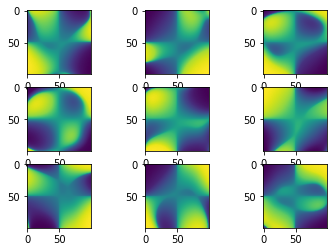

In [10]:
show_sample(9,potenciales)

# CNN 5 simetrías





In [9]:
from fastai.vision.all import *
from time import time

Comentario interesante: Si importas todo de fastai.vision.all, se importa un módulo llamado time, que sobreescribe el time de from time import time. Entonces, cuando llamas time(), te salta un error y se paraliza el programa. Para evitarlo, si vas a usar time() en algún momento, es necesario importarlo después de fastai.

Hemos guardado las imagenes en carpetas con el nombre de la simetría dentro del directorio dir. El directorio donde están las carpetas con las PCAs será nuestro directorio principal. Creamos un objeto Path con él.

In [10]:
path = Path(dir)

Para ver los contenidos del directorio:

In [11]:
path.ls()

(#5) [Path('/home/gabriel/Desktop/PCAs_todas/continuous_rotation'),Path('/home/gabriel/Desktop/PCAs_todas/none'),Path('/home/gabriel/Desktop/PCAs_todas/continuous_translation'),Path('/home/gabriel/Desktop/PCAs_todas/discrete_translation'),Path('/home/gabriel/Desktop/PCAs_todas/reflection')]

Para ver los contenidos de un subdirectorio (carpeta con PCAs):

In [12]:
for name in path.ls():
  print(name,'--',len(name.ls()))

/home/gabriel/Desktop/PCAs_todas/continuous_rotation -- 4291
/home/gabriel/Desktop/PCAs_todas/none -- 4273
/home/gabriel/Desktop/PCAs_todas/continuous_translation -- 4277
/home/gabriel/Desktop/PCAs_todas/discrete_translation -- 4261
/home/gabriel/Desktop/PCAs_todas/reflection -- 4274


Hacemos uso de la API de fastai para importar las imagenes. El nombre de las categorias lo sacará del nombre de las carpetas en lasque están as simetrías.

In [13]:
pcas = DataBlock(blocks=(ImageBlock, CategoryBlock),
   get_items=get_image_files,
   get_y=parent_label,
   splitter=RandomSplitter(valid_pct=0.2, seed=42),
   item_tfms=Resize(224)
   ,batch_tfms=aug_transforms(mult=0.2,do_flip=False)
   )

Dataloader. Escojo un batchsize pequeño porque de momento tengo pocas imagenes. Si no especifico el bs, cuando hay del orden de 10 imagenes, el programa falla, porque encuentra divisiones por 0 y cosas raras. No puede encontrar una learning rate adecuada porque da error, y la red no puede entrenar. Por eso hay que especificar un bs, que sea más pequeño que el numero de imagenes.

In [14]:
dls = pcas.dataloaders(path,bs=64)

Mostrar una de las imagenes importadas:

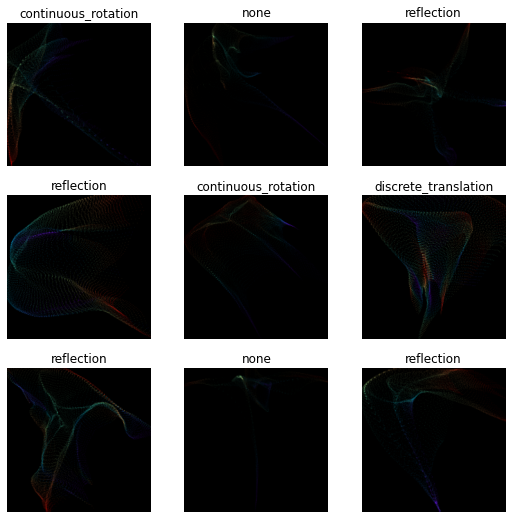

In [15]:
dls.show_batch()

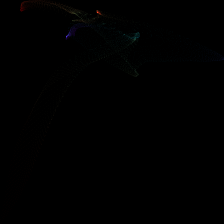

In [ ]:
dls.valid_ds[2][0]

In [16]:
#Learner, con la red pre-entrenada resnet34
learn = cnn_learner(dls, resnet18, metrics=accuracy)

In [17]:
import torch, gc
gc.collect()
torch.cuda.empty_cache()

SuggestedLRs(lr_min=0.005754399299621582, lr_steep=0.0008317637839354575)

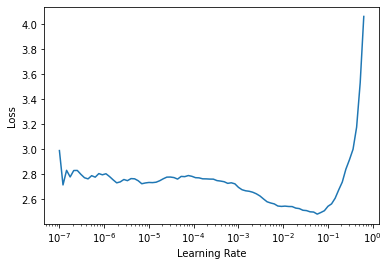

In [18]:
#Buscar el mínimo de learning rate, para evitar que no converja por dar saltos demasiado grandes
learn.lr_find()

Entrenar la CNN:

epoch,train_loss,valid_loss,accuracy,time
0,1.487325,1.318803,0.472982,01:14


Better model found at epoch 0 with accuracy value: 0.4729824662208557.


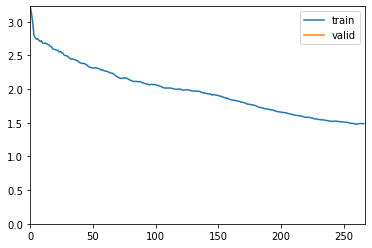

epoch,train_loss,valid_loss,accuracy,time
0,0.968652,0.865303,0.658246,00:24
1,0.754291,0.713122,0.724912,00:24
2,0.576852,0.654171,0.753216,00:24
3,0.512857,0.721115,0.743392,00:24
4,0.457009,0.682329,0.754386,00:24
5,0.395941,0.617311,0.785263,00:24
6,0.311535,0.623500,0.776374,00:24
7,0.265964,0.820299,0.755556,00:24
8,0.215874,0.728481,0.773567,00:24
9,0.166471,0.803665,0.775906,00:24


Better model found at epoch 0 with accuracy value: 0.6582456231117249.


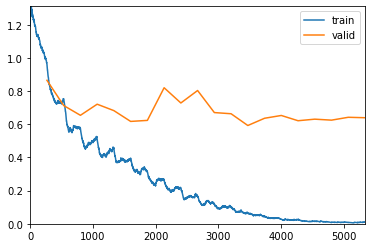

Better model found at epoch 1 with accuracy value: 0.7249122858047485.
Better model found at epoch 2 with accuracy value: 0.7532163858413696.
Better model found at epoch 4 with accuracy value: 0.7543859481811523.
Better model found at epoch 5 with accuracy value: 0.785263180732727.
Better model found at epoch 10 with accuracy value: 0.8159064054489136.
Better model found at epoch 11 with accuracy value: 0.8177777528762817.
Better model found at epoch 12 with accuracy value: 0.8446783423423767.
Better model found at epoch 14 with accuracy value: 0.8453801274299622.
Better model found at epoch 15 with accuracy value: 0.859649121761322.
Better model found at epoch 18 with accuracy value: 0.8598830699920654.


In [19]:
learn.fine_tune(epochs = 20, freeze_epochs=1, base_lr= 0.005, cbs=[ShowGraphCallback(), SaveModelCallback(monitor='accuracy')] )

epoch,train_loss,valid_loss,accuracy,time
0,0.032586,1.040274,0.779415,00:24
1,0.232594,2.604348,0.592982,00:25
2,0.253547,2.077600,0.611696,00:25
3,0.166573,2.171113,0.583860,00:25
4,0.147828,0.951042,0.746667,00:25
5,0.086801,1.499090,0.692164,00:25
6,0.046197,0.862355,0.784328,00:25
7,0.025072,0.588669,0.852632,00:25
8,0.010989,0.482841,0.869474,00:25
9,0.007341,0.468529,0.870175,00:25


Better model found at epoch 0 with accuracy value: 0.7794151902198792.


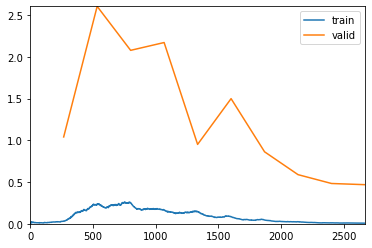

Better model found at epoch 6 with accuracy value: 0.784327507019043.
Better model found at epoch 7 with accuracy value: 0.8526315689086914.
Better model found at epoch 8 with accuracy value: 0.8694736957550049.
Better model found at epoch 9 with accuracy value: 0.8701754212379456.


In [22]:
# Another option for training
learn.unfreeze()
learn.fit_one_cycle(10,0.0003,cbs=[ShowGraphCallback(), SaveModelCallback(monitor='accuracy')] )

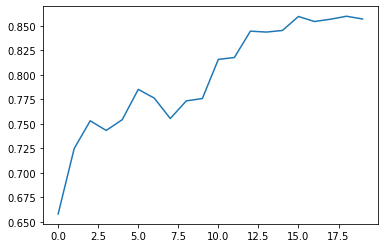

In [20]:
accu = [learn.recorder.values[i][2] for i in range(len(learn.recorder.values))]
epochs = range(len(learn.recorder.values))
plt.plot(epochs,accu)

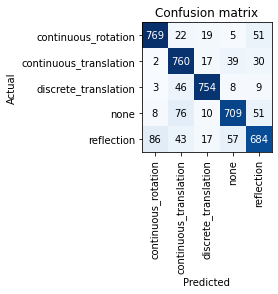

In [21]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

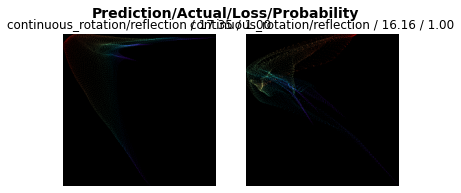

In [23]:
interp.plot_top_losses(2)

## Guardar Modelo

Guardar modelo en formato .pkl

In [42]:
model_name = 'model_name_1'
save_dir = top_dir + '/models'
if not os.path.isdir(save_dir):
    print('Creating directory:\n',save_dir)
    os.mkdir(save_dir)

model_dir = save_dir+'/'+model_name

learn.save(model_dir)
learn.export(model_dir+'.pkl')

----------

MIXUP

In [21]:
path = Path(dir)

pcas = DataBlock(blocks=(ImageBlock, CategoryBlock),
   get_items=get_image_files,
   get_y=parent_label,
   splitter=RandomSplitter(valid_pct=0.2, seed=42),
   item_tfms=Resize(224)
   ,batch_tfms=aug_transforms(mult=0.2,do_flip=False)
   )

dls = pcas.dataloaders(path,bs=150)

learn = cnn_learner(dls, resnet18, metrics=accuracy, loss_func= LabelSmoothingCrossEntropy())
learn.unfreeze()

In [22]:
#Sacar la accuracy:
a = learn.validate()
print('Accuracy:',a[1]*100,'%')

Accuracy: 47.10356891155243 %


epoch,train_loss,valid_loss,accuracy,time
0,1.097590,0.611675,0.821533,00:11
1,0.696840,0.395224,0.879462,00:10
2,0.537189,0.362902,0.892335,00:10
3,0.467761,0.341598,0.912229,00:10
4,0.435225,0.342237,0.909304,00:10
5,0.416455,0.339776,0.907548,00:10
6,0.404766,0.337472,0.912814,00:10
7,0.396172,0.352918,0.906963,00:10
8,0.395591,0.339497,0.908133,00:10
9,0.396004,0.345750,0.907548,00:10


Better model found at epoch 0 with accuracy value: 0.8215330839157104.


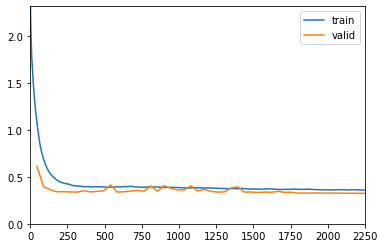

Better model found at epoch 1 with accuracy value: 0.8794616460800171.
Better model found at epoch 2 with accuracy value: 0.8923346996307373.
Better model found at epoch 3 with accuracy value: 0.9122293591499329.
Better model found at epoch 6 with accuracy value: 0.9128144979476929.
Better model found at epoch 14 with accuracy value: 0.9139847755432129.
Better model found at epoch 39 with accuracy value: 0.9157401919364929.
Better model found at epoch 41 with accuracy value: 0.9163253307342529.


In [23]:
mixup = MixUp(alpha=0.5)

learn.fine_tune(epochs = 50,freeze_epochs = 0, base_lr= 0.005, cbs=[ShowGraphCallback(), SaveModelCallback(monitor='accuracy'), mixup])

SuggestedLRs(lr_min=0.00831763744354248, lr_steep=0.02754228748381138)

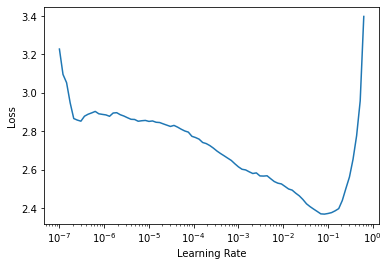

In [ ]:
learn.lr_find()

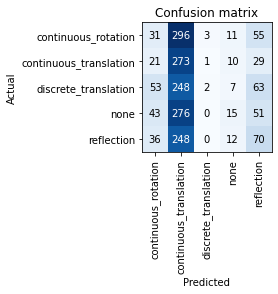

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [ ]:
del(learn)
import gc
gc.collect()
torch.cuda.empty_cache()

#Guardar / Cargar Modelo

In [62]:
model_name = 'model_x_accu_resnet18_one_cycle_10+5_no_mixup'
save_dir = top_dir + '/models'
if not os.path.isdir(save_dir):
    print('Creating directory:\n',save_dir)
    os.mkdir(save_dir)

model_dir = save_dir+'/'+model_name

learn.save(model_dir)

Path('/home/gabriel/Desktop/models/model_90_accu_resnet18_one_cycle_10+5_no_mixup.pth')

OJO!! Al cargar un learner nuevo, pierdes de la memoria el que has entrenado antes. O se desajusta o algo así.

In [63]:
#Cargar:
learn2 = cnn_learner(dls, resnet18, metrics=accuracy)
learn2.load(model_dir)

Veamos si podemos encontrar la matriz de confusión directamente

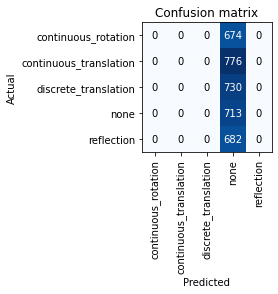

In [64]:
interp2 = ClassificationInterpretation.from_learner(learn2)
interp2.plot_confusion_matrix()

Entrenamos 1 epoch:

epoch,train_loss,valid_loss,accuracy,time
0,0.001282,0.637495,0.893147,00:38


Better model found at epoch 0 with accuracy value: 0.8931468725204468.


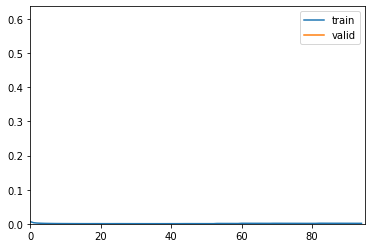

In [58]:
learn2.fine_tune(epochs = 1,freeze_epochs=0, base_lr= 0.001, cbs=[ShowGraphCallback(), SaveModelCallback(monitor='accuracy')])

Vemos ahora la matriz de confusión:

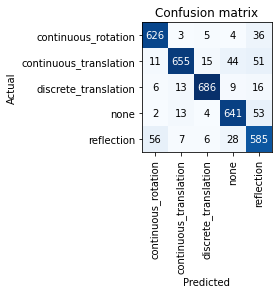

In [59]:
interp2 = ClassificationInterpretation.from_learner(learn2)
interp2.plot_confusion_matrix()

In [60]:
#Sacar la accuracy:
a = learn2.validate()
print('Accuracy:',a[1]*100,'%')

Accuracy: 89.31468725204468 %


---

epoch,train_loss,valid_loss,accuracy,time
0,0.413150,0.670028,0.858145,00:31


Better model found at epoch 0 with accuracy value: 0.8581445813179016.


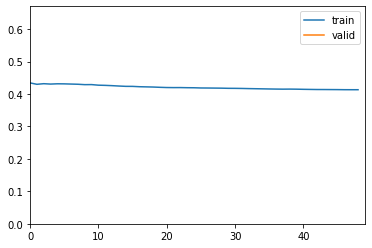

In [ ]:
learn2.fine_tune(epochs = 1,freeze_epochs=0, base_lr= 0.001, cbs=[ShowGraphCallback(), SaveModelCallback(monitor='accuracy')])

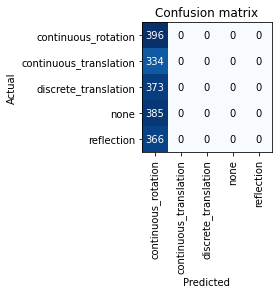

In [ ]:
interp2 = ClassificationInterpretation.from_learner(learn2)
interp2.plot_confusion_matrix()